In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [2]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatching import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation

In [3]:
class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        #print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, prior, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            dynamic_tracks = self.dynamic_tracker.getTracks()
            lanes = self.getLanes(prior, first_world_ref[0:2])
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, dynamic_tracks, lanes, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, dynamic_tracks, first_world_ref[0:2], gt_relative_pos, imu_relative_ref_3d, lanes)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getLanes(self, prior, translate):
        prior_elements = []
        #lane_width = 5.
        #w = lane_width / 2.
        for pr in prior:
            prior_len = pr["x"].shape[0]
            elem = np.zeros([prior_len, 4])
            elem[:-1,2] = pr["dx"]
            elem[-1,2] = elem[-2,2]
            elem[:-1,3] = pr["dy"]
            elem[-1,3] = elem[-2,3]
            #grad = np.abs(elem[:,3] / (elem[:,2] + 1e-6))
            sx = 0#-1#-1*np.sign(elem[:, 3]) * w * 1/np.sqrt(1+grad**2)
            sy = 0#-1#np.sign(elem[:, 2]) * w * grad * 1/np.sqrt(1+grad**2)
            
            elem[:, 0] = pr["x"] - translate[0] + sx
            elem[:, 1] = pr["y"] - translate[1] + sy
            
            #debug_min_x = min(pr["x"])
            #debug_max_x = max(pr["x"])
            #debug_min_y = min(pr["y"])
            #debug_max_y = max(pr["y"])
            #if debug_min_x < 1130 and debug_max_y < 1590:
                #print(f"debug_min_x = {debug_min_x} debug_max_x = {debug_max_x} debug_min_y = {debug_min_y} debug_max_y = {debug_max_y}")
                #print(f"sx = {sx[0]} sy = {sy[0]}")
            prior_elements.append(elem)
            
        return prior_elements
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            xmin = np.min(lane["x"]) if lane["fx"] else np.min(lane["y"])
            xmax = np.max(lane["x"]) if lane["fx"] else np.max(lane["y"])
            prior_list.append({"c": (a0,a1,a2), "xmin": xmin, "xmax": xmax, "fx": lane["fx"]})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, prior, nusc_map)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:367: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/690/database
frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 0
Number of extended tracks before run() 0
frame_idx = 1
Number of new plots 2
Number of dynamic tracks before run() 0
frame 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 45
Number of extended tracks before run() 0
frame_idx = 2
Number of new plots 1
Number of dynamic tracks before run() 2
frame 2


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

Number of point tracks before run() 74
Number of extended tracks before run() 0
frame_idx = 3
Number of new plots 2
Number of dynamic tracks before run() 3
frame 3


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

Number of point tracks before run() 84
Number of extended tracks before run() 0
frame_idx = 4
Number of new plots 2
Number of dynamic tracks before run() 4
frame 4


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

Number of point tracks before run() 95
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.29261434e+01  3.62661290e+00 -5.72961556e-02  2.73942671e+01
  4.20643038e+01]
created an extended object! [ 2.98866587e+00 -7.63582725e-01 -2.41226467e-04  3.63809953e+01
  5.33584103e+01]
created an extended object! [ 3.38981743e+01 -1.89044554e+00  8.09319334e-03  7.73957377e+01
  8.43267043e+01]
frame_idx = 5
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 5


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.01378015e+02  1.98013011e+00 -1.97516503e-02  6.07779331e+01
  7.24449101e+01]
frame_idx = 6
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 6


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00024122646741171267, -0.7635827249634104, 2.9886658657807947) (0.006898421250611593, -1.3150773020074826, 12.206346612982014)
frame_idx = 7
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 7


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00021573693266290373, -0.7639679214954206, 2.9892664560857445) (0.009243358032847388, -1.5396596469237351, 17.585809965136807)
frame_idx = 8
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 8


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.057296155590553316, 3.626612900687135, -82.92614341148159) (-0.06043358812463058, 3.9153152314777753, -88.85912387968824)
frame_idx = 9
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.057296155590553316, 3.626612900687135, -82.92614341148159) (-0.061698311645358495, 4.011374165369094, -90.58473409601295)
frame_idx = 10
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 10


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05784178302495708, 3.6336123029565113, -82.93315883833355) (-0.06311773783613067, 4.110370617340426, -92.19757511414164)
frame_idx = 11
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 11


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056515288322314776, 3.5977132203809497, -82.86867006688567) (-0.06000488864948249, 3.871624831352669, -87.98115620767469)
frame_idx = 12
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 12


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056377111060504796, 3.5899621641059043, -82.85118048227221) (-0.059401337792940705, 3.8665206332794453, -88.28718933131266)
frame_idx = 13
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 13


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05658865372190529, 3.598643789474976, -82.86768157909958) (-0.05918383307287239, 3.8191676411805586, -87.10242619165496)
frame_idx = 14
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 14


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05679617036130147, 3.6070046606979353, -82.88480691455072) (-0.058604125221228084, 3.820748975761253, -87.64222569472808)
frame_idx = 15
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056789738770158846, 3.607023085350811, -82.88507456435357) (-0.055874584662842244, 3.5942205264588503, -83.35752907890632)
Tracks are similar! do not open a new trk (-0.019751650277426824, 1.9801301136105018, -101.37801481219986) (0.002622087007955747, -1.0379388174794846, -0.009603259496326564)
frame_idx = 16
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 16


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0568305199316575, 3.6082109569751837, -82.88726657920787) (-0.05728714838898081, 3.7027790646449694, -85.35191135659736)
Tracks are similar! do not open a new trk (-0.019751650277426824, 1.9801301136105018, -101.37801481219986) (0.0015530541427490393, -0.867644920811329, -6.46140280457494)
created an extended object! [ 2.79704273e+02 -1.18272874e+01  1.25899848e-01  5.22656550e+01
  5.68716032e+01]
frame_idx = 17
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 17


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0568305199316575, 3.6082109569751837, -82.88726657920787) (-0.05569848274913365, 3.6033237827029376, -83.72323272373441)
frame_idx = 18
Number of new plots 3
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.002709141584487318


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 18


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056709332335874024, 3.6030498365079606, -82.87738831914449) (-0.057371691063387166, 3.7268277571796338, -86.08558963084646)
created an extended object! [-2.40980321e+00 -9.81931841e-01  2.32780889e-03  6.09298092e+01
  8.41757425e+01]
frame_idx = 19
Number of new plots 3
Number of dynamic tracks before run() 4
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0014641295409802968


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 19


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05666697749674452, 3.602090656194901, -82.87724984156087) (-0.05487477768384826, 3.53068215731836, -82.29456742638052)
frame_idx = 20
Number of new plots 3
Number of dynamic tracks before run() 4
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.00126429336617917


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 20


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05666697749674452, 3.602090656194901, -82.87724984156087) (-0.05480323181944238, 3.5429738232518266, -83.07545262852496)
dist is 2.4695663940705668  not similar! (-0.05666697749674452, 3.602090656194901, -82.87724984156087) (0.026976139072057353, 0.249124057955935, -64.45109162412228) 27.189197831077536 34.143467515403245
created an extended object! [-6.44510916e+01  2.49124058e-01  2.69761391e-02  2.34008331e+01
  3.41434675e+01]
frame_idx = 21
Number of new plots 3
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.00203540403327207


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 21


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05666449583081504, 3.602014200065529, -82.87708494914482) (-0.05419835732019619, 3.508880003884906, -82.54908009594857)
frame_idx = 22
Number of new plots 3
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0013336243356590893


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 22


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05666449583081504, 3.602014200065529, -82.87708494914482) (-0.05652042996263541, 3.597622377274669, -82.68758189253056)
frame_idx = 23
Number of new plots 3
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.0009475396254203794


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 23


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 24
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 24


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05666449583081504, 3.602014200065529, -82.87708494914482) (-0.05627291786741392, 3.5862012906821508, -82.31223531796714)
frame_idx = 25
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 25


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05666449583081504, 3.602014200065529, -82.87708494914482) (-0.05644303082718845, 3.6544530671630824, -84.69568686009796)
frame_idx = 26
Number of new plots 3
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.001637664327941768


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 26


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05659063516704389, 3.598959708129157, -82.87155920883431) (-0.05471541439719069, 3.495030203669492, -81.27144401376209)
frame_idx = 27
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 27


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05659063516704389, 3.598959708129157, -82.87155920883431) (-0.047945059579713116, 3.0185829883762474, -72.91459556220725)
frame_idx = 28
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 28


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.06062549017254138, 3.94806244282121, -89.64925830693186)
Tracks are similar! do not open a new trk (0.0009245574273745772, -0.8350976398964938, 3.455679920316103) (0.005383936053628626, -1.2689429475554395, 15.033778802289376)
frame_idx = 29
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 29


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.050351027247857075, 3.1737263184704463, -75.21945841089102)
frame_idx = 30
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 30


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (0.0014655598351848485, -0.7624198797416466, -0.5410909057550256)
Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.094733587089939, 5.96863608903695, -119.3848319658067)
frame_idx = 31
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 31


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.060757485450555836, 3.971520542668179, -90.15731889616904)
Tracks are similar! do not open a new trk (0.0008692074944242425, -0.8321142560100374, 3.4425371026877962) (0.007759913293206219, -1.4487627612973282, 18.5039793189753)
frame_idx = 32
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 32


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.061077758773148014, 3.996350634047516, -90.61039117529575)
Tracks are similar! do not open a new trk (0.00086984467822765, -0.8321320547079954, 3.442463057271948) (0.0077769905495365214, -1.4500660564070291, 18.53891620090736)
frame_idx = 33
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 33


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.060329229823092294, 3.928536002773704, -89.27898559031375)
frame_idx = 34
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 34


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.060943320478598184, 4.1428709904583245, -94.89224788870827)
frame_idx = 35
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 35


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.061753356836504215, 4.197565585390857, -95.78460720853855)
frame_idx = 36
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 36


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.05988686144968858, 3.968669495014384, -90.6470242200586)
Tracks are similar! do not open a new trk (0.0008661592661010814, -0.8319146939959362, 3.4413695262805155) (-0.0028507268555892098, -0.3532414896746587, -9.652353251659745)
frame_idx = 37
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 37


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.05838896055157503, 3.9264740062939114, -90.6887662935576)
Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (0.00422398049236831, -1.008636918144374, 4.527657317432869)
frame_idx = 38
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 38


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.060513333722369715, 3.9592281282233155, -89.84054237237457)
Tracks are similar! do not open a new trk (0.0008312092494867287, -0.8299239289655453, 3.429565018946639) (0.0011461287531215213, -0.7782210394576388, 1.6184036624973086)
frame_idx = 39
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 39


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.056651936210311775, 3.6012597505279205, -82.87693300755902) (-0.06207520412540026, 4.112188457982556, -92.89225042716178)
Tracks are similar! do not open a new trk (0.0008444471578693398, -0.8305833364088451, 3.43269432255925) (-0.0027823439930313694, -0.3582198905705761, -9.598436752001811)
frame_idx = 40
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 40


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.08795337e+01  3.94417823e+00 -5.86528609e-02  2.31966892e+01
  4.32473613e+01]
frame_idx = 41
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 41


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008623187915681285, -0.831549389998893, 3.4371091805388745) (0.002366760491128562, -0.8853069445825853, 3.870323441468719)
frame_idx = 42
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 42


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008623187915681285, -0.831549389998893, 3.4371091805388745) (0.00036787558702719057, -0.6788085771386694, -1.4118155951594948)
frame_idx = 43
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 43


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008611977237494156, -0.8315290681831984, 3.437406538721959) (0.0005155490908650374, -0.6958681037376372, -0.8770541243982868)
frame_idx = 44
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 44


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008611977237494156, -0.8315290681831984, 3.437406538721959) (1.1405233500633605e-05, -0.6478146305993856, -2.089575911192452)
frame_idx = 45
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 45


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008611977237494156, -0.8315290681831984, 3.437406538721959) (0.0001232730525831408, -0.6606038288266858, -1.6865929654299867)
Tracks are similar! do not open a new trk (-0.06847899232039163, 4.292309766926167, -92.20586397702411) (-0.070311663305778, 4.411123180729809, -94.44815322797737)
frame_idx = 46
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 46


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008611977237494156, -0.8315290681831984, 3.437406538721959) (-0.00016045880864869996, -0.6314556440496156, -2.4387939719700324)
frame_idx = 47
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 47


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008611977237494156, -0.8315290681831984, 3.437406538721959) (-6.486504942390217e-05, -0.640482420509594, -2.2272486700188496)
frame_idx = 48
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 48


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06846765806505087, 4.292017986489279, -92.20492238633655) (-0.05867859801618171, 3.882311904451448, -88.9066704498696)
created an extended object! [ 1.58792802e+00 -7.90688960e-01  1.43813678e-03  4.51287694e+01
  6.32070640e+01]
frame_idx = 49
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 49


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06846765806505087, 4.292017986489279, -92.20492238633655) (-0.05904496393817792, 3.921088521761504, -89.74517759797916)
frame_idx = 50
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 50


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06846765806505087, 4.292017986489279, -92.20492238633655) (-0.05844728025156472, 3.8709034857560742, -88.76679853898004)
frame_idx = 51
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 51


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06827934315916788, 4.2840528218736456, -92.17228877059559) (-0.05964397679500993, 3.958665458147817, -90.29773642435813)
Tracks are similar! do not open a new trk (0.0008640758569042665, -0.8317345948679886, 3.4393735464442443) (0.003604057670985511, -1.0445924637967439, 9.19368614312447)
created an extended object! [-3.29240296e+01  1.81431114e-01 -5.46717438e-03  6.77437577e+01
  8.32035365e+01]
frame_idx = 52
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 52


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06827934315916788, 4.2840528218736456, -92.17228877059559) (-0.06111272932014158, 4.073262672968133, -92.44359999859715)
frame_idx = 53
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 53


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008878840094398054, -0.8330378851902283, 3.4458559680567964) (-0.0002481332959808979, -0.6202795699984363, -2.3267863761942316)
Tracks are similar! do not open a new trk (-0.0683014432469002, 4.284680286059882, -92.17443922837442) (-0.08004998852497275, 5.201125326914159, -109.0256690590442)
frame_idx = 54
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 54


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008899261114339206, -0.8331890234093379, 3.4473837122046165) (-0.00035252425618249476, -0.6078545695148128, -2.721109500395039)
Tracks are similar! do not open a new trk (-0.0678651008884944, 4.267654400897806, -92.10784063726977) (-0.07977023220472429, 5.216037435310593, -109.67689693098106)
frame_idx = 55
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 55


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008899261114339206, -0.8331890234093379, 3.4473837122046165) (-0.00022997441315555697, -0.6182502847453155, -2.633305658231159)
Tracks are similar! do not open a new trk (-0.06776112726088332, 4.2636266663448135, -92.09188247774861) (-0.06383809737203275, 4.114887289318806, -91.60315263039668)
frame_idx = 56
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 56


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 4
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008899261114339206, -0.8331890234093379, 3.4473837122046165) (-0.0004414750427082789, -0.5990774551966547, -2.9005352116131577)
Tracks are similar! do not open a new trk (-0.06775090607694224, 4.263272009793282, -92.09043643413983) (-0.06603918990956853, 4.086941577181415, -88.70336693245552)
frame_idx = 57
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 57


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008899261114339206, -0.8331890234093379, 3.4473837122046165) (-0.00041152680674291005, -0.6029577259288169, -2.7609829781753725)
Tracks are similar! do not open a new trk (-0.06775090607694224, 4.263272009793282, -92.09043643413983) (-0.05880839272042715, 3.7574446152523584, -85.42969265082115)
frame_idx = 58
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 58


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008899261114339206, -0.8331890234093379, 3.4473837122046165) (-0.0003630480512488075, -0.6066697755864864, -2.750959715635729)
Tracks are similar! do not open a new trk (-0.0677022692516959, 4.261183859185075, -92.0815615295747) (-0.05769624663728923, 3.6245242549760905, -82.49091737435869)
frame_idx = 59
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 59


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009098769484581402, -0.8342576244819957, 3.4521378061933414) (-0.00031518765786533423, -0.6116108357159371, -2.6278673833515453)
Tracks are similar! do not open a new trk (-0.06771365888097244, 4.261216931075324, -92.08156001507241) (-0.05917474227866534, 3.783331987663487, -85.84680104563267)
frame_idx = 60
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 60


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.0004248320022132152, -0.6000956288966532, -2.8980511862109077)
frame_idx = 61
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 61


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.0003427001504660069, -0.6087907965791989, -2.720348561480772)
Tracks are similar! do not open a new trk (-0.06771687493061013, 4.2613482111832415, -92.08205106062685) (-0.058794878836065795, 3.7579588935885915, -85.45430712242725)
frame_idx = 62
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 62


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.000337165420492168, -0.6100939432406303, -2.664484541997352)
Tracks are similar! do not open a new trk (-0.06777142976078002, 4.26356864305687, -92.09026712365586) (-0.06023802733879352, 3.687971820370265, -80.03040289092505)
frame_idx = 63
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 63


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.00025674625485630633, -0.6190223515384069, -2.4669936619067334)
Tracks are similar! do not open a new trk (-0.06777142976078002, 4.26356864305687, -92.09026712365586) (-0.0540771054769895, 3.283791620833264, -75.25594442630252)
frame_idx = 64
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 64


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.00032936786959005513, -0.6113259745250994, -2.61774808632427)
Tracks are similar! do not open a new trk (-0.06777862278223716, 4.263863168728199, -92.09138090803755) (-0.05497007088380683, 3.343381414743891, -76.24778361910722)
Tracks are similar! do not open a new trk (-0.06777862278223716, 4.263863168728199, -92.09138090803755) (-0.051977928610410735, 3.124802363124734, -70.90423800038069)
frame_idx = 65
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 65


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.00015749031728282966, -0.6264158442471147, -2.393990440182206)
Tracks are similar! do not open a new trk (-0.06777947797234046, 4.263898558200516, -92.0915194618604) (-0.06241624011838594, 3.8117862730628986, -81.73570958869537)
Tracks are similar! do not open a new trk (-0.06777947797234046, 4.263898558200516, -92.0915194618604) (-0.06719297950964337, 4.133737182328671, -88.72061255337182)
frame_idx = 66
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 66


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (-0.00013457894699226629, -0.6286176085371666, -2.3798253725069047)
Tracks are similar! do not open a new trk (-0.06775190899868945, 4.2627399968600574, -92.08678124186046) (-0.06291603893729124, 3.8452434013628256, -82.28367624201239)
Tracks are similar! do not open a new trk (-0.06775190899868945, 4.2627399968600574, -92.08678124186046) (-0.06849395952194968, 4.213620457838908, -89.91302978035289)
frame_idx = 67
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 67


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009081522006681987, -0.8342079319923936, 3.4522831333584283) (8.824430198677385e-05, -0.6527073160149071, -1.7592401224043817)
Tracks are similar! do not open a new trk (-0.06775190899868945, 4.2627399968600574, -92.08678124186046) (-0.061023093181197564, 3.723499177455612, -80.41814781590789)
frame_idx = 68
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 68


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268930289100446, -0.8352994762657407, 3.459494546970495) (8.591227348497418e-05, -0.6550408699962018, -1.5245575454347708)
Tracks are similar! do not open a new trk (-0.06775190899868945, 4.2627399968600574, -92.08678124186046) (-0.05117931381961257, 3.1473562825639, -73.76430521534267)
frame_idx = 69
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 69


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 168
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009268930289100446, -0.8352994762657407, 3.459494546970495) (0.00011198124983087892, -0.6569726034883228, -1.4636553045464398)
Tracks are similar! do not open a new trk (-0.06775190899868945, 4.2627399968600574, -92.08678124186046) (-0.06068148268503246, 3.6919438205059434, -79.81025724056315)
frame_idx = 70
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 70


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (9.89045275809939e-05, -0.6545052620598246, -1.5898683605136832)
Tracks are similar! do not open a new trk (-0.06775771861580113, 4.262936636285191, -92.08758886427978) (-0.06240105942930895, 3.729132410297478, -79.49644877879031)
frame_idx = 71
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 71


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.000161534452031258, -0.6616929689205501, -1.3809122242817935)
Tracks are similar! do not open a new trk (-0.06775771861580113, 4.262936636285191, -92.08758886427978) (-0.05846715364953751, 3.5209993160494886, -76.51378696527743)
frame_idx = 72
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 72


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.0001556877529794902, -0.6613777687260508, -1.3528518930651219)
Tracks are similar! do not open a new trk (-0.06775771861580113, 4.262936636285191, -92.08758886427978) (-0.059789932571091116, 3.568699723651924, -76.655553353843)
frame_idx = 73
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 73


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.00019231698665951697, -0.6672424638409685, -1.0894295840049533)
Tracks are similar! do not open a new trk (-0.06775771861580113, 4.262936636285191, -92.08758886427978) (-0.05972566829688579, 3.59944861560664, -77.62745806687269)
frame_idx = 74
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 74


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (3.907174967602129e-05, -0.6485103020885832, -1.6369532506963458)
Tracks are similar! do not open a new trk (-0.06775771861580113, 4.262936636285191, -92.08758886427978) (-0.05862282277808445, 3.469926471682858, -74.75906853258962)
frame_idx = 75
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 75


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (6.322743884755169e-05, -0.6521267730523834, -1.4853985436300376)
Tracks are similar! do not open a new trk (-0.06775771861580113, 4.262936636285191, -92.08758886427978) (-0.07075274562631599, 4.302623058811131, -88.8043482305876)
frame_idx = 76
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 76


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 175
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (3.848967235891711e-05, -0.6483190978376818, -1.6163306300972438)
frame_idx = 77
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 77


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (6.843807861044224e-05, -0.653077385637359, -1.4135424839648183)
frame_idx = 78
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 78


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.0001229492803402761, -0.6615284375943621, -1.0522351666308096)
frame_idx = 79
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 79


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.0001393542395747924, -0.6627019174079286, -1.0560580517827591)
frame_idx = 80
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 80


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.00014582461211351774, -0.6631587528914182, -1.05226961878882)
frame_idx = 81
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 81


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009280838731914621, -0.8353628130980872, 3.4597666305147308) (0.00014163877648175273, -0.6627860782803152, -1.0103428217532449)
frame_idx = 82
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 82


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 182
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.06324224e+00 -6.61054971e-01  1.31669662e-04  3.42016789e+01
  1.02343686e+02]
frame_idx = 83
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 83


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00033580738333055917, -0.672408397973093, -0.9594373703581104) (0.007509333374564433, -1.3813359024307934, 16.11665806087711)
Tracks are similar! do not open a new trk (0.00033580738333055917, -0.672408397973093, -0.9594373703581104) (0.000642733101247466, -0.7342179446546343, 2.1084363976083647)
frame_idx = 84
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 84


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00040996870112743343, -0.6773937328778264, -0.9146002850862547) (0.0005305394948500845, -0.704471564886192, 0.13076905873180458)
frame_idx = 85
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 85


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000384500864691977, -0.6748489967228845, -0.9456601813619396) (0.00037783651569799266, -0.6885867098078111, -0.20576187289375802)
frame_idx = 86
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 86


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00037073587604994805, -0.6735632687239352, -0.958196135786846) (0.00032123948119726055, -0.6825808159785908, -0.3096572620920313)
frame_idx = 87
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 87


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00037112718280836086, -0.6734389260279979, -0.961726226250718) (0.00031469068372783716, -0.6817534675736051, -0.2949271931634942)
frame_idx = 88
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 88


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00036456464228873186, -0.6729059343597692, -0.9688216649610206) (0.0003361214648194161, -0.6837255271128447, -0.2791609704592624)
frame_idx = 89
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 89


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035430165349244447, -0.6718823704402022, -0.9781280009776382) (0.0005636291470274206, -0.7170050621209023, 1.0202381440098518)
frame_idx = 90
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 90


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035441528149727624, -0.6718301570190822, -0.9792953843226837) (0.000523876197864066, -0.7119106596574223, 0.8788886083135922)
frame_idx = 91
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 91


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035870360548065724, -0.6721674071244419, -0.9751541794164543) (0.0005314516258714556, -0.7124857301129559, 0.8661381055750821)
frame_idx = 92
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 92


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003575650535320226, -0.6720090147142224, -0.9765338969337205) (0.0005232272271462855, -0.7109380141133526, 0.783533631505524)
frame_idx = 93
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 93


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035496274053731095, -0.6717311551570733, -0.9797918454200577) (0.000541667358184047, -0.71371067268483, 0.9105693459488099)
frame_idx = 94
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 94


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003581948854112557, -0.671970383681228, -0.977334491404052) (0.0005575585765593477, -0.715698390943753, 0.9563643892322414)
frame_idx = 95
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 95


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003588692982378751, -0.6720523652248056, -0.9760655310754869) (0.0005434724380342212, -0.7138601840060913, 0.921894243626281)
frame_idx = 96
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 96


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 185
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003591123526480159, -0.672109624126244, -0.9749586334190695) (0.0005643219399308029, -0.716489998870365, 0.965444069655694)
frame_idx = 97
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 97


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 190
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035865586486193564, -0.6720473321374508, -0.9759117195768775) (0.00047308278029611873, -0.7051043044695611, 0.6919256708813531)
frame_idx = 98
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 98


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 187
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035549406118454976, -0.6717121754327982, -0.9789204727383561) (0.00046888637195039064, -0.7046370047600927, 0.6821063440190752)
frame_idx = 99
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 99


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035530300509625383, -0.6716937069442765, -0.9791679654823532) (0.0002960568306390992, -0.6787418468399524, -0.29832155163987534)
frame_idx = 100
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 100


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 183
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003554910503812414, -0.6716944274240313, -0.9792848014266898) (0.00032607810363150636, -0.6821067990816061, -0.22689085497797984)
frame_idx = 101
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 101


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 184
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035588397279326677, -0.6716892930330183, -0.9799316621644766) (0.00044018117475663044, -0.699198864111212, 0.46593215359662515)
Tracks are similar! do not open a new trk (0.00035588397279326677, -0.6716892930330183, -0.9799316621644766) (-0.0019654190385026546, -0.4669595255995611, -6.545527113783528)
frame_idx = 102
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 102


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035779428583560354, -0.6718910731823223, -0.9777500259201826) (0.00037159477842373486, -0.6897022403059908, 0.15937675387460665)
created an extended object! [ 2.21395849e+02 -3.74958965e+00  1.22240606e-02  1.21013909e+02
  1.33506692e+02]
frame_idx = 103
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 103


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035800020261877503, -0.6718987269807807, -0.9777045383302282) (0.00044792901386874937, -0.7020216160296747, 0.7082362779559053)
frame_idx = 104
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 104


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003566173388203074, -0.6717323488038194, -0.9802481948621342) (0.00048100080449096406, -0.7081764060901575, 1.0304454015318771)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.006144445822703287, -2.1533245494148052, 116.91584642703984)
frame_idx = 105
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 105


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003560640607742297, -0.6716838685916078, -0.9809595457181679) (0.00048225912800489105, -0.7084643132010315, 1.046078970216005)
frame_idx = 106
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 106


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035617497759982266, -0.6717004765306913, -0.9811256237550637) (0.0003094244055985272, -0.6807304560600014, -0.0528061981832957)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.0016569119637656322, -1.0299170072626003, 46.599354020771145)
frame_idx = 107
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 107


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035739019743971623, -0.6718020091673823, -0.9796349877007685) (0.0002995550613441228, -0.6802886698667756, 0.010988173193619066)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.0025149137218590124, -1.2528021990029223, 61.04966827719532)
frame_idx = 108
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 108


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035771250896949594, -0.6718367269165781, -0.979767935083159) (0.0003079084285095242, -0.6841039655758083, 0.30107220875934804)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.002323125745970163, -1.1962583907238873, 57.08602725479779)
frame_idx = 109
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 109


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003568864335304565, -0.6717992509046152, -0.9801939883154913) (0.00034988325745157015, -0.6899935293011008, 0.47525774544637983)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.001986966889733704, -1.111591827173159, 51.739701365282265)
frame_idx = 110
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 110


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003575567938741534, -0.6718325187902598, -0.9801181729564896) (0.0003089817709483482, -0.6846955222307797, 0.30723948071322044)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.0018837915836486035, -1.0854101735471604, 50.07117685019015)
frame_idx = 111
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 111


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003574569699513324, -0.6718180977272263, -0.9804681591296411) (0.00027118815296835733, -0.6795388987757783, 0.15621270059637887)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.0027990677589204214, -1.3337562848251314, 66.96311604386896)
frame_idx = 112
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 112


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035588014869752043, -0.6716630309330455, -0.9820779877655107) (0.00026266250589711255, -0.6783099738584268, 0.12965843312577963)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.0030321759047509983, -1.3971592826943964, 71.28103450603078)
frame_idx = 113
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 113


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035566859275196, -0.6716717946664186, -0.9814408991289622) (0.00027279958095367444, -0.680112157210948, 0.21146820267032762)
Tracks are similar! do not open a new trk (0.012224060628114725, -3.7495896500173473, 221.3958492347023) (0.003242082722547327, -1.453459045334412, 75.00707075558753)
frame_idx = 114
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 114


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003557274178313589, -0.6716669914168334, -0.9814093777035487) (0.0004207853777602057, -0.7026750332007758, 1.0242185666672852)
created an extended object! [ 6.25613494e+01 -1.26749518e+00  2.54904256e-03  1.20421311e+02
  1.47406599e+02]
frame_idx = 115
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 115


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035437368724745415, -0.6715120038422864, -0.9838869946425749) (0.00040216614330444673, -0.7006896898276128, 1.0377005465225753)
frame_idx = 116
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 116


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035246043425316367, -0.6712985483175384, -0.9870074245468957) (0.0003505167225745116, -0.6913860373493365, 0.6049764109972204)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.013597904091935864, -4.1367078207367625, 248.85971904834878)
frame_idx = 117
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 117


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003499890074534607, -0.6710340707359717, -0.9911849303981092) (0.00034781324370246764, -0.6915059249518867, 0.6442130125826554)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.007448360712822355, -2.5196162540729246, 142.62857984338947)
frame_idx = 118
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 118


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003496752482744912, -0.6709503099694255, -0.9933269954429709) (0.00036096387076200564, -0.6932313215306266, 0.6775824369701581)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.017902931299223677, -5.247860219478316, 320.48725157779813)
frame_idx = 119
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 119


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003496362309224076, -0.6709021980560347, -0.9943660813695292) (-0.00014912404346411514, -0.6106163521853335, -2.656060872798227)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.01145244960872317, -3.5997565476411872, 215.36472489991294)
frame_idx = 120
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 120


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003495435114410979, -0.6708855815979905, -0.9946061320345992) (0.00044524934898460244, -0.711047371067191, 1.6065137595427905)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.005588503546487074, -2.0920456418462128, 118.75793313068417)
frame_idx = 121
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 121


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034917182230972585, -0.6708371799495866, -0.9955445502134299) (0.00027800271503862376, -0.6828242386318104, 0.39637505265796297)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.005520273469588772, -2.0726341383754585, 117.38684055397657)
frame_idx = 122
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 122


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034932050005117334, -0.6708484982047703, -0.9953825691299918) (0.0004215906350623785, -0.707741660578675, 1.513990968383352)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (-0.0020390928692818515, 0.014407076148634033, -26.371581969471347)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.060104103363790615, -15.647683720151198, 960.582045450261)
frame_idx = 123
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 123


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003498396925021896, -0.6708969380554427, -0.9946190244919115) (5.8055336349224466e-05, -0.6455900284776942, -1.1616148530393369)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.003863523006071505, -1.6087825526338866, 84.91676305838382)
created an extended object! [ 7.26061566e+02 -9.40865856e+00  2.74968799e-02  1.56475171e+02
  1.70870488e+02]
frame_idx = 124
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 124


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003492002699556869, -0.6708443619371423, -0.9954224219690037) (0.000389380761917173, -0.7017541221158397, 1.1856244420361688)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.0035635037473401507, -1.5228651415529713, 78.8075910902094)
frame_idx = 125
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 125


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003494451971247338, -0.6708751527268326, -0.9948134979737487) (0.00036356025767108767, -0.6973320403986254, 0.9942227542167924)
Tracks are similar! do not open a new trk (0.0025490425645276074, -1.267495183371943, 62.56134943186273) (0.0038543930498942526, -1.5999740919071441, 83.87965467485489)
Tracks are similar! do not open a new trk (0.027496879862364453, -9.40865855643122, 726.0615662181309) (0.026858981150794266, -9.030824925095738, 681.3986593204627)
frame_idx = 126
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 126


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034963943376580355, -0.6709073092121421, -0.9940438680910291) (-5.197681212105886e-05, -0.6237188121110177, -2.345563317643933)
created an extended object! [ 6.93286865e+01 -1.38875484e+00  3.08884000e-03  1.19805928e+02
  1.47173188e+02]
Tracks are similar! do not open a new trk (0.027496879862364453, -9.40865855643122, 726.0615662181309) (0.027055418630081735, -9.087663125138919, 685.4971552677115)
frame_idx = 127
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 127


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034963257753246326, -0.6709056651758589, -0.9940922600120673) (6.541411766011934e-05, -0.6423895230092296, -1.6619516998563184)
Tracks are similar! do not open a new trk (0.027496879862364453, -9.40865855643122, 726.0615662181309) (0.014933843040752504, -5.252391953871174, 382.3244162806178)
frame_idx = 128
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 128


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003503804946772943, -0.6709787207447998, -0.9931139302032554) (0.0002532630242310291, -0.6733097295534108, -0.5057525889322506)
Tracks are similar! do not open a new trk (0.027496879862364453, -9.40865855643122, 726.0615662181309) (0.0022806895112630577, -1.2294743961930976, 62.83484683260177)
frame_idx = 129
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 129


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003514057895527424, -0.6710987672390714, -0.9911426635046069) (0.0003362115913806247, -0.6988185272830505, 1.4115950017124486)
Tracks are similar! do not open a new trk (0.0003514057895527424, -0.6710987672390714, -0.9911426635046069) (-0.002303161482761533, -0.29579992195255717, -15.698063765406344)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.0034767465337569156, -1.4901542714295928, 75.69213841948888)
Tracks are similar! do not open a new trk (0.027496879862364453, -9.40865855643122, 726.0615662181309) (0.003595422353488022, -1.6612722127168655, 98.14050102247322)
frame_idx = 130
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 130


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035139393482197924, -0.6710903869404309, -0.9914314700985043) (0.00038171532104097844, -0.706232302761135, 1.6881521891732953)
frame_idx = 131
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 131


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003512186189335409, -0.6710522004859018, -0.9924838424017487) (0.0003747114856979406, -0.7059861260610089, 1.7199219526773206)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.0033680768115995543, -1.4582803414362968, 73.45740123435391)
frame_idx = 132
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 132


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035094386396375247, -0.6710216062062959, -0.9931309123395691) (0.0004072343335636447, -0.7119826935268698, 1.9814368698596816)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.005035810158077536, -1.9139855605423306, 104.51128968453152)
frame_idx = 133
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 133


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035048246448684465, -0.6709845601020814, -0.9936201825248367) (0.00042969871160330943, -0.7158031010708769, 2.1269224977257224)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.004620166468631252, -1.8088021330834705, 97.82714722982624)
frame_idx = 134
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 134


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003505485345590363, -0.6709944962526826, -0.9933554316770457) (0.000408476520039304, -0.7120171746427589, 1.9896810521720227)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.004782320862575363, -1.8525075300264717, 100.78568784614971)
frame_idx = 135
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 135


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034992533902600644, -0.6709514096387226, -0.9936528897059178) (0.0002672484410669341, -0.6781404784406732, -0.2862905532626272)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.004801693756128598, -1.8537518911583417, 100.61809726300926)
created an extended object! [ 7.11823796e+01 -1.33770729e+00  2.62900447e-03  1.51125138e+02
  1.73240754e+02]
frame_idx = 136
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 136


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034950059675306345, -0.6708870013400579, -0.9951609211193737) (0.000398140520944743, -0.7106367187819201, 1.9188602973595403)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.004726963600198666, -1.8340439882183934, 99.31591971634403)
Tracks are similar! do not open a new trk (0.00034950059675306345, -0.6708870013400579, -0.9951609211193737) (0.005417316816775776, -1.3149976491758513, 17.627271318584533)
frame_idx = 137
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 137


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034962722033552525, -0.6708871284597777, -0.9954244643209025) (0.00034624464977250663, -0.7026918806741602, 1.6281519244715597)
Tracks are similar! do not open a new trk (0.0030888399959236924, -1.38875483552332, 69.32868648587664) (0.005023814095169383, -1.9002101029541367, 102.83355491615873)
Tracks are similar! do not open a new trk (0.00034962722033552525, -0.6708871284597777, -0.9954244643209025) (0.005081239118787424, -1.269411206116999, 16.094707047832618)
frame_idx = 138
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 138


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003496776975182903, -0.6708946479295562, -0.9952517020288493) (0.0003291081599609279, -0.6996950520293973, 1.4923982189310958)
created an extended object! [ 1.11146876e+02 -2.02387767e+00  5.48346951e-03  1.20375552e+02
  1.46013031e+02]
frame_idx = 139
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 139


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003501757489866893, -0.6709122380910345, -0.9953466237321886) (0.00040708761683522736, -0.713636783558702, 2.126344916973638)
frame_idx = 140
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 140


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003497990490023018, -0.6708798473902136, -0.9958365497732204) (0.00041935276134005963, -0.7155993058143977, 2.1894008735334536)
created an extended object! [-1.18537357e+02  2.04377562e+00 -1.20935563e-02  1.12916533e+02
  1.22314725e+02]
Tracks are similar! do not open a new trk (0.0026290044696173826, -1.337707288968904, 71.1823795964596) (0.00443134829086603, -1.9647328359647092, 124.9397678299853)
frame_idx = 141
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 141


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00034973168932703126, -0.6708680928160344, -0.9961377479199807) (0.0005118251757559397, -0.7325605815774301, 2.9874261984080825)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.004702599366846048, -1.7877917839257214, 93.55738346990117)
Tracks are similar! do not open a new trk (0.0026290044696173826, -1.337707288968904, 71.1823795964596) (0.004509302587860746, -1.985240224089562, 126.2535917576677)
frame_idx = 142
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 142


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003506042166429182, -0.6709541724243484, -0.9945729014264492) (0.0004697270077018481, -0.7257459450067892, 2.725603616210036)
frame_idx = 143
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 143


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003506168669816719, -0.6709573574653207, -0.9944778766849195) (0.000473750206358105, -0.7265965268557696, 2.7621381816986026)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.0017097641564390942, -1.0273982974156415, 45.284899393042394)
frame_idx = 144
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 144


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003510989869995256, -0.6709950003685109, -0.9940105364315099) (0.00022144687708266318, -0.6832046342613659, 0.9530559423396874)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.001633796709226407, -1.0072362114154279, 43.96125594516108)
frame_idx = 145
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 145


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003513240386934428, -0.6710167127656294, -0.9936134125945565) (0.0003173188737649886, -0.69966231406642, 1.6370112321128831)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.0015295918672462423, -0.986903380323705, 43.0561686684112)
Tracks are similar! do not open a new trk (0.0003513240386934428, -0.6710167127656294, -0.9936134125945565) (-0.0024235110965566014, -0.29395460485508457, -15.607806940054271)
frame_idx = 146
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 146


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000350595352773212, -0.6709577718494255, -0.9944139388603848) (0.00028738495649347455, -0.6945782461657167, 1.4319878868592415)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.001293123367795003, -0.9234309138793173, 38.82929789521689)
frame_idx = 147
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 147


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003505030165191278, -0.6709409333223821, -0.9948584944807086) (0.00036375480199566306, -0.7078706482207976, 1.9765980113770083)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.0020594543600270516, -1.124021216305596, 51.934492147222954)
frame_idx = 148
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 148


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003500807545795666, -0.6709093411092282, -0.9952032949192599) (0.00026180562935881733, -0.6874812047936137, 1.0425602654858528)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.0011697756500046728, -0.8863388161678238, 36.05955815057449)
frame_idx = 149
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 149


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003504038418992606, -0.6709477260496185, -0.9944700274187966) (0.00030232982136130465, -0.6955001072110609, 1.3695759009966504)
Tracks are similar! do not open a new trk (0.00548346950906549, -2.023877671384427, 111.14687573707614) (0.0009327062197481848, -0.820810628257564, 31.532018050756392)
frame_idx = 150
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 150


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035151496697465566, -0.6710479799056275, -0.9929484408569108) (0.002843441413734267, -1.0472172481039697, 11.114940003973143)
created an extended object! [ 2.59956451e+01 -7.42238255e-01  6.57500935e-04  1.20554072e+02
  1.44251837e+02]
Tracks are similar! do not open a new trk (0.00035151496697465566, -0.6710479799056275, -0.9929484408569108) (6.466735043956485e-05, -0.6432896627734919, -1.1841647751821078)
frame_idx = 151
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 151


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003527625428989208, -0.6711996900111696, -0.9898491874285195) (0.0026716807397056926, -1.0232286117008476, 10.279070217024845)
Tracks are similar! do not open a new trk (0.0003527625428989208, -0.6711996900111696, -0.9898491874285195) (-0.000252222926237211, -0.6009337960236142, -2.332327707538429)
frame_idx = 152
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 152


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035258500547240057, -0.6711971049043414, -0.9896746203011679) (0.0011390140214288804, -0.8489873262451222, 8.465793768583948)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (0.0003271878092877656, -0.6257240338063552, 16.434631474057994)
frame_idx = 153
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 153


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035309313105811154, -0.6712310346159958, -0.9894398972382275) (0.0008845230530522216, -0.7609453494581151, 0.6919055492509922)
Tracks are similar! do not open a new trk (0.00035309313105811154, -0.6712310346159958, -0.9894398972382275) (0.0018019181990434148, -0.9539359929881049, 12.59871062799933)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (0.00011703102607655144, -0.5703086491328903, 12.785938633396368)
frame_idx = 154
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 154


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035310168291171164, -0.671231716952081, -0.9894312568285066) (0.0008849872984571034, -0.7607117545104728, 0.6545953968388865)
frame_idx = 155
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 155


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003535523668463064, -0.6712750010302904, -0.9887130246707813) (0.001090208229111697, -0.8379510458370985, 7.92538880142539)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (-0.0015680192962125087, -0.12952453476259415, -15.95584657553572)
frame_idx = 156
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 156


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003526622995258368, -0.671193015215361, -0.9900998436434324) (-0.0002706930973762016, -0.5882149409585149, -5.743130871765341)
frame_idx = 157
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 157


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035282258085461346, -0.671205338978438, -0.9899583941284701) (-0.00030313699846507827, -0.5775699970407714, -6.2620406411281575)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (-0.0028399953566941864, 0.18949691672630797, -35.858698276908115)
frame_idx = 158
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 158


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003522967568234149, -0.6711549986575371, -0.990864383732609) (3.4935361420568e-05, -0.6347050602306912, -3.8467729709717844)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (-0.0025637805573428965, 0.11869817410698598, -31.33902465979562)
Tracks are similar! do not open a new trk (0.0003522967568234149, -0.6711549986575371, -0.990864383732609) (-0.0004050202390306119, -0.5871489583714087, -2.119188867733807)
frame_idx = 159
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 159


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000352084113511531, -0.6711359287660296, -0.9911718143027597) (5.170446756101126e-05, -0.6370827265250804, -3.7677326307638963)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (-0.0009241328098207628, -0.32142830052629195, -1.7949004379699744)
Tracks are similar! do not open a new trk (0.000352084113511531, -0.6711359287660296, -0.9911718143027597) (0.00029999151810800175, -0.7164532417807908, 3.8314475146174494)
frame_idx = 160
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 160


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003512673221274814, -0.6710594469530646, -0.9925015267948261) (-3.338256498533225e-05, -0.622746532026573, -4.380955999874933)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (-0.0015273939078628632, -0.15059610317884534, -13.873100569479671)
Tracks are similar! do not open a new trk (0.0003512673221274814, -0.6710594469530646, -0.9925015267948261) (0.0011647886222126598, -0.846748735216914, 8.236565585152547)
created an extended object! [ 3.31769584e+02 -4.02832416e+00  9.45483673e-03  1.73536996e+02
  1.88573732e+02]
frame_idx = 161
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 161


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003515228156871953, -0.6710739086781257, -0.9924961949184717) (-6.661173834842461e-05, -0.6164284464832308, -4.672901397420875)
Tracks are similar! do not open a new trk (0.0006575009347268759, -0.7422382554098619, 25.99564513140665) (0.009032080280320825, -2.881307140209567, 162.5811784234363)
Tracks are similar! do not open a new trk (0.0003515228156871953, -0.6710739086781257, -0.9924961949184717) (0.0013432442343357747, -0.8813931238867668, 9.879523758488704)
frame_idx = 162
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 162


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035127545127029713, -0.6710530666105312, -0.9927936147228901) (-0.00017008562131030092, -0.5989941830660512, -5.410714705885435)
created an extended object! [ 1.52067351e+02 -2.72017353e+00  8.41452625e-03  1.20439960e+02
  1.34956898e+02]
Tracks are similar! do not open a new trk (0.00035127545127029713, -0.6710530666105312, -0.9927936147228901) (-0.0002269759805127696, -0.60358576030466, -2.2486874758575466)
frame_idx = 163
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 163


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003511127154248553, -0.671039416212199, -0.9929865777898844) (0.0006812735952943811, -0.7479532920565063, 1.0460512425354194)
Tracks are similar! do not open a new trk (0.0003511127154248553, -0.671039416212199, -0.9929865777898844) (0.0001203614439486534, -0.666618630028548, 0.6148086037517928)
frame_idx = 164
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 164


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035059656709137717, -0.6710055182336236, -0.9932606994072251) (0.0005475347164990051, -0.7250448661489871, 0.06559623397746953)
Tracks are similar! do not open a new trk (0.00035059656709137717, -0.6710055182336236, -0.9932606994072251) (-5.1673034867192505e-05, -0.6344986629622711, -0.859239694648317)
frame_idx = 165
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 165


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035035569190417507, -0.6709843650120418, -0.9935873561783618) (0.001011447065063878, -0.8065764095803878, 3.6444380685772964)
Tracks are similar! do not open a new trk (0.00035035569190417507, -0.6709843650120418, -0.9935873561783618) (0.0003663390765633512, -0.7140097622228841, 2.841926948428699)
frame_idx = 166
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 166


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035029982881557253, -0.6709797989786868, -0.9936483486560591) (0.002633272991187644, -1.099627450686401, 16.76091096887693)
Tracks are similar! do not open a new trk (0.00035029982881557253, -0.6709797989786868, -0.9936483486560591) (-0.0004509973106201169, -0.5642053799727477, -4.0300378978870155)
Tracks are similar! do not open a new trk (0.009454836730261807, -4.0283241647756975, 331.76958430588076) (0.009191206670836687, -3.860367751667958, 310.4318671073517)
frame_idx = 167
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 167


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035109771925387, -0.6710484111177679, -0.9926127886044283) (0.0025569962684515394, -1.0833154098678306, 15.931398353792586)
Tracks are similar! do not open a new trk (0.00035109771925387, -0.6710484111177679, -0.9926127886044283) (-0.0005165242491587089, -0.5518530351998449, -4.598047740129046)
Tracks are similar! do not open a new trk (0.009454836730261807, -4.0283241647756975, 331.76958430588076) (0.009308573292062803, -3.9045199637791397, 314.5699087095468)
frame_idx = 168
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 168


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003509041653641654, -0.671026520298364, -0.9930917876297498) (0.0026501042538386132, -1.0926196449373737, 16.052397798802257)
Tracks are similar! do not open a new trk (0.0003509041653641654, -0.671026520298364, -0.9930917876297498) (0.00045011981061912474, -0.7297526472409749, 3.5711171638340513)
frame_idx = 169
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 169


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035127080014239656, -0.6710664205899338, -0.9922425245989878) (0.0047180222042553345, -1.4636250413285847, 32.621058353654995)
Tracks are similar! do not open a new trk (0.00035127080014239656, -0.6710664205899338, -0.9922425245989878) (-0.0005908663375007204, -0.5381086699866525, -5.229945614311922)
frame_idx = 170
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 170


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003510831173642603, -0.6710528104489663, -0.9923714768154401) (0.004513265068371662, -1.4293281838515872, 31.186810084839205)
Tracks are similar! do not open a new trk (0.0003510831173642603, -0.6710528104489663, -0.9923714768154401) (-0.0005802445206539936, -0.540210334255789, -5.125915133717739)
Tracks are similar! do not open a new trk (0.009454836730261807, -4.0283241647756975, 331.76958430588076) (0.0011686292550722596, -0.9554572055617481, 47.78519651265155)
frame_idx = 171
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 171


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003510831173642603, -0.6710528104489663, -0.9923714768154401) (0.004604583992562879, -1.4553835117654148, 32.71484940737449)
Tracks are similar! do not open a new trk (0.0003510831173642603, -0.6710528104489663, -0.9923714768154401) (0.002472642312248058, -1.0988297345939275, 20.026904373377718)
Tracks are similar! do not open a new trk (0.009454836730261807, -4.0283241647756975, 331.76958430588076) (0.0026311009550863654, -1.4858930998101854, 95.78434148677059)
created an extended object! [ 2.99110385e+02 -4.97784225e+00  1.73360000e-02  1.13122535e+02
  1.20152132e+02]
created an extended object! [ 2.87325913e+03 -3.43907739e+01  1.00167413e-01  1.67037345e+02
  1.71474432e+02]
frame_idx = 172
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 172


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003510831173642603, -0.6710528104489663, -0.9923714768154401) (0.006907282143749587, -1.8765238644084448, 51.82006960857579)
Tracks are similar! do not open a new trk (0.0003510831173642603, -0.6710528104489663, -0.9923714768154401) (0.00015538723354900175, -0.6898145424385999, 2.520608309203446)
created an extended object! [ 1.15126012e+02 -1.68410781e+00  3.13213111e-03  1.73357093e+02
  1.89855547e+02]
frame_idx = 173
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 173


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035114825310041597, -0.6710603077999228, -0.9922095492260653) (0.010105244559283643, -2.4582672582857956, 78.19098640761194)
Tracks are similar! do not open a new trk (0.00035114825310041597, -0.6710603077999228, -0.9922095492260653) (-0.0024775220118189705, -0.18450750872687038, -21.70557992276006)
frame_idx = 174
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 174


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003512310861055389, -0.6710679291410845, -0.9920814274512096) (0.009588994752362596, -2.3654023854910813, 74.04588754365423)
Tracks are similar! do not open a new trk (0.0003512310861055389, -0.6710679291410845, -0.9920814274512096) (-0.002358798984615385, -0.16528835782625687, -24.77414236514381)
frame_idx = 175
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 175


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003512310861055389, -0.6710679291410845, -0.9920814274512096) (0.009389324308764742, -2.3298832114131227, 72.52153265780579)
frame_idx = 176
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 176


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003504844091684732, -0.670995353789729, -0.9934161496618251) (0.002995950623877764, -1.2011200562912323, 22.802480637224924)
frame_idx = 177
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 177


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035033534634998657, -0.6709817131882875, -0.9936432997101338) (0.0024237464986167955, -1.0944348679937803, 17.893910911722934)
Tracks are similar! do not open a new trk (0.00035033534634998657, -0.6709817131882875, -0.9936432997101338) (-0.0031772450218254832, -0.00262632145273936, -32.87053201489907)
Tracks are similar! do not open a new trk (0.100167412680064, -34.390773864759495, 2873.259132722811) (0.0858532998722604, -29.654752537421402, 2479.6034510627737)
frame_idx = 178
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 178


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035033534634998657, -0.6709817131882875, -0.9936432997101338) (0.0034794907151710877, -1.2922117319765523, 27.067424569702858)
frame_idx = 179
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 179


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035050099980498463, -0.6709955419159426, -0.9934506098163248) (0.0020493088375586957, -1.0268722434576405, 14.89018775315292)
frame_idx = 180
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 180


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00035044310521764415, -0.670990681623843, -0.9935191624117508) (-5.4113782044685787e-05, -0.6330229406819543, -1.070750634911267)
Tracks are similar! do not open a new trk (0.00035044310521764415, -0.670990681623843, -0.9935191624117508) (0.001979536358355058, -1.0203180839491184, 14.81252940095986)
frame_idx = 181
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 181


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003509092589579836, -0.6710361676425269, -0.9926777160805087) (-0.00019992266043601163, -0.6076838358221409, -2.1883326252974094)
frame_idx = 182
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 182


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003506606207632535, -0.6710154862168854, -0.9929634806535351) (0.001023013803038928, -0.8355748199985485, 5.910438591653555)
Tracks are similar! do not open a new trk (0.0003506606207632535, -0.6710154862168854, -0.9929634806535351) (0.0006406915077112251, -0.7652020739622103, 5.198676697915665)
frame_idx = 183
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 183


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003503513549771435, -0.6709896422693025, -0.9933242323251879) (0.0012436025802251547, -0.8784031626615089, 7.982987558292924)
frame_idx = 184
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 184


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003502153118392232, -0.6709763974547671, -0.9935683190732267) (0.0005770909078516138, -0.7488072368497285, 1.7204280745609153)
frame_idx = 185
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 185


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003502153118392232, -0.6709763974547671, -0.9935683190732267) (0.0018493242082197414, -0.9922304799949424, 13.308862423562868)
frame_idx = 186
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 186


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003499772626346738, -0.6709498669127388, -0.9941510117770224) (0.0008362206738351827, -0.7979217069251465, 4.0360224782223275)
created an extended object! [-1.36130697e+03  2.36743085e+01 -1.06209553e-01  1.12750569e+02
  1.18277837e+02]
created an extended object! [-6.44419307e+00 -3.45581364e-01 -5.37624960e-04  1.73721811e+02
  2.05291075e+02]
created an extended object! [-2.68253649e+02  2.73544341e+00 -9.60265947e-03  1.63403838e+02
  1.69471220e+02]
frame_idx = 187
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 187


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003499772626346738, -0.6709498669127388, -0.9941510117770224) (0.0004251570006844649, -0.718458326016645, 0.2038652932018671)
frame_idx = 188
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 188


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003499772626346738, -0.6709498669127388, -0.9941510117770224) (0.000695527935480665, -0.7705133344798046, 2.722142197523511)
created an extended object! [ 3.11308233e+02 -4.57334708e+00  1.35178558e-02  1.43533111e+02
  1.53657079e+02]
frame_idx = 189
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 189


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003499772626346738, -0.6709498669127388, -0.9941510117770224) (-0.0001505210588352791, -0.6018238867022667, -5.687774693132956)
frame_idx = 190
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 190


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0003499772626346738, -0.6709498669127388, -0.9941510117770224) (0.001175676358758438, -0.8570414087069792, 6.51651441349832)
Tracks are similar! do not open a new trk (-0.0005376249601095052, -0.34558136449032467, -6.444193071338501) (-0.004894429244453943, 1.365444739176096, -174.88505057186015)
dist is 14.912987574291815  not similar! (0.01351785583924179, -4.573347082043497, 311.30823337066346) (0.1935236385259802, -58.835591880265206, 4368.833997007727) 149.11213624821562 153.55634572331934
created an extended object! [ 4.36883400e+03 -5.88355919e+01  1.93523639e-01  1.49112136e+02
  1.54342525e+02]
frame_idx = 191
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 191


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.78628386e+01 -1.52943912e-01 -2.42074997e-03  9.32080081e+01
  1.07789868e+02]
Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.009124180265286852, 2.6244198239530463, -263.376908613413)
frame_idx = 192
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 192


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.00902301439940229, 2.5919750816128855, -260.7501015563486)
frame_idx = 193
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 193


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (-0.004627027904655962, 0.7977797082049016, -86.28690549797577)
Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.008902744826719213, 2.5500825123623314, -257.12733668454024)
Tracks are similar! do not open a new trk (-0.0005376249601095052, -0.34558136449032467, -6.444193071338501) (-0.006028230698776537, 1.7993794016037703, -216.6371170682165)
frame_idx = 194
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 194


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (0.002990371003330168, -1.4308154533969168, 76.55891228737484)
Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.007300984541870611, 2.0135060464386387, -212.15906321453463)
Tracks are similar! do not open a new trk (-0.0005376249601095052, -0.34558136449032467, -6.444193071338501) (-0.004874615523614433, 1.3344850193439357, -169.8279675377477)
dist is 10.431438276854516  not similar! (0.01351785583924179, -4.573347082043497, 311.30823337066346) (0.02637348885130767, -8.310016082480052, 550.4306865115703) 143.82933708827468 153.3608526441586
Tracks are similar! do not open a new trk (0.1935236385259802, -58.835591880265206, 4368.833997007727) (0.02637348885130767, -8.310016082480052, 550.4306865115703)
created an extended object! [ 1.82275111e+03 -2.36393523e+01  7.22755628e-02  1.57228092e+02
  1.62981066e+02]
frame_idx = 195

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 195


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (0.0022639608114512935, -1.2331589080570617, 63.12615896581365)
Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.007686193096778995, 2.1447504266508615, -223.34164587362648)
frame_idx = 196
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 196


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0024207499745651524, -0.15294391191387655, -27.862838553212796) (-0.004179376349395338, 0.17629515303830431, -40.6465618618447)
Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (-0.0005209769000213625, -0.44554788690338065, 7.488611589114829)
Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.007242316454002279, 1.9910388792350848, -210.04908500361432)
frame_idx = 197
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 197


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (0.0006452857838417316, -0.7670672141511174, 29.664158148716464)
Tracks are similar! do not open a new trk (-0.0024207499745651524, -0.15294391191387655, -27.862838553212796) (-0.004103167039219226, 0.1614387133456657, -39.922879239491905)
Tracks are similar! do not open a new trk (-0.009602659474783774, 2.73544341073248, -268.2536490136199) (-0.007774823225476655, 2.177796346425104, -226.42631277388082)
frame_idx = 198
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 198


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (-0.0016855213641638071, -0.11651263015171948, -15.697654493047656)
created an extended object! [-1.93063072e+02  1.79997022e+00 -6.71016559e-03  1.63196252e+02
  1.82936291e+02]
frame_idx = 199
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 199


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01351785583924179, -4.573347082043497, 311.30823337066346) (-0.0016870668151145875, -0.11156427383849336, -16.35665422246124)
Tracks are similar! do not open a new trk (-0.0024207499745651524, -0.15294391191387655, -27.862838553212796) (-0.0027259473761906323, -0.11940291077040115, -25.662673750285634)
frame_idx = 200
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 200


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.77455884e+01 -9.32970773e-02 -1.74763532e-03  1.20627028e+02
  1.49903206e+02]
Tracks are similar! do not open a new trk (-0.0024207499745651524, -0.15294391191387655, -27.862838553212796) (-0.0027808759690525027, -0.10729397395820865, -26.317941405938512)
dist is 16.536161763214427  not similar! (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (0.030385486834277668, -10.358076016094788, 803.0936693301069) 158.8733045735553 162.81273438283748
Tracks are similar! do not open a new trk (-0.0067101655900062675, 1.7999702219809561, -193.0630715121356) (0.030385486834277668, -10.358076016094788, 803.0936693301069)
Tracks are similar! do not open a new trk (0.1935236385259802, -58.835591880265206, 4368.833997007727) (0.02746375756744092, -8.631449308225339, 574.1230086361734)
frame_idx = 201
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 201


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (-0.00035207171085038184, -0.4697667919651183, 7.5027854977922726)
dist is 16.615114422316726  not similar! (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (0.034656551493014706, -11.751705947512193, 916.6788336389604) 158.8733045735553 162.78565282705785
Tracks are similar! do not open a new trk (-0.0067101655900062675, 1.7999702219809561, -193.0630715121356) (0.034656551493014706, -11.751705947512193, 916.6788336389604)
Tracks are similar! do not open a new trk (0.1935236385259802, -58.835591880265206, 4368.833997007727) (0.02542814899563654, -8.036513271464765, 530.6848567729869)
Tracks are similar! do not open a new trk (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (-0.00026276050516817716, -0.6639226382951342, 3.8486443655781355)
frame_idx = 202
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 202


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (-0.00024274235269972712, -0.505264985761362, 10.27021026055834)
dist is 16.625830040239016  not similar! (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (0.03580846922585367, -12.123724742128896, 946.7112904040666) 158.8733045735553 162.758842086836
Tracks are similar! do not open a new trk (-0.0067101655900062675, 1.7999702219809561, -193.0630715121356) (0.03580846922585367, -12.123724742128896, 946.7112904040666)
dist is 13.261949592760685  not similar! (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.028438519854538616, -8.919763784845305, 595.4127299457339) 143.75744819318197 149.6119075588129
created an extended object! [ 5.95412730e+02 -8.91976378e+00  2.84385199e-02  1.43757448e+02
  1.53753962e+02]
Tracks are similar! do not open a new trk (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (0.005842442033221532, -2.637333527

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 203


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.00025310995755476514, -0.628244484025829, 17.856161045553225)
dist is 16.716280703548158  not similar! (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (0.041368644612541236, -13.937808508868665, 1094.594486049932) 158.8733045735553 162.7322994540164
Tracks are similar! do not open a new trk (-0.0067101655900062675, 1.7999702219809561, -193.0630715121356) (0.041368644612541236, -13.937808508868665, 1094.594486049932)
Tracks are similar! do not open a new trk (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (-0.00909723112006194, 2.1934627346530227, -227.15745506650163)
created an extended object! [-3.96485958e+02  3.83921120e+00 -1.17877933e-02  1.80157836e+02
  1.89642272e+02]
frame_idx = 204
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 204


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.0009599314578849285, -0.821147506631752, 30.970376894670757)
dist is 14.398265082863382  not similar! (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (0.02877089598700468, -9.813034220858304, 757.0638911583133) 157.5031353622255 162.706022247525
created an extended object! [ 7.57063891e+02 -9.81303422e+00  2.87708960e-02  1.56982200e+02
  1.70105722e+02]
frame_idx = 205
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 205


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.0009777925325775674, -0.8249403262192164, 31.155028119263434)
Tracks are similar! do not open a new trk (0.07227556280954686, -23.63935229120051, 1822.7511055762325) (-0.004858704875583864, 0.907157237940935, -129.67147382575203)
frame_idx = 206
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 206


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.000981773488551923, -0.8260127230745884, 31.230839629853133)
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.005629403441716326, 1.1519621627681138, -149.0424016898459)
frame_idx = 207
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 207


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (6.871265725643405e-05, -0.5912557364313239, 16.16733684531245)
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.002664518025153478, 0.24640909388087298, -79.90880151010818)
frame_idx = 208
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 208


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.0009510167836775376, -0.8182995788092621, 30.748426841205607)
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.004000976823015705, 0.6523498041532517, -110.84110761790156)
frame_idx = 209
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 209


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.00011625712032611034, -0.602694279374506, 16.860533436674388)
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.0030597528070013557, 0.36692371123542106, -89.04527410906448)
frame_idx = 210
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 210


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.00016349596333158228, -0.615315641507208, 17.69911295496317)
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.0032060405254573836, 0.40759147181501654, -91.93458987988035)
Tracks are similar! do not open a new trk (0.02877089598700468, -9.813034220858304, 757.0638911583133) (0.032008044158418035, -10.77585669551379, 828.4207128879465)
frame_idx = 211
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 211


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0017476353175275784, -0.09329707728724965, -17.74558835612526) (0.0009645566779492317, -0.8216283214415963, 30.940595752482125)
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.0020433968324575997, 0.06897007825431231, -67.27947450265935)
frame_idx = 212
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 212


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.74404336e+01 -1.20836087e+00  2.37439907e-03  1.21345291e+02
  1.47176060e+02]
Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.0021079342322026175, 0.09084546959888855, -69.12874335661013)
Tracks are similar! do not open a new trk (0.02877089598700468, -9.813034220858304, 757.0638911583133) (0.032356033064709334, -10.888094313403693, 837.4617554002248)
frame_idx = 213
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 213


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.028438519854538616, -8.919763784845305, 595.4127299457339) (-0.0008747453337034843, -0.2736409293005752, -42.211562359679654)
Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.0026908942670263863, -1.2692281828495104, 59.746833623266305)
created an extended object! [ 6.20803047e+02 -7.43346795e+00  1.95204395e-02  1.67725605e+02
  1.82681145e+02]
frame_idx = 214
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 214


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.0027210771584577007, -1.2816743449125165, 60.875627814058824)
dist is 9.429541882721097  not similar! (0.02877089598700468, -9.813034220858304, 757.0638911583133) (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) 157.60962235047623 169.47830012548482
created an extended object! [-4.63905740e+01 -2.20637069e-01 -1.04260534e-03  1.37111896e+02
  1.72059216e+02]
Tracks are similar! do not open a new trk (0.02877089598700468, -9.813034220858304, 757.0638911583133) (0.022825677927049186, -7.847090309130306, 594.9562896888242)
frame_idx = 215
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 215


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.0021280104306494784, -1.1233968583735963, 50.3166435909433)
Tracks are similar! do not open a new trk (0.02877089598700468, -9.813034220858304, 757.0638911583133) (-0.002087127362342504, 0.19321636761343983, -53.236842331717554)
frame_idx = 216
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 216


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.0019173794403488974, -1.0708848675722338, 47.12710813267285)
dist is 8.213788591694435  not similar! (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (-0.002973172959882625, 0.48603974315294507, -77.35640063256335) 155.62084120216514 171.71148971271413
created an extended object! [-7.73564006e+01  4.86039743e-01 -2.97317296e-03  1.55620841e+02
  1.73619519e+02]
frame_idx = 217
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 217


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.00191747795078138, -1.067636698876427, 46.66677933971597)
frame_idx = 218
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 218


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.0023805033819977884, -1.1877720209453924, 54.4502129449672)
frame_idx = 219
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 219


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.002477928787467518, -1.215544372614964, 56.39048142808196)
dist is 10.812562931699453  not similar! (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (-0.021461329737433508, 5.631987306439026, -465.39108007333647) 137.3363540472601 146.29865800893987
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (-0.021461329737433508, 5.631987306439026, -465.39108007333647)
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (0.005459936496678403, -2.336783219238842, 125.52201324035761)
frame_idx = 220
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 220


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.002361905927663884, -1.1811371151758312, 53.84384925396428)
dist is 10.71326828562812  not similar! (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (-0.014223667390114136, 3.5518933255155845, -316.5379799617178) 136.7239283543645 146.17827818289464
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (-0.014223667390114136, 3.5518933255155845, -316.5379799617178)
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (0.0056715476021382645, -2.407631312769616, 131.4442251061229)
frame_idx = 221
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 221


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.002184429605700456, -1.1348400753469359, 50.85853916524454)
dist is 10.777298108680904  not similar! (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (-0.012975129815991316, 3.191831144717577, -290.6372382019686) 136.7239283543645 146.05910215510988
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (-0.012975129815991316, 3.191831144717577, -290.6372382019686)
frame_idx = 222
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 222


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.002154106530736648, -1.12533393680301, 50.10078799115505)
frame_idx = 223
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 223


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002374399066128373, -1.2083608748303234, 57.44043363687917) (0.0019391271234138591, -1.0697419440296878, 46.52106466829974)
frame_idx = 224
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 224


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.55555153e+01 -1.05547513e+00  1.88886470e-03  1.21423092e+02
  1.46014870e+02]
dist is 7.504776091903424  not similar! (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (0.0014788169850064132, -1.0473126116620692, 53.745557570492764) 151.62676690483113 170.388420444754
Tracks are similar! do not open a new trk (-0.002973172959882625, 0.48603974315294507, -77.35640063256335) (0.0014788169850064132, -1.0473126116620692, 53.745557570492764)
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (-0.002425353519399094, 0.19110266465942077, -77.14264475607864)
dist is 11.635407001160674  not similar! (0.01952043947402083, -7.433467945831124, 620.8030474978519) (0.0037305073574433302, -1.7566895022455356, 77.44375451129294) 168.50824146583452 177.05430309937742
Tracks are similar! do not open a new trk (-0.0010426053427062243, -0.22063706904830138, -46.390573972023965) (0.0037305073574433

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 225


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 226
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 226


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.003404580185454115, 0.29414516489800424, -40.43847192810452)
Tracks are similar! do not open a new trk (-0.002973172959882625, 0.48603974315294507, -77.35640063256335) (-0.0029223292672496157, 0.33671628379380203, -54.94588817741231)
dist is 8.79115313887682  not similar! (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (0.0016866911412875849, -1.0744747881267, 19.809444529900034) 132.24661329394485 145.77018205588934
created an extended object! [ 1.98094445e+01 -1.07447479e+00  1.68669114e-03  1.32246613e+02
  1.49961928e+02]
dist is 8.31736082649554  not similar! (-0.002973172959882625, 0.48603974315294507, -77.35640063256335) (0.002801282250036812, -1.4542018733192321, 52.91264783258164) 157.40120737444818 172.7590213605352
created an extended object! [ 5.29126478e+01 -1.45420187e+00  2.80128225e-03  1.57401207e+02
  1.77054303e+02]
created an extended object!

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 227


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.003235862481079245, 0.25120266469986735, -37.71147220074217)
Tracks are similar! do not open a new trk (-0.002973172959882625, 0.48603974315294507, -77.35640063256335) (0.0013747701287641569, -1.0153501754972167, 51.31881498119045)
frame_idx = 228
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 228


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.0032348953404187954, 0.2508708218928771, -37.68557457315124)
dist is 8.032229945659198  not similar! (0.002801282250036812, -1.4542018733192321, 52.91264783258164) (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) 157.59675567691124 173.44709056009515
created an extended object! [ 4.73055833e+01 -9.68557378e-01  1.23848105e-03  1.51626767e+02
  1.73447091e+02]
frame_idx = 229
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 229


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.003265058363461787, 0.25852793381684064, -38.17066590324837)
frame_idx = 230
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 230


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.003338138543374433, 0.2772958023069884, -39.37263990197669)
frame_idx = 231
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 231


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.003395016028392823, 0.29179275766669427, -40.2946289344929)
frame_idx = 232
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 232


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.003333582817559478, 0.27600694359558686, -39.28293752040236)
Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0010266447306288761, -0.8548509060762823, 34.568510193388654)
frame_idx = 233
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 233


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (0.0010206866485705755, -0.8428869371497852, 32.55306921327008)
Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0008491705210670005, -0.7975706837206202, 29.965626556926615)
frame_idx = 234
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 234


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (0.0011836021763718403, -0.8865569917890664, 35.480341996778215)
Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0007964402296647648, -0.7794174415486312, 28.4292907475348)
frame_idx = 235
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 235


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0024575243509374896, -1.298846338641585, 69.01097825280664)
Tracks are similar! do not open a new trk (0.0018888646988704965, -1.055475134292269, 45.555515296826286) (-0.002298234582366574, 0.10953825665589172, -35.57049472303197)
frame_idx = 236
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 236


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.10211031108445  not similar! (0.0016866911412875849, -1.0744747881267, 19.809444529900034) (0.003669908980663911, -1.547108919783459, 79.38020529440254) 133.09356409239405 143.23089546362144
created an extended object! [ 7.93802053e+01 -1.54710892e+00  3.66990898e-03  1.26668125e+02
  1.43230895e+02]
Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0025027028478967466, -1.3147980138233348, 70.38206154787441)
frame_idx = 237
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 237


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0023357868543015495, -1.2610783207354197, 66.08613829674599)
frame_idx = 238
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 238


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0012384810485594842, -0.9685573784221826, 47.305583339245615) (0.0016631237188799528, -1.0562129482650695, 50.48742858937648)
frame_idx = 239
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 239


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.19612531e+01 -2.51345746e-01 -9.29423717e-04  1.36989040e+02
  1.60814542e+02]
frame_idx = 240
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 240


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.727471121528716  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) 137.10816717061144 157.69772971502607
created an extended object! [ 1.13438823e+01 -7.57987613e-01  6.54316659e-04  1.36524449e+02
  1.57697730e+02]
frame_idx = 241
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 241


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.921339016809364  not similar! (0.003669908980663911, -1.547108919783459, 79.38020529440254) (0.0065823212272679505, -2.4537579174918585, 116.6024506710417) 132.18359454127244 142.82502519467675
dist is 9.850954110136628  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (0.0065823212272679505, -2.4537579174918585, 116.6024506710417) 137.2261034053288 148.25459913104874
dist is 4.682118423227429  not similar! (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.0065823212272679505, -2.4537579174918585, 116.6024506710417) 136.63031529550204 148.25459913104874
created an extended object! [ 1.16602451e+02 -2.45375792e+00  6.58232123e-03  1.32183595e+02
  1.48254599e+02]
frame_idx = 242
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 242


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 243
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 243


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.44750834e+03  5.49906400e+01 -2.25715691e-01  1.16901094e+02
  1.19982579e+02]
frame_idx = 244
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 244


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 245
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 245


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 246
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 246


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.00500193365274943, 1.0516706351043053, -116.13810898935714)
frame_idx = 247
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 247


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.785974251247063  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (0.0025353883022912727, -1.3041862630483698, 50.936403836906216) 137.90936287807972 157.9114311763642
Tracks are similar! do not open a new trk (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.0025353883022912727, -1.3041862630483698, 50.936403836906216)
Tracks are similar! do not open a new trk (0.003669908980663911, -1.547108919783459, 79.38020529440254) (-0.007323780178515764, 1.4757147434907287, -128.21142635566804)
Tracks are similar! do not open a new trk (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.004935931699501744, 1.0302931151022325, -114.40577083141318)
frame_idx = 248
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 248


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.7918598015973486  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (0.002657647343015028, -1.3415157729941498, 53.78529080879929) 138.01928715572237 157.9114311763642
Tracks are similar! do not open a new trk (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.002657647343015028, -1.3415157729941498, 53.78529080879929)
Tracks are similar! do not open a new trk (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.016400113956220198, 4.59784720108906, -391.88849902390734)
frame_idx = 249
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 249


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.016421938090271277, 4.603942941946844, -392.30433537539847)
dist is 4.864468527216557  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (0.002058118914058842, -1.2056077129903784, 46.69153788115267) 138.1281121905886 150.08336792061323
Tracks are similar! do not open a new trk (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.002058118914058842, -1.2056077129903784, 46.69153788115267)
dist is 9.361508695921746  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.00882426014506619, 1.9723169230373194, -201.64502154335335) 138.1281121905886 150.8103019303694
dist is 4.5216357296863405  not similar! (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (-0.00882426014506619, 1.9723169230373194, -201.64502154335335) 137.44001069409904 150.8103019303694
Tracks are similar! do not open a new trk 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 250


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.887168633743899  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (0.006032976039986137, -2.310331575944778, 123.26720780652441) 138.2358489751062 150.08336792061323
Tracks are similar! do not open a new trk (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.006032976039986137, -2.310331575944778, 123.26720780652441)
Tracks are similar! do not open a new trk (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.016487858367334227, 4.627904650491325, -394.4145193931412)
dist is 9.408294970917957  not similar! (-0.000929423717414017, -0.2513457463117344, -11.96125312681803) (-0.0007090870052775212, -0.33195053647033557, -38.24564312685316) 138.2358489751062 150.8103019303694
dist is 4.540780863070512  not similar! (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (-0.0007090870052775212, -0.33195053647033557, -38.24564312685316) 137.5367214801901 150.8103019303694
Tracks are similar! do not open a new t

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 251


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.001333001156587568, -0.9555854883696695, 25.73075866619182)
dist is 4.0583033951626755  not similar! (0.0006543166587426253, -0.7579876131344896, 11.343882320954188) (0.00280768841067328, -1.3809576616693864, 73.1143244692144) 139.4298209141582 156.58971344798965
dist is 11.555395401242604  not similar! (0.0065823212272679505, -2.4537579174918585, 116.6024506710417) (0.00280768841067328, -1.3809576616693864, 73.1143244692144) 139.4298209141582 147.48626107534952
created an extended object! [ 7.31143245e+01 -1.38095766e+00  2.80768841e-03  1.39429821e+02
  1.61170372e+02]
frame_idx = 252
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 252


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.838592755523528  not similar! (0.0065823212272679505, -2.4537579174918585, 116.6024506710417) (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) 136.44755760255862 147.41358943295762
dist is 3.62590489453802  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) 139.53852367105225 161.06166953607672
created an extended object! [ 1.31551031e+01 -7.82438463e-01  7.39133285e-04  1.36447558e+02
  1.63953381e+02]
created an extended object! [ 1.20141275e+03 -1.41834687e+01  3.91208086e-02  1.66952084e+02
  1.76452762e+02]
frame_idx = 253
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 253


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.953529440453917  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) 139.64613940037736 150.8103019303694
dist is 4.400813562818132  not similar! (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) 136.5850867205719 150.8103019303694
created an extended object! [-6.03356550e+01 -2.61744064e-02 -1.76572510e-03  1.36461032e+02
  1.50810302e+02]
frame_idx = 254
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 254


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.6490777400537375  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (7.740378793564833e-05, -0.5930468003125966, -0.28714993652506926) 139.75267897240923 160.84751423471974
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (7.740378793564833e-05, -0.5930468003125966, -0.28714993652506926)
dist is 13.738578341082228  not similar! (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (0.03602783289119821, -11.387742711652876, 773.2086604208748) 136.72124054740505 142.39038600170534
dist is 6.568512754955979  not similar! (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) (0.03602783289119821, -11.387742711652876, 773.2086604208748) 136.5327782285945 142.39038600170534
created an extended object! [ 7.73208660e+02 -1.13877427e+01  3.60278329e-02  1.33853810e+02
  1.42390386e+02]
frame_idx = 255
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 255


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.6661354233988566  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (8.280992872722705e-07, -0.569527730734318, -2.080734776809197) 139.85815314872076 160.74204005840818
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (8.280992872722705e-07, -0.569527730734318, -2.080734776809197)
Tracks are similar! do not open a new trk (0.039120808600289686, -14.183468724288383, 1201.4127508380539) (-0.023062107953896554, 7.32307372940284, -657.3115204748198)
frame_idx = 256
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 256


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.6873512932403067  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-2.403346692512693e-05, -0.552543532359845, -4.082055168419625) 139.9625725832692 160.63762062385973
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-2.403346692512693e-05, -0.552543532359845, -4.082055168419625)
dist is 11.491299620336543  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-0.0022537660200826998, 0.0975300128180316, -67.59477053357573) 139.9625725832692 148.13335358157633
dist is 4.968354358091857  not similar! (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.0022537660200826998, 0.0975300128180316, -67.59477053357573) 137.55112719758085 148.13335358157633
Tracks are similar! do not open a new trk (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) (-0.0022537660200826998, 0.0975300128180316, -67.59477053357573)
Tracks are similar! do not open a new

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 257


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.700795216257986  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (0.00011995628132339111, -0.5945742667221195, -0.9985126368561548) 140.06594782347216 160.53424538365678
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (0.00011995628132339111, -0.5945742667221195, -0.9985126368561548)
dist is 11.565537911442227  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-0.002277729693689592, 0.10395369549756242, -68.01928630381062) 140.06594782347216 148.13335358157633
dist is 4.967156607609111  not similar! (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.002277729693689592, 0.10395369549756242, -68.01928630381062) 137.55112719758085 148.13335358157633
Tracks are similar! do not open a new trk (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) (-0.002277729693689592, 0.10395369549756242, -68.01928630381062)
Tracks are similar! do not open 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 258


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.7207999801800047  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (5.5073577645503065e-05, -0.5751909197864421, -2.449735328739277) 140.16828931127307 160.43190389585587
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (5.5073577645503065e-05, -0.5751909197864421, -2.449735328739277)
dist is 11.632373645902124  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-0.008774487514077965, 1.957304773730631, -200.123426763965) 140.16828931127307 148.13335358157633
dist is 4.897500338972384  not similar! (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.008774487514077965, 1.957304773730631, -200.123426763965) 137.25237594647356 148.13335358157633
Tracks are similar! do not open a new trk (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) (-0.008774487514077965, 1.957304773730631, -200.123426763965)
Tracks are similar! do not open a new trk 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 259


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.7412568733971554  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (0.0003581891516693973, -0.6659350167938315, 4.3231775783478685) 140.269607384196 160.33058582293296
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (0.0003581891516693973, -0.6659350167938315, 4.3231775783478685)
dist is 11.709216174390948  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-0.007864879710936641, 1.7010952704355786, -182.1005940258161) 140.269607384196 148.13335358157633
dist is 4.934595495486688  not similar! (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.007864879710936641, 1.7010952704355786, -182.1005940258161) 137.3818568810477 148.13335358157633
Tracks are similar! do not open a new trk (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) (-0.007864879710936641, 1.7010952704355786, -182.1005940258161)
Tracks are similar! do not open a new trk (

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 260


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.765027687901925  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-0.000430968047178272, -0.42364648183496, -14.26279885401407) 140.36991227638967 160.23028093073927
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.000430968047178272, -0.42364648183496, -14.26279885401407)
Tracks are similar! do not open a new trk (0.039120808600289686, -14.183468724288383, 1201.4127508380539) (-0.01022592077426326, 2.8526696503761366, -268.12163066667455)
frame_idx = 261
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 261


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.778841633036241  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (-1.190425382367121e-05, -0.5540995801844564, -4.115629440562758) 140.46921411966142 160.13097908746752
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-1.190425382367121e-05, -0.5540995801844564, -4.115629440562758)
Tracks are similar! do not open a new trk (0.039120808600289686, -14.183468724288383, 1201.4127508380539) (-0.00979584791468698, 2.7289399118465396, -259.6242078378957)
frame_idx = 262
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 262


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.795606548003167  not similar! (0.00280768841067328, -1.3809576616693864, 73.1143244692144) (3.3989389772381765e-05, -0.5681206563406154, -3.039621710586264) 140.56752294450044 160.0326702626285
Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (3.3989389772381765e-05, -0.5681206563406154, -3.039621710586264)
Tracks are similar! do not open a new trk (0.039120808600289686, -14.183468724288383, 1201.4127508380539) (-0.009069164438703934, 2.4736550248414395, -237.2135312154253)
frame_idx = 263
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 263


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007391332854275827, -0.7824384625891876, 13.155103131506952) (-0.0004145082706909233, -0.4307306063545652, -13.52291202078796)
Tracks are similar! do not open a new trk (0.039120808600289686, -14.183468724288383, 1201.4127508380539) (-0.011168722197157732, 3.16941267740791, -294.72101794409286)
frame_idx = 264
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 264


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.626881777310251  not similar! (-0.0017657251013826283, -0.02617440643800236, -60.335655037526685) (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) 137.21194170521392 150.05939210348984
dist is 13.787439077068505  not similar! (0.03602783289119821, -11.387742711652876, 773.2086604208748) (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) 136.49305728883746 141.98226114095993
created an extended object! [-1.60312839e+01 -3.99152412e-01 -5.13564020e-04  1.36493057e+02
  1.65801590e+02]
created an extended object! [-1.84589853e+02  1.86465090e+00 -7.30907193e-03  1.66641361e+02
  1.76602565e+02]
frame_idx = 265
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 265


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.390440700637567  not similar! (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (0.006387075968527243, -2.481618038841663, 157.61800935839497) 144.19448157117563 158.64531663139337
created an extended object! [ 1.57618009e+02 -2.48161804e+00  6.38707597e-03  1.44194482e+02
  1.58645317e+02]
dist is 7.308742439664238  not similar! (0.03602783289119821, -11.387742711652876, 773.2086604208748) (0.00045909302855288715, -0.639967972897238, -17.77203410463521) 137.03731142315405 141.94365950758862
dist is 4.0839377726443296  not similar! (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (0.00045909302855288715, -0.639967972897238, -17.77203410463521) 137.03731142315405 152.79840910375606
dist is 11.167076310039159  not similar! (0.006387075968527243, -2.481618038841663, 157.61800935839497) (0.00045909302855288715, -0.639967972897238, -17.77203410463521) 144.19448157117563 152.79840910375606
created an extended object! [-1.77720341e+01 -6.39967973

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 266


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-0.002541944341940702, 0.209035553453478, -61.47449199602274)
frame_idx = 267
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 267


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-0.0017126034284281949, -0.03522313826528954, -43.586835730523326)
frame_idx = 268
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 268


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-0.0006300785393291229, -0.3512707931357049, -20.545745686098847)
frame_idx = 269
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 269


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-0.00041886616269254357, -0.4197682612018822, -15.005269574963766)
frame_idx = 270
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 270


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-0.0005279962972718261, -0.38703954354997727, -17.464014217172664)
frame_idx = 271
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 271


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-1.5701051725630273e-05, -0.5458876593054816, -5.169928778878475)
frame_idx = 272
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 272


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-7.596759179979213e-05, -0.5298154396612088, -6.224365559752285)
frame_idx = 273
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 273


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (8.511637116129011e-05, -0.5762318988287475, -2.9049099579269124)
dist is 8.33344278748249  not similar! (-0.007309071930489057, 1.8646509012425443, -184.58985312968002) (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) 170.7246429104182 176.1718292863701
created an extended object! [-4.11580487e+01 -1.04095674e-01 -1.37284406e-03  1.70724643e+02
  1.82236464e+02]
frame_idx = 274
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 274


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-5.698657647569364e-05, -0.5340229761719997, -6.041445161621229)
frame_idx = 275
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 275


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005135640200349435, -0.39915241181437144, -16.031283863452202) (-6.240121453243759e-05, -0.5361077884849688, -5.6006741541182805)
frame_idx = 276
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 276


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.613665392082859  not similar! (0.006387075968527243, -2.481618038841663, 157.61800935839497) (-0.00012127289331943096, -0.5183578473648065, -6.932184510525457) 144.95070638358646 157.88909181898248
dist is 4.3361362151628695  not similar! (0.00045909302855288715, -0.639967972897238, -17.77203410463521) (-0.00012127289331943096, -0.5183578473648065, -6.932184510525457) 137.86210342217942 151.97361710473066
Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (-0.00012127289331943096, -0.5183578473648065, -6.932184510525457)
frame_idx = 277
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 277


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (8.495761329891197e-05, -0.5853123619926003, -1.514986877516247)
frame_idx = 278
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 278


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (8.49074894286505e-05, -0.5851130630512179, -1.5456555565449757)
frame_idx = 279
Number of new plots 2
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 279


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (0.00011893649424828489, -0.5962879099176536, -0.6390074754064801)
frame_idx = 280
Number of new plots 2
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 280


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (5.770013886177246e-05, -0.5766260678433253, -2.200719097432614)
frame_idx = 281
Number of new plots 3
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 281


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (4.8938724962502374e-05, -0.5743848857038341, -2.31758558855336)
frame_idx = 282
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 282


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (7.102486019993403e-05, -0.5810475668240452, -1.8169166153755323)
frame_idx = 283
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 283


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (7.320405761507613e-05, -0.5818559022822877, -1.7455384693455194)
frame_idx = 284
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 284


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0013728440562788082, -0.1040956740951874, -41.158048652771505) (7.445462818405031e-05, -0.5822125111225542, -1.7228466528994637)
frame_idx = 285
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 285


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.35040965e+00 -5.48511674e-01 -3.29831246e-05  1.43705325e+02
  1.82346794e+02]
created an extended object! [-4.75843814e+01  4.18351032e-01 -6.44480289e-03  1.33264260e+02
  1.42290811e+02]
frame_idx = 286
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 286


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 287
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 287


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (0.0013402579922100358, -0.9682177539848391, 27.745924872934854)
frame_idx = 288
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 288


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (-0.0002776359152594751, -0.46573267154739795, -11.214849993801584)
frame_idx = 289
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 289


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (-0.0001579412908969907, -0.5019949054357592, -8.472527980373913)
frame_idx = 290
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 290


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (0.00021229309320161533, -0.6152290655035954, 0.17693826165552728)
frame_idx = 291
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 291


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (0.00014637914929893, -0.5953593578725163, -1.3103076291557374)
frame_idx = 292
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 292


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (3.800075545185738e-05, -0.5613876253636685, -3.966340719932408)
Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (0.0030309510531955223, -1.648200505632151, 94.38446341685015)
frame_idx = 293
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 293


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (-0.0003756185267366704, -0.43394042220337475, -13.75543562617795)
frame_idx = 294
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 294


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (-0.0003910501851664457, -0.4285949534008387, -14.210806486913373)
frame_idx = 295
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 295


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (-0.00034390299207266126, -0.44177462116057215, -13.301567269235745)
frame_idx = 296
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 296


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-3.298312464969431e-05, -0.5485116743452361, -4.35040964930618) (-0.0003503163050897335, -0.43971552745071985, -13.469147871451007)
frame_idx = 297
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 297


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.57096082e+01 -4.13891767e-01 -4.24068974e-04  1.47021317e+02
  1.81965429e+02]
frame_idx = 298
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 298


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.52488483e+02  1.23298486e+00 -6.04046236e-03  1.38606240e+02
  1.51742065e+02]
frame_idx = 299
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 299


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0010160894560928898, -0.2213303208785486, -31.232088604770826)
frame_idx = 300
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 300


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0009036498301952545, -0.25777475810957656, -28.28692091559139)
frame_idx = 301
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 301


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0008590260813211147, -0.27285196459138705, -27.0185851220263)
frame_idx = 302
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 302


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0008846965584075981, -0.26144570593772054, -28.184628371895574)
frame_idx = 303
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 303


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0009052807612007817, -0.2545385749846896, -28.764005628692452)
frame_idx = 304
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 304


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.00033176341828571005, -0.44270695885658967, -13.355514466441365)
frame_idx = 305
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 305


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0003983789756461171, -0.42108049968353617, -15.114221314440805)
frame_idx = 306
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 306


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.00039901750440825127, -0.4205619816184734, -15.179638750226275)
frame_idx = 307
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 307


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.0004360522982968291, -0.4085546899547419, -16.134087092590455)
frame_idx = 308
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 308


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004240689736404877, -0.4138917672587, -15.709608220292097) (-0.00041552622027547786, -0.4156711033378261, -15.513994176604037)
frame_idx = 309
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 309


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.61121788e+01 -4.08805870e-01 -4.35331837e-04  1.53738392e+02
  1.93308261e+02]
frame_idx = 310
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 310


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.001131342515027408, -0.16833868777155128, -36.78413643780056)
created an extended object! [-1.67443978e+03  1.60783622e+01 -4.09614702e-02  1.95947485e+02
  2.07498325e+02]
frame_idx = 311
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 311


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.000767898960401889, -0.2876122932602041, -26.99796291450142)
frame_idx = 312
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 312


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.000716260440253357, -0.3049466806017218, -25.546341202449646)
frame_idx = 313
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 313


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0005975625619632248, -0.3441701611547795, -22.32291752145461)
frame_idx = 314
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 314


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0006654724061473295, -0.32068758695509625, -24.343749000969975)
frame_idx = 315
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 315


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0006871015687535161, -0.31313872202969945, -24.99319872262559)
frame_idx = 316
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 316


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0006893914889684351, -0.3122148906734156, -25.085956430913487)
frame_idx = 317
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 317


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0007379663374101115, -0.29584412182068154, -26.462700892649558)
frame_idx = 318
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 318


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0007518867837206231, -0.29037631757916343, -26.980514916731757)
frame_idx = 319
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 319


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0007268562615929082, -0.29904649796087174, -26.236385102416037)
frame_idx = 320
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 320


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00043533183706316, -0.40880587038783567, -16.112178762145867) (-0.0009988310606769224, -0.20439936235190362, -34.448395053618675)
created an extended object! [ 1.54165729e+02 -2.17570567e+00  4.15443576e-03  1.88982679e+02
  1.99828716e+02]
frame_idx = 321
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 321


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.95015026e+01 -3.80055119e-01 -4.83537343e-04  1.59662558e+02
  1.93354951e+02]
frame_idx = 322
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 322


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.804559592995402  not similar! (-0.0004835373432240316, -0.3800551192899105, -19.5015026338694) (-0.0039457687165828145, 0.8754305166230731, -159.9785562423028) 170.30191646711864 185.78880457338983
created an extended object! [-1.59978556e+02  8.75430517e-01 -3.94576872e-03  1.70301916e+02
  1.85788805e+02]
dist is 5.577775313210471  not similar! (-0.0004835373432240316, -0.3800551192899105, -19.5015026338694) (-0.008391039409367463, 2.56144293492319, -275.9330815335731) 180.95915767857718 190.3365225196453
dist is 19.940481261076066  not similar! (-0.0039457687165828145, 0.8754305166230731, -159.9785562423028) (-0.008391039409367463, 2.56144293492319, -275.9330815335731) 180.95915767857718 185.78880457338983
created an extended object! [-2.75933082e+02  2.56144293e+00 -8.39103941e-03  1.80959158e+02
  1.90336523e+02]
created an extended object! [ 5.15750008e+02 -5.47698692e+00  1.20655024e-02  1.98498602e+02
  2.10229413e+02]
frame_idx = 323
Number of new plots 1
Number of d

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 323


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 88
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004835373432240316, -0.3800551192899105, -19.5015026338694) (0.0007971641567984081, -0.8286093476360402, 19.735904473844407)
frame_idx = 324
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 324


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (1.3803691816826685e-05, -0.5536703257687837, -4.374521499063495)
frame_idx = 325
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 325


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.0002236102452935418, -0.46865929915650745, -11.948803873301673)
frame_idx = 326
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 326


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.00014302797253464122, -0.49763817588788195, -9.346384984191646)
frame_idx = 327
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 327


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.00015032311768071807, -0.49569384775744213, -9.474079067715564)
frame_idx = 328
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 328


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.000217928408631393, -0.47213506159464325, -11.526017806024127)
frame_idx = 329
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 329


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.0001523810428821457, -0.49426784254135725, -9.648916798984795)
frame_idx = 330
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 330


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.00020855922344443432, -0.4762122376783456, -11.10370241221989)
frame_idx = 331
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 331


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004154435758038067, -2.175705665990398, 154.16572888909198) (-0.00028505171553216556, -0.44836379677986427, -13.616469523533896)
frame_idx = 332
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 332


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004835373432240316, -0.3800551192899105, -19.5015026338694) (-0.0006965165585236211, -0.30008238714898783, -26.96378624960997)
frame_idx = 333
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 333


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.19929061847339  not similar! (-0.0039457687165828145, 0.8754305166230731, -159.9785562423028) (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) 171.11235883976974 184.97836220073867
dist is 5.87251998137583  not similar! (-0.008391039409367463, 2.56144293492319, -275.9330815335731) (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) 181.4498833659368 189.8457968322858
created an extended object! [-1.93751882e+01 -3.85975220e-01 -4.53583014e-04  1.66701992e+02
  1.94741574e+02]
frame_idx = 334
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 334


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.107441822363661  not similar! (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (0.0015334067988789237, -1.127539760257261, 23.158059953546232) 178.33675214844743 189.15237952154257
created an extended object! [ 2.31580600e+01 -1.12753976e+00  1.53340680e-03  1.78336752e+02
  1.89152380e+02]
created an extended object! [ 3.41558608e+02 -3.75773071e+00  7.82424075e-03  1.98003019e+02
  2.10057333e+02]
frame_idx = 335
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 335


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.0025418406714332376, 0.3777015464567367, -89.08244004464734)
frame_idx = 336
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 336


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.0025538901142278846, 0.3830557763046687, -89.65012256734128)
dist is 5.146134229736509  not similar! (0.00782424075312504, -3.7577307055414306, 341.55860769420457) (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) 198.12295939966316 209.93739269906223
created an extended object! [-1.55276712e+01 -4.34074708e-01 -3.09795558e-04  1.90549447e+02
  2.10738205e+02]
frame_idx = 337
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 337


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.002183875267880879, 0.2548171411308143, -78.54202841693453)
frame_idx = 338
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 338


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.002185949294002552, 0.2557371520810727, -78.63935021732587)
frame_idx = 339
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 339


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.0018133921553450132, 0.12513478045230267, -67.1665573364591)
Tracks are similar! do not open a new trk (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) (-0.00510034495889195, 1.5725450816891637, -225.36011055258524)
frame_idx = 340
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 340


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.0016598756979398638, 0.07038551792837311, -62.3040158830333)
Tracks are similar! do not open a new trk (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) (-0.003958234705898538, 1.0866145701915495, -173.69801509813973)
frame_idx = 341
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 341


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.0016240995036008205, 0.056779783778557975, -61.021353405146776)
Tracks are similar! do not open a new trk (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) (-0.004511394099175859, 1.3132252949906942, -196.90615821104234)
frame_idx = 342
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 342


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.001675653862435941, 0.07624576781190762, -62.8472898677969)
created an extended object! [-2.05333545e+02  1.39154503e+00 -4.69296651e-03  2.04053072e+02
  2.16339159e+02]
frame_idx = 343
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 343


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.0009082489284456295, -0.2051518330462948, -37.090658199511395)
frame_idx = 344
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 344


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004535830141184583, -0.3859752195431593, -19.37518819986554) (-0.001041907356381357, -0.15193280598343362, -42.34742882231572)
frame_idx = 345
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 345


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.614201641625407  not similar! (0.0015334067988789237, -1.127539760257261, 23.158059953546232) (-0.0011079316819210278, -0.1277139231997516, -44.57284940572558) 178.90274336952513 188.58638830046488
dist is 5.3032620898887615  not similar! (0.00782424075312504, -3.7577307055414306, 341.55860769420457) (-0.0011079316819210278, -0.1277139231997516, -44.57284940572558) 198.6338317552396 209.42652034348575
Tracks are similar! do not open a new trk (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) (-0.0011079316819210278, -0.1277139231997516, -44.57284940572558)
frame_idx = 346
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 346


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) (-0.0010938724257757006, -0.13328660785939533, -44.02937032535934)
frame_idx = 347
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 347


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00030979555807804414, -0.43407470785564756, -15.527671152354152) (-0.0011204924200475849, -0.12178502677579177, -45.25313813808495)
frame_idx = 348
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 348


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004692966514190284, 1.3915450293769662, -205.33354511153007) (-0.001335710958814025, -0.0375951166924109, -53.438613047335686)
frame_idx = 349
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 349


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004692966514190284, 1.3915450293769662, -205.33354511153007) (-0.0011570760541197579, -0.10478068592102988, -47.13655315629032)
frame_idx = 350
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 350


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004692966514190284, 1.3915450293769662, -205.33354511153007) (-0.001078243326638063, -0.13526439139107885, -44.197246709584704)
frame_idx = 351
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 351


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004692966514190284, 1.3915450293769662, -205.33354511153007) (-0.0010736952492336582, -0.13748677246504712, -43.944427214013174)
frame_idx = 352
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 352


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004692966514190284, 1.3915450293769662, -205.33354511153007) (-0.0009186485297461313, -0.19824361607971452, -38.03677942028672)
frame_idx = 353
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 353


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004692966514190284, 1.3915450293769662, -205.33354511153007) (-0.001008439469976951, -0.1631252731633493, -41.443390357653485)
frame_idx = 354
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 354


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.71572368e+01 -2.06746288e-01 -8.97565705e-04  1.78814908e+02
  2.16732658e+02]
frame_idx = 355
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 355


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 356
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 356


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 357
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 357


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 358
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 358


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.00661320753540145, 1.968381267434148, -244.01604258855332)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.007078230676129926, 2.3850488394961364, -308.4309534308891)
frame_idx = 359
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 359


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.00223315956811517, 0.3004017422368151, -85.24798746875277)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.007281987304431901, 2.471063294894167, -317.50123876441444)
frame_idx = 360
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 360


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.002015181607447379, 0.21548855230195887, -76.98890293373891)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.007177726443312658, 2.4269955480046783, -312.8489401792762)
frame_idx = 361
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 361


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.0007776704005893672, -0.2561331432031153, -32.06624644821187)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (-0.001154654792693516, -0.0742214801781033, -53.210600569519514)
frame_idx = 362
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 362


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.0011753175923702901, -1.0006746734483267, 38.86833205445981)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.0008425918316381635, -0.9150779522529293, 35.228306082797545)
frame_idx = 363
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 363


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.0012287355723503098, -1.022111303869825, 41.01041088115855)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.0007990347356711519, -0.8959456628003538, 33.13708242806535)
created an extended object! [ 2.43120370e+03 -2.23226267e+01  4.83087622e-02  2.19711326e+02
  2.30443077e+02]
frame_idx = 364
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 364


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.0012418952466917248, -1.0275052257844457, 41.557357180748156)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.001321306377551177, -1.1198595862572398, 57.097158631681175)
frame_idx = 365
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 365


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.001526862789632675, -1.1353058839471197, 51.755108061813544)
Tracks are similar! do not open a new trk (-0.0008975657052280149, -0.20674628766130437, -37.15723682409161) (0.001577746115711485, -1.225709570753699, 68.02112288982349)
frame_idx = 366
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 366


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.34764666e+01 -1.15281697e+00  1.57097058e-03  1.87014281e+02
  1.99897671e+02]
created an extended object! [ 1.13741440e+02 -1.66063371e+00  2.61141327e-03  2.04409483e+02
  2.16684952e+02]
frame_idx = 367
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 367


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 368
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 368


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (0.0018343187842623974, -1.2726181017428513, 66.811403289444)
frame_idx = 369
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 369


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (0.003539053062415559, -1.935465645429994, 131.24065210983318)
Tracks are similar! do not open a new trk (0.0026114132674354717, -1.6606337117148904, 113.74143977699765) (0.0035340924114821122, -2.0653920391052116, 157.88951132240507)
dist is 14.7244593868356  not similar! (0.04830876222749543, -22.322626722413787, 2431.2037030450856) (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) 224.40482631196096 230.1290670972698
created an extended object! [-1.07818747e+02  5.49392078e-01 -2.48955066e-03  2.24404826e+02
  2.39752568e+02]
frame_idx = 370
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 370


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (0.0018960699204855368, -1.2975401463225869, 69.32005082724737)
Tracks are similar! do not open a new trk (0.0026114132674354717, -1.6606337117148904, 113.74143977699765) (0.0035347246171740553, -2.0655374024689714, 157.8935377884004)
frame_idx = 371
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 371


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (0.0036605866110844217, -1.9823726069950587, 135.76102954032694)
Tracks are similar! do not open a new trk (0.0026114132674354717, -1.6606337117148904, 113.74143977699765) (0.0028166527510506967, -1.7627920002882767, 126.01422116858409)
frame_idx = 372
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 372


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (0.0021435166530461903, -1.3938718913464652, 78.69530110932378)
Tracks are similar! do not open a new trk (0.0026114132674354717, -1.6606337117148904, 113.74143977699765) (0.001151601052428598, -1.0644591261388658, 52.83802221185425)
Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (-0.00013637293072239255, -0.46853397115151896, 1.8564635259906512)
frame_idx = 373
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 373


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (0.002792951889608236, -1.6455194180033135, 103.06974876931135)
Tracks are similar! do not open a new trk (0.0026114132674354717, -1.6606337117148904, 113.74143977699765) (0.0014047485222006626, -1.170509061239481, 63.93762624845249)
Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (-0.0019598394915725475, 0.41468906543557466, -105.08521807259919)
frame_idx = 374
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 374


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (-0.0008155936096388753, -0.22238680671550728, -37.181538886607875)
Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (0.00039144636671826116, -0.7545077365053654, 39.58190978318595)
frame_idx = 375
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 375


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (-0.0008034259905943216, -0.22639333299639883, -36.869424976606)
frame_idx = 376
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 376


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (-0.0006652241042972661, -0.2823454363163132, -31.21862223204748)
Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (0.0004223401370924258, -0.7488793788036641, 36.51269330379424)
frame_idx = 377
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 377


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0015709705847279495, -1.1528169749022985, 53.47646664403421) (-0.000679939420154501, -0.27697563616386306, -31.70257992531918)
Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (0.0010646921828047112, -1.0493835953854842, 71.66487605897372)
frame_idx = 378
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 378


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.26212400e+01  2.52469511e-02 -1.41756409e-03  1.92685515e+02
  2.16973193e+02]
frame_idx = 379
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 379


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (-0.005075775444526432, 1.8138823809490563, -262.0295385892494)
frame_idx = 380
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 380


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002489550657876452, 0.5493920781099543, -107.81874748069615) (0.0004651574134050718, -0.8289528581073791, 52.995504438704785)
frame_idx = 381
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 381


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.0017544117979527037, 0.1630251133257472, -76.61008056903655)
created an extended object! [ 3.67016070e+01 -6.91571544e-01  1.75792785e-04  2.30820951e+02
  2.51609525e+02]
frame_idx = 382
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 382


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.0017769025573310935, 0.17759490509100598, -78.68839008956444)
frame_idx = 383
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 383


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.0015816934918738128, 0.10025055374055128, -71.07326821580916)
frame_idx = 384
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 384


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.0010351680404914417, -0.12533453992595248, -47.80145054182552)
frame_idx = 385
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 385


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.0019800383895004093, 0.26721823514466786, -88.5490468565224)
Tracks are similar! do not open a new trk (0.00017579278539537978, -0.6915715437324793, 36.70160698228348) (0.006187856253413813, -3.48145142135193, 359.8965395099926)
frame_idx = 386
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 386


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.0017189756744143624, 0.15703088871635965, -76.9142639541576)
Tracks are similar! do not open a new trk (0.00017579278539537978, -0.6915715437324793, 36.70160698228348) (0.01049980161610491, -5.515934336182169, 599.8714250982571)
frame_idx = 387
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 387


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.001447680338272127, 0.04375491193270809, -65.07609566968735)
Tracks are similar! do not open a new trk (0.00017579278539537978, -0.6915715437324793, 36.70160698228348) (0.009948295224930731, -5.256245349978729, 569.3056024754595)
frame_idx = 388
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 388


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.001441188256667735, 0.04687666322745178, -66.0021683285719)
Tracks are similar! do not open a new trk (0.00017579278539537978, -0.6915715437324793, 36.70160698228348) (0.00928275044547163, -4.937644914036526, 531.1810436372756)
dist is 5.6813424293458725  not similar! (0.00017579278539537978, -0.6915715437324793, 36.70160698228348) (0.005194539447040902, -3.0907633727441275, 306.01830096506177) 239.60641500994006 248.86178007307535
created an extended object! [ 3.06018301e+02 -3.09076337e+00  5.19453945e-03  2.39606415e+02
  2.48861780e+02]
frame_idx = 389
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 389


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001417564091850593, 0.02524695107940376, -62.62124001123073) (-0.001500223746649713, 0.07226697972659915, -68.72345603581768)
Tracks are similar! do not open a new trk (0.00017579278539537978, -0.6915715437324793, 36.70160698228348) (0.009568269327669084, -5.073910750067508, 547.4412023801966)
frame_idx = 390
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 390


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.86997048e+02  1.20630463e+00 -4.21758818e-03  2.01744705e+02
  2.16999403e+02]
created an extended object! [-2.44255660e+02  1.66352829e+00 -4.76662316e-03  2.22475851e+02
  2.39515307e+02]
frame_idx = 391
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 391


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.78716998e+03  1.35694980e+01 -2.76867211e-02  2.49255002e+02
  2.58712207e+02]
frame_idx = 392
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 392


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (-0.0007309680060245549, -0.24224560348359148, -36.72332448226611)
dist is 8.368017072978423  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.08548517671388947, 38.86260063491646, -4547.12034197158) 228.89961625050955 233.14290575147947
created an extended object! [-4.54712034e+03  3.88626006e+01 -8.54851767e-02  2.28899616e+02
  2.33142906e+02]
frame_idx = 393
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 393


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (-0.00291429823274486, 0.6764858076571107, -133.365951924526)
frame_idx = 394
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 394


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (-0.0004195687651987023, -0.3752203798258408, -22.523771594833295)
Tracks are similar! do not open a new trk (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.014298014151749904, 6.3273688414609195, -813.8481441928491)
frame_idx = 395
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 395


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.0010740007188973714, -1.0040218920748525, 43.65974826056673)
dist is 5.23821038721702  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.004670322821619459, 1.5399742262679228, -238.06479379649932) 222.8934027729963 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.004670322821619459, 1.5399742262679228, -238.06479379649932)
created an extended object! [ 1.86798840e+02 -2.04191295e+00  3.19949941e-03  2.36345123e+02
  2.41981086e+02]
frame_idx = 396
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 396


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.0021704109968973097, -1.4650313319472037, 92.11310301974446)
dist is 5.253070418709146  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.004515085921450953, 1.4680510039856525, -229.7326150377307) 222.9744245351585 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.004515085921450953, 1.4680510039856525, -229.7326150377307)
frame_idx = 397
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 397


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.0009739988376492037, -0.961852490118977, 39.21234831939856)
dist is 5.269678771236056  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.0045893759587877616, 1.502252306714821, -233.66994032265123) 223.0546360796991 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.0045893759587877616, 1.502252306714821, -233.66994032265123)
frame_idx = 398
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 398


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.001842692115272679, -1.3271900212211185, 77.6207795255423)
dist is 5.265648718448335  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.007943729396763206, 3.0103377733148955, -402.99684914998033) 223.1340455087943 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.007943729396763206, 3.0103377733148955, -402.99684914998033)
frame_idx = 399
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 399


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.0011423449215523063, -1.0328089889384955, 46.69247585575757)
dist is 5.273126901753788  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.0052641675310280125, 1.8076257158932836, -268.0780007753961) 223.2126608435985 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.0052641675310280125, 1.8076257158932836, -268.0780007753961)
frame_idx = 400
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 400


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.001366944956501169, -1.1269741735057544, 56.55855343932611)
dist is 5.299016084061623  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.005248404319742034, 1.7992837168501243, -266.9859462440719) 223.2904900250547 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.005248404319742034, 1.7992837168501243, -266.9859462440719)
frame_idx = 401
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 401


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004217588177398189, 1.2063046322478874, -186.99704760148103) (0.002080465008209658, -1.4274135048813912, 88.18341824574021)
dist is 5.314633211399818  not similar! (-0.004766623161702318, 1.6635282887590321, -244.25566039026538) (-0.005306310605568873, 1.8259180592284918, -270.05014893560764) 223.36754091469635 233.45192071921156
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.005306310605568873, 1.8259180592284918, -270.05014893560764)
dist is 8.026670580590741  not similar! (-0.027686721091483856, 13.56949798144105, -1787.1699835082293) (0.009101112807369327, -5.028445736195033, 546.1588292538702) 249.70714124854192 254.2548128133776
created an extended object! [ 5.46158829e+02 -5.02844574e+00  9.10111281e-03  2.39325428e+02
  2.54254813e+02]
frame_idx = 402
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 402


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.57809551e+01 -1.03218863e+00  1.16014966e-03  2.08220605e+02
  2.17080254e+02]
Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.0053034239557284485, 1.8250605200061543, -270.0072505751625)
frame_idx = 403
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 403


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.08548517671388947, 38.86260063491646, -4547.12034197158) (-0.0023525784626297016, 0.4975570653369265, -120.8020527485222)
frame_idx = 404
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 404


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.26847585e+02  5.50141466e-01 -2.46676654e-03  2.13943809e+02
  2.33451921e+02]
frame_idx = 405
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 405


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.247143644009934  not similar! (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (0.015731769941109076, -7.562880909815601, 759.5773148174072) 219.21963846822177 230.4010382915792
created an extended object! [ 7.59577315e+02 -7.56288091e+00  1.57317699e-02  2.19219638e+02
  2.30401038e+02]
frame_idx = 406
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 406


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003199499410099467, -2.041912953040052, 186.79883972973255) (0.022272405721664185, -11.089126302206724, 1259.5217308723907)
frame_idx = 407
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 407


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.0029834618443969957, 0.7811931333773589, -152.76077304444235)
Tracks are similar! do not open a new trk (0.009101112807369327, -5.028445736195033, 546.1588292538702) (0.00784156996024724, -4.391780704207742, 465.95321745671964)
frame_idx = 408
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 408


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.0029322976310116595, 0.757771951374482, -150.08107781525024)
Tracks are similar! do not open a new trk (0.009101112807369327, -5.028445736195033, 546.1588292538702) (0.007765110136029247, -4.354283472362514, 461.3553393331345)
created an extended object! [-6.64938396e+02  4.47127657e+00 -9.54354938e-03  2.58608179e+02
  2.67328534e+02]
frame_idx = 409
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 409


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.0034978322134014772, 1.0204509781312692, -180.53050123746908)
Tracks are similar! do not open a new trk (0.009101112807369327, -5.028445736195033, 546.1588292538702) (0.007749992625186827, -4.346984686912416, 460.4756540943613)
frame_idx = 410
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 410


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.003751254107390507, 1.1364177668526387, -193.7956588191992)
Tracks are similar! do not open a new trk (0.009101112807369327, -5.028445736195033, 546.1588292538702) (0.00800706163549066, -4.477978514772453, 477.119805647113)
frame_idx = 411
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 411


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.0036224325155734924, 1.0771701896357506, -186.98330122785802)
Tracks are similar! do not open a new trk (0.009101112807369327, -5.028445736195033, 546.1588292538702) (0.007750818799523313, -4.348400342921103, 460.74278492800386)
Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.0013187104193723889, 0.18368374248908267, -106.45768142775974)
created an extended object! [-2.70134489e+03  1.95331169e+01 -3.71424703e-02  2.65710639e+02
  2.77775522e+02]
frame_idx = 412
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 412


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.003670685746603821, 1.0991754527085364, -189.48949975700685)
Tracks are similar! do not open a new trk (0.009101112807369327, -5.028445736195033, 546.1588292538702) (0.005712177890023705, -3.346480846096191, 337.6830181035402)
Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.0021976119204408047, 0.6443755868997726, -166.80390214604842)
frame_idx = 413
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 413


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.003907168573054948, 1.207804150373518, -201.96990397375077)
created an extended object! [ 5.05800113e+02 -4.70461971e+00  8.45518489e-03  2.39668660e+02
  2.52278924e+02]
Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.0021884226525010833, 0.626275802381753, -162.64821301171932)
frame_idx = 414
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 414


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.002544240489603943, 0.59123927033246, -132.24996945729836)
Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.001935789658758679, 0.4931326103048327, -145.11414841434294)
frame_idx = 415
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 415


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002466766541584976, 0.550141466203142, -126.84758462101705) (-0.002226367170077831, 0.44620234302744166, -115.70615821371885)
Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.0035047386452921325, 1.3176779535988166, -253.4375500329274)
frame_idx = 416
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 416


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.193862201495749  not similar! (0.015731769941109076, -7.562880909815601, 759.5773148174072) (0.0005924593710912098, -0.8319710010442429, 29.290739827966256) 221.70948981701372 229.81590587890724
Tracks are similar! do not open a new trk (0.008455184889527208, -4.704619712751704, 505.80011286570004) (0.0005924593710912098, -0.8319710010442429, 29.290739827966256)
Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.001557933342280362, 0.28961961757938615, -117.74112812588797)
frame_idx = 417
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 417


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.00039952069732063325, -0.359373840441136, -27.025405023532677)
frame_idx = 418
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 418


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.0003760131761037363, -0.3691327299185731, -26.068632704119864)
frame_idx = 419
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 419


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00954354937550754, 4.471276570882813, -664.9383960099694) (-0.0003329530363712946, -0.3933641649395118, -22.65375962004642)
frame_idx = 420
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 420


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.075959766061548  not similar! (-0.03714247025521745, 19.533116860493386, -2701.3448870808716) (-0.0003401539747230159, -0.389133537335355, -23.289714471685123) 266.23234108794566 274.8969249444292
Tracks are similar! do not open a new trk (0.008455184889527208, -4.704619712751704, 505.80011286570004) (-0.0003401539747230159, -0.389133537335355, -23.289714471685123)
frame_idx = 421
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 421


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.095737509748533  not similar! (-0.03714247025521745, 19.533116860493386, -2701.3448870808716) (-0.0003322186483913997, -0.3926463874542682, -22.912963362489975) 266.287448480554 274.8969249444292
Tracks are similar! do not open a new trk (0.008455184889527208, -4.704619712751704, 505.80011286570004) (-0.0003322186483913997, -0.3926463874542682, -22.912963362489975)
frame_idx = 422
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 422


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.54138580824446  not similar! (-0.03714247025521745, 19.533116860493386, -2701.3448870808716) (-0.00021199439389940584, -0.45282633858184146, -15.39155723185226) 266.3420047992363 276.5376243784151
Tracks are similar! do not open a new trk (0.008455184889527208, -4.704619712751704, 505.80011286570004) (-0.00021199439389940584, -0.45282633858184146, -15.39155723185226)
frame_idx = 423
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 423


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008455184889527208, -4.704619712751704, 505.80011286570004) (-0.00027581470835938437, -0.42047230181447903, -19.48909147683157)
frame_idx = 424
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 424


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008455184889527208, -4.704619712751704, 505.80011286570004) (-0.0002871248018146427, -0.4146428674986016, -20.24264412573139)
frame_idx = 425
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 425


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.88015587e+01 -4.26762062e-01 -2.61771883e-04  2.21639584e+02
  2.76537624e+02]
frame_idx = 426
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 426


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.94923595963327  not similar! (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.006246761054215024, 2.289634786093152, -344.03740560618996) 221.91407409594223 233.87699903470366
created an extended object! [-3.44037406e+02  2.28963479e+00 -6.24676105e-03  2.18791512e+02
  2.33876999e+02]
dist is 6.0704139456449235  not similar! (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.02128128079102152, 10.322908984159378, -1375.426690088058) 249.9294448097953 258.3235857473435
created an extended object! [-1.37542669e+03  1.03229090e+01 -2.12812808e-02  2.49929445e+02
  2.58323586e+02]
frame_idx = 427
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 427


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.006416480125755483, -3.483779932424531, 331.0329125341589)
dist is 6.651090715390885  not similar! (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0011306434752264194, -1.0710831355471988, 28.876986585671578) 222.18581939634248 238.4950122746152
dist is 2.820140003590748  not similar! (-0.006246761054215024, 2.289634786093152, -344.03740560618996) (0.0011306434752264194, -1.0710831355471988, 28.876986585671578) 221.8683460256202 233.8015716009372
created an extended object! [ 2.88769866e+01 -1.07108314e+00  1.13064348e-03  2.21868346e+02
  2.38495012e+02]
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0008466889114674987, -1.022485246712273, 61.22002233776008)
frame_idx = 428
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 428


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.003479353930058507, -2.1290778346229895, 174.81250299797907)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0005995254509459957, -0.882377290292344, 41.398044163678065)
frame_idx = 429
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 429


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.003079873852957922, -1.9431469937910515, 153.18905005778663)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.00048029592866485524, -0.8242701564102216, 34.449662659895154)
frame_idx = 430
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 430


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.0006662579938420646, -0.2138409877730005, -46.369667451633475)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0004847971413780542, -0.825126651044742, 34.36323742040128)
frame_idx = 431
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 431


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.000867207235913968, -0.11739638818957641, -57.90854837275458)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0001430272369392553, -0.6397784390728585, 9.238267380935637)
frame_idx = 432
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 432


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.00012155288760791633, -0.46765818748672044, -16.814616675078682)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0004626854644835082, -0.8131508435153486, 32.74183121339425)
frame_idx = 433
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 433


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (9.034287901525293e-05, -0.5670353729666375, -5.171812323208038)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.00047251819245683335, -0.8180612392520286, 33.34988735935042)
frame_idx = 434
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 434


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.000737056085527188, -0.1788048388324071, -50.67396117946961)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0001124758716044488, -0.6232691305842533, 7.0084491982576225)
frame_idx = 435
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 435


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.0012124176404372678, 0.036676661266130936, -75.10427008484365)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.0005153198730239867, -0.8411007152062263, 36.44943880798605)
frame_idx = 436
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 436


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (-0.002591243370052286, 0.6900933284232633, -152.37443586814675)
Tracks are similar! do not open a new trk (-0.0002617718825324661, -0.42676206175231085, -18.801558669338668) (0.015410775646138396, -8.721950600742693, 1078.8058168612074)
frame_idx = 437
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 437


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.214934580345206  not similar! (0.0011306434752264194, -1.0710831355471988, 28.876986585671578) (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) 229.09722466976223 237.70010861149018
created an extended object! [-2.05374804e+02  1.12942037e+00 -3.50194048e-03  2.29097225e+02
  2.50376059e+02]
created an extended object! [ 1.10976443e+03 -8.95766734e+00  1.58593375e-02  2.59538136e+02
  2.68248439e+02]
frame_idx = 438
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 438


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.628567409526092  not similar! (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (-0.006400692652649487, 2.6374177142410566, -416.1944090889892) 239.17237384154282 250.26966486873542
created an extended object! [-4.16194409e+02  2.63741771e+00 -6.40069265e-03  2.39172374e+02
  2.60327633e+02]
dist is 10.932590463234561  not similar! (-0.006400692652649487, 2.6374177142410566, -416.1944090889892) (-0.002728723984949362, 0.9403932671684063, -189.4462464610724) 249.90645096883918 258.8788657403127
created an extended object! [-1.89446246e+02  9.40393267e-01 -2.72872398e-03  2.49906451e+02
  2.58878866e+02]
created an extended object! [-3.87319638e+02  2.39099623e+00 -5.39656928e-03  2.66391392e+02
  2.76253827e+02]
frame_idx = 439
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 439


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0005691738311870398, -0.8262379358113332, 29.42252029286724)
dist is 3.021994492019162  not similar! (-0.006400692652649487, 2.6374177142410566, -416.1944090889892) (-0.003678933613965131, 1.3099376251724248, -266.14494121877647) 242.85002872166615 257.75667292793673
dist is 15.839664860207922  not similar! (-0.002728723984949362, 0.9403932671684063, -189.4462464610724) (-0.003678933613965131, 1.3099376251724248, -266.14494121877647) 249.95131304269657 257.75667292793673
created an extended object! [-2.66144941e+02  1.30993763e+00 -3.67893361e-03  2.42850029e+02
  2.57756673e+02]
Extended track is too short curve_length=4.810210385220317
frame_idx = 440
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 440


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.00013858607499311857, -0.6139374870389457, 3.216826585456247)
created an extended object! [ 8.50248927e+03 -5.73437619e+01  9.46062970e-02  2.98304851e+02
  3.02161052e+02]
frame_idx = 441
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 441


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0010631162318058523, -1.064988419906849, 58.26284012970661)
frame_idx = 442
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 442


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0010227978986967188, -1.04335345576835, 55.3988593865369)
Tracks are similar! do not open a new trk (0.09460629699336294, -57.3437619475261, 8502.489265312433) (-0.07221419808032896, 43.522192781616184, -6741.2698267880005)
frame_idx = 443
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 443


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0010144445447218095, -1.039601692591557, 54.967585306798775)
frame_idx = 444
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 444


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.001747526145313066, -1.3948366721147385, 97.95103034848796)
frame_idx = 445
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 445


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0015178761526289995, -1.2855411636662026, 84.93206704996179)
Tracks are similar! do not open a new trk (0.015859337493875247, -8.957667340891197, 1109.7644334397646) (-0.0019733195319706106, 0.4805038218428297, -138.72583908282505)
frame_idx = 446
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 446


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0016696593908915192, -1.3595329646895384, 93.95677812853098)
Tracks are similar! do not open a new trk (0.015859337493875247, -8.957667340891197, 1109.7644334397646) (0.0007413673809799271, -0.9776924462091978, 57.012277301997635)
Tracks are similar! do not open a new trk (0.09460629699336294, -57.3437619475261, 8502.489265312433) (-0.047933281421492946, 28.814283150773413, -4515.702675937868)
frame_idx = 447
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 447


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.002147645950829911, -1.5895536856459218, 121.6138272591952)
Tracks are similar! do not open a new trk (0.015859337493875247, -8.957667340891197, 1109.7644334397646) (0.000484939692206945, -0.8396522859950378, 38.440380094996854)
frame_idx = 448
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 448


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0035019404787136944, 1.1294203715852686, -205.37480391148486) (0.0016145130381155287, -1.3332543785300106, 90.79838784967066)
Tracks are similar! do not open a new trk (0.015859337493875247, -8.957667340891197, 1109.7644334397646) (0.0008411088854329934, -1.0312504305858794, 64.19865027071106)
Tracks are similar! do not open a new trk (0.09460629699336294, -57.3437619475261, 8502.489265312433) (-0.02188878202230376, 13.072597465820774, -2137.271468833365)
frame_idx = 449
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 449


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.130668460168289  not similar! (-0.006400692652649487, 2.6374177142410566, -416.1944090889892) (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) 240.9901316207381 254.8121155391566
dist is 8.079378429242292  not similar! (-0.002728723984949362, 0.9403932671684063, -189.4462464610724) (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) 250.37598526558784 254.8121155391566
dist is 8.055979121760178  not similar! (-0.003678933613965131, 1.3099376251724248, -266.14494121877647) (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) 243.562699915459 254.8121155391566
created an extended object! [ 4.62870782e+01 -9.69389499e-01  8.70890372e-04  2.40990132e+02
  2.54812116e+02]
dist is 5.994076746555593  not similar! (-0.005396569277951395, 2.3909962259359516, -387.3196381799837) (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) 266.90750156747424 275.7377167133827
created an extended object! [ 4.33612305e+01 -8.72889817e-01  5.4038

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 450


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.3848977604796575  not similar! (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (2.657991976881422e-05, -0.507643292740836, -0.5616417731670348) 268.7222062029216 276.2059729118296
created an extended object! [-5.61641773e-01 -5.07643293e-01  2.65799198e-05  2.68722206e+02
  2.78870640e+02]
dist is 2.747031618830457  not similar! (-0.003678933613965131, 1.3099376251724248, -266.14494121877647) (0.0054165274425860355, -3.2721893452066992, 320.82732944068033) 243.63010642455245 256.9765952250505
dist is 4.998839944841643  not similar! (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (0.0054165274425860355, -3.2721893452066992, 320.82732944068033) 243.2049492138235 254.7430056195645
created an extended object! [ 3.20827329e+02 -3.27218935e+00  5.41652744e-03  2.43204949e+02
  2.66180992e+02]
Tracks are similar! do not open a new trk (0.09460629699336294, -57.3437619475261, 8502.489265312433) (-0.02627187574091225, 15.76441084667338, -2550.382039116

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 451


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 452
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 452


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (-0.0030164940817165786, 1.0459669060824222, -215.34680609199714)
frame_idx = 453
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 453


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (0.0012044495766239444, -1.1307593246366021, 65.78653242687761)
Tracks are similar! do not open a new trk (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (-0.004777002169579965, 1.995672155613571, -343.3927006482004)
created an extended object! [-4.18014810e+03  2.64859848e+01 -4.39014352e-02  2.90201537e+02
  3.08905830e+02]
dist is 13.947829730905884  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (0.00845537156900782, -5.491149804261161, 734.53603947003) 290.2015369266744 298.10765155619447
created an extended object! [ 7.34536039e+02 -5.49114980e+00  8.45537157e-03  2.86531962e+02
  2.98107652e+02]
frame_idx = 454
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 454


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (0.0012369109367170027, -1.1472564580562876, 67.88009234537513)
Tracks are similar! do not open a new trk (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (-0.003249606962050725, 1.1711804498146035, -232.1415896809342)
frame_idx = 455
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 455


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (-0.0013626128218213753, 0.1462236562456615, -92.99162526408077)
frame_idx = 456
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 456


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (-0.0013619206272426645, 0.14644124296775687, -93.0916499178516)
frame_idx = 457
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 457


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (-0.0011456937140658858, 0.03536562203353198, -78.86469435127533)
dist is 9.77237509788578  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-3.3593180785796538e-06, -0.6148355085831925, 31.83352435218451) 290.5700488224885 304.04097891412107
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-3.3593180785796538e-06, -0.6148355085831925, 31.83352435218451)
frame_idx = 458
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 458


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (-0.0011419587767843276, 0.03386096468945736, -78.71966715444631)
dist is 9.81876022386908  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.0017141221265091976, 0.39769709997398095, -117.8407218063326) 290.6598851707255 304.04097891412107
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.0017141221265091976, 0.39769709997398095, -117.8407218063326)
dist is 6.844611632386623  not similar! (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (-0.021783604884537365, 11.45673074115625, -1641.063275411049) 268.91509751114927 275.5364116179827
Tracks are similar! do not open a new trk (2.657991976881422e-05, -0.507643292740836, -0.5616417731670348) (-0.021783604884537365, 11.45673074115625, -1641.063275411049)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.485984815850

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 459


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (-0.0011339620859376104, 0.02972738941782021, -78.18684006909571)
dist is 9.886754465636969  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.005299389944909462, 2.5195761361469824, -431.5364736820389) 290.74882315548007 304.04097891412107
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.005299389944909462, 2.5195761361469824, -431.5364736820389)
dist is 6.82206492158903  not similar! (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (-0.01499952565677301, 7.730255997315803, -1129.5242517251786) 268.91509751114927 275.4564385822259
Tracks are similar! do not open a new trk (2.657991976881422e-05, -0.507643292740836, -0.5616417731670348) (-0.01499952565677301, 7.730255997315803, -1129.5242517251786)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.48598481585097,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 460


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008708903720612135, -0.9693894989866478, 46.287078164775316) (-0.001303280284157892, 0.1176785350049343, -89.57912811731283)
dist is 9.917431629643872  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.005035925445948138, 2.3675095202410175, -409.6056150399289) 290.8368717603871 304.04097891412107
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.005035925445948138, 2.3675095202410175, -409.6056150399289)
dist is 6.875059566199239  not similar! (0.0005403812184536388, -0.8728898170724868, 43.36123054344692) (-0.013815788171408286, 7.084819009790503, -1041.5547766936438) 268.91509751114927 275.37726527682673
Tracks are similar! do not open a new trk (2.657991976881422e-05, -0.507643292740836, -0.5616417731670348) (-0.013815788171408286, 7.084819009790503, -1041.5547766936438)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.48598481585097

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 461


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.550238562282545  not similar! (2.657991976881422e-05, -0.507643292740836, -0.5616417731670348) (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) 269.25328261112753 276.37567302207094
dist is 4.015451707333947  not similar! (0.0054165274425860355, -3.2721893452066992, 320.82732944068033) (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) 247.320172612762 264.9786359919418
created an extended object! [-1.24406795e+02  3.85943665e-01 -1.81920375e-03  2.47320173e+02
  2.76375673e+02]
dist is 10.084244550019763  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.004171177482391396, 1.8710403931368456, -338.36089109313895) 290.92403987924513 303.78430199529
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.004171177482391396, 1.8710403931368456, -338.36089109313895)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.48598481585097, -4180.148098435077)

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 462


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.118603044997686  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.004294311609754848, 1.9562787576622291, -352.7449264600326) 291.0103363169145 303.78430199529
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.004294311609754848, 1.9562787576622291, -352.7449264600326)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.048570949209436914, 29.221097487498934, -4580.119550515696)
dist is 6.4643856744057375  not similar! (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (-0.014915798115339593, 7.685009089122067, -1123.4102294785923) 268.91509751114927 276.2303955200244
created an extended object! [-1.12341023e+03  7.68500909e+00 -1.49157981e-02  2.68915098e+02
  2.76277380e+02]
frame_idx = 463
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 463


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (-0.0017510915422453907, 0.3945750011601759, -131.54826660323886)
dist is 10.136092250168549  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.004293352281679941, 1.952824360335189, -351.7952360058921) 291.0957697902072 303.78430199529
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.004293352281679941, 1.952824360335189, -351.7952360058921)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.046794980174767443, 28.146621560659653, -4417.752686627844)
frame_idx = 464
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 464


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (-0.0027524658088973033, 0.9390929783848296, -205.5620202173247)
dist is 10.173247165406638  not similar! (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.004861875396713473, 2.2906342259279766, -401.94149403447454) 291.180348928767 303.78430199529
Tracks are similar! do not open a new trk (0.00845537156900782, -5.491149804261161, 734.53603947003) (-0.004861875396713473, 2.2906342259279766, -401.94149403447454)
Tracks are similar! do not open a new trk (-0.043901435225119974, 26.48598481585097, -4180.148098435077) (-0.04671948003310554, 28.11563761379333, -4415.192805061366)
frame_idx = 465
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 465


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0013166053214294436, -1.2546433973379763, 90.04429738864808)
created an extended object! [-1.98030298e+02  8.93726847e-01 -2.46978512e-03  2.87219664e+02
  3.05446821e+02]
dist is 9.149755609880833  not similar! (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (-0.04478748738617182, 26.96212612404339, -4243.09872830301) 289.95023415640344 305.4468212459203
created an extended object! [-4.24309873e+03  2.69621261e+01 -4.47874874e-02  2.89950234e+02
  3.14527570e+02]
frame_idx = 466
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 466


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0013100625582876755, -1.2520581467657483, 89.8241518175954)
frame_idx = 467
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 467


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0012861676271976967, -1.2392579439913844, 88.1103889703978)
frame_idx = 468
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 468


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.001187449487195993, -1.1754584027677044, 78.08828530284252)
dist is 10.825844557601066  not similar! (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (-0.03265804406176863, 19.656433282301748, -3144.357944067887) 289.7868222816883 302.1980397250011
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.03265804406176863, 19.656433282301748, -3144.357944067887)
frame_idx = 469
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 469


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0015952644524456579, -1.4009740327737885, 109.24850042964466)
dist is 17.170448608665296  not similar! (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.220643396886614, -133.08621169253033, 19881.654417447422) 298.28162990685564 302.1980397250011
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (0.220643396886614, -133.08621169253033, 19881.654417447422)
frame_idx = 470
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 470


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0012754138713697918, -1.2294962352330208, 86.27816075228525)
Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (-0.00026494805228412504, -0.40554602582520544, -7.427036346520632)
dist is 17.23087611911604  not similar! (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.15814054101547337, -95.63950352512933, 14272.876949697951) 298.28162990685564 302.1980397250011
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (0.15814054101547337, -95.63950352512933, 14272.876949697951)
frame_idx = 471
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 471


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0014053890624124805, -1.3022512907899302, 96.44752679370038)
Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (-0.0008296703120704499, -0.0735845781290357, -56.184700490871286)
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.005020983841489193, 2.5894898421006864, -510.7663614350965)
frame_idx = 472
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 472


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0018192037534168553, 0.3859436647027065, -124.40679486484964) (0.0013584069448142467, -1.2755649027302642, 92.66805022871797)
Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.0010201741413613649, -1.1593541693948397, 103.20974428947707)
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.004538538580404207, 2.3047750654218992, -468.92158704309213)
frame_idx = 473
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 473


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.688762917791217  not similar! (-0.014915798115339593, 7.685009089122067, -1123.4102294785923) (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) 269.30037217176186 275.89210517983986
created an extended object! [ 9.12366990e+01 -1.26329830e+00  1.33271280e-03  2.54866687e+02
  2.76538644e+02]
Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.00232583799696478, -1.9355514516598564, 218.47752922556148)
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.008756201476338753, 4.845957660758109, -851.1313249258823)
frame_idx = 474
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 474


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.0027837117547087845, -2.2084245371662634, 259.16344648639597)
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.008515286392342008, 4.697189961694706, -828.1644940965492)
frame_idx = 475
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 475


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.00010875181281125922, -0.6260409670788851, 8.470960531029)
Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.005271408882293559, -3.6602431518351835, 471.00289957889964)
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.011734631916777209, 6.6564229654700915, -1126.1070205961037)
frame_idx = 476
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 476


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0005648917396766767, -0.8710929921874141, 41.3701122391626)
Tracks are similar! do not open a new trk (-0.002469785121839066, 0.8937268466508334, -198.03029774903857) (0.005419511250250526, -3.7494749875901907, 484.4143466823326)
Tracks are similar! do not open a new trk (-0.04478748738617182, 26.96212612404339, -4243.09872830301) (-0.012254734310524863, 6.975622367073486, -1175.0397660694487)
frame_idx = 477
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 477


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0011195287814824912, -1.1604536316844327, 79.10789556821707)
created an extended object! [-6.25369879e+01 -1.59416754e-02 -9.50852530e-04  2.82311749e+02
  3.05275988e+02]
dist is 12.145591107974916  not similar! (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.011900061477390166, 6.75888318106382, -1141.944299441586) 298.28162990685564 305.275987777261
created an extended object! [-1.14194430e+03  6.75888318e+00 -1.19000615e-02  2.98281630e+02
  3.11851928e+02]
frame_idx = 478
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 478


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.001083148920648127, -1.1406097762956013, 76.40595149671037)
dist is 3.2997677962829988  not similar! (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (0.0022128729603033983, -1.9739462807050665, 198.88522212078664) 302.6989620180311 311.7840765156357
created an extended object! [ 1.98885222e+02 -1.97394628e+00  2.21287296e-03  3.02698962e+02
  3.18704405e+02]
frame_idx = 479
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 479


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0007747812952408735, -0.9776362559641484, 54.84669896769221)
dist is 9.948225091148503  not similar! (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.041207971241923796, 24.86365137818443, -3935.8037080806344) 288.2230157369688 302.6024848866134
created an extended object! [-3.93580371e+03  2.48636514e+01 -4.12079712e-02  2.88223016e+02
  3.02602485e+02]
frame_idx = 480
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 480


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0009742459060997433, -1.08228205880213, 68.58875530365655)
frame_idx = 481
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 481


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0010149872614742084, -1.104027825915248, 71.49228021704312)
Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.0002237025652687523, -0.6689762041895404, 28.087618785499146)
frame_idx = 482
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 482


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0009328109909086702, -1.0598853162339525, 65.56884018874034)
Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.003998445495604191, -2.9029693083035353, 358.47741784175855)
frame_idx = 483
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 483


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0009227630929301069, -1.054543294528778, 64.85899125795704)
Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.0022161464346819788, -1.865192962342898, 207.45147253422508)
dist is 14.975962827632811  not similar! (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.013375885716486164, 7.440498274952489, -1213.55763768526) 298.58903098794735 303.30050918556503
Tracks are similar! do not open a new trk (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (-0.013375885716486164, 7.440498274952489, -1213.55763768526)
frame_idx = 484
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 484


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0013327128048012504, -1.2632982953039653, 91.2366989916722) (0.0010229234284085743, -1.107548250761318, 71.85975049493231)
Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.002284551563121, 0.7681747852742339, -177.68471770422332)
dist is 15.041877903699502  not similar! (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.008749455567280691, 4.642310362951546, -790.6142613188542) 298.58903098794735 303.30050918556503
Tracks are similar! do not open a new trk (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (-0.008749455567280691, 4.642310362951546, -790.6142613188542)
frame_idx = 485
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 485


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.70309126e+01 -1.06971546e+00  9.49393709e-04  2.59976711e+02
  2.76438983e+02]
Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.002418299785353942, -1.9906653748754355, 226.92064481943626)
dist is 3.3889057441510606  not similar! (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (-0.021742090173097545, 12.758498580872708, -2065.94983866677) 302.95556371434077 311.3277392429502
Tracks are similar! do not open a new trk (0.0022128729603033983, -1.9739462807050665, 198.88522212078664) (-0.021742090173097545, 12.758498580872708, -2065.94983866677)
dist is 15.004986788981547  not similar! (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.005526357099346347, -3.9190292526880146, 493.0008751686107) 298.58903098794735 303.30050918556503
Tracks are similar! do not open a new trk (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (0.005526357099346347, -3.91

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 486


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.002973735370776715, -2.3122204679121325, 273.45668927229104)
dist is 3.405337033564813  not similar! (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (-0.021540256512631185, 12.634512062596455, -2046.9147150239455) 302.95556371434077 311.26512964008566
Tracks are similar! do not open a new trk (0.0022128729603033983, -1.9739462807050665, 198.88522212078664) (-0.021540256512631185, 12.634512062596455, -2046.9147150239455)
frame_idx = 487
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 487


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (0.003164499680237514, -2.422828035653063, 289.4807891570151)
frame_idx = 488
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 488


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.0014681245577100326, -1.3595020570045755, 107.49392864317116)
Tracks are similar! do not open a new trk (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.0006827637275885016, -0.1629359001730002, -42.2991757992991)
dist is 11.391755362156724  not similar! (-0.0009508525296305927, -0.015941675441790582, -62.53698790170522) (-0.005511624667427723, 2.758504987235625, -525.6750962914497) 290.79828534308376 304.0742491356556
dist is 2.9671700451294676  not similar! (-0.011900061477390166, 6.75888318106382, -1141.944299441586) (-0.005511624667427723, 2.758504987235625, -525.6750962914497) 298.9917754515057 309.0935643732539
Tracks are similar! do not open a new trk (-0.041207971241923796, 24.86365137818443, -3935.8037080806344) (-0.005511624667427723, 2.758504987235625, -525.6750962914497)
dist is 15.051857879061748  not similar! (-0.0009508525296305927, -0.01594

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 489


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.002134328755032505, -1.7176919553747312, 155.63448450675173)
dist is 10.468443442371113  not similar! (-0.041207971241923796, 24.86365137818443, -3935.8037080806344) (0.0023005082887833078, -1.920591090614513, 216.516515767916) 288.9104832382507 301.9150173853315
created an extended object! [ 2.16516516e+02 -1.92059109e+00  2.30050829e-03  2.85920759e+02
  3.07381982e+02]
Tracks are similar! do not open a new trk (-0.041207971241923796, 24.86365137818443, -3935.8037080806344) (-0.002379635492971136, 0.8725405529612315, -241.95310239428454)
frame_idx = 490
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 490


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.002254101083975734, -1.7820611202009908, 164.28334636796524)
Tracks are similar! do not open a new trk (-0.041207971241923796, 24.86365137818443, -3935.8037080806344) (-0.0015152178668192647, 0.35450613999379005, -164.41444332258354)
Tracks are similar! do not open a new trk (-0.041207971241923796, 24.86365137818443, -3935.8037080806344) (0.005178926254789448, -3.8243759153945884, 495.7184240963694)
frame_idx = 491
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 491


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.0021058358700691633, -1.702193275987305, 153.52888901709386)
dist is 10.372617885457478  not similar! (0.0023005082887833078, -1.920591090614513, 216.516515767916) (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) 290.79828534308376 307.168442686463
created an extended object! [-3.43823322e+02  1.55654466e+00 -3.52853851e-03  2.90798285e+02
  3.09997073e+02]
dist is 8.529834294718407  not similar! (0.0023005082887833078, -1.920591090614513, 216.516515767916) (-0.04339526338839871, 26.167245195631587, -4130.314530189244) 289.57657394023704 307.168442686463
Tracks are similar! do not open a new trk (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.04339526338839871, 26.167245195631587, -4130.314530189244)
frame_idx = 492
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 492


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.0021924132703618373, -1.748783809381001, 159.7962772090051)
frame_idx = 493
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 493


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.002232950356115648, -1.7706638657094573, 162.74801822311994)
Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (-0.0003027835237967309, -0.3770721744594557, -12.177737827761296)
dist is 8.674270001763437  not similar! (0.0023005082887833078, -1.920591090614513, 216.516515767916) (-0.03364615039789929, 20.397867308842056, -3277.361722942937) 289.57657394023704 306.95915295261506
dist is 2.0003498787011806  not similar! (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.03364615039789929, 20.397867308842056, -3277.361722942937) 290.98931328322396 308.91727738719146
created an extended object! [-3.27736172e+03  2.03978673e+01 -3.36461504e-02  2.89576574e+02
  3.08917277e+02]
created an extended object! [ 6.91585209e+02 -4.67124577e+00  6.15396163e-03  3.05802904e+02
  3.16662880e+02]
frame_idx = 494
Number of n

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 494


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.002359465527114494, -1.837799917347541, 171.65185492589362)
Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.0013282491067823168, -1.3525368256076704, 133.67919218042982)
frame_idx = 495
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 495


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (0.002364047072174489, -1.8403103820938431, 171.99514809675176)
Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.0033940472693837795, -2.570291427887667, 313.10593133301643)
dist is 12.002898917005634  not similar! (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.004687078318226287, -3.263932383958453, 372.2864557265944) 298.58903098794735 305.8425064326466
dist is 3.6112650117232055  not similar! (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (0.004687078318226287, -3.263932383958453, 372.2864557265944) 298.58903098794735 305.8425064326466
Tracks are similar! do not open a new trk (-0.03364615039789929, 20.397867308842056, -3277.361722942937) (0.004687078318226287, -3.263932383958453, 372.2864557265944)
frame_idx = 496
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 496


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009493937086608665, -1.0697154556117643, 67.03091263664328) (-0.004023762420635435, 1.6583336083988682, -307.04232633773256)
Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.0034504212278433743, -2.6027145206227646, 317.76435919480684)
frame_idx = 497
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 497


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.09448848e+02  1.67576676e+00 -4.05532389e-03  2.69616599e+02
  2.76615150e+02]
Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.00356126015961188, -2.663510613396935, 326.0389103989906)
Tracks are similar! do not open a new trk (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.0046629752197285025, 2.2560559397452344, -451.801224769655)
frame_idx = 498
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 498


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.0035065094371058174, -2.6424069623056554, 324.58745949901953)
Tracks are similar! do not open a new trk (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.004354581956991725, 2.067388537176807, -422.9474816314331)
frame_idx = 499
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 499


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.0032338681291295547, -2.482354120115126, 301.09869627627324)
Tracks are similar! do not open a new trk (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.0044061362961920056, 2.098112522861191, -427.52794724409324)
frame_idx = 500
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 500


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023005082887833078, -1.920591090614513, 216.516515767916) (0.004683491626690829, -3.331259020203398, 425.34872182014755)
Tracks are similar! do not open a new trk (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.004979469775670002, 2.449111746867664, -481.2215415034596)
frame_idx = 501
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 501


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.007763856871172  not similar! (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (0.0031306961621435873, -2.4256584457991193, 293.359009687157) 291.71615947632745 298.60344602536406
dist is 13.649613171077585  not similar! (-0.03364615039789929, 20.397867308842056, -3277.361722942937) (0.0031306961621435873, -2.4256584457991193, 293.359009687157) 290.3236599176238 298.60344602536406
created an extended object! [ 2.93359010e+02 -2.42565845e+00  3.13069616e-03  2.86792394e+02
  2.98603446e+02]
created an extended object! [-9.27893016e+02  5.28152515e+00 -9.03039354e-03  3.15447125e+02
  3.34020930e+02]
dist is 2.908016905057278  not similar! (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.03614202396580874, 21.713324763609773, -3447.6596690351057) 298.4365384232285 309.07919916363016
Tracks are similar! do not open a new trk (-0.03364615039789929, 20.397867308842056, -3277.361722942937) (-0.03614202396580874, 21.713324763609773, -3447.6596690

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 502


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.916689745699067  not similar! (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.03536192436891806, 21.233850867299324, -3374.0214705107264) 298.4365384232285 308.99238396519365
Tracks are similar! do not open a new trk (-0.03364615039789929, 20.397867308842056, -3277.361722942937) (-0.03536192436891806, 21.233850867299324, -3374.0214705107264)
Tracks are similar! do not open a new trk (-0.0035285385099842405, 1.556544659139911, -343.82332239173996) (-0.004427769429992895, 2.1113870357207913, -429.5634504829603)
frame_idx = 503
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 503


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03364615039789929, 20.397867308842056, -3277.361722942937) (-0.04021991432434002, 24.226263570031072, -3834.6668747220615)
dist is 13.571704779678178  not similar! (0.006153961627141019, -4.671245772210217, 691.5852086371062) (-0.004441531025298291, 2.119812412677765, -430.85237130126745) 306.3221081336612 313.2243594160436
created an extended object! [-4.30852371e+02  2.11981241e+00 -4.44153103e-03  3.02834770e+02
  3.13224359e+02]
frame_idx = 504
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 504


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 505
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 505


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.260553877514697  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.04182713262775596, 25.206076686070233, -3984.061187559294) 289.02723640027125 298.3707447407731
dist is 3.2915795312645266  not similar! (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.04182713262775596, 25.206076686070233, -3984.061187559294) 302.9381466253562 313.12098300347117
created an extended object! [-3.98406119e+03  2.52060767e+01 -4.18271326e-02  2.89027236e+02
  3.15002132e+02]
frame_idx = 506
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 506


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 507
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 507


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009030393543603838, 5.28152514652873, -927.893015865512) (-0.016008811932545473, 9.805861813670353, -1660.921934053454)
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.007391332268058966, 4.015643986758112, -734.8440438378167)
dist is 13.639848868154793  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.038317068030628086, 23.23116624343417, -3706.2101114327643) 289.9585857661441 298.2578555303797
dist is 5.409551987211923  not similar! (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.038317068030628086, 23.23116624343417, -3706.2101114327643) 303.0394658473184 308.438714035002
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.038317068030628086, 23.23116624343417, -3706.2101114327643)
frame_idx = 508
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 508


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009030393543603838, 5.28152514652873, -927.893015865512) (-0.008052226561629459, 4.6504181133220435, -826.4057363168051)
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.007463336467719358, 4.057519811760733, -740.8979224027876)
dist is 13.693848976462437  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.038279312388524986, 23.206539335051893, -3702.21557808564) 289.9585857661441 298.2022561760548
dist is 5.436996440452093  not similar! (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.038279312388524986, 23.206539335051893, -3702.21557808564) 303.08936683698937 308.438714035002
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.038279312388524986, 23.206539335051893, -3702.21557808564)
frame_idx = 509
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 509


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009030393543603838, 5.28152514652873, -927.893015865512) (-0.007264217901620419, 4.145618803897395, -745.6622058091416)
dist is 13.87481406874356  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.03982156141119209, 23.984045485319996, -3797.8527384477884) 289.9585857661441 298.1472128152731
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.03982156141119209, 23.984045485319996, -3797.8527384477884)
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.006450031186590373, 3.4334979324906696, -644.7849692811933)
frame_idx = 510
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 510


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009030393543603838, 5.28152514652873, -927.893015865512) (-0.00683763812409169, 3.874608034758548, -702.5539325741539)
dist is 10.684150085898892  not similar! (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.024184438162502576, -15.145077986111952, 2214.2841067023915) 298.2466391645846 307.7689787892655
created an extended object! [ 2.21428411e+03 -1.51450780e+01  2.41844382e-02  2.98246639e+02
  3.07768979e+02]
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.008057443916300767, 4.398315324925187, -789.175799586238)
dist is 14.044118933726082  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.040579085745158845, 24.47135511482522, -3875.9485267434825) 289.9585857661441 298.0927198880993
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.040579085745158845, 24.47135511482522, 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 511


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009030393543603838, 5.28152514652873, -927.893015865512) (-0.011976268655553733, 7.203348975484069, -1241.2013888651497)
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.00700384666973371, 3.767951522775788, -694.9163954450814)
dist is 12.709220437262518  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.037553978969607965, 22.628054403578034, -3595.1861757143106) 287.35706830558024 298.03877189019715
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.037553978969607965, 22.628054403578034, -3595.1861757143106)
frame_idx = 512
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 512


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009030393543603838, 5.28152514652873, -927.893015865512) (-0.007967550943762867, 4.607440423825824, -821.2902267279201)
dist is 12.762511722750908  not similar! (0.0031306961621435873, -2.4256584457991193, 293.359009687157) (-0.0375416132334503, 22.615726817997913, -3592.6050080455184) 287.4104768235033 297.9853633722741
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.0375416132334503, 22.615726817997913, -3592.6050080455184)
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.00772687050016503, 4.213045352838757, -763.3890594352787)
frame_idx = 513
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 513


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.310026818599457  not similar! (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (0.00849417785182734, -5.745053458318385, 806.6585577968561) 303.331485693347 309.29827524632424
dist is 9.874404457824902  not similar! (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.00849417785182734, -5.745053458318385, 806.6585577968561) 298.3227572942899 309.29827524632424
Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.00849417785182734, -5.745053458318385, 806.6585577968561)
created an extended object! [-8.90351641e+02  5.03484388e+00 -8.62823955e-03  3.14514460e+02
  3.34575311e+02]
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.006913401412090062, 3.713305727717025, -686.688295355635)
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.03821507960362075, -23.512447386068, 3427.3

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 514


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.731631490347072  not similar! (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (0.005323983164627761, -3.817758765985549, 513.803689620596) 303.3784664845577 310.61043549109945
dist is 9.30588591365768  not similar! (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.005323983164627761, -3.817758765985549, 513.803689620596) 298.3227572942899 310.61043549109945
Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.005323983164627761, -3.817758765985549, 513.803689620596)
Tracks are similar! do not open a new trk (-0.004441531025298291, 2.119812412677765, -430.85237130126745) (-0.006907331968930789, 3.71075543645967, -686.4991589401168)
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.0092972370991473, -6.068150789907743, 796.5703281709075)
frame_idx = 515
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 515


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.311042662126491  not similar! (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.004383371548715537, -3.250252965278687, 428.24111218790944) 298.3227572942899 310.61043549109945
Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.004383371548715537, -3.250252965278687, 428.24111218790944)
dist is 3.0521522667629757  not similar! (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) 302.057987153785 312.8871926159957
dist is 18.038378852147133  not similar! (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) 302.057987153785 307.53563409434497
created an extended object! [-2.42124593e+02  8.19345199e-01 -2.20451938e-03  3.02057987e+02
  3.12887193e+02]
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 516


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 9.31448218227863  not similar! (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.004485964071433071, -3.3121557650327387, 437.5889574876311) 298.3227572942899 310.61043549109945
Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.004485964071433071, -3.3121557650327387, 437.5889574876311)
Tracks are similar! do not open a new trk (-0.04182713262775596, 25.206076686070233, -3984.061187559294) (0.021907578763670377, -13.689758417613886, 1948.1615936890562)
Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.007271261342776649, 4.175080333385463, -754.2572286410161)
created an extended object! [-2.75161551e+03  1.67939776e+01 -2.74766947e-02  2.83961415e+02
  2.93159635e+02]
frame_idx = 517
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 517


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.005062017041938386, -3.6608793030824134, 490.3194594565294)
dist is 16.386856948719632  not similar! (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.02066825579875721, -12.952481641134092, 1838.563610276603) 298.5700875793417 302.9663309283462
created an extended object! [ 1.83856361e+03 -1.29524816e+01  2.06682558e-02  2.98414587e+02
  3.02966331e+02]
Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.010820061473400007, 6.470508963923038, -1125.1616107146829)
frame_idx = 518
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 518


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.0046854598322462315, -3.432652593348377, 455.7703283718132)
Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.010101701146831593, 6.00367161009285, -1049.3525768695956)
frame_idx = 519
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 519


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.00505339577337825, -3.6554774221052933, 489.48592940693703)
Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.00987758568994491, 5.852025470008339, -1023.7687660656385)
frame_idx = 520
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 520


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (0.0047158083547752345, -3.45194749234341, 458.82729276999015)
Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.007555351328107312, 4.353029240292647, -782.0594825223715)
frame_idx = 521
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 521


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.0009313479622484416, 0.06550319096960062, -88.69863266980266)
dist is 10.874595098385202  not similar! (0.024184438162502576, -15.145077986111952, 2214.2841067023915) (-0.025322314224782868, 14.73593699506193, -2325.8771675618977) 298.77726824687556 307.27066644493516
dist is 2.9835147227059857  not similar! (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.025322314224782868, 14.73593699506193, -2325.8771675618977) 302.37484889666223 312.5703308731185
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.025322314224782868, 14.73593699506193, -2325.8771675618977)
frame_idx = 522
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 522


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.0009285464480490443, 0.06367577873405868, -88.40120122884515)
dist is 2.9646471924744766  not similar! (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.02862866461401091, 16.735557263900525, -2628.219786158885) 302.42582630654454 312.5193534632362
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.02862866461401091, 16.735557263900525, -2628.219786158885)
Tracks are similar! do not open a new trk (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.011129239364087683, 6.280281587645253, -1077.4042183341337)
frame_idx = 523
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 523


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.0010823986744303421, 0.16644151679731412, -105.56402156845996)
dist is 4.254736059993792  not similar! (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.03366187270512639, 20.337918820767914, -3256.381766592256) 302.47629394232797 311.7149378066201
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.03366187270512639, 20.337918820767914, -3256.381766592256)
Tracks are similar! do not open a new trk (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.010566182916219576, 5.9372790009138035, -1025.2089700737274)
dist is 2.616355083452229  not similar! (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) 316.96863653538503 329.6162509193514
created an extended object! [-1.06475211e+02  1.42373438e-01 -1.08486785e

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 524


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008628239546031065, 5.0348438839390415, -890.3516413364921) (-0.0010155010163053954, 0.1240994708339014, -98.8644982857726)
dist is 3.1446244843348223  not similar! (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.008007305445640562, 4.221508045295033, -729.685166493865) 302.52625690175364 312.41892286802715
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.008007305445640562, 4.221508045295033, -729.685166493865)
Tracks are similar! do not open a new trk (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.020772671297409246, 12.168906616647886, -1976.2083262236097)
frame_idx = 525
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 525


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.4867208315222125  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) 317.0944802985055 329.4904071562309
created an extended object! [-3.98039930e+01 -2.37660047e-01 -4.63571081e-04  3.07552541e+02
  3.33809859e+02]
dist is 3.2167310726160974  not similar! (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.008941400064813133, 4.785113785961666, -814.4880871160979) 302.575720231585 312.36945953819577
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.008941400064813133, 4.785113785961666, -814.4880871160979)
frame_idx = 526
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 526


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.205658301840675  not similar! (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (-0.007429369292324937, 3.861162059447151, -673.440617968386) 302.6246889281181 312.3204908416627
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.007429369292324937, 3.861162059447151, -673.440617968386)
created an extended object! [ 2.96399698e+03 -2.08574708e+01  3.44458888e-02  2.91659285e+02
  2.97434704e+02]
Tracks are similar! do not open a new trk (-0.0022045193777636206, 0.8193451986902974, -242.12459309271645) (0.02045665566559686, -13.109640644513833, 1896.7304332531237)
frame_idx = 527
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 527


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.435685446126144  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.0008416098177356298, -0.00848504761743616, -74.64200401911356) 317.2178197707399 329.36706768399654
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.0008416098177356298, -0.00848504761743616, -74.64200401911356)
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.005908686872562858, 2.915481742378819, -526.5369269173462)
created an extended object! [ 1.88857434e+03 -1.30565715e+01  2.03703706e-02  3.01566015e+02
  3.09567313e+02]
frame_idx = 528
Number of new plots 3
Number of dynamic tracks before run() 16


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 528


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.4546437645194166  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.0010019272822193476, 0.0953225945335359, -91.42865192223162) 317.2785660103062 329.30632144443024
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.0010019272822193476, 0.0953225945335359, -91.42865192223162)
Tracks are similar! do not open a new trk (0.02066825579875721, -12.952481641134092, 1838.563610276603) (-0.04198353827245748, 25.058531464611338, -3923.205082530855)
frame_idx = 529
Number of new plots 4
Number of dynamic tracks before run() 15


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 529


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.4749588663144473  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.0008796902087366736, 0.019498071488275648, -79.67257772655964) 317.3387047874768 329.24618266725963
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.0008796902087366736, 0.019498071488275648, -79.67257772655964)
dist is 4.366209073245315  not similar! (0.020370370601667753, -13.056571453503327, 1888.5743408124642) (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) 301.64562834277604 309.48770053191606
created an extended object! [-3.37868311e+03  2.15003758e+01 -3.61748732e-02  2.98777268e+02
  3.16078225e+02]
frame_idx = 530
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 530


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.507831933363073  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.0019122245543384694, 0.6831480115678727, -186.21396873680757) 317.39824217687567 329.1866452778607
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.0019122245543384694, 0.6831480115678727, -186.21396873680757)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (0.0032134088019400526, -2.471622748504211, 256.9474259950443)
frame_idx = 531
Number of new plots 3
Number of dynamic tracks before run() 14


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 531


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.609062483157009  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.005502388407302075, 2.992170898429287, -557.1306987365274) 317.4571841923806 329.1277032623558
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.005502388407302075, 2.992170898429287, -557.1306987365274)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (0.003633921801774285, -2.740358687152464, 300.6634362421098)
dist is 10.072819305035488  not similar! (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (0.008590851864480354, -6.195894558753442, 911.2723623171995) 324.70207472234824 333.0415720249552
created an extended object! [ 9.11272362e+02 -6.19589456e+00  8.59085186e-03  3.24702075e+02
  3.36595178e+02]
frame_idx = 532
Number of new plots 3
Number of dynamic tracks before run() 14


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 532


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.629576296298056  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.004864080687424696, 2.5748848900666053, -488.9294456642505) 317.5155367877305 329.0693506670059
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.004864080687424696, 2.5748848900666053, -488.9294456642505)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (0.0025770569160407106, -2.114756406263311, 208.0147247269432)
frame_idx = 533
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 533


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.693756763089857  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.007083867368768364, 4.002030018597798, -718.0990328236583) 317.5733058571269 329.0115815976095
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.007083867368768364, 4.002030018597798, -718.0990328236583)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (0.002953136310204798, -2.340844078346675, 242.00555598170874)
frame_idx = 534
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 534


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.665784610372803  not similar! (-0.0010848678475420515, 0.14237343800640712, -106.47521085408177) (-0.005483093592438512, 2.9728024975094267, -552.8306045261959) 317.63049723582935 328.95439021890706
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.005483093592438512, 2.9728024975094267, -552.8306045261959)
dist is 4.629215492359061  not similar! (0.020370370601667753, -13.056571453503327, 1888.5743408124642) (-0.04125381235679155, 24.780585906063294, -3906.4016364297245) 301.8377981261113 309.295530748581
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (-0.04125381235679155, 24.780585906063294, -3906.4016364297245)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (-0.003193893813940565, 1.3271830858742486, -305.1755168255702)
created an extended object! [-4.70116761e+02  2.06855223e+00 -3.54968461e-

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 535


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.0053248133975955965, 2.8711500472957336, -536.525356667948)
dist is 4.649241880428453  not similar! (0.020370370601667753, -13.056571453503327, 1888.5743408124642) (-0.041088043082728995, 24.67835033832777, -3890.6334509611775) 301.87508678922364 309.2582420854686
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (-0.041088043082728995, 24.67835033832777, -3890.6334509611775)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (-0.002812121229405213, 1.1000936961469518, -271.42249562221866)
dist is 2.4371577222685694  not similar! (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) 316.5176184232703 331.44790171195405
dist is 7.6935946582442885  not similar! (0.008590851864480354, -6.19

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 536


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.6009578053527616  not similar! (0.020370370601667753, -13.056571453503327, 1888.5743408124642) (-0.04407362813156545, 26.48266033928206, -4163.408828287602) 301.9120025657049 309.2213263089874
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (-0.04407362813156545, 26.48266033928206, -4163.408828287602)
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (0.005707660934514951, -4.0020343472544955, 492.5497259624473)
Tracks are similar! do not open a new trk (-0.0004635710805052503, -0.23766004654665993, -39.80399303666786) (-0.006450725378759788, 3.5974773180263044, -653.4403020306587)
frame_idx = 537
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 537


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.811326047542609
Tracks are similar! do not open a new trk (0.034445888770810035, -20.857470822860556, 2963.9969836638224) (0.005655486953127837, -3.9713135011361707, 488.0289581564051)
dist is 2.804933115423541  not similar! (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-0.009722701572071397, 5.70362580048346, -992.0782717039768) 316.6661747419927 329.4397841340385
created an extended object! [-9.92078272e+02  5.70362580e+00 -9.72270157e-03  3.14263692e+02
  3.29439784e+02]
dist is 4.367307087206548  not similar! (0.020370370601667753, -13.056571453503327, 1888.5743408124642) (0.01702144544788576, -11.198907692661093, 1645.3682491192528) 301.9485491844213 309.184779690271
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (0.01702144544788576, -11.198907692661093, 1645.3682491192528)
Tracks are similar! do not open a new trk (-0.0035496846129690874, 2.068552232496409,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 538


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.2589892057094865
dist is 5.9840158575280125  not similar! (0.020370370601667753, -13.056571453503327, 1888.5743408124642) (0.005479346816824408, -4.080502579955687, 547.769711705462) 305.5619132517095 309.14859853774175
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (0.005479346816824408, -4.080502579955687, 547.769711705462)
frame_idx = 539
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 539


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.003027013761193
dist is 7.598362700954545  not similar! (0.008590851864480354, -6.195894558753442, 911.2723623171995) (-2.0903952552920997e-05, -0.541810065118156, 2.819701060459826) 325.16147739614576 331.8027285570854
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-2.0903952552920997e-05, -0.541810065118156, 2.819701060459826)
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (0.00436918061039193, -3.4024114889660284, 444.2255954897177)
frame_idx = 540
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 540


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.2400182370540143
dist is 3.146472678873615  not similar! (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (0.001037847166928213, -1.208601491134964, 75.47074773652425) 299.68264240935696 309.8819170904733
created an extended object! [ 7.54707477e+01 -1.20860149e+00  1.03784717e-03  2.92615946e+02
  3.09881917e+02]
dist is 7.632713747788752  not similar! (0.008590851864480354, -6.195894558753442, 911.2723623171995) (-4.65542599529431e-06, -0.5523605317281288, 4.53144363683413) 325.2163488870697 331.8027285570854
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-4.65542599529431e-06, -0.5523605317281288, 4.53144363683413)
Tracks are similar! do not open a new trk (-0.036174873208930966, 21.500375789154244, -3378.6831148371016) (0.005035781926204131, -3.8613788024740843, 522.4198855854781)
frame_idx = 541
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 541


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.4396784990169262
dist is 3.0446324137031917  not similar! (0.001037847166928213, -1.208601491134964, 75.47074773652425) (-0.04412506539643043, 26.48004477182936, -4157.587551522611) 298.6865241742096 309.79558723430785
created an extended object! [-4.15758755e+03  2.64800448e+01 -4.41250654e-02  2.98686524e+02
  3.14830452e+02]
dist is 7.668614283413704  not similar! (0.008590851864480354, -6.195894558753442, 911.2723623171995) (-9.448481660108701e-05, -0.4940600659275766, -4.922426161879272) 325.27067166308444 331.8027285570854
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-9.448481660108701e-05, -0.4940600659275766, -4.922426161879272)
frame_idx = 542
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 542


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.464239728114871
dist is 7.719803763416907  not similar! (0.008590851864480354, -6.195894558753442, 911.2723623171995) (-0.0011020481572289738, 0.163225408084642, -112.06538996576344) 325.324451211339 331.8027285570854
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-0.0011020481572289738, 0.163225408084642, -112.06538996576344)
frame_idx = 543
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 543


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.234610222821871
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-0.005291242751785614, 2.884137993650448, -553.662409969779)
frame_idx = 544
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 544


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.2218049196284353
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-0.005125651196843443, 2.7766814158030244, -536.2387309496166)
frame_idx = 545
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 545


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.1981955519257643
Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-0.0051786672608085055, 2.81109197044986, -541.8193358797525)
frame_idx = 546
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 546


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037953247230544805, 1.8996424481473315, -391.88475450650566) (-0.0010082458487729229, 0.11318610254816656, -105.38925462062278)
created an extended object! [ 4.21296316e+02 -2.82471941e+00  3.16550213e-03  3.52416738e+02
  3.70781543e+02]
frame_idx = 547
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 547


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.8632961282459295  not similar! (-0.009722701572071397, 5.70362580048346, -992.0782717039768) (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) 316.8498831833299 328.71423092387846
created an extended object! [-1.19283301e+02  1.99659095e-01 -1.14362423e-03  3.16849883e+02
  3.29828700e+02]
frame_idx = 548
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 548


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.73022666e+02 -4.17979067e+00  5.58683147e-03  3.24573634e+02
  3.37822480e+02]
frame_idx = 549
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 549


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (-0.0058243116594146275, 3.6620633062482977, -748.4016743613158)
frame_idx = 550
Number of new plots 4
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 550


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) (-0.0006745927006420343, -0.09973451547576014, -71.67541429154056)
Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (-0.004997833701266912, 3.061221796787513, -639.2583596172941)
frame_idx = 551
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 551


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) (0.0033331672464018197, -2.650037465534612, 333.96151695471883)
dist is 2.3607372894493985  not similar! (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (0.0027547912728580286, -2.542386615821306, 363.06195896088747) 352.8667670554984 370.3315134460604
created an extended object! [ 3.63061959e+02 -2.54238662e+00  2.75479127e-03  3.45791008e+02
  3.72049219e+02]
frame_idx = 552
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 552


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (0.0012086480294930865, -1.4297838149970523, 173.0543277102949)
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.007738982859268855, -5.609542279520264, 810.7199917380092)
frame_idx = 553
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 553


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (0.0012412717575252625, -1.453031873683185, 177.22609317952265)
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.00776817816157696, -5.629556884690653, 814.150174770708)
frame_idx = 554
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 554


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (0.0014044511654906016, -1.5720952541653281, 198.91016994765621)
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.007863849839797111, -5.690049568618351, 823.6747966701834)
frame_idx = 555
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 555


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (0.0013433712017039635, -1.5275229596937294, 190.79002865522355)
dist is 6.282977385395978  not similar! (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) (0.002514516190262639, -2.1492183550984545, 237.7798792437913) 319.2272274511604 329.3273588294905
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.002514516190262639, -2.1492183550984545, 237.7798792437913)
frame_idx = 556
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 556


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.288898873541639  not similar! (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) (0.0032865377248096155, -2.661152400426014, 322.60166731796147) 319.2272274511604 329.2674781574194
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.0032865377248096155, -2.661152400426014, 322.60166731796147)
frame_idx = 557
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 557


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031655021261325082, -2.8247194138170904, 421.29631558275884) (0.0006470151936322627, -1.0155956476932035, 96.7579422498881)
dist is 6.312586075016678  not similar! (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) (0.0034192309073745285, -2.747867691804039, 336.7609216700703) 319.2272274511604 329.20819629206903
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.0034192309073745285, -2.747867691804039, 336.7609216700703)
frame_idx = 558
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 558


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.331362479434101  not similar! (-0.0011436242250069074, 0.19965909515589622, -119.28330122946544) (0.00320969888626072, -2.6110053513825062, 314.42394205672) 319.2272274511604 329.14950724537215
Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.00320969888626072, -2.6110053513825062, 314.42394205672)
frame_idx = 559
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 559


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005586831467656555, -4.179790671909748, 573.0226662004666) (0.003496781825761193, -2.798419441231503, 344.9940569437038)
frame_idx = 560
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 560


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.00375065e+02 -2.52591329e+00  3.08102817e-03  3.19227227e+02
  3.39024166e+02]
frame_idx = 561
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 561


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5065829187920228  not similar! (0.0027547912728580286, -2.542386615821306, 363.06195896088747) (0.0248009172540446, -17.978166289394128, 3074.746313144041) 348.4545377602226 356.73636280650726
created an extended object! [ 3.07474631e+03 -1.79781663e+01  2.48009173e-02  3.48454538e+02
  3.56736363e+02]
dist is 3.5117003354660206  not similar! (0.0027547912728580286, -2.542386615821306, 363.06195896088747) (0.010709168242927121, -8.50996073357898, 1491.8735676857987) 362.333066665125 370.79384069643976
created an extended object! [ 1.49187357e+03 -8.50996073e+00  1.07091682e-02  3.62333067e+02
  3.77599859e+02]
frame_idx = 562
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 562


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 563
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 563


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 5.803207191954189  not similar! (0.003081028167328676, -2.525913288698016, 300.3750654440979) (-0.005590864557878365, 3.039393756695542, -571.902667588884) 320.6871959500925 332.8581405969808
created an extended object! [-5.71902668e+02  3.03939376e+00 -5.59086456e-03  3.20687196e+02
  3.32858141e+02]
dist is 3.305311873343576  not similar! (0.0248009172540446, -17.978166289394128, 3074.746313144041) (0.0002366858545497075, -0.7042577781784081, 28.696389469698182) 348.53694191943316 356.6539586472967
created an extended object! [ 2.86963895e+01 -7.04257778e-01  2.36685855e-04  3.39717485e+02
  3.56908694e+02]
frame_idx = 564
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 564


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 565
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 565


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.009004586627908168, -6.376354504419576, 925.7890578620573)
frame_idx = 566
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 566


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.009364953577687098, -6.6630852588801535, 981.1558829986424)
frame_idx = 567
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 567


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.005365929591295621, -4.041972294864035, 551.7993826120514)
created an extended object! [-3.59819838e+03  1.65006442e+01 -2.01300998e-02  4.11285160e+02
  4.28836503e+02]
frame_idx = 568
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 568


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.004672150061873974, -3.582336690289597, 475.65759578921603)
frame_idx = 569
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 569


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.005058682223624049, -3.837798565334505, 517.8619426271532)
created an extended object! [ 1.30416004e+03 -7.37808205e+00  8.81357535e-03  3.88121384e+02
  3.95229878e+02]
frame_idx = 570
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 570


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.005080728207919565, -3.852767868354024, 520.4348855563387)
frame_idx = 571
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 571


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003081028167328676, -2.525913288698016, 300.3750654440979) (0.004093164905747922, -3.2002343913660356, 412.8436631739274)
dist is 12.716879163472756  not similar! (0.010709168242927121, -8.50996073357898, 1491.8735676857987) (0.06521470871838847, -48.25740756798285, 8707.366566397117) 364.4716546671814 370.1597960688248
created an extended object! [ 8.70736657e+03 -4.82574076e+01  6.52147087e-02  3.64471655e+02
  3.70159796e+02]
frame_idx = 572
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 572


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.001048468802066  not similar! (-0.005590864557878365, 3.039393756695542, -571.902667588884) (0.0008387090647797562, -1.087631032496411, 70.09793918033903) 321.2134843469859 332.3318522000871
created an extended object! [ 7.00979392e+01 -1.08763103e+00  8.38709065e-04  3.19704066e+02
  3.44416498e+02]
frame_idx = 573
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 573


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0002366858545497075, -0.7042577781784081, 28.696389469698182) (0.0011861204818981188, -1.4259198997244589, 165.09970821671286)
created an extended object! [ 1.39864651e+03 -7.93044863e+00  9.79982774e-03  3.71947423e+02
  3.88632087e+02]
frame_idx = 574
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 574


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 575
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 575


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (0.014452902335258451, -9.971022976964058, 1518.6571780155668)
Tracks are similar! do not open a new trk (0.00881357534831745, -7.3780820507789135, 1304.1600446613647) (-0.007515718016175839, 5.376206945426596, -1186.6104165604777)
frame_idx = 576
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 576


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (0.010329670822171289, -7.268840378657918, 1076.0418423196857)
frame_idx = 577
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 577


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.0016838281448172325, 0.6000606909316986, -212.22805678762384)
frame_idx = 578
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 578


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.002950596682915375, 1.451391077287121, -354.9827454236755)
Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (0.0018547349708714711, -1.7948183598191287, 191.5009644587451)
Tracks are similar! do not open a new trk (0.00881357534831745, -7.3780820507789135, 1304.1600446613647) (-0.017162327329859457, 12.964805076497646, -2678.9973494930064)
Tracks are similar! do not open a new trk (0.06521470871838847, -48.25740756798285, 8707.366566397117) (0.04365171122721858, -32.30749342589028, 5757.684089315879)
frame_idx = 579
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 579


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.002988417120726978, 1.4766929944534493, -359.21190733938806)
created an extended object! [-5.48697556e+02  2.08787788e+00 -3.10119816e-03  4.11683805e+02
  4.34225772e+02]
Tracks are similar! do not open a new trk (0.00881357534831745, -7.3780820507789135, 1304.1600446613647) (-0.016962841601673273, 12.808313960311674, -2648.3031435295043)
Tracks are similar! do not open a new trk (0.06521470871838847, -48.25740756798285, 8707.366566397117) (0.04310071334517524, -31.904440502913147, 5683.980633524473)
frame_idx = 580
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 580


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.0019248771178113707, 0.7538415684924173, -236.45459492557123)
Tracks are similar! do not open a new trk (0.009799827741580721, -7.93044863419963, 1398.6465081007996) (0.030066319437243926, -23.53393191753925, 4401.91222327469)
Tracks are similar! do not open a new trk (0.00881357534831745, -7.3780820507789135, 1304.1600446613647) (0.004751731586926571, -4.156403716595006, 664.9352697561053)
Tracks are similar! do not open a new trk (0.06521470871838847, -48.25740756798285, 8707.366566397117) (0.03211801643466307, -23.82059954052538, 4196.656368482435)
frame_idx = 581
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 581


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.0023836563794502556, 1.0672235892307267, -289.95084373821436)
frame_idx = 582
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 582


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.00251546395946292, 1.15497995419777, -304.55576971249775)
frame_idx = 583
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 583


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008387090647797562, -1.087631032496411, 70.09793918033903) (-0.002569568292200082, 1.191291786019607, -310.6485658958507)
frame_idx = 584
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 584


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.71190980e+02  9.55994807e-01 -2.21873008e-03  3.22648225e+02
  3.52743805e+02]
Tracks are similar! do not open a new trk (0.009799827741580721, -7.93044863419963, 1398.6465081007996) (0.03632429651442239, -28.239529390809157, 5285.917704762914)
created an extended object! [ 3.34184313e+02 -2.42300117e+00  2.48110892e-03  3.86897034e+02
  4.01301135e+02]
created an extended object! [ 5.84446038e+03 -3.28171413e+01  4.43968614e-02  3.63419762e+02
  3.70077970e+02]
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (-0.010542554332507151, 8.527890600170538, -1941.8617613071526)
frame_idx = 585
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 585


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.318024745384083  not similar! (0.0443968614405354, -32.81714133769212, 5844.460380085782) (-0.00037486825011325247, -0.29116790714933066, -40.90455077583343) 363.45305285119963 370.044678974121
created an extended object! [-4.09045508e+01 -2.91167907e-01 -3.74868250e-04  3.42129727e+02
  3.76083824e+02]
created an extended object! [ 5.77596790e+03 -3.08489997e+01  3.98009431e-02  3.70470739e+02
  3.88706079e+02]
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (-6.745163141358796e-05, -0.5124105289287499, 8.609614549896902)
frame_idx = 586
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 586


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.0009411363469247692, 0.08275672270382571, -122.00186768975065)
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (0.00018516525288025913, -0.7274086038955294, 54.3580840667189)
frame_idx = 587
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 587


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.0006462904001322007, -0.12243285950654695, -86.39129269404435)
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (5.455484804214984e-05, -0.6057452857708255, 26.212808694459667)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (-0.00560133130977134, 3.7650964932093864, -820.4660457783914)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (0.003951151251018128, -3.570676139792496, 557.9852853787595)
frame_idx = 588
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 588


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.0009021299117759273, 0.05068826837134549, -115.65775932298837)
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (-0.0014893923323545876, 0.6997982027058642, -249.78132066494453)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (0.0016899556733357217, -1.7871384617500512, 235.8843900332606)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (0.003866451821640185, -3.504378390758707, 545.0055601537537)
frame_idx = 589
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 589


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.0016033433210390364, 0.5258581118207019, -196.09799291147613)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (-0.0013839461562131048, 0.5480066450703794, -207.26692189159897)
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (-0.0006840452874528638, 0.01930807222445931, -106.0587628855577)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.004033784383170145, 2.6983609836914564, -672.3475997539264)
frame_idx = 590
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 590


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.002106224802246145, 0.8673511944552413, -254.02900385492316)
Tracks are similar! do not open a new trk (-0.003101198155435556, 2.087877884172503, -548.697555715718) (0.0006933257274505993, -1.152885364639822, 143.45128532972245)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (-0.0018481764094721593, 0.9046492152479969, -275.6869353097298)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.004748439700835444, 3.260383614172915, -782.818261919776)
frame_idx = 591
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 591


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.0011231206569466518, 0.19916114657335665, -140.5515224727699)
created an extended object! [ 3.28840766e+02 -2.03748603e+00  1.74839879e-03  4.11934045e+02
  4.34300802e+02]
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (-0.0017288000628493546, 0.8128492889358288, -258.03628536271657)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.0066831821293154405, 4.7891707915328565, -1084.7027327495152)
frame_idx = 592
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 592


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.0007841563644081687, -0.030474026112198255, -101.69002695976323)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (0.00036011419005444, -0.7791548592663656, 45.152709255287846)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.00672682113266403, 4.8227909234554796, -1091.1796311353708)
frame_idx = 593
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 593


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-0.001034837027415912, 0.13924811409734666, -130.39377230069627)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (0.00033850284818638427, -0.7620182510183975, 41.77006323180203)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.007644751290080163, 5.561110435504829, -1239.4747060978414)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (-0.0031219510371714022, 2.2244524998788973, -603.2130583097892)
frame_idx = 594
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 594


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002218730076706654, 0.9559948065251823, -271.1909803527482) (-3.5892819940337536e-06, -0.5591747457614022, -12.23088718651027)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (0.0007416645687870383, -1.0734618977000652, 101.84535295985596)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.010551304628554359, 7.8514000365513255, -1690.5364317759459)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (-0.00431432790782278, 3.177080658585813, -792.2080047552097)
frame_idx = 595
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 595


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.82711958711952  not similar! (0.0443968614405354, -32.81714133769212, 5844.460380085782) (-5.0436726701163156e-05, -0.5181972275860457, -1.1613304748897213) 363.7681916572953 369.72954016802527
Tracks are similar! do not open a new trk (-0.00037486825011325247, -0.29116790714933066, -40.90455077583343) (-5.0436726701163156e-05, -0.5181972275860457, -1.1613304748897213)
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (0.0007826585826047363, -1.1032842082510403, 107.25755904430086)
Tracks are similar! do not open a new trk (0.002481108924211293, -2.4230011656350294, 334.18431286360675) (-0.008105553161377085, 5.920382676563245, -1309.499932576426)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (0.0012160858144293612, -1.547937294117466, 216.95610121306427)
frame_idx = 596
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 596


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.74955816e+01 -1.20052807e+00  9.33118061e-04  3.33518395e+02
  3.51938061e+02]
Tracks are similar! do not open a new trk (-0.00037486825011325247, -0.29116790714933066, -40.90455077583343) (0.0004376626152976472, -0.8744215352499055, 63.74386042395102)
created an extended object! [-1.65775705e+03  7.69945661e+00 -1.03774047e-02  3.87764389e+02
  4.02251768e+02]
Tracks are similar! do not open a new trk (0.039800943111753244, -30.84899970636482, 5775.967904526276) (0.03739296601368243, -29.013079704596844, 5426.317445068113)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (0.0007605792914010158, -1.168266773291479, 137.94103102151556)
frame_idx = 597
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 597


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.12698940e+02 -1.71476425e+00  1.62263219e-03  3.45905988e+02
  3.78835648e+02]
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (-0.004649096277064402, 3.4351693897070112, -841.1607181335596)
created an extended object! [ 4.61952070e+03 -2.48187119e+01  3.19415248e-02  3.72092098e+02
  3.88888253e+02]
frame_idx = 598
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 598


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.421769994777067  not similar! (0.0016226321871216952, -1.714764250021432, 212.69894006444866) (-0.0017175596717127993, 0.7619590395450432, -236.50132863150014) 358.71367284335656 375.1154353759034
created an extended object! [-2.36501329e+02  7.61959040e-01 -1.71755967e-03  3.58713673e+02
  3.75115435e+02]
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (-0.003133717959665887, 2.1302651315299737, -560.2962243859174)
frame_idx = 599
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 599


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.005739877455560196, -4.525842270301422, 672.7575735757248)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (0.0007041475433976544, -1.1301495023425199, 132.0107919543091)
Tracks are similar! do not open a new trk (0.03194152476636043, -24.81871192398949, 4619.520702961056) (0.044006956785014435, -33.78963241132738, 6286.00745363133)
frame_idx = 600
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 600


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.005871911206358423, -4.617727313664876, 688.7353460411042)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (-0.002393947107976175, 1.496716161028801, -424.651180598862)
Tracks are similar! do not open a new trk (-0.010377404708105411, 7.699456608624941, -1657.757051179908) (0.006737800561344125, -5.786880015735081, 998.3632074121417)
frame_idx = 601
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 601


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.005483464800323478, -4.350075939782263, 642.6486758449327)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (0.0012068806774456309, -1.5664005011566924, 226.73254842797883)
frame_idx = 602
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 602


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.00839058769533749, -6.354827591915584, 988.1303116166382)
Tracks are similar! do not open a new trk (0.0017483987936167478, -2.0374860260276697, 328.840765552019) (-0.0026568126287554467, 1.7099067866194484, -467.62147972014174)
Tracks are similar! do not open a new trk (0.03194152476636043, -24.81871192398949, 4619.520702961056) (0.03645454458886229, -28.08645363194264, 5209.694722431491)
Tracks are similar! do not open a new trk (-0.010377404708105411, 7.699456608624941, -1657.757051179908) (0.004286952960508088, -3.873279785356078, 625.2099638802524)
frame_idx = 603
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 603


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.0048561316189875145, -3.914961724344845, 567.2385849150667)
created an extended object! [-3.89029529e+02  1.34787605e+00 -2.23987604e-03  4.11900755e+02
  4.34589737e+02]
frame_idx = 604
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 604


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.005637442654354689, -4.447459750624191, 657.8861827008551)
frame_idx = 605
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 605


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.004918789720545804, -3.955294303550137, 573.7037300075813)
Tracks are similar! do not open a new trk (0.03194152476636043, -24.81871192398949, 4619.520702961056) (0.03355304023196552, -25.885154742178845, 4792.967304244968)
Tracks are similar! do not open a new trk (-0.010377404708105411, 7.699456608624941, -1657.757051179908) (0.003018517870100962, -2.867024989797446, 425.6965672317749)
frame_idx = 606
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 606


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.006137620253406163, -4.792651208983496, 717.4169337170034)
Tracks are similar! do not open a new trk (0.03194152476636043, -24.81871192398949, 4619.520702961056) (0.04022364299480492, -31.022630624024618, 5781.161511868884)
Tracks are similar! do not open a new trk (-0.010377404708105411, 7.699456608624941, -1657.757051179908) (0.0019123169578864475, -1.9935062920015105, 253.3439128829676)
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (-0.004815853356073564, 3.519339495777802, -846.3052142910258)
frame_idx = 607
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 607


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009331180609636595, -1.2005280727296574, 97.49558162305877) (0.005553307702350195, -4.386679999051054, 646.903977445811)
Tracks are similar! do not open a new trk (0.03194152476636043, -24.81871192398949, 4619.520702961056) (0.03354933706011664, -25.883633952244768, 4792.916127452617)
Tracks are similar! do not open a new trk (-0.010377404708105411, 7.699456608624941, -1657.757051179908) (0.0018435841312833406, -1.9370415661847489, 241.76379218818676)
frame_idx = 608
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 608


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.55645548e+02 -3.85258104e+00  4.77291800e-03  3.38966074e+02
  3.52792012e+02]
Tracks are similar! do not open a new trk (0.03194152476636043, -24.81871192398949, 4619.520702961056) (0.026321387211225025, -20.65756453874143, 3849.403614503434)
created an extended object! [-1.10454760e+02 -1.44296394e-01 -4.36299277e-04  3.87642761e+02
  4.02447392e+02]
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (-0.004467371761481522, 3.2254085332403024, -784.347773454565)
frame_idx = 609
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 609


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.5543319059314857  not similar! (-0.0017175596717127993, 0.7619590395450432, -236.50132863150014) (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) 359.5719913933017 374.2571168259583
created an extended object! [ 1.87211664e+01 -6.52818619e-01  1.69611382e-04  3.53987460e+02
  3.75448621e+02]
created an extended object! [-9.56927770e+02  4.55353025e+00 -6.70553506e-03  3.71724409e+02
  3.88999106e+02]
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (0.0004498903844062375, -0.9369168633465721, 96.43605957644871)
Tracks are similar! do not open a new trk (-0.006705535063058541, 4.553530246729295, -956.9277699840995) (0.022862626167030064, -18.013287042347756, 3344.1088233617497)
frame_idx = 610
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 610


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.554235331071396  not similar! (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (-0.05264341504575529, 38.61378628066108, -7272.840571080658) 367.98983372359294 375.3413149325253
Tracks are similar! do not open a new trk (-0.006705535063058541, 4.553530246729295, -956.9277699840995) (-0.05264341504575529, 38.61378628066108, -7272.840571080658)
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (0.0030160561138961265, -3.1103042263663636, 556.5948903013139)
frame_idx = 611
Number of new plots 4
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 611


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006705535063058541, 4.553530246729295, -956.9277699840995) (-0.009971293909522876, 6.881896652272585, -1373.8920293940992)
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (0.003295753034925877, -3.3486495092386694, 607.3687176645974)
frame_idx = 612
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 612


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.0014417375284716477, -1.6278881652864126, 205.26693290129512)
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (-0.0037588204668840795, 2.6232474238603807, -656.4053292932325)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.006714730397544797, 4.807571740815218, -1086.5523417453564)
frame_idx = 613
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 613


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.0017423899643244096, -1.8497219670743534, 246.17877187052267)
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (-0.004603772011784852, 3.345462551682027, -810.718343807621)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.007292539067474474, 5.2640901035719985, -1176.6866796602906)
frame_idx = 614
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 614


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.0006564509996747461, -1.0542816320634059, 100.57411050684263)
Tracks are similar! do not open a new trk (-0.0022398760380709305, 1.347876051899159, -389.02952875390855) (-0.003565196673277192, 2.4607046365481966, -622.2774328487167)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.005572269299808148, 3.9032849310348996, -907.686997727781)
frame_idx = 615
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 615


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.0008586468015864313, -1.2035464215303318, 128.1160283375922)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.0031098449759286513, 1.9714230014855827, -528.9551151015268)
created an extended object! [-8.50665711e+02  3.53417225e+00 -4.82653133e-03  4.13795653e+02
  4.34418281e+02]
frame_idx = 616
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 616


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.000431957573961859, -0.8908444603173168, 70.89591477840021)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.0032096230908082194, 2.0579088097958547, -547.7190342286685)
Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.015155285470868184, 12.141030260526431, -2641.0891500056746)
frame_idx = 617
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 617


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.000398222124113807, -0.865802927372986, 66.25064842863316)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.003408194972666938, 2.2160560406015333, -579.1642128547998)
frame_idx = 618
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 618


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.0008851496087485924, -1.2256875548571649, 132.73763943893655)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.003323546198650243, 2.148437067146688, -565.6727841784553)
Tracks are similar! do not open a new trk (-0.006705535063058541, 4.553530246729295, -956.9277699840995) (0.005995231789853387, -5.091093886478501, 873.4629208606007)
Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.014795360581480812, 11.845622550282998, -2580.5289980912457)
frame_idx = 619
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 619


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (0.0012957385154210852, -1.5297381101065042, 188.9843779267208)
Tracks are similar! do not open a new trk (-0.006705535063058541, 4.553530246729295, -956.9277699840995) (0.012304063664263235, -9.881887146233236, 1782.8524688206)
Tracks are similar! do not open a new trk (-0.0004362992766707635, -0.1442963939691656, -110.45475964301647) (-0.0027317108972486756, 1.6745795247434783, -470.9159688848551)
Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.0023255122437778586, 1.4308626544503877, -408.5542003906945)
frame_idx = 620
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 620


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00016961138214577524, -0.6528186185004736, 18.721166378472056) (-0.000680403357327911, -0.06815082810693207, -81.18038962208058)
created an extended object! [-4.93211880e+02  1.78652682e+00 -2.87207143e-03  3.86478708e+02
  4.08813547e+02]
Tracks are similar! do not open a new trk (-0.006705535063058541, 4.553530246729295, -956.9277699840995) (0.01140047713368652, -9.193517978821177, 1651.7558912832856)
Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.007850570387521263, 6.127482195401132, -1406.455892187126)
frame_idx = 621
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 621


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.17057366e+02 -1.67984863e+00  1.49700851e-03  3.64792616e+02
  3.79595157e+02]
Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.005558342831417513, 4.17127359131105, -989.1525018815239)
frame_idx = 622
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 622


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.0034548392007973656, 2.3804500011859635, -608.0570170809872)
frame_idx = 623
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 623


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.003424820449384794, 2.35206835629914, -601.4066541279632)
frame_idx = 624
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 624


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.001686089142719031, 0.874417035967006, -287.56893743858774)
Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (0.0003892190349446741, -0.8052116529057649, 21.35926410885095)
frame_idx = 625
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 625


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (-0.0008426570804740842, 0.15938479543183565, -136.02281048765428)
Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.0023121523697725377, 1.3487371509080746, -407.89861281299176)
frame_idx = 626
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 626


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004826531326656, 3.5341722549519035, -850.6657109189264) (0.00011910939978190924, -0.6529962837047032, 35.516489886515515)
Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.0018229793316877796, 0.9584284826709436, -330.04556610263325)
frame_idx = 627
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 627


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.17515829e+01 -1.00147674e-01 -5.32568652e-04  4.10360985e+02
  4.32834183e+02]
Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.002229827351062951, 1.2821338119753338, -394.4338652513124)
frame_idx = 628
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 628


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.0028951683220884645, 1.8120699994863085, -499.8858452735191)
frame_idx = 629
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 629


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0014970085083093345, -1.6798486252961582, 217.0573657742653) (0.044413199034757295, -33.647646574698335, 6169.988446190136)
Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.0028237843040807052, 1.7529176798240182, -487.61253570351846)
frame_idx = 630
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 630


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.0011912623568515412, 0.46852329365923895, -235.1418182643693)
Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.0052244528095608, -4.950007956451076, 939.825426987344)
frame_idx = 631
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 631


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028720714333492943, 1.7865268229480549, -493.21187991988916) (-0.0009533193386701647, 0.27936365703409716, -197.5439625775946)
Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.0030505398963343437, -3.1347782676797307, 560.8835778928328)
frame_idx = 632
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 632


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.005855482267288087, -5.479700433152964, 1050.8756353566107)
created an extended object! [-3.81402485e+02  1.21717961e+00 -2.14858816e-03  3.86110840e+02
  4.08948310e+02]
frame_idx = 633
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 633


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.70270688e+03 -2.57227381e+01  3.37130686e-02  3.71895186e+02
  3.92007270e+02]
Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.0050922923639631955, -4.843796278074808, 918.4248461303052)
frame_idx = 634
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 634


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.004546046327786808, -4.387343262857697, 823.0748764954088)
dist is 17.657229788210532  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.06173830694911871, 48.83793699020324, -9893.290733916028) 378.20175734123336 384.443147988449
created an extended object! [-9.89329073e+03  4.88379370e+01 -6.17383069e-02  3.78201757e+02
  3.84443148e+02]
frame_idx = 635
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 635


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.004854785181969531, -4.645946823336472, 877.2188708076524)
frame_idx = 636
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 636


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.004700534715537648, -4.511386756897723, 847.9609158705989)
frame_idx = 637
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 637


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.004860356607581267, -4.650886728796534, 878.3386967561881)
Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (-0.0024101884385945593, 1.3529324377267151, -394.2934430868845)
dist is 16.18008520543068  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.0355288484674966, 28.62775681933593, -5995.208221398854) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.0355288484674966, 28.62775681933593, -5995.208221398854)
frame_idx = 638
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 638


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005325686521556117, -0.10014767427370581, -81.75158286976641) (0.0043651259772439135, -4.233022068106928, 790.2140804778076)
dist is 16.13213881933224  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.027377208475739937, 22.49209483422716, -4840.596426846663) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.027377208475739937, 22.49209483422716, -4840.596426846663)
Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (-0.005252085741832285, 3.5802468066903437, -830.591498867642)
frame_idx = 639
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 639


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.12459036e+03 -5.82787095e+00  6.26657353e-03  4.10317431e+02
  4.28962198e+02]
Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (0.009769286072968458, -8.120471869908503, 1447.8390100883828)
dist is 16.134914310200443  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.022393863028524242, 18.72942205050691, -4130.3866053941765) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.022393863028524242, 18.72942205050691, -4130.3866053941765)
frame_idx = 640
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 640


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (-0.003954400548754826, 2.648422963530049, -663.9426536909166)
dist is 16.149128389634935  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.03139246395591431, 25.52441945056826, -5413.122100842823) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.03139246395591431, 25.52441945056826, -5413.122100842823)
frame_idx = 641
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 641


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (-0.003591130974878683, 2.3643334493961428, -608.4321955506915)
dist is 16.12476815150287  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.03567033756222874, 28.777831907799044, -6031.591093480706) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.03567033756222874, 28.777831907799044, -6031.591093480706)
frame_idx = 642
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 642


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (-0.003259899243986968, 2.1013652246846086, -556.2427486789998)
dist is 16.12936979550235  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.037090341890205145, 29.845119926425436, -6232.130653050979) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.037090341890205145, 29.845119926425436, -6232.130653050979)
Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (0.0030560859105851017, -3.1195803262571835, 554.0868051671358)
frame_idx = 643
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 643


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0021485881592283916, 1.2171796062215023, -381.402484827526) (0.003371893920569934, -3.1471208978755123, 481.00466043627955)
Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (9.497753193878761e-06, -0.6008625516525079, 33.50103658145066)
dist is 19.381281779743784  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.08967102583280215, 70.20823939771688, -13980.784178200858) 379.31163571734464 384.30127061145186
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.08967102583280215, 70.20823939771688, -13980.784178200858)
dist is 16.13192944345564  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.03186978305014725, 25.911784541498807, -5491.311018684439) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 644


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.34636317e+02 -2.40795306e+00  2.43978430e-03  3.86734710e+02
  4.09694231e+02]
dist is 17.845625566859095  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.08053301424772831, 63.193220866576944, -12634.458249060575) 378.05090597150274 384.30127061145186
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.08053301424772831, 63.193220866576944, -12634.458249060575)
Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (0.0007588336965944774, -1.2204221585571045, 161.56631794900355)
dist is 16.092925212183665  not similar! (0.033713068567354426, -25.722738082154148, 4702.7068768808085) (-0.04951085889025704, 39.21673671131767, -7999.719891377161) 374.9034763425909 382.93821476816106
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.04951085889025704, 39.2167367113

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 645


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (0.000698848998639592, -1.1711860771726772, 151.46598919610463)
Tracks are similar! do not open a new trk (-0.06173830694911871, 48.83793699020324, -9893.290733916028) (-0.08874653030694732, 69.47240918638576, -13834.527612596561)
frame_idx = 646
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 646


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.12615747e+03  2.90521569e+01 -3.57616727e-02  3.79311636e+02
  3.84301271e+02]
Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (0.002415931833771911, -2.591980257082034, 445.3755651401974)
frame_idx = 647
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 647


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (-0.0011668255612787054, 0.3771129229223238, -169.7451622694849)
frame_idx = 648
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 648


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (-0.001032556659951664, 0.2656014104212895, -146.6149874913206)
frame_idx = 649
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 649


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.1671707989483586  not similar! (0.002439784296244958, -2.407953063757558, 334.63631663986655) (0.0009046859016096232, 1.281677948014011, -882.7627921394695) 387.29733277840637 396.7373617953483
created an extended object! [-8.82762792e+02  1.28167795e+00  9.04685902e-04  3.87004464e+02
  3.96737362e+02]
Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (-0.0012221788952946487, 0.4340790935534884, -183.8721243353887)
Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (0.03586529512113757, -25.780091149618716, 4370.753956569333)
frame_idx = 650
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 650


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006266573527908785, -5.827870950133243, 1124.5903574726685) (-0.0004994335799399091, -0.16727142438175638, -58.81150436061388)
Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.06081754591529611, 48.10214991911634, -9746.215393009641)
frame_idx = 651
Number of new plots 1
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.008372282295732614


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 651


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.96194863e+01 -2.11838878e-01 -4.45412647e-04  4.10541112e+02
  4.25600110e+02]
Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.052469038498656986, 41.72580683634851, -8528.886764299295)
Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (0.030576943373043706, -22.98692942687246, 4064.03188070793)
frame_idx = 652
Number of new plots 4
Number of dynamic tracks before run() 3
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.00731620030812441


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 652


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.04868665671664947, 38.80946627411265, -7967.034000106386)
dist is 2.167706616819949  not similar! (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.13776372404428916, 116.22332265319726, -24716.14715120351) 410.6164074201909 417.5770429121724
created an extended object! [-2.47161472e+04  1.16223323e+02 -1.37763724e-01  4.09098013e+02
  4.17577043e+02]
frame_idx = 653
Number of new plots 4
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.01122547938341667


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 653


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.04609032856679368, 36.80685174381691, -7581.068424636487)
frame_idx = 654
Number of new plots 5
Number of dynamic tracks before run() 5
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=True ang_diff = 0.02567352617847385


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 654


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.0474831400301343, 37.85456288437908, -7778.093023170559)
Tracks are similar! do not open a new trk (0.002439784296244958, -2.407953063757558, 334.63631663986655) (0.006720415723171982, -5.712970442621001, 972.6924016058086)
frame_idx = 655
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.01019694677497085
polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 655


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002439784296244958, -2.407953063757558, 334.63631663986655) (0.0015030490214138538, -1.6527686395736556, 184.0826333441708)
Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.006524334547373616, 6.597371664297196, -1814.6706923050544)
frame_idx = 656
Number of new plots 1
Number of dynamic tracks before run() 9
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.014254583258750175


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 656


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5178878015311366  not similar! (0.0009046859016096232, 1.281677948014011, -882.7627921394695) (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) 387.7690959108754 396.4067612943497
created an extended object! [ 3.20293354e+02 -2.33611707e+00  2.35953125e-03  3.87769096e+02
  4.09975268e+02]
Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (-0.00848158973118508, 8.102543615159938, -2104.0213146848646)
Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.00869995105532714, 6.695469901721953, -1494.3355654807729)
frame_idx = 657
Number of new plots 1
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.015475558901914321
polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 657


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0357616726558902, 29.052156934216985, -6126.157468185455) (0.026634502383935936, -18.522658502625152, 2942.0427922903204)
Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.007430599835566759, 5.630926256950073, -1271.1463461474586)
frame_idx = 658
Number of new plots 1
Number of dynamic tracks before run() 9
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.016381285810511237


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 658


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.44124136e+03 -1.59492899e+01  2.33286595e-02  3.81398945e+02
  3.89872380e+02]
frame_idx = 659
Number of new plots 1
Number of dynamic tracks before run() 9
Detected wheel speed bias 1.0076798633040025 imu_length=86.54060409332257 pf_length=87.2052241030051 min_pos_imu = 306.01837573855596 max_imu=372.9257535088184  pf_min = 303.7247092285093 pf_max = 370.6726714782236
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=True ang_diff = 0.030078963524384217


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 659


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.0008689027914461123, 0.18646610771801578, -141.89888233863135)
frame_idx = 660
Number of new plots 0
Number of dynamic tracks before run() 9
Detected wheel speed bias 1.0087562340128982 imu_length=85.99506796842765 pf_length=86.74806090751429 min_pos_imu = 307.2286449943465 max_imu=373.68608850835767  pf_min = 304.3884211895609 pf_max = 371.0025159566069
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.018188233078006766


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 660


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.0017794940005469594, 0.9618092795972633, -306.9233205471921)
Tracks are similar! do not open a new trk (0.02332865946495191, -15.94928993011659, 2441.2413572213404) (0.0843146843708526, -62.741742889000854, 11419.493134188597)
frame_idx = 661
Number of new plots 0
Number of dynamic tracks before run() 4
Detected wheel speed bias 1.0053972731084948 imu_length=85.70403334230687 pf_length=86.16660141675484 min_pos_imu = 307.8749845914663 max_imu=374.0758474142169  pf_min = 305.56663087597053 pf_max = 371.74246853327804
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.01908204850321049


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 661


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.0010553310605205366, 0.3520555081016737, -209.92169578581195)
Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.0017605852149437115, 0.945950468728601, -303.5967976017165)
Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.03428603182930367, 27.176022793315767, -5622.981865901999)
frame_idx = 662
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0045796478864955 imu_length=85.444920281661 pf_length=85.83622793024068 min_pos_imu = 308.4460891221488 max_imu=374.4116144330583  pf_min = 306.22896198606895 pf_max = 372.1559580655814
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=False ang_diff = 0.014805117466721973


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 662


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.0019943110130589167, 1.0988696398560327, -358.27508574307257)
Tracks are similar! do not open a new trk (-0.0004454126473496959, -0.21183887754003114, -49.61948631333158) (-0.003266457846044247, 2.216495222197567, -571.5514050008198)
frame_idx = 663
Number of new plots 0
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.005007157534239 imu_length=85.15092954441025 pf_length=85.577293662826 min_pos_imu = 309.0878357513127 max_imu=374.7867853556427  pf_min = 306.79893138174566 pf_max = 372.5278291911468
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=True ang_diff = 0.021555413434511506


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 663


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.03891975404361483, 30.87190314253505, -6358.470608864216)
created an extended object! [-3.49489009e+02  1.17209159e+00 -2.03899511e-03  4.14667703e+02
  4.29623692e+02]
Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.00015277600063444736, -0.39614908806003946, -55.42812058901205)
frame_idx = 664
Number of new plots 1
Number of dynamic tracks before run() 1
Detected wheel speed bias 1.0042726380819709 imu_length=84.95535863310802 pf_length=85.31834213367134 min_pos_imu = 309.6545510569895 max_imu=375.15809405935784  pf_min = 307.42011659572506 pf_max = 372.94719007320253
uncertainty_flag is True! cond1=False cond2=False cond3=True cond4=False large_angle_turn_flag=True ang_diff = 0.023535396589404844


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 664


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.0016497099579793353, 0.8205500106906307, -302.13318058416525)
Tracks are similar! do not open a new trk (0.02332865946495191, -15.94928993011659, 2441.2413572213404) (-0.006483258135749139, 6.700675341037019, -1860.5350830833538)
frame_idx = 665
Number of new plots 1
Number of dynamic tracks before run() 2
Detected wheel speed bias 1.016382329892124 imu_length=83.8322423938376 pf_length=85.20560984432996 min_pos_imu = 310.88128665761406 max_imu=375.47034967960394  pf_min = 307.9876720748602 pf_max = 373.42058586856115


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 665


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.0011014047634831778, 0.36667160082873035, -208.13446771824547)
created an extended object! [-5.04481268e+03  2.34360783e+01 -2.84705146e-02  3.76611223e+02
  3.84805153e+02]
frame_idx = 666
Number of new plots 1
Number of dynamic tracks before run() 2
Detected wheel speed bias 0.9900258010072505 imu_length=84.66602607793892 pf_length=83.82155028591224 min_pos_imu = 311.52633561867765 max_imu=376.6790890889954  pf_min = 309.2380219856063 pf_max = 373.5937677466222


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 666


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.0018568276635834967, 0.9889423093871901, -336.29253298557404)
frame_idx = 667
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 667


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (0.004986294371907921, -4.3875195949096675, 719.7390286866479)
Tracks are similar! do not open a new trk (0.0023595312511203834, -2.3361170694869595, 320.29335433927724) (-0.03511833599906119, 27.852203108443433, -5759.479110851701)
frame_idx = 668
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 668


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 669
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 669


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.74365253e+02  6.79909674e-01 -1.47158943e-03  3.86958541e+02
  4.18879409e+02]
Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (-0.025307254691511342, 21.15907161996756, -4639.147497574719)
frame_idx = 670
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 670


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (-0.005864157468794737, 6.3304231832260776, -1811.9433508579064)
created an extended object! [-3.84090282e+03  1.67973959e+01 -1.95080125e-02  4.35612123e+02
  4.47154234e+02]
frame_idx = 671
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 671


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (0.0021000966556623136, 0.27488728461367273, -660.8938178411653)
frame_idx = 672
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 672


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (0.012318879447432105, -7.4974436955149715, 816.0216520783206)
frame_idx = 673
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 673


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (0.015570474889457495, -9.939920665104596, 1274.290863836477)
Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (-0.01893097523946365, 16.163459132772616, -3657.737234267508)
frame_idx = 674
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 674


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (-0.006888585207482183, 7.078546233910925, -1948.436510792278)
frame_idx = 675
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 675


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.404426039478188  not similar! (-0.0014715894301594126, 0.6799096741149913, -274.36525343933545) (-0.0071649954650074565, 5.123036474973769, -1153.3294709037423) 387.89254298234994 400.93788936797887
created an extended object! [-1.15332947e+03  5.12303647e+00 -7.16499547e-03  3.83789399e+02
  4.00937889e+02]
Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (0.0008855864292352524, 1.1739328049519435, -827.9315573771136)
Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (-0.008668420063991546, 8.329160310527348, -2162.9508073678862)
frame_idx = 676
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 676


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02847051459641089, 23.43607833949257, -5044.812679907353) (-0.011882063409965777, 10.874137396057165, -2669.563487831501)
frame_idx = 677
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 677


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.63992516e+02  1.87294695e+00 -1.03151059e-05  3.72017483e+02
  3.85468254e+02]
Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.009796105314209597, 9.19341358653896, -2328.539357966119)
frame_idx = 678
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 678


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.023359374700323825, 19.30286050089794, -4212.20335162268)
frame_idx = 679
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 679


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.016543629380165934, 14.173781084914552, -3247.2927771395134)
Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.006419872385771196, 6.783045562355414, -1904.009801277437)
frame_idx = 680
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 680


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.005082198176321723, 5.710638442487742, -1689.3628209412686)
Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.016121406906894557, 13.856484769291317, -3187.6691855534555)
frame_idx = 681
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 681


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.004578080094413396, 5.327769030091829, -1616.666406485729)
created an extended object! [ 4.80703926e+02 -5.92716954e+00  1.05604104e-02  3.62056960e+02
  3.75423261e+02]
frame_idx = 682
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 682


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.0036319280495022014, 4.615705017110692, -1482.7716625363719)
frame_idx = 683
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 683


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.012565341139376263, 11.418631236759527, -2777.7534557017716)
frame_idx = 684
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 684


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.012686206767496646, 11.508259427979167, -2794.344848434804)
created an extended object! [ 7.05547336e+02 -7.10761255e+00  1.22838102e-02  3.51640409e+02
  3.61163793e+02]
frame_idx = 685
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 685


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.012452294550533347, 11.334408265786443, -2762.091695052186)
Tracks are similar! do not open a new trk (-0.0071649954650074565, 5.123036474973769, -1153.3294709037423) (-0.0024496412086600266, 1.4312265703380938, -431.07044980073016)
dist is 8.071808654910567  not similar! (0.010560410359830108, -5.92716954448856, 480.7039264505865) (0.026505205593391718, -17.71402013610373, 2683.53062226228) 363.2407178595229 372.64601500716117
created an extended object! [ 2.68353062e+03 -1.77140201e+01  2.65052056e-02  3.63240718e+02
  3.72646015e+02]
frame_idx = 686
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 686


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.009485701313455705, 9.057144573458345, -2325.0722081134686)
frame_idx = 687
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 687


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.008333012797092702, 8.190504219446364, -2162.26938829988)
frame_idx = 688
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 688


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-1.0315105941606067e-05, 1.872946948817102, -963.9925160837137) (-0.011983526442729028, 10.989205514863873, -2698.6857546653137)
frame_idx = 689
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 689


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.48705028e+03  4.66130284e+00 -3.72154157e-03  3.71984603e+02
  3.85467413e+02]
Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.0011908654020615058, 2.6706695436887364, -1067.0858271582617)
frame_idx = 690
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 690


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.0014607274641677095, 2.86795397368119, -1103.1555445096255)
frame_idx = 691
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 691


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.01043850134557839, 9.300662802112177, -2254.7427758351605)
Tracks are similar! do not open a new trk (-0.0037215415660676768, 4.661302835953993, -1487.0502792492728) (0.05190882875870646, -37.65969945304483, 6563.769862989813)
frame_idx = 692
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 692


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.010140742036792733, 9.089201341652895, -2217.2075478103634)
frame_idx = 693
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 693


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.01911812770934599, 15.504448149369043, -3362.946824810012)
Tracks are similar! do not open a new trk (0.026505205593391718, -17.71402013610373, 2683.53062226228) (-0.07505988499264199, 56.98863733062085, -11049.920991795834)
frame_idx = 694
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 694


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.017696012951621546, 14.490817783533164, -3182.428918803152)
Tracks are similar! do not open a new trk (0.026505205593391718, -17.71402013610373, 2683.53062226228) (-0.07800175179425484, 59.14450728580732, -11444.841030879563)
created an extended object! [-1.58731242e+03  5.29076382e+00 -4.65408918e-03  3.68068210e+02
  3.76481035e+02]
frame_idx = 695
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 695


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012283810169017842, -7.107612554139939, 705.5473356734108) (-0.02646253611682877, 20.69606820327173, -4280.187272128663)
Tracks are similar! do not open a new trk (0.026505205593391718, -17.71402013610373, 2683.53062226228) (-0.06183537355437695, 47.267142599390425, -9263.28508845136)
frame_idx = 696
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 696


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.18349594e+03  2.01413691e+01 -2.56675498e-02  3.48499412e+02
  3.59898171e+02]
frame_idx = 697
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 697


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037215415660676768, 4.661302835953993, -1487.0502792492728) (0.05194156013009857, -36.98868028006049, 6304.053961495651)
frame_idx = 698
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 698


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037215415660676768, 4.661302835953993, -1487.0502792492728) (0.04975787389660995, -35.352205432368784, 5997.4817245132035)
dist is 12.318410374841879  not similar! (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (0.14158964276762678, -99.37914412421452, 17142.612507061443) 354.49344944220115 358.85855420579105
created an extended object! [ 1.71426125e+04 -9.93791441e+01  1.41589643e-01  3.54493449e+02
  3.58858554e+02]
created an extended object! [-8.98627934e+02  2.07348879e+00 -1.31102653e-03  3.80870111e+02
  3.90798068e+02]
frame_idx = 699
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 699


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037215415660676768, 4.661302835953993, -1487.0502792492728) (0.06646608372357095, -47.85564225535906, 8336.476952137726)
Tracks are similar! do not open a new trk (-0.0046540891799481815, 5.290763821624177, -1587.3124161436483) (0.0806819410198681, -58.08351622650542, 10179.031378460564)
dist is 12.487603305006015  not similar! (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (0.049435804808795246, -32.86183184667729, 5141.206524868251) 348.66868937028676 353.18894965734944
created an extended object! [ 5.14120652e+03 -3.28618318e+01  4.94358048e-02  3.47856288e+02
  3.53188950e+02]
frame_idx = 700
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 700


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.65062238e+04  8.69494459e+01 -1.16187021e-01  3.62803034e+02
  3.68716409e+02]
Tracks are similar! do not open a new trk (-0.0037215415660676768, 4.661302835953993, -1487.0502792492728) (0.05796497990725826, -41.49842213240972, 7148.097015945983)
frame_idx = 701
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 701


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.084764757993581  not similar! (-0.0046540891799481815, 5.290763821624177, -1587.3124161436483) (0.0662656465557456, -47.71529793208675, 8312.045940598753) 370.89468527603776 376.19527366460864
created an extended object! [ 8.31204594e+03 -4.77152979e+01  6.62656466e-02  3.70894685e+02
  3.78551160e+02]
Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.0027324309343999364, 3.727458299410624, -1246.7273416413755)
frame_idx = 702
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 702


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.04521013433147817, 33.84192923775314, -6583.766056642184)
frame_idx = 703
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 703


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.11618702096371628, 86.94944585452741, -16506.223785674014) (0.010915764446233584, -6.073337572902078, 511.4156941723381)
Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.044157152941047134, 33.08784799427043, -6448.777940406293)
Tracks are similar! do not open a new trk (-0.0046540891799481815, 5.290763821624177, -1587.3124161436483) (0.07243290256500647, -51.93589370992259, 9033.672218105876)
Tracks are similar! do not open a new trk (-0.0013110265324786752, 2.073488785142763, -898.6279338864734) (0.01175829434609517, -7.9440219487842905, 1019.2186854734053)
frame_idx = 704
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 704


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.033781346878958785, 25.870772401253465, -5194.305052609881)
Tracks are similar! do not open a new trk (-0.0046540891799481815, 5.290763821624177, -1587.3124161436483) (0.07534203350568226, -54.103063715823176, 9437.292985485576)
dist is 8.748418115772388  not similar! (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.0001520755629869804, 1.8782782872961505, -942.2660128687769) 348.93971941177915 357.8958422060657
Tracks are similar! do not open a new trk (0.14158964276762678, -99.37914412421452, 17142.612507061443) (-0.0001520755629869804, 1.8782782872961505, -942.2660128687769)
frame_idx = 705
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 705


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.03387930761645217, 25.940611884511487, -5206.739256548378)
Tracks are similar! do not open a new trk (-0.0046540891799481815, 5.290763821624177, -1587.3124161436483) (-0.0006636276772517244, 2.3381662973534527, -1040.078573688016)
dist is 8.728379932520356  not similar! (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.0036493336420014176, 4.3771279525723115, -1388.4122104736132) 348.99231013512355 357.8958422060657
Tracks are similar! do not open a new trk (0.14158964276762678, -99.37914412421452, 17142.612507061443) (-0.0036493336420014176, 4.3771279525723115, -1388.4122104736132)
Tracks are similar! do not open a new trk (-0.0013110265324786752, 2.073488785142763, -898.6279338864734) (-0.003261912193072165, 3.664274203158141, -1223.5522942796542)
frame_idx = 706
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 706


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.03343534348481976, 25.633301334201775, -5153.502810084428)
dist is 11.095810685762466  not similar! (-0.11618702096371628, 86.94944585452741, -16506.223785674014) (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) 362.9760584788776 368.5433839505397
created an extended object! [-1.09208126e+03  2.62668275e+00 -1.06290870e-03  3.60420190e+02
  3.74319450e+02]
dist is 8.335642168187366  not similar! (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (0.022507668280966512, -13.920424030578307, 1812.2158366404128) 349.0443749512345 357.8958422060657
Tracks are similar! do not open a new trk (0.14158964276762678, -99.37914412421452, 17142.612507061443) (0.022507668280966512, -13.920424030578307, 1812.2158366404128)
frame_idx = 707
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 707


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.025667549836765335, 20.141369144269326, -4183.495943460202) (-0.03402945706188231, 26.053000316084635, -5227.577540360213)
Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (0.02693810947329435, -18.112924272484182, 2741.1487828313607)
frame_idx = 708
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 708


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.337340010068464  not similar! (0.14158964276762678, -99.37914412421452, 17142.612507061443) (-0.030328944020371205, 23.46174792848711, -4773.967715370348) 354.7021405721329 358.6498630758592
dist is 12.256459029910937  not similar! (0.049435804808795246, -32.86183184667729, 5141.206524868251) (-0.030328944020371205, 23.46174792848711, -4773.967715370348) 348.0868795736217 352.95835802565534
created an extended object! [-4.77396772e+03  2.34617479e+01 -3.03289440e-02  3.45036305e+02
  3.65489978e+02]
dist is 18.85841925892345  not similar! (-0.11618702096371628, 86.94944585452741, -16506.223785674014) (-0.005145707162512915, 5.797420537273273, -1713.656193462388) 365.17471474702256 368.4879890620967
Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (-0.005145707162512915, 5.797420537273273, -1713.656193462388)
created an extended object! [-3.08849897e+04  1.81188506e+02 -2.68585019e-01  3.33419024e+02
  3.37115051e+02]
frame

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 709


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.9250487874125  not similar! (0.14158964276762678, -99.37914412421452, 17142.612507061443) (-0.07723868785057288, 56.953520644122676, -10741.96648272162) 355.2511695105118 358.63012446334056
dist is 4.528242355951599  not similar! (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.07723868785057288, 56.953520644122676, -10741.96648272162) 355.2511695105118 359.9961144771255
created an extended object! [-1.07419665e+04  5.69535206e+01 -7.72386879e-02  3.55251170e+02
  3.59996114e+02]
Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (0.028583061244762134, -19.351507894543513, 2974.264086593919)
Tracks are similar! do not open a new trk (0.14158964276762678, -99.37914412421452, 17142.612507061443) (0.021392185228956643, -13.105167666704991, 1663.5278265581128)
frame_idx = 710
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 710


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (0.05381608483792025, -38.27153683823546, 6520.846611194192)
Tracks are similar! do not open a new trk (0.049435804808795246, -32.86183184667729, 5141.206524868251) (0.02492268553068102, -15.638488926641969, 2118.012061748058)
frame_idx = 711
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 711


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (0.044146037984664994, -31.099169724310347, 5191.34884466897)
dist is 8.006372315878775  not similar! (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (0.018752434591518784, -11.29029828519956, 1352.1759132912432) 348.1366294971167 357.8958422060657
dist is 21.716514548979127  not similar! (-0.07723868785057288, 56.953520644122676, -10741.96648272162) (0.018752434591518784, -11.29029828519956, 1352.1759132912432) 355.2983817129296 357.8958422060657
created an extended object! [ 1.35217591e+03 -1.12902983e+01  1.87524346e-02  3.48136629e+02
  3.57895842e+02]
frame_idx = 712
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 712


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (0.011555582286606851, -6.704975000001876, 626.1520537827656)
Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.0032521870708356114, 4.130052753946121, -1323.395768167087)
Tracks are similar! do not open a new trk (0.0662656465557456, -47.71529793208675, 8312.045940598753) (-0.007150980376514802, 7.179332305551263, -1945.9342908934584)
frame_idx = 713
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 713


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.013124502861283686, 11.093712492416065, -2551.5116726091883)
Tracks are similar! do not open a new trk (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) (-0.005572707719775257, 6.004708005358506, -1727.4901293632322)
dist is 2.4432493146040195  not similar! (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) 365.17471474702256 373.84732971641165
created an extended object! [-1.30022060e+03  3.59819726e+00 -2.22020431e-03  3.65174715e+02
  3.76389985e+02]
frame_idx = 714
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 714


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.013303178128268162, 11.228636683719271, -2577.064475644172)
Tracks are similar! do not open a new trk (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) (0.0038522681773007546, -0.9765239150677808, -435.1052174278634)
frame_idx = 715
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 715


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.011126440423071541, 9.713890754548018, -2313.8130837135195)
Tracks are similar! do not open a new trk (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) (-0.0036836569743054705, 4.615420790742887, -1472.2136749834951)
dist is 9.009379428844024  not similar! (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.007105518434783277, 6.967245035224403, -1869.9169042565936) 349.9860386797941 357.46716282333864
Tracks are similar! do not open a new trk (0.018752434591518784, -11.29029828519956, 1352.1759132912432) (-0.007105518434783277, 6.967245035224403, -1869.9169042565936)
frame_idx = 716
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 716


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.0053133068914043595, 5.62290800928913, -1594.297989258178)
Tracks are similar! do not open a new trk (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) (-0.019402950698200395, 16.288631389839935, -3638.8794796711163)
dist is 8.29530302306864  not similar! (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.00223384481184506, 3.5252360765157293, -1262.003856033454) 348.6880702257795 357.46716282333864
Tracks are similar! do not open a new trk (0.018752434591518784, -11.29029828519956, 1352.1759132912432) (-0.00223384481184506, 3.5252360765157293, -1262.003856033454)
frame_idx = 717
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 717


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.004285998964446093, 4.8838271750281095, -1461.4065088920106)
Tracks are similar! do not open a new trk (-0.001062908704965652, 2.6266827544165694, -1092.0812555211678) (-0.008917366359918565, 8.454447556191813, -2175.6824771903175)
frame_idx = 718
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 718


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.030328944020371205, 23.46174792848711, -4773.967715370348) (-0.004290775093808074, 4.887144687154565, -1461.9974139282435)
Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (-0.009377562262319061, 8.795983306886425, -2239.033688049982)
frame_idx = 719
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 719


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 720
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 720


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.803423421434015  not similar! (-0.07723868785057288, 56.953520644122676, -10741.96648272162) (-0.03393064605925302, 25.969390571104924, -5210.140568916763) 355.49947662233785 359.74780736529937
dist is 8.46271240030185  not similar! (0.018752434591518784, -11.29029828519956, 1352.1759132912432) (-0.03393064605925302, 25.969390571104924, -5210.140568916763) 348.5586312858479 357.4738404173345
created an extended object! [-5.21014057e+03  2.59693906e+01 -3.39306461e-02  3.44559505e+02
  3.65746222e+02]
Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (-0.0016282124616391286, 3.0663924114283145, -1180.362518988649)
frame_idx = 721
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 721


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (0.00682017926711577, -3.193527079745078, -21.11295628277488)
Tracks are similar! do not open a new trk (0.018752434591518784, -11.29029828519956, 1352.1759132912432) (0.0013022063138105311, 0.9543951488470258, -795.1432563132423)
created an extended object! [-5.11390794e+04  3.02109563e+02 -4.49048422e-01  3.33946945e+02
  3.37078054e+02]
frame_idx = 722
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 722


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (0.05274214812387384, -37.35323727869677, 6327.556272241902)
Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (0.00019277730411701032, 1.7098410369580113, -927.810222530806)
Tracks are similar! do not open a new trk (0.018752434591518784, -11.29029828519956, 1352.1759132912432) (0.0019491666461048706, 0.4979978588085665, -714.750703683324)
frame_idx = 723
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 723


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (0.044357641957464486, -31.109526698885098, 5165.199222578199)
dist is 6.086937049709045  not similar! (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (0.005149763866974929, -1.767273551826079, -314.0213249065199) 344.8741382679592 360.8787331765707
created an extended object! [-3.14021325e+02 -1.76727355e+00  5.14976387e-03  3.44109796e+02
  3.60878733e+02]
dist is 2.2217910789256483  not similar! (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.21184142247405233, 149.58177489442372, -26686.51637048964) 344.8741382679592 351.81483541543935
dist is 6.2930975727998835  not similar! (0.005149763866974929, -1.767273551826079, -314.0213249065199) (-0.21184142247405233, 149.58177489442372, -26686.51637048964) 344.10979557159453 351.81483541543935
created an extended object! [-2.66865164e+04  1.49581775e+02 -2.11841422e-01  3.42272828e+02
  3.51814835e+0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 724


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022202043138317565, 3.598197255868841, -1300.2205980926458) (0.04329374879351732, -30.329595918301333, 5022.329257403939)
frame_idx = 725
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 725


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (0.05888874732868173, -39.0188209645531, 6166.483386219898)
Tracks are similar! do not open a new trk (-0.449048422146129, 302.10956284171016, -51139.07941967071) (0.03496412443346943, -22.14655273701463, 3165.3386181359224)
frame_idx = 726
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 726


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.037996859270224684, 28.790520833203136, -5699.546355289806)
frame_idx = 727
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 727


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.024023546739399243, 18.80466144867606, -3915.7317437299184)
Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (0.07323571039230922, -48.88686825357642, 7862.852825989451)
dist is 8.840588059183267  not similar! (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (0.015629548568264515, -9.10062644709478, 969.0685933548575) 349.5665894020183 357.3736738973889
Tracks are similar! do not open a new trk (0.005149763866974929, -1.767273551826079, -314.0213249065199) (0.015629548568264515, -9.10062644709478, 969.0685933548575)
frame_idx = 728
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 728


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.034295075457235806, 26.075497162590676, -5201.706894423558)
Tracks are similar! do not open a new trk (-0.449048422146129, 302.10956284171016, -51139.07941967071) (0.042043316055208384, -26.89396708222021, 3961.286066838243)
frame_idx = 729
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 729


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.03156050139839955, 24.157158996087105, -4865.617091415512)
frame_idx = 730
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 730


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.03125608171504459, 23.948655536839773, -4830.0569137435)
created an extended object! [-2.48424929e+04  1.32318424e+02 -1.78100326e-01  3.64451076e+02
  3.68264516e+02]
dist is 8.743385067569076  not similar! (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.012289755995004061, 10.619825989546367, -2512.839292671254) 349.5665894020183 357.3736738973889
Tracks are similar! do not open a new trk (0.005149763866974929, -1.767273551826079, -314.0213249065199) (-0.012289755995004061, 10.619825989546367, -2512.839292671254)
frame_idx = 731
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 731


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03393064605925302, 25.969390571104924, -5210.140568916763) (-0.03242141390816066, 24.7746601561415, -4976.046209949078)
Tracks are similar! do not open a new trk (-0.449048422146129, 302.10956284171016, -51139.07941967071) (0.041757044355606614, -26.75896799969326, 3948.346815553243)
frame_idx = 732
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 732


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.55841516696558  not similar! (0.005149763866974929, -1.767273551826079, -314.0213249065199) (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) 345.4147594965509 359.9083318488556
dist is 2.90349800844642  not similar! (-0.21184142247405233, 149.58177489442372, -26686.51637048964) (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) 345.4147594965509 351.40222587952854
created an extended object! [-1.55106003e+03  5.40610405e+00 -5.04235441e-03  3.45414759e+02
  3.59908332e+02]
Tracks are similar! do not open a new trk (-0.449048422146129, 302.10956284171016, -51139.07941967071) (-0.03481213672227378, 24.71257535521479, -4701.499357012795)
frame_idx = 733
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 733


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.49707927e+03 -1.15704468e+01  1.84025474e-02  3.60820269e+02
  3.66110020e+02]
Tracks are similar! do not open a new trk (0.005149763866974929, -1.767273551826079, -314.0213249065199) (-0.011340599692971316, 9.95007698385303, -2394.7082364227404)
created an extended object! [-5.59130299e+03  3.00114185e+01 -4.27006250e-02  3.33664918e+02
  3.37630142e+02]
frame_idx = 734
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 734


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005149763866974929, -1.767273551826079, -314.0213249065199) (0.01604839951137151, -9.415622757922485, 1028.2115754704073)
frame_idx = 735
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 735


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.007739446466462122, 7.357778932562398, -1903.8862189539693)
dist is 8.963341802050959  not similar! (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.007534379898783082, 7.207631165143179, -1900.7648181080258) 350.0303471687355 357.3736738973889
created an extended object! [-1.90076482e+03  7.20763117e+00 -7.53437990e-03  3.50030347e+02
  3.57373674e+02]
frame_idx = 736
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 736


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.006984277559778438, 6.829266266785895, -1811.4449003706068)
frame_idx = 737
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 737


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.007028057852239312, 6.8612162317919125, -1817.2715688780422)
frame_idx = 738
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 738


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.006472480447927532, 6.470683910584198, -1748.6550874446732)
frame_idx = 739
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 739


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.03705348416999829, 27.831805618776503, -5478.737034705357)
frame_idx = 740
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 740


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.03725496454515076, 27.972501591948614, -5503.285226650458)
Tracks are similar! do not open a new trk (-0.17810032604111795, 132.3184242586961, -24842.492940923636) (0.03606973875522716, -24.380999473501927, 3819.6156740335246)
Tracks are similar! do not open a new trk (-0.042700625040624184, 30.011418524428983, -5591.302989972597) (0.14212700741724232, -94.54091103493285, 15390.645518899126)
frame_idx = 741
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 741


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.17810032604111795, 132.3184242586961, -24842.492940923636) (0.035413803106853915, -23.87755676181633, 3723.2966565005036)
Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.0354149795944857, 26.672747832056988, -5273.783927427451)
Tracks are similar! do not open a new trk (-0.042700625040624184, 30.011418524428983, -5591.302989972597) (0.11998287752006426, -79.63185369890454, 12881.517442597253)
frame_idx = 742
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 742


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01840254740021741, -11.570446770712232, 1497.0792672742166) (0.03462910867129436, -23.307812016281073, 3619.893518368193)
Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.03744021797313696, 28.105185427476922, -5527.037989281254)
Tracks are similar! do not open a new trk (-0.042700625040624184, 30.011418524428983, -5591.302989972597) (0.14560295051773312, -96.94480673789468, 15806.249148151184)
frame_idx = 743
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 743


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01840254740021741, -11.570446770712232, 1497.0792672742166) (0.033571778749823, -22.538833379270166, 3480.094350670063)
Tracks are similar! do not open a new trk (-0.005042354413596804, 5.406104045026015, -1551.0600316225941) (-0.037346883057966566, 28.03841859636284, -5515.097545486504)
Tracks are similar! do not open a new trk (-0.042700625040624184, 30.011418524428983, -5591.302989972597) (0.15549708920391206, -103.60917456940186, 16928.3498473759)
frame_idx = 744
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 744


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01840254740021741, -11.570446770712232, 1497.0792672742166) (0.00026841357433565565, 1.7336707258378907, -942.2502502568422)
dist is 10.51507993359831  not similar! (-0.007534379898783082, 7.207631165143179, -1900.7648181080258) (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) 350.347882722796 355.6460834847737
created an extended object! [-6.82234047e+02  3.96772406e-01  2.17503150e-03  3.43520883e+02
  3.55646083e+02]
Tracks are similar! do not open a new trk (-0.042700625040624184, 30.011418524428983, -5591.302989972597) (0.15559254061617667, -103.67788446618447, 16940.687238443144)
Tracks are similar! do not open a new trk (-0.007534379898783082, 7.207631165143179, -1900.7648181080258) (-0.041039934567906666, 30.905631770019596, -6091.36601080885)
created an extended object! [ 2.32639218e+04 -1.47846487e+02  2.31384454e-01  3.20774812e+02
  3.24827533e+02]
frame_idx = 745
Number of new plots 1
Number of dynamic tracks befo

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 745


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.59993435e+03 -1.77135947e+01  2.69588096e-02  3.60914557e+02
  3.67460578e+02]
Tracks are similar! do not open a new trk (-0.007534379898783082, 7.207631165143179, -1900.7648181080258) (-0.03462251041571576, 26.328551684099676, -5275.25546065284)
created an extended object! [ 1.68591813e+04 -1.03237542e+02  1.55001888e-01  3.34510267e+02
  3.42765851e+02]
frame_idx = 746
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 746


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007534379898783082, 7.207631165143179, -1900.7648181080258) (-0.043070982457641176, 32.36160962030292, -6352.30330613433)
frame_idx = 747
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 747


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.023751803273177392, 18.529348316022308, -3853.7823080641347)
dist is 10.255201543761112  not similar! (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.033813192596692014, 25.72227341725771, -5161.948629134976) 349.7992307661523 355.4660181875572
created an extended object! [-5.16194863e+03  2.57222734e+01 -3.38131926e-02  3.49799231e+02
  3.58036806e+02]
Extended track is too short curve_length=4.307747125558466
frame_idx = 748
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 748


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.025601214839641024, 19.69085553382791, -4033.0029826417212)
Extended track is too short curve_length=4.299941746157952
frame_idx = 749
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 749


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.03415988445451807, 25.684050351885617, -5081.9441059072415)
Tracks are similar! do not open a new trk (0.026958809628418685, -17.713594728318693, 2599.934348719651) (-0.2324527291809409, 170.31700845312605, -31473.134177208096)
Extended track is too short curve_length=4.308964387389161
frame_idx = 750
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 750


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.051684664512669544, 37.97070709903684, -7235.034980057068)
dist is 2.5212046878916614  not similar! (0.15500188770449277, -103.23754190057802, 16859.18134785151) (-0.23479601306433, 159.105881919156, -27277.70792642471) 334.71256945542024 336.82436669000776
created an extended object! [-2.72777079e+04  1.59105882e+02 -2.34796013e-01  3.33800200e+02
  3.36824367e+02]
Tracks are similar! do not open a new trk (0.2313844542198272, -147.8464869307426, 23263.92184474742) (0.3319571125637411, -213.25524531282733, 33896.693508341516)
Extended track is too short curve_length=4.276775613785652
frame_idx = 751
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 751


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026958809628418685, -17.713594728318693, 2599.934348719651) (0.004105629862905902, -1.0751754926952015, -428.86963397799195)
Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.041828829967902714, 31.0541674278515, -6021.817691389053)
Extended track is too short curve_length=4.311236019063515
frame_idx = 752
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 752


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026958809628418685, -17.713594728318693, 2599.934348719651) (0.03531631474387866, -23.791946782150966, 3704.407452097451)
Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.049414152469016766, 36.370133426398276, -6953.009695888922)
dist is 13.417441037248164  not similar! (0.2313844542198272, -147.8464869307426, 23263.92184474742) (-0.2652428375013816, 170.54420929806764, -27744.46114185975) 320.93135936934476 323.32705811924257
created an extended object! [-2.77444611e+04  1.70544209e+02 -2.65242838e-01  3.18747254e+02
  3.23327058e+02]
frame_idx = 753
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 753


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026958809628418685, -17.713594728318693, 2599.934348719651) (0.0355550635766303, -23.983972660344563, 3742.593971218838)
Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.05054219823905532, 37.16942569795228, -7094.568416538736)
Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.0819724616755921, -56.66502460113372, 9489.661354850703)
Tracks are similar! do not open a new trk (0.2313844542198272, -147.8464869307426, 23263.92184474742) (0.4511357770696246, -290.3699495745467, 46370.918926061684)
frame_idx = 754
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 754


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.026958809628418685, -17.713594728318693, 2599.934348719651) (0.06257260462298266, -43.53887754653375, 7281.003063255325)
Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.04169933073551204, 30.965846324225275, -6006.786968574123)
dist is 7.300277539578992  not similar! (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (0.015310292732717981, -8.9279095191655, 948.368535907747) 344.4229008938023 355.06639020566644
Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.015310292732717981, -8.9279095191655, 948.368535907747)
Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.09543911358544671, -66.23643596495226, 11190.215122247075)
frame_idx = 755
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 755


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (-0.04872385044200769, 35.89173836727945, -6870.157340921739)
dist is 7.326501735375328  not similar! (0.0021750314977300868, 0.3967724056127906, -682.2340470570899) (0.014728396171352902, -8.51945774990852, 876.6777648816541) 344.4229008938023 355.0115611335363
Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.014728396171352902, -8.51945774990852, 876.6777648816541)
frame_idx = 756
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 756


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.13551271362995  not similar! (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (-0.052879388994743134, 38.80476472495918, -7380.54561297485) 350.15543483742476 355.663457195245
created an extended object! [-7.38054561e+03  3.88047647e+01 -5.28793890e-02  3.45202592e+02
  3.55663457e+02]
Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.007638088802803286, -3.568849586385849, 12.307449172871843)
created an extended object! [ 1.10077962e+04 -7.20446341e+01  1.14159224e-01  3.22474001e+02
  3.25043053e+02]
Tracks are similar! do not open a new trk (0.15500188770449277, -103.23754190057802, 16859.18134785151) (0.07982392232553606, -52.62268837396859, 8343.066315285196)
frame_idx = 757
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 757


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.015786088801104152, -9.27375827448019, 1011.0426743296348)
Tracks are similar! do not open a new trk (-0.23479601306433, 159.105881919156, -27277.70792642471) (0.03967078587358594, -25.578385019231337, 3789.341891826671)
frame_idx = 758
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 758


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.016044595626833823, -9.453292600761737, 1042.2967455460175)
Tracks are similar! do not open a new trk (-0.033813192596692014, 25.72227341725771, -5161.948629134976) (0.0145285944312132, -8.535355130910059, 904.044003082646)
frame_idx = 759
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 759


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.71538864186334  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.003278370519142303, 4.158692102323248, -1355.531729222593) 345.3579409798267 355.5081081151743
created an extended object! [-1.35553173e+03  4.15869210e+00 -3.27837052e-03  3.45073160e+02
  3.64258084e+02]
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.001273343691559091, 2.774278560812012, -1119.8730131356863)
dist is 2.8327469201675948  not similar! (-0.23479601306433, 159.105881919156, -27277.70792642471) (0.03830744696656572, -24.2403694011273, 3490.32089970587) 334.7153284806475 336.69359757938736
created an extended object! [ 3.49032090e+03 -2.42403694e+01  3.83074470e-02  3.34715328e+02
  3.40985626e+02]
frame_idx = 760
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 760


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 761
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 761


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.91636808e+04 -1.35602993e+02  2.35287170e-01  2.90022279e+02
  2.94171693e+02]
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (0.23945838189293928, -153.34832114779547, 24197.336032852236)
frame_idx = 762
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 762


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.323384396352802  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.006456425928565767, 6.390308827239468, -1747.1052769680598) 349.86618458497105 355.35737305813086
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.006456425928565767, 6.390308827239468, -1747.1052769680598)
dist is 2.5640704652929602  not similar! (0.03830744696656572, -24.2403694011273, 3490.32089970587) (0.3327363717029446, -221.38762908607265, 36495.58547584122) 334.8084455409324 336.90949959972477
created an extended object! [ 3.64955855e+04 -2.21387629e+02  3.32736372e-01  3.33541007e+02
  3.36909500e+02]
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (-0.2420188343627644, 157.82218317136, -26078.775994795822)
frame_idx = 763
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 763


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.583598556476385  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.005454453377735101, 5.672468068087351, -1618.464402937288) 347.315071080689 355.30812957302453
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.005454453377735101, 5.672468068087351, -1618.464402937288)
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (-0.08038881581753596, 53.18322834140319, -9143.562446003716)
Extended track is too short curve_length=4.141499158146432
frame_idx = 764
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 764


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.597444149875178  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.006168994762205557, 6.178491001548422, -1708.002575202218) 347.315071080689 355.2593785227693
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.006168994762205557, 6.178491001548422, -1708.002575202218)
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (-0.03926100993731442, 26.534412125366725, -4826.8229453502745)
frame_idx = 765
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 765


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.646317785731252  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.005541307994595178, 5.735235362612966, -1629.812823050448) 347.315071080689 355.2111149830166
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.005541307994595178, 5.735235362612966, -1629.812823050448)
Tracks are similar! do not open a new trk (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (0.01765917745860675, -10.392323296557823, 1197.695127520206)
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (-0.028546322500792674, 19.60932308196058, -3707.8594557117895)
frame_idx = 766
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 766


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.645280993646939  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.0061577374320070785, 6.168780245656335, -1705.9586752100813) 347.315071080689 355.1633340786615
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.0061577374320070785, 6.168780245656335, -1705.9586752100813)
created an extended object! [-1.63726523e+03  5.95786868e+00 -5.91464413e-03  3.39654385e+02
  3.49006747e+02]
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (-0.05075511410993123, 33.983354557029, -6033.632389825919)
frame_idx = 767
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 767


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.725689661668142  not similar! (-0.052879388994743134, 38.80476472495918, -7380.54561297485) (-0.0050291618370829246, 5.365700102101776, -1563.200983408941) 347.315071080689 355.11603098334984
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.0050291618370829246, 5.365700102101776, -1563.200983408941)
Tracks are similar! do not open a new trk (0.11415922404114517, -72.04463411672758, 11007.796204978404) (-0.21871363894881762, 142.8590789573294, -23677.563977477173)
frame_idx = 768
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 768


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.005093184976607564, 5.410366060695529, -1570.9809104080716)
created an extended object! [-2.22995828e+04  1.34351300e+02 -2.05581979e-01  3.22068084e+02
  3.25242808e+02]
frame_idx = 769
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 769


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.005654502694414538, 5.8168956759659975, -1644.53743016928)
Tracks are similar! do not open a new trk (0.03830744696656572, -24.2403694011273, 3490.32089970587) (-0.054048684240320034, 38.21394854017106, -7067.424080035748)
frame_idx = 770
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 770


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (-0.0034999427656679663, 4.278291727558151, -1369.8253268616309)
Tracks are similar! do not open a new trk (-0.003278370519142303, 4.158692102323248, -1355.531729222593) (0.00022734013735815176, 1.6829492134319815, -921.0962385322276)
Tracks are similar! do not open a new trk (0.03830744696656572, -24.2403694011273, 3490.32089970587) (-0.08353400684262001, 58.196245707518266, -10452.874854936263)
frame_idx = 771
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 771


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.35333013e+03  4.18267153e+00 -3.36198716e-03  3.47315071e+02
  3.61032292e+02]
Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (0.00021901452189935903, 1.6907632700513655, -922.805906806276)
dist is 2.3865430822138616  not similar! (0.3327363717029446, -221.38762908607265, 36495.58547584122) (-0.07627148658114415, 53.27936393480027, -9620.68102251857) 334.25757921984564 336.763841335808
created an extended object! [-9.62068102e+03  5.32793639e+01 -7.62714866e-02  3.34257579e+02
  3.41692522e+02]
frame_idx = 772
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 772


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (0.009417918536077928, -4.804053785652905, 223.4392064168127)
Tracks are similar! do not open a new trk (-0.005914644125175061, 5.957868675848501, -1637.265227898995) (-0.02868087183157087, 21.642696863226057, -4338.794859557914)
frame_idx = 773
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 773


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005914644125175061, 5.957868675848501, -1637.265227898995) (0.006108280104527992, -2.39155332622483, -189.61435217035975)
Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-5.853496258436539e-09, 1.8722518918526256, -956.9560158484715)
frame_idx = 774
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 774


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005914644125175061, 5.957868675848501, -1637.265227898995) (-0.003146615953860261, 4.0465980926142375, -1309.3016609826022)
frame_idx = 775
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 775


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.007231330406208714, 6.962208499718709, -1852.421904684638)
Tracks are similar! do not open a new trk (-0.005914644125175061, 5.957868675848501, -1637.265227898995) (-0.0034110428117201533, 4.2316599836960505, -1341.6804846284847)
Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.002887589993528496, 3.9140701313365063, -1320.6065737801484)
frame_idx = 776
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 776


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.005288512740790886, 5.60028014404439, -1613.8881107539762)
dist is 17.491281429677016  not similar! (-0.07627148658114415, 53.27936393480027, -9620.68102251857) (-0.5446615379149573, 372.39191610230074, -63947.25564965243) 338.8545265424748 341.02311685065183
created an extended object! [-6.39472556e+04  3.72391916e+02 -5.44661538e-01  3.38854527e+02
  3.41023117e+02]
frame_idx = 777
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 777


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.005966250376591439, 6.073144521517459, -1696.3019204095249)
frame_idx = 778
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 778


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.003345785570254374, 4.229546256219012, -1372.16620679754)
frame_idx = 779
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 779


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.003916714191857614, 4.627039396278538, -1441.2842435218888)
Tracks are similar! do not open a new trk (-0.07627148658114415, 53.27936393480027, -9620.68102251857) (0.042875841045341964, -26.67174019414734, 3791.128096608442)
frame_idx = 780
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 780


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.004414335542666595, 4.9825842335471116, -1504.7841028392943)
frame_idx = 781
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 781


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.004018146025635718, 4.701105583483621, -1454.8024773156503)
Tracks are similar! do not open a new trk (-0.07627148658114415, 53.27936393480027, -9620.68102251857) (0.24487608232782823, -162.44132284442472, 26604.38776011358)
frame_idx = 782
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 782


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033619871630645093, 4.18267153468983, -1353.3301318415567) (-0.0018620121315063565, 3.1310848812993135, -1169.051245787846)
Tracks are similar! do not open a new trk (-0.07627148658114415, 53.27936393480027, -9620.68102251857) (0.24536391728124912, -162.77446022431866, 26661.253457598432)
frame_idx = 783
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 783


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.07580871e+03  8.17541620e+00 -8.87739377e-03  3.44041126e+02
  3.59222705e+02]
Tracks are similar! do not open a new trk (-0.5446615379149573, 372.39191610230074, -63947.25564965243) (0.002706075343154061, -0.0886962457659192, -579.0364666274551)
created an extended object! [ 2.02890634e+04 -1.24710899e+02  1.88524853e-01  3.33858103e+02
  3.37470340e+02]
frame_idx = 784
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 784


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 785
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 785


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5446615379149573, 372.39191610230074, -63947.25564965243) (-0.2121294432422295, 147.49440306556747, -25922.46466741389)
created an extended object! [-1.11297595e+04  7.01684749e+01 -1.14178964e-01  2.97770756e+02
  3.04961522e+02]
frame_idx = 786
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 786


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (-0.009731132549301835, 8.792037083460203, -2186.283263941647)
frame_idx = 787
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 787


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (-0.010342121434637164, 9.219505817820126, -2261.0582554713033)
Tracks are similar! do not open a new trk (-0.5446615379149573, 372.39191610230074, -63947.25564965243) (-0.3309957188516171, 228.45779016144135, -39709.07385752636)
frame_idx = 788
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 788


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (-0.011412378669189581, 9.965925612412686, -2391.1508067487425)
frame_idx = 789
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 789


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (-0.006939207564208986, 6.797747290636583, -1830.1927559392989)
Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.07068613068571765, -47.81192409609261, 7769.12561469517)
frame_idx = 790
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 790


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.06761477116020148, -45.64520400687289, 7387.012350110349)
frame_idx = 791
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 791


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (-0.005458520216224476, 5.757995678560008, -1647.6684830857412)
Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.06852968797910299, -46.2890975670178, 7500.300237195656)
frame_idx = 792
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 792


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (-0.013525378880540626, 11.46708523890697, -2657.791504624817)
frame_idx = 793
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 793


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.002525192127874747, 0.15346503039990372, -664.1575824206087)
created an extended object! [ 1.28701013e+04 -7.71773189e+01  1.13128361e-01  3.35819447e+02
  3.41187127e+02]
Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.10887929732000198, -74.59854839516765, 12465.790452706131)
frame_idx = 794
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 794


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.008570834435789385, -4.078615912134426, 76.49999328605828)
Tracks are similar! do not open a new trk (-0.008877393765241165, 8.175416204024854, -2075.8087096927375) (0.08423141424672578, -57.352676810747674, 9449.169164917446)
Tracks are similar! do not open a new trk (-0.11417896394021226, 70.16847489400855, -11129.759508075475) (-0.05780119696385441, 36.389813303601464, -6070.987117064173)
frame_idx = 795
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 795


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.57178026e+02 -2.74487318e+00  6.66749268e-03  3.45623626e+02
  3.54120819e+02]
Tracks are similar! do not open a new trk (-0.11417896394021226, 70.16847489400855, -11129.759508075475) (-0.0588358471689741, 37.011312496165, -6164.318033932224)
frame_idx = 796
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 796


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 84
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.11417896394021226, 70.16847489400855, -11129.759508075475) (-0.061218289980917606, 38.435932900660006, -6377.219928010128)
frame_idx = 797
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 797


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 83
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.32644040e+03  3.80972968e+01 -6.06537279e-02  2.97992261e+02
  3.04715567e+02]
frame_idx = 798
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 798


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 75
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 799
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 799


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 800
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 800


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 78
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.14276683e+03 -2.67846317e+01  4.02586286e-02  3.52596422e+02
  3.57092408e+02]
frame_idx = 801
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 801


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 68
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7165527920784243  not similar! (0.11312836064287422, -77.17731891624557, 12870.101292709942) (-0.5146635066728458, 352.6470853459161, -60701.15027013798) 339.69639455684637 340.9797860006751
created an extended object! [-6.07011503e+04  3.52647085e+02 -5.14663507e-01  3.39696395e+02
  3.41361516e+02]
frame_idx = 802
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 802


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 60
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 803
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 803


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 804
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 804


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 805
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 805


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 806
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 806


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 807
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 807


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 808
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 808


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 809
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 809


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 810
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 810


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 52
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 811
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 811


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 50
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5146635066728458, 352.6470853459161, -60701.15027013798) (0.011643233918430465, -6.102575814685857, 431.6791391888735)
frame_idx = 812
Number of new plots 0
Number of dynamic tracks before run() 0
frame 812


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 53
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5146635066728458, 352.6470853459161, -60701.15027013798) (0.011192804310393064, -5.797255971052327, 379.961541618293)
frame_idx = 813
Number of new plots 0
Number of dynamic tracks before run() 0
frame 813


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 53
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.70303648e+02 -5.74113335e+00  1.11112689e-02  3.38355549e+02
  3.46788264e+02]
frame_idx = 814
Number of new plots 0
Number of dynamic tracks before run() 0
frame 814


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 43
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 815
Number of new plots 0
Number of dynamic tracks before run() 0
frame 815


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 48
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 816
Number of new plots 0
Number of dynamic tracks before run() 0
frame 816


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 48
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.02319101e+04 -6.15694123e+01  8.98781137e-02  3.48024367e+02
  3.53763563e+02]
frame_idx = 817
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 817


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 38
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


frame_idx = 818
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 818


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 38
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.011111268908192539, -5.741133348865918, 370.3036481433547) (0.0030542122209910724, -0.2697314396141537, -559.1522584936088)
frame_idx = 819
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 819


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 43
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


frame_idx = 820
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 820


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 43
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


frame_idx = 821
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 821


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 43
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


created an extended object! [-4.93118305e+03  2.43755794e+01 -3.18670158e-02  3.45888339e+02
  3.49914689e+02]
frame_idx = 822
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 822


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


frame_idx = 823
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 823


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 35
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.62643178e+04 -1.00014677e+02  1.50897174e-01  3.35353741e+02
  3.40452142e+02]
frame_idx = 824
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 824


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 31
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 825
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 825


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 826
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 826


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 827
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 827


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 32
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 828
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 828


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 31
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 829
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 829


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 32
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 830
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 830


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 831
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 831


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 832
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 832


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.15089717385891097, -100.01467739843446, 16264.317767058244) (0.10344579526525723, -68.16764051185827, 10921.309519860528)
frame_idx = 833
Number of new plots 1
Number of dynamic tracks before run() 1
frame 833


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 34
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.15089717385891097, -100.01467739843446, 16264.317767058244) (0.09470610693404195, -62.251390314538526, 9920.11527733538)
frame_idx = 834
Number of new plots 1
Number of dynamic tracks before run() 1
frame 834


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 35
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.15089717385891097, -100.01467739843446, 16264.317767058244) (0.012391684600432658, -6.6512806706088945, 531.4052851243489)
frame_idx = 835
Number of new plots 1
Number of dynamic tracks before run() 1
frame 835


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 38
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.06926706e+03 -2.16463644e+01  3.45402132e-02  3.35757046e+02
  3.40763574e+02]
frame_idx = 836
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 836


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 28
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 837
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

frame 837
Number of point tracks before run() 29
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 838
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 838


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 28
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 839
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 839


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 29
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 840
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 840


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 841
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 841


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 842
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 842


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 37
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 843
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 843


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 39
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 844
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 844


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 38
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 845
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 845


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 846
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 846


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 35
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 847
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 847


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 33
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 848
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 848


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 30
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 849
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 849


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 24
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 850
Number of new plots 0
Number of dynamic tracks before run() 2
frame 850


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 851
Number of new plots 0
Number of dynamic tracks before run() 0
frame 851


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 852
Number of new plots 0
Number of dynamic tracks before run() 0
frame 852


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 853
Number of new plots 0
Number of dynamic tracks before run() 0
frame 853


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 21
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 854
Number of new plots 0
Number of dynamic tracks before run() 0
frame 854


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 855
Number of new plots 0
Number of dynamic tracks before run() 0
frame 855


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 856
Number of new plots 0
Number of dynamic tracks before run() 0
frame 856


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 857
Number of new plots 0
Number of dynamic tracks before run() 0
frame 857


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 858
Number of new plots 0
Number of dynamic tracks before run() 0
frame 858


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 859
Number of new plots 0
Number of dynamic tracks before run() 0
frame 859


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 860
Number of new plots 0
Number of dynamic tracks before run() 0
frame 860


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 22
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 861
Number of new plots 0
Number of dynamic tracks before run() 0
frame 861


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 21
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 862
Number of new plots 0
Number of dynamic tracks before run() 0
frame 862


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 863
Number of new plots 0
Number of dynamic tracks before run() 0
frame 863


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 864
Number of new plots 0
Number of dynamic tracks before run() 0
frame 864


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 865
Number of new plots 0
Number of dynamic tracks before run() 0
frame 865


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 866
Number of new plots 0
Number of dynamic tracks before run() 0
frame 866


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 867
Number of new plots 0
Number of dynamic tracks before run() 0
frame 867


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 14
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 868
Number of new plots 0
Number of dynamic tracks before run() 0
frame 868


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 13
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 869
Number of new plots 0
Number of dynamic tracks before run() 0
frame 869


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 12
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 870
Number of new plots 0
Number of dynamic tracks before run() 0
frame 870


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 14
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 871
Number of new plots 0
Number of dynamic tracks before run() 0
frame 871


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 14
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 872
Number of new plots 0
Number of dynamic tracks before run() 0
frame 872


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 16
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 873
Number of new plots 0
Number of dynamic tracks before run() 0
frame 873


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 874
Number of new plots 0
Number of dynamic tracks before run() 0
frame 874


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 875
Number of new plots 0
Number of dynamic tracks before run() 0
frame 875


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 876
Number of new plots 0
Number of dynamic tracks before run() 0
frame 876


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 877
Number of new plots 0
Number of dynamic tracks before run() 0
frame 877


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 878
Number of new plots 0
Number of dynamic tracks before run() 0
frame 878


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 21
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 879
Number of new plots 0
Number of dynamic tracks before run() 0
frame 879


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 880
Number of new plots 0
Number of dynamic tracks before run() 0
frame 880


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 881
Number of new plots 0
Number of dynamic tracks before run() 0
frame 881


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 882
Number of new plots 0
Number of dynamic tracks before run() 0
frame 882


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 883
Number of new plots 0
Number of dynamic tracks before run() 0
frame 883


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 884
Number of new plots 0
Number of dynamic tracks before run() 0
frame 884


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 885
Number of new plots 0
Number of dynamic tracks before run() 0
frame 885


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 886
Number of new plots 0
Number of dynamic tracks before run() 0
frame 886


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 887
Number of new plots 0
Number of dynamic tracks before run() 0
frame 887


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 888
Number of new plots 0
Number of dynamic tracks before run() 0
frame 888


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 889
Number of new plots 0
Number of dynamic tracks before run() 0
frame 889


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 890
Number of new plots 0
Number of dynamic tracks before run() 0
frame 890


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 891
Number of new plots 0
Number of dynamic tracks before run() 0
frame 891


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 17
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 892
Number of new plots 0
Number of dynamic tracks before run() 0
frame 892


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 16
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 893
Number of new plots 0
Number of dynamic tracks before run() 0
frame 893


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 14
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 894
Number of new plots 0
Number of dynamic tracks before run() 0
frame 894


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 18
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 895
Number of new plots 0
Number of dynamic tracks before run() 0
frame 895


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 19
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 896
Number of new plots 0
Number of dynamic tracks before run() 0
frame 896


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 897
Number of new plots 0
Number of dynamic tracks before run() 0
frame 897


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 21
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 898
Number of new plots 0
Number of dynamic tracks before run() 0
frame 898


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 22
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 899
Number of new plots 0
Number of dynamic tracks before run() 0
frame 899


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 22
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 900
Number of new plots 0
Number of dynamic tracks before run() 0
frame 900


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 21
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 901
Number of new plots 0
Number of dynamic tracks before run() 0
frame 901


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 22
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 902
Number of new plots 0
Number of dynamic tracks before run() 0
frame 902


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 903
Number of new plots 0
Number of dynamic tracks before run() 0
frame 903


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 904
Number of new plots 0
Number of dynamic tracks before run() 0
frame 904


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 905
Number of new plots 0
Number of dynamic tracks before run() 0
frame 905


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 906
Number of new plots 1
Number of dynamic tracks before run() 0
frame 906


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 27
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 907
Number of new plots 2
Number of dynamic tracks before run() 1
frame 907


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 29
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 908
Number of new plots 1
Number of dynamic tracks before run() 2
frame 908


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 28
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 909
Number of new plots 1
Number of dynamic tracks before run() 2
frame 909


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 28
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 910
Number of new plots 2
Number of dynamic tracks before run() 2
frame 910


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 27
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 911
Number of new plots 2
Number of dynamic tracks before run() 2
frame 911


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 27
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 912
Number of new plots 1
Number of dynamic tracks before run() 2
frame 912


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 29
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 913
Number of new plots 0
Number of dynamic tracks before run() 2
frame 913


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 25
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 914
Number of new plots 2
Number of dynamic tracks before run() 2
frame 914


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 25
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 915
Number of new plots 0
Number of dynamic tracks before run() 3
frame 915


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 24
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 916
Number of new plots 0
Number of dynamic tracks before run() 3
frame 916


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 917
Number of new plots 1
Number of dynamic tracks before run() 3
frame 917


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 918
Number of new plots 2
Number of dynamic tracks before run() 3
frame 918


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 24
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 919
Number of new plots 2
Number of dynamic tracks before run() 3
frame 919


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 22
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 920
Number of new plots 2
Number of dynamic tracks before run() 3
frame 920


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 22
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 921
Number of new plots 1
Number of dynamic tracks before run() 2
frame 921


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 20
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 922
Number of new plots 2
Number of dynamic tracks before run() 2
frame 922


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 923
Number of new plots 2
Number of dynamic tracks before run() 2
frame 923


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 24
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 924
Number of new plots 2
Number of dynamic tracks before run() 3
frame 924


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 23
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 925
Number of new plots 2
Number of dynamic tracks before run() 4
frame 925


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 25
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 926
Number of new plots 2
Number of dynamic tracks before run() 5
frame 926


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Number of point tracks before run() 24
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 927
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 927


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 24
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 928
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 928


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 26
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 929
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 929


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 27
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 930
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 930


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 29
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 931
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 931


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 31
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 932
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 932


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 36
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 933
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 933


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 39
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 934
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 934


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 46
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 935
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 935


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 50
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 936
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 936


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 49
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 937
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 937


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 50
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 938
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 938


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 53
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 939
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 939


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.48601050e+02 -7.50060646e+00  1.38833877e-02  3.32300798e+02
  3.40222794e+02]
frame_idx = 940
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 940


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 51
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 941
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 941


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 58
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 942
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 942


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 943
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 943


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 59
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 944
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 944


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 63
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 945
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 945


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 66
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.51417261e+03  5.90574968e+01 -9.51002430e-02  2.97002862e+02
  3.04145117e+02]
frame_idx = 946
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 946


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 56
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 947
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 947


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 62
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013883387696430105, -7.5006064618542725, 648.6010502104259) (0.008866732417947104, -4.159169193510507, 91.63310729536796)
dist is 4.2174705671673  not similar! (0.013883387696430105, -7.5006064618542725, 648.6010502104259) (0.2120553335103274, -144.31019433531415, 24258.23368670798) 337.141422715531 339.9167859375219
created an extended object! [ 2.42582337e+04 -1.44310194e+02  2.12055334e-01  3.37141423e+02
  3.41075619e+02]
frame_idx = 948
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 948


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013883387696430105, -7.5006064618542725, 648.6010502104259) (0.008798448877022079, -4.113292439397237, 83.92851348423608)
frame_idx = 949
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 949


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 67
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013883387696430105, -7.5006064618542725, 648.6010502104259) (0.005349540419776945, -1.806394118535527, -301.71332678178794)
frame_idx = 950
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 950


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 72
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013883387696430105, -7.5006064618542725, 648.6010502104259) (0.006377916935778697, -2.497658390620305, -185.5719184549279)
frame_idx = 951
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 951


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 952
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 952


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 953
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 953


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 84
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 954
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 954


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.9959344154993666  not similar! (0.2120553335103274, -144.31019433531415, 24258.23368670798) (0.006886699972216166, -2.831265812679218, -130.96553087522724) 337.2750568285949 340.37190998145525
created an extended object! [-1.30965531e+02 -2.83126581e+00  6.88669997e-03  3.32094245e+02
  3.40371910e+02]
frame_idx = 955
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 955


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2120553335103274, -144.31019433531415, 24258.23368670798) (0.19052255568763385, -130.03400133724296, 21893.87980187414)
frame_idx = 956
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 956


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2120553335103274, -144.31019433531415, 24258.23368670798) (0.09401360805915569, -64.44300764727092, 10749.624482576173)
frame_idx = 957
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 957


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 88
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2120553335103274, -144.31019433531415, 24258.23368670798) (0.16719901730578263, -114.20198895986567, 19207.25073674415)
frame_idx = 958
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 958


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 90
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2120553335103274, -144.31019433531415, 24258.23368670798) (0.23482655946874895, -160.13563739840637, 27006.745285729216)
dist is 4.353027498783682  not similar! (0.2120553335103274, -144.31019433531415, 24258.23368670798) (-0.03507715801450854, 25.386903402846425, -4874.315751879216) 337.3473026182456 340.01154605386296
Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.03507715801450854, 25.386903402846425, -4874.315751879216)
frame_idx = 959
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 959


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 95
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.706690885634446  not similar! (0.006886699972216166, -2.831265812679218, -130.96553087522724) (0.2434385212923275, -166.10573702196325, 28040.935515143847) 337.50124050888644 340.1690660197967
created an extended object! [ 2.80409355e+04 -1.66105737e+02  2.43438521e-01  3.37501241e+02
  3.41117108e+02]
Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.032582999499744525, 23.734262194155942, -4600.773966235003)
created an extended object! [ 8.14702329e+03 -5.05433512e+01  7.54228195e-02  3.47224504e+02
  3.49318381e+02]
created an extended object! [-1.14795975e+03  3.72745901e+00 -3.62926459e-03  2.93856222e+02
  3.04598017e+02]
frame_idx = 960
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 960


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 74
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.017418649030203622, 13.514924276197874, -2879.154989479578)
frame_idx = 961
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 961


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 82
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.02192817156125958, 16.57004327168038, -3396.6350069023274)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.013659784054870507, 9.830933436330342, -2076.0897760857697)
frame_idx = 962
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 962


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.021150422344361833, 16.03792999678111, -3305.6143865743884)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.023436180444145357, 15.622452905608084, -2933.694037693087)
frame_idx = 963
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 963


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.014140846126248578, 11.316128445697519, -2510.461229053634)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.021304906292709463, 14.355191409399843, -2745.3746885949486)
frame_idx = 964
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 964


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.007799934299135908, 7.028429351590018, -1785.6798687713842)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.01846678112571715, 12.682652476139227, -2498.9636481202615)
frame_idx = 965
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 965


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006886699972216166, -2.831265812679218, -130.96553087522724) (-0.0033369743349338492, 4.043099836504929, -1286.555511288369)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.01745849361721696, 12.108449233789619, -2417.3107929571206)
frame_idx = 966
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 966


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.962592397838473  not similar! (0.2434385212923275, -166.10573702196325, 28040.935515143847) (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) 337.6240618563081 340.01154605386296
created an extended object! [-1.66323417e+03  6.28478624e+00 -6.67153084e-03  3.30601769e+02
  3.40011546e+02]
dist is 2.6076408901081507  not similar! (0.07542281949380182, -50.5433512143764, 8147.023292359336) (-0.015135230561763226, 12.592563782585616, -2860.9236423040147) 347.2956278317345 349.24725793467826
created an extended object! [-2.86092364e+03  1.25925638e+01 -1.51352306e-02  3.44584624e+02
  3.51576911e+02]
Tracks are similar! do not open a new trk (0.07542281949380182, -50.5433512143764, 8147.023292359336) (-0.005547906131200186, 5.6768311312020785, -1611.3224608973158)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.0066079622318219525, 5.672213032101807, -1462.8495458533396)
frame_idx = 967
Number of new plots

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 967


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.07542281949380182, -50.5433512143764, 8147.023292359336) (0.018747684295973812, -11.18364705653202, 1313.4641103844542)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.006761924931149309, 5.770973914327239, -1478.6264916705825)
frame_idx = 968
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 968


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.07542281949380182, -50.5433512143764, 8147.023292359336) (-0.025666477469828884, 19.68364980604263, -4049.475556902511)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (-0.0075667524651685985, 6.269960001883166, -1555.8859274048048)
frame_idx = 969
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 969


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 970
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 970


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.07542281949380182, -50.5433512143764, 8147.023292359336) (0.0016781529164726608, 0.621822532053702, -729.2243140147827)
Tracks are similar! do not open a new trk (-0.00362926459211033, 3.7274590122084095, -1147.95974575612) (0.0017333080655074801, 0.7838184936147913, -746.8703539704292)
frame_idx = 971
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 971


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (-0.0003649413653382684, 2.2301434926238946, -1012.7849464708313)
Tracks are similar! do not open a new trk (-0.015135230561763226, 12.592563782585616, -2860.9236423040147) (-0.01305105068399827, 10.81529668889022, -2490.889635117116)
created an extended object! [-1.15719152e+03  3.55640779e+00 -2.95052053e-03  2.90765505e+02
  3.05228385e+02]
frame_idx = 972
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 972


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.015135230561763226, 12.592563782585616, -2860.9236423040147) (0.03408423051368095, -22.042908228182224, 3229.783225000644)
Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.0023314221792982816, 0.40358921866951836, -703.4724524210447)
created an extended object! [-6.81907310e+04  4.17546645e+02 -6.42488890e-01  3.21468072e+02
  3.26077673e+02]
dist is 32.129058854657345  not similar! (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.005056076538668461, -2.250314082362806, -204.1918624174993) 330.87709796132697 337.6835362458089
created an extended object! [-2.04191862e+02 -2.25031408e+00  5.05607654e-03  3.24022572e+02
  3.37683536e+02]
frame_idx = 973
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 973


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.00853188631782857, -3.766279727873141, -2.4845440784125494)
frame_idx = 974
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 974


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.02491350104117234, -14.859994201904964, 1875.6016234523731)
frame_idx = 975
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 975


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.14980193386405677, -99.47621223386756, 16207.568117274528)
frame_idx = 976
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 976


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.08014335720871352, -52.4463971107119, 8269.595177883439)
Tracks are similar! do not open a new trk (-0.015135230561763226, 12.592563782585616, -2860.9236423040147) (-0.018179797987432047, 14.34358102744498, -3099.152038154318)
frame_idx = 977
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 977


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006671530844960996, 6.2847862442521265, -1663.2341711399743) (0.013728573757332305, -7.478958765320074, 658.1804519578615)
Tracks are similar! do not open a new trk (-0.015135230561763226, 12.592563782585616, -2860.9236423040147) (0.00043569484804470107, 1.484036415843072, -878.9382206885085)
frame_idx = 978
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 978


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 31.168580168397916  not similar! (0.005056076538668461, -2.250314082362806, -204.1918624174993) (0.012997291052633302, -6.989175191057914, 576.2027246334819) 330.106702193729 337.2838174486344
created an extended object! [ 5.76202725e+02 -6.98917519e+00  1.29972911e-02  3.30106702e+02
  3.40683973e+02]
created an extended object! [-1.26777720e+03  3.72956502e+00 -2.80516998e-03  3.40916613e+02
  3.51372085e+02]
frame_idx = 979
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 979


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028051699798361694, 3.7295650225077566, -1267.7772043699092) (-0.011855379817995351, 10.025582999903754, -2360.8914396565965)
Tracks are similar! do not open a new trk (-0.002950520531907861, 3.556407789481116, -1157.1915161482452) (-0.037135729443353166, 23.90223888724025, -4184.611257039494)
frame_idx = 980
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 980


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 981
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 981


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028051699798361694, 3.7295650225077566, -1267.7772043699092) (-0.007249721697474826, 6.864126240827665, -1818.354615639815)
Tracks are similar! do not open a new trk (-0.002950520531907861, 3.556407789481116, -1157.1915161482452) (0.016442785419922116, -7.861907773943953, 523.0355236198691)
frame_idx = 982
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 982


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028051699798361694, 3.7295650225077566, -1267.7772043699092) (-0.007331910973943962, 6.9017791748559105, -1821.3147290584607)
Tracks are similar! do not open a new trk (-0.002950520531907861, 3.556407789481116, -1157.1915161482452) (0.015357168418680523, -7.2248356208437405, 429.5488734135399)
Tracks are similar! do not open a new trk (-0.6424888899754041, 417.5466445142712, -68190.73103496083) (-0.11025510090500514, 72.4362546032229, -12245.466578313213)
frame_idx = 983
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 983


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028051699798361694, 3.7295650225077566, -1267.7772043699092) (-0.00913795590530326, 8.142317159582895, -2034.2200231404017)
frame_idx = 984
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 984


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028051699798361694, 3.7295650225077566, -1267.7772043699092) (-0.0027932735903335266, 3.7709703294226817, -1281.649656506536)
created an extended object! [-1.71874377e+03  7.35487369e+00 -9.37535509e-03  2.90907157e+02
  2.97975436e+02]
created an extended object! [-2.33882070e+04  1.41526008e+02 -2.17351188e-01  3.21812745e+02
  3.25003184e+02]
created an extended object! [ 1.24901888e+04 -7.98934517e+01  1.23757020e-01  3.25560343e+02
  3.31358137e+02]
frame_idx = 985
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 985


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028051699798361694, 3.7295650225077566, -1267.7772043699092) (-0.002588810921317116, 3.6301533204539798, -1257.4452555115513)
frame_idx = 986
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 986


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.831900461881377  not similar! (0.012997291052633302, -6.989175191057914, 576.2027246334819) (-0.006751654145852423, 6.480532681661057, -1745.5259968729486) 335.7318147379997 340.27539799108007
created an extended object! [-1.74552600e+03  6.48053268e+00 -6.75165415e-03  3.35731815e+02
  3.44721024e+02]
frame_idx = 987
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 987


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012997291052633302, -6.989175191057914, 576.2027246334819) (0.012967833073846783, -6.904648599220036, 551.0267575374197)
Tracks are similar! do not open a new trk (-0.009375355086087125, 7.354873688542442, -1718.743772261193) (0.03812253103776597, -20.5056372347043, 2366.7102758741016)
frame_idx = 988
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 988


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012997291052633302, -6.989175191057914, 576.2027246334819) (0.015029385052127243, -8.291237309704025, 784.1533254501627)
frame_idx = 989
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 989


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012997291052633302, -6.989175191057914, 576.2027246334819) (0.026149437998669405, -15.75573943538398, 2036.789945419588)
Tracks are similar! do not open a new trk (-0.009375355086087125, 7.354873688542442, -1718.743772261193) (0.08375604459019603, -47.333869173176566, 6309.342845325502)
frame_idx = 990
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 990


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.02684410e+03 -1.56979049e+01  2.60653654e-02  3.31083972e+02
  3.39636290e+02]
Tracks are similar! do not open a new trk (-0.009375355086087125, 7.354873688542442, -1718.743772261193) (0.07813177717996941, -44.01903394917915, 5820.995772716595)
frame_idx = 991
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 991


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009375355086087125, 7.354873688542442, -1718.743772261193) (0.0840994047596612, -47.536818717981745, 6339.321127965516)
frame_idx = 992
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 992


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009375355086087125, 7.354873688542442, -1718.743772261193) (0.055745492327529934, -30.868417369165435, 3889.9130680879816)
frame_idx = 993
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 993


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.009375355086087125, 7.354873688542442, -1718.743772261193) (0.05735233594940227, -31.813439219873626, 4028.840362083329)
frame_idx = 994
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 994


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 995
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 995


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 996
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 996


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.31672307e+03 -2.69431119e+01  4.90270165e-02  2.90388844e+02
  2.97594173e+02]
created an extended object! [ 8.21234135e+04 -5.11615294e+02  7.93418407e-01  3.22426988e+02
  3.24675322e+02]
frame_idx = 997
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 997


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 998
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 998


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 999
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 999


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.20279428e+03 -5.39494458e+01  9.59251315e-02  2.86671396e+02
  2.92940294e+02]
frame_idx = 1000
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1000


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1001
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1001


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1002
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1002


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1003
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1003


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1004
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1004


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04902701649181389, -26.94311190379089, 3316.723073357245) (-0.024652921709958052, 16.28327092659597, -3023.2709533263233)
frame_idx = 1005
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1005


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04902701649181389, -26.94311190379089, 3316.723073357245) (-0.00018774758097916245, 1.890724004921952, -906.9073635869677)
frame_idx = 1006
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1006


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04902701649181389, -26.94311190379089, 3316.723073357245) (0.008742736029411245, -3.343426665976598, -140.15185360465273)
frame_idx = 1007
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1007


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04902701649181389, -26.94311190379089, 3316.723073357245) (0.006425443120716386, -1.9886195030461482, -338.1204740923027)
frame_idx = 1008
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1008


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.09592513145060232, -53.94944581852684, 7202.794277590234) (0.0035256238352248236, -0.2896499919591999, -586.8712562239226)
frame_idx = 1009
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1009


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.09592513145060232, -53.94944581852684, 7202.794277590234) (0.004792359542599106, -1.0309248817381815, -478.4824034593609)
frame_idx = 1010
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1010


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1011
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1011


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.34454998e+03  4.74440834e+01 -7.01880783e-02  3.36802057e+02
  3.42669319e+02]
created an extended object! [-5.42715311e+02 -5.85456037e-01  4.02088756e-03  2.86146724e+02
  2.97840969e+02]
frame_idx = 1012
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1012


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1013
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1013


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1014
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1014


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1015
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1015


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.004686344399599464, 4.763692456751706, -1362.887417996672)
frame_idx = 1016
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1016


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.21255750e+03  6.33053895e+00 -1.12401882e-02  3.01666942e+02
  3.12638303e+02]
Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.0019561022714226356, 3.1534477095685824, -1125.504944054885)
frame_idx = 1017
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1017


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.03254523043541449, 21.114061255574974, -3761.8134549394554)
frame_idx = 1018
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1018


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.029511380804688403, 19.30703135099186, -3492.8599175014133)
frame_idx = 1019
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1019


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.002742047002078433, 1.137825213317389, -419.36159097043594)
Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.03146361289927354, 20.46671822568693, -3665.001861590719)
frame_idx = 1020
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1020


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0007194273262451282, -0.9857277757136821, -93.71854461699213)
Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.011018509059771182, 6.37412232531161, -1244.954294243041)
Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.03481130087489964, 22.45689671119496, -3960.6424780120874)
frame_idx = 1021
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1021


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0019294012445854583, -1.7179638841681566, 17.04929162703233)
Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.03789443658195915, 24.29037480799936, -4233.106462600563)
frame_idx = 1022
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1022


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0019739315092610326, -1.7441490701859805, 20.898701213411435)
Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.010717705589534233, 6.186575083597441, -1215.741912266209)
Tracks are similar! do not open a new trk (0.004020887561965566, -0.5854560365351232, -542.7153109791958) (-0.03681020103543929, 23.64663527953884, -4137.598470872138)
frame_idx = 1023
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1023


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.002397862629674523, -2.008641570196429, 62.09563688727421)
created an extended object! [-4.36517475e+03  2.51744366e+01 -3.93733226e-02  2.89848203e+02
  3.04965655e+02]
frame_idx = 1024
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1024


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0018350872868499585, -1.6691136928446955, 10.886654121438777)
Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.002762778102376376, 1.1742969875916658, -426.24738984393576)
created an extended object! [-7.27462936e+02  8.69222668e-01  1.19593410e-03  2.86152029e+02
  2.89297722e+02]
created an extended object! [-6.20671269e+03  3.32266947e+01 -4.73267641e-02  3.47240550e+02
  3.53639476e+02]
frame_idx = 1025
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1025


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0029236483631570644, -2.325894294005638, 109.9502522329611)
Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.0028153476772189946, 1.2122788276560588, -433.02049007784257)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (0.011451598256034706, -4.972912837329952, 104.94123823930131)
dist is 7.686964105998566  not similar! (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (-0.00551352629013772, 2.6640675943388135, -654.8150009170793) 289.9986219083634 297.3569852333783
dist is 19.227917337980152  not similar! (0.0011959340965261474, 0.8692226680878652, -727.4629355779373) (-0.00551352629013772, 2.6640675943388135, -654.8150009170793) 286.1739586495421 289.28199325336305
created an extended object! [-6.54815001e+02  2.66406759e+00 -5.51352629e-03  2.8617

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1026


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.0035701084098205558, 1.662794508077137, -500.05411498657224)
Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0032299559340166948, -2.5118659889028923, 138.17130984346852)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (0.015641947188173785, -7.459330145422891, 473.7168766057716)
frame_idx = 1027
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1027


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (-0.0033952267449964277, 1.5544032757968769, -483.26889135983936)
Tracks are similar! do not open a new trk (-0.011240188249920367, 6.330538953602515, -1212.5575017497722) (0.0032430251971417036, -2.518552221609819, 139.0034820705014)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (0.021820202319342778, -11.137946109242156, 1021.1918964188538)
frame_idx = 1028
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1028


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.27002301e+02  1.18948208e+00 -2.80437688e-03  3.01054080e+02
  3.20510566e+02]
Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.0036580112664000635, -2.7667158371481664, 176.12469592297768)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (0.00782305691740802, -2.8356339425176347, -209.69709421620146)
frame_idx = 1029
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1029


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.02009854187474354, -12.939887295250003, 1749.761208071886)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (0.013047840630099694, -5.936069732362574, 250.1745703085871)
frame_idx = 1030
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1030


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.014592506112142002, -9.5596761547953, 1230.992726937806)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (-0.009947793056946768, 7.701133362011054, -1771.5378697850517)
frame_idx = 1031
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1031


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.014308358285312552, -9.385623437216319, 1204.3426969112654)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (-0.01153589818409221, 8.643020368847276, -1911.194846716243)
frame_idx = 1032
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1032


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.004575498015736671, -3.332934567334224, 263.45782866515077)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (-0.008163156802550179, 6.645507660224485, -1615.4621019418166)
frame_idx = 1033
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1033


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.003982393515745657, -2.972292783319569, 208.6530106256291)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (-0.008304100173062977, 6.72606280792862, -1626.9749040750307)
frame_idx = 1034
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1034


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.0040509711913050035, -3.0101019518723193, 213.84020341815238)
Tracks are similar! do not open a new trk (-0.03937332255853704, 25.174436619994292, -4365.174747552452) (-0.007384175247936362, 6.165530875022187, -1541.7543692215954)
frame_idx = 1035
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1035


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.0027898731734394147, -2.249092213340386, 99.03948576026015)
created an extended object! [-1.38934414e+03  5.13184229e+00 -5.63124014e-03  2.92047526e+02
  3.04812442e+02]
frame_idx = 1036
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1036


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.003821415857849415, -2.874284711882584, 193.73947633671904)
frame_idx = 1037
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1037


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.0024572092809929543, -2.0483323636103457, 68.74305855012713)
Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.04898484130734767, -27.14488484860694, 3378.94360919252)
frame_idx = 1038
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1038


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.014700079829342134, -6.872459546279103, 382.583632623109)
Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.06691124867507868, -41.957935308859405, 6246.516121191693)
frame_idx = 1039
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1039


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.01388464853558513, -6.389961902625554, 311.2386403800988)
Tracks are similar! do not open a new trk (-0.0028043768799424556, 1.1894820759288727, -427.0023012912134) (0.04108089344249354, -25.98333354984249, 3776.619140213601)
dist is 3.4270432545837672  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) 292.2990205014242 304.56094730600546
created an extended object! [-3.79914111e+02  7.76670723e-01 -2.27602175e-03  2.86260851e+02
  3.06954342e+02]
frame_idx = 1040
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1040


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.011935859758099672, -5.234524254357701, 140.03176713568993)
created an extended object! [ 2.09125575e+03 -1.48955386e+01  2.28518279e-02  3.06022262e+02
  3.12337280e+02]
frame_idx = 1041
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1041


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.01515026384062775, -7.145463772157544, 423.92101305687027)
dist is 3.4286696586114913  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.004402129171177954, 2.0358858077734436, -566.3531422983964) 292.4210266731298 304.43894113429985
Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.004402129171177954, 2.0358858077734436, -566.3531422983964)
frame_idx = 1042
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1042


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.012141806688399284, -5.364484869426267, 160.44175358556885)
dist is 3.439625385506844  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.0035130022430045786, 1.503286383300762, -486.5601326742026) 292.48111624543566 304.378851561994
Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.0035130022430045786, 1.503286383300762, -486.5601326742026)
created an extended object! [-1.35795590e+03  5.49784007e+00 -7.68134520e-03  3.45091003e+02
  3.53116375e+02]
dist is 7.214641573667315  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.11752003023282728, 73.33458888979376, -11796.143263857304) 300.3493482461838 304.2773084088078
dist is 7.143190096145306  not similar! (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.11752003023282728, 73.33458888979

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1043


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.014347108130879036, -6.669830668546897, 353.52805966031224)
dist is 3.4424387739420226  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.0035236164560285828, 1.5087770017752256, -487.2503469129373) 292.5406049220184 304.3193628854112
Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.0035236164560285828, 1.5087770017752256, -487.2503469129373)
created an extended object! [-1.01961051e+03  2.48201727e+00 -1.27925535e-03  3.10642246e+02
  3.19243963e+02]
frame_idx = 1044
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1044


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4505604030921493  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.002919362012660616, 1.1513207949480624, -434.35709244987726) 292.5994987118354 304.2604690955942
Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.002919362012660616, 1.1513207949480624, -434.35709244987726)
Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.013141719835214718, -5.957058318799281, 248.20485814355325)
frame_idx = 1045
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1045


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.450783645430344  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.002919017815067442, 1.1510208167091125, -434.3001085517555) 292.6578035637542 304.2021642436754
Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.002919017815067442, 1.1510208167091125, -434.3001085517555)
Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.013402327247868896, -6.110027710145345, 270.63368508498576)
frame_idx = 1046
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1046


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4515579646511894  not similar! (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (-0.0023337679004330303, 0.8086116459855307, -384.2291951449981) 292.7155253671538 304.1444424402758
Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.0023337679004330303, 0.8086116459855307, -384.2291951449981)
Tracks are similar! do not open a new trk (-0.005631240140111937, 5.131842289834833, -1389.3441427529865) (0.015651711428933197, -7.437991055256485, 466.53092361581736)
frame_idx = 1047
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1047


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.003260322850259844, 1.3501765062606716, -463.39535909491866)
dist is 3.9826264125107667  not similar! (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (0.014415167059157222, -6.709532555198543, 359.31313717627154) 292.01593083654075 302.8866085963407
dist is 9.85013037221701  not similar! (-0.11752003023282728, 73.33458888979376, -11796.143263857304) (0.014415167059157222, -6.709532555198543, 359.31313717627154) 300.44560281196624 302.8866085963407
created an extended object! [ 3.59313137e+02 -6.70953256e+00  1.44151671e-02  2.92015931e+02
  3.02886609e+02]
frame_idx = 1048
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1048


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.002724243045260666, 1.0363108038025526, -417.52752993293154)
frame_idx = 1049
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1049


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.003030561998348567, 1.2138968202513138, -443.26617719891277)
dist is 4.739024384711196  not similar! (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.029610842658545678, 19.381174687882552, -3505.6079398051966) 292.1774565262756 300.91958895899734
Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.029610842658545678, 19.381174687882552, -3505.6079398051966)
frame_idx = 1050
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1050


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.002985601705678568, 1.1859520233101277, -438.9393631644682)
dist is 4.739438276885302  not similar! (-0.0022760217480965227, 0.7766707230183483, -379.9141109676311) (-0.029433586847954413, 19.275956504134744, -3489.996317902287) 292.1774565262756 300.91958895899734
Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.029433586847954413, 19.275956504134744, -3489.996317902287)
frame_idx = 1051
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1051


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.377575994523339  not similar! (-0.11752003023282728, 73.33458888979376, -11796.143263857304) (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) 300.5191986495029 304.10745800548864
dist is 4.010654134588608  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) 292.230104875411 302.6724345574705
created an extended object! [-4.42808845e+02  1.21050316e+00 -3.02393859e-03  2.85055113e+02
  3.06673851e+02]
Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.035955705110420226, 23.144319558184034, -4063.420782590666)
frame_idx = 1052
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1052


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.023722672534034796, 15.88767321106673, -2987.4528642345717)
Tracks are similar! do not open a new trk (-0.0012792553543508186, 2.4820172710841675, -1019.6105057935247) (0.0025587013814174545, 0.020165816300911764, -624.8018859115928)
frame_idx = 1053
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1053


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.02362610786288636, 15.826585980256858, -2977.848341565366)
Tracks are similar! do not open a new trk (-0.0012792553543508186, 2.4820172710841675, -1019.6105057935247) (-0.008258824433776662, 6.823949423903301, -1694.2772819717998)
dist is 7.458492475509963  not similar! (-0.11752003023282728, 73.33458888979376, -11796.143263857304) (-0.0019012987601869592, 0.5320167683965433, -340.2834555035559) 300.554901830095 304.0717548248966
dist is 4.044357788768897  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.0019012987601869592, 0.5320167683965433, -340.2834555035559) 292.33400605574747 302.56853337713403
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.0019012987601869592, 0.5320167683965433, -340.2834555035559)
frame_idx = 1054
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1054


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.023272212181538302, 15.61760567108014, -2946.992085309427)
Tracks are similar! do not open a new trk (-0.0012792553543508186, 2.4820172710841675, -1019.6105057935247) (-0.011657504976369581, 8.965611924495196, -2031.5681278812058)
dist is 4.049738511824676  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.001711076808662798, 0.41820970328549417, -323.27576954217346) 292.3851786923544 302.5173607405271
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.001711076808662798, 0.41820970328549417, -323.27576954217346)
frame_idx = 1055
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1055


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.004226254657509509, 4.327792804783501, -1274.0847116636662)
dist is 4.0761191859725034  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.002954209929426927, 1.1615145802626963, -434.2976329534953) 292.4358396025952 302.46669983028625
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.002954209929426927, 1.1615145802626963, -434.2976329534953)
frame_idx = 1056
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1056


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.004906114728895893, 4.727712215085423, -1332.9036243957266)
dist is 4.076803262524826  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.002316582826944065, 0.7819842891671721, -377.8577696600388) 292.4859939037337 302.4165455291478
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.002316582826944065, 0.7819842891671721, -377.8577696600388)
created an extended object! [-1.02736361e+04  6.19134916e+01 -9.66922016e-02  3.08600219e+02
  3.16074164e+02]
frame_idx = 1057
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1057


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.000603048933480015, 2.162314968514682, -950.511280681022)
dist is 4.086541092439089  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.002266747780924822, 0.7523486621994694, -373.44925062415825) 292.53564666186077 302.36689277102073
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.002266747780924822, 0.7523486621994694, -373.44925062415825)
frame_idx = 1058
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1058


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.0027820248256696365, 3.4690835905985833, -1146.4150281286338)
dist is 4.085697653341548  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.0017595574293367857, 0.4535202297333512, -329.47284233528524) 292.58480289240657 302.3177365404749
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.0017595574293367857, 0.4535202297333512, -329.47284233528524)
dist is 5.717534878734289  not similar! (0.014415167059157222, -6.709532555198543, 359.31313717627154) (-0.003794290373851518, 1.6534710539144846, -500.6361557153203) 292.58480289240657 302.3177365404749
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.003794290373851518, 1.6534710539144846, -500.6361557153203)
frame_idx = 1059
Number of new plots 3
Number of dynamic tracks before run() 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1059


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.815942550797276  not similar! (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.0019427114681424037, 2.970925071346505, -1072.465516738021) 292.1774565262756 303.00960271548274
created an extended object! [-1.07246552e+03  2.97092507e+00 -1.94271147e-03  2.92177457e+02
  3.03009603e+02]
Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.001191287119744349, 0.1251527190921356, -282.0540329009039)
frame_idx = 1060
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1060


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.00022095158397118905, -0.43985202845467936, -199.82243632994826)
created an extended object! [ 1.05576831e+03 -1.01711603e+01  1.78941264e-02  3.17875918e+02
  3.21814114e+02]
frame_idx = 1061
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1061


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.0015141123250266794, 0.3177062352909033, -310.79496605334197)
frame_idx = 1062
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1062


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (-0.0020014789165392396, 0.6034718663136134, -352.70201405512006)
dist is 3.4367688992051795  not similar! (-0.00302393859061938, 1.2105031620112185, -442.80884460641715) (0.017176939779122415, -8.420701373256984, 624.1409336194855) 291.85835202004546 304.6207849890668
Tracks are similar! do not open a new trk (-0.0019427114681424037, 2.970925071346505, -1072.465516738021) (0.017176939779122415, -8.420701373256984, 624.1409336194855)
frame_idx = 1063
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1063


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1064
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1064


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019427114681424037, 2.970925071346505, -1072.465516738021) (0.01119808854091834, -4.864697365120391, 95.3889180341514)
dist is 3.8629921335849424  not similar! (-0.0019427114681424037, 2.970925071346505, -1072.465516738021) (-0.0021556926635957316, 0.7000441336115121, -367.7198773773015) 292.44289799838003 302.74416124337824
created an extended object! [-3.67719877e+02  7.00044134e-01 -2.15569266e-03  2.84299814e+02
  3.07040197e+02]
frame_idx = 1065
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1065


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0019427114681424037, 2.970925071346505, -1072.465516738021) (0.011547669421275825, -5.0741505635461035, 126.74689105832815)
frame_idx = 1066
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1066


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1067
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1067


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


frame_idx = 1068
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1068


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1069
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1069


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01789412638031799, -10.171160308019983, 1055.7683105100753) (0.002212441335793625, -0.24803444326395943, -514.120515961311)
created an extended object! [-3.48274127e+03  1.84686701e+01 -2.72187092e-02  3.05985568e+02
  3.16838376e+02]
frame_idx = 1070
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1070


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1071
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1071


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1072
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1072


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1073
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1073


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1074
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1074


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.7875074736337484  not similar! (-0.0021556926635957316, 0.7000441336115121, -367.7198773773015) (-0.006184046780575683, 5.459652751990939, -1437.486714664307) 290.3480923569664 304.6207849890668
created an extended object! [-1.43748671e+03  5.45965275e+00 -6.18404678e-03  2.90348092e+02
  3.04620785e+02]
Tracks are similar! do not open a new trk (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (0.0041339817018719895, -1.4499231548581164, -326.09934740041984)
frame_idx = 1075
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1075


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (0.005295818891111798, -2.172135170886781, -214.10551762294088)
frame_idx = 1076
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1076


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (0.0053062959151649975, -2.1805995065060335, -212.44791498559323)
frame_idx = 1077
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1077


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.485033654644046  not similar! (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (0.022584760830643303, -12.55859626483776, 1338.5808910898045) 306.8612616916362 316.419157413571
created an extended object! [ 1.33858089e+03 -1.25585963e+01  2.25847608e-02  3.06861262e+02
  3.21529763e+02]
Tracks are similar! do not open a new trk (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (-0.010089790654059032, 7.998097727848, -1883.8890927422487)
frame_idx = 1078
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1078


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006184046780575683, 5.459652751990939, -1437.486714664307) (0.022784947222125464, -11.553935705532462, 1059.7197440712885)
Tracks are similar! do not open a new trk (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (-0.005356944790852369, 5.092453903205271, -1439.7388906979065)
frame_idx = 1079
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1079


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006184046780575683, 5.459652751990939, -1437.486714664307) (0.02155539371254133, -10.826352790743021, 952.0911258930137)
Tracks are similar! do not open a new trk (-0.027218709165068168, 18.46867010054509, -3482.741274348527) (-0.00881272802065658, 7.2062718529621455, -1761.2520689703872)
frame_idx = 1080
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1080


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1081
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1081


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.608759528391709  not similar! (0.022584760830643303, -12.55859626483776, 1338.5808910898045) (0.03066507364991867, -17.99038428075194, 2257.1449804087647) 308.8287662189739 316.83251412411573
created an extended object! [ 2.25714498e+03 -1.79903843e+01  3.06650736e-02  3.08828766e+02
  3.16832514e+02]
Tracks are similar! do not open a new trk (-0.006184046780575683, 5.459652751990939, -1437.486714664307) (0.022517556379466737, -11.384577962235399, 1033.0182753076137)
frame_idx = 1082
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1082


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006184046780575683, 5.459652751990939, -1437.486714664307) (0.019531261050557625, -9.629336902693927, 775.1441804906043)
dist is 5.539338664776586  not similar! (-0.006184046780575683, 5.459652751990939, -1437.486714664307) (0.007853086565218357, -2.8835351770527367, -213.2909592780224) 296.314354198551 304.0218340944723
created an extended object! [-2.13290959e+02 -2.88353518e+00  7.85308657e-03  2.96314354e+02
  3.04021834e+02]
frame_idx = 1083
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1083


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006184046780575683, 5.459652751990939, -1437.486714664307) (0.008815891335906153, -3.3970877128831956, -130.9713715182142)
created an extended object! [-7.80408794e+03  5.24149775e+01 -9.28113859e-02  2.71151126e+02
  2.79296067e+02]
frame_idx = 1084
Number of new plots 3
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1084


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1085
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1085


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1086
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1086


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007853086565218357, -2.8835351770527367, -213.2909592780224) (0.012263083871993024, -5.6011157544341215, 206.2597916770658)
frame_idx = 1087
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1087


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1088
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1088


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1089
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1089


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03066507364991867, -17.99038428075194, 2257.1449804087647) (0.013844105433271251, -6.792239828849334, 401.3477999348572)
frame_idx = 1090
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1090


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03066507364991867, -17.99038428075194, 2257.1449804087647) (0.0170486113179668, -8.773001555921983, 707.3691783547143)
frame_idx = 1091
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1091


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03066507364991867, -17.99038428075194, 2257.1449804087647) (0.011125856989478582, -5.109024739331749, 140.77042679807124)
frame_idx = 1092
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1092


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.07777401e+03  9.33210189e+00 -1.23734138e-02  3.03704985e+02
  3.12202339e+02]
frame_idx = 1093
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1093


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007853086565218357, -2.8835351770527367, -213.2909592780224) (-0.000629299575329066, 2.037320492996964, -924.9985162193301)
created an extended object! [-1.67330590e+03  8.24952396e+00 -1.33472933e-02  2.58686281e+02
  2.68395345e+02]
frame_idx = 1094
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1094


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1095
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1095


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.29332057e+02  1.39788130e+00  4.39026452e-04  2.95555829e+02
  3.03916017e+02]
created an extended object! [-1.65533480e+04  1.15768631e+02 -2.07515799e-01  2.72962791e+02
  2.78974654e+02]
frame_idx = 1096
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1096


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1097
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1097


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1098
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1098


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1099
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1099


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012373413801813424, 9.332101885805645, -2077.7740117452586) (0.0861730790536858, -51.073363725269076, 7178.253886857014)
frame_idx = 1100
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1100


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012373413801813424, 9.332101885805645, -2077.7740117452586) (0.08673697957308743, -51.417451166608835, 7230.740671521732)
Tracks are similar! do not open a new trk (-0.013347293345781037, 8.249523956505225, -1673.3059014177736) (-0.023595493283468192, 13.69515222434812, -2396.790371252313)
frame_idx = 1101
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1101


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012373413801813424, 9.332101885805645, -2077.7740117452586) (0.08682477463310774, -51.47184495087672, 7239.163735859521)
Tracks are similar! do not open a new trk (-0.013347293345781037, 8.249523956505225, -1673.3059014177736) (-0.02354030890197721, 13.667073940366063, -2393.225602363321)
frame_idx = 1102
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1102


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012373413801813424, 9.332101885805645, -2077.7740117452586) (0.08886616226411492, -52.72083940944813, 7430.203922778051)
Tracks are similar! do not open a new trk (-0.013347293345781037, 8.249523956505225, -1673.3059014177736) (-0.023187982077816922, 13.483144155941801, -2369.2392951720235)
frame_idx = 1103
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1103


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013347293345781037, 8.249523956505225, -1673.3059014177736) (-0.023241750064862475, 13.496163939672694, -2368.868418768704)
frame_idx = 1104
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1104


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013347293345781037, 8.249523956505225, -1673.3059014177736) (-0.022178462216454406, 12.914128752391592, -2289.3241865309333)
Tracks are similar! do not open a new trk (-0.207515798903763, 115.76863116211983, -16553.347993222156) (0.09182664649857382, -49.25043011833196, 6186.648584375463)
created an extended object! [-1.27086744e+04  8.36563441e+01 -1.42566566e-01  2.88019991e+02
  2.92156379e+02]
frame_idx = 1105
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1105


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1106
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1106


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.31027712e+03  1.30773308e+01 -2.24957702e-02  2.59676147e+02
  2.68433091e+02]
Tracks are similar! do not open a new trk (-0.207515798903763, 115.76863116211983, -16553.347993222156) (0.09457045271396237, -50.76609471188496, 6395.986375593114)
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (-0.0062749149981913685, 4.722729705422721, -1280.1180054306074)
frame_idx = 1107
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1107


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.90239646e+03 -4.71113550e+01  8.78095916e-02  2.72968491e+02
  2.79819987e+02]
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.0018022703523839544, -0.00072439175617387, -589.9473989731371)
frame_idx = 1108
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1108


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.0018912467855518443, -0.05310575521233274, -582.2477658279038)
frame_idx = 1109
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1109


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.680022924641612  not similar! (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.07646560370366691, -44.58853017484937, 6098.480985789426) 288.12135270535134 292.0550167778666
created an extended object! [ 6.09848099e+03 -4.45885302e+01  7.64656037e-02  2.81090669e+02
  2.94455275e+02]
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.026090197730967876, -14.196466907448357, 1484.1530645823884)
frame_idx = 1110
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1110


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.019792682137996367, -10.49717106412166, 940.9394803526944)
Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (0.06412382373153279, -34.15486769815687, 4132.015736519267)
frame_idx = 1111
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1111


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.020691522620189064, -11.02351990328501, 1017.9703174137305)
Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (0.06555835519058438, -34.95178217518649, 4242.687999684997)
frame_idx = 1112
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1112


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (0.1833808234916247, -100.22645734856086, 13281.938936511684)
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.030674072224358816, -16.894292490159955, 1880.9266606394556)
frame_idx = 1113
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1113


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (-0.00459915412700476, 4.002676974570543, -1164.0621032654221)
dist is 6.664421185079493  not similar! (0.08780959163499456, -47.1113549777884, 5902.396456469003) (0.0004261692520882381, -0.7919641093123141, -207.7167943257101) 273.1689654710307 279.6195131831578
created an extended object! [-2.07716794e+02 -7.91964109e-01  4.26169252e-04  2.66345537e+02
  2.86650813e+02]
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.04401450882704334, -24.748295366511407, 3036.2216109327833)
frame_idx = 1114
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1114


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (-0.0031649253638347417, 3.198433819256943, -1051.3722471275564)
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.02999637703692383, -16.516891750322987, 1828.6209935319814)
frame_idx = 1115
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1115


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (-0.0051982880385487585, 4.339651314329254, -1211.4261607543774)
Tracks are similar! do not open a new trk (-0.14256656641204352, 83.65634408665731, -12708.674367973756) (0.03635874344894398, -20.24772986776937, 2375.241318630846)
frame_idx = 1116
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1116


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (-0.0030662714439615864, 3.1413607676341972, -1043.1458217562242)
dist is 15.868735560152095  not similar! (0.07646560370366691, -44.58853017484937, 6098.480985789426) (0.03682854773430038, -20.52542179916248, 2416.171967752567) 288.74853467483103 294.0013153189768
created an extended object! [ 2.41617197e+03 -2.05254218e+01  3.68285477e-02  2.88748535e+02
  2.97299889e+02]
created an extended object! [-2.42034776e+03  1.16885403e+01 -1.68997441e-02  3.06316492e+02
  3.13470282e+02]
frame_idx = 1117
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1117


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (-0.0037089418764165456, 3.5015203382185103, -1093.5803248799418)
frame_idx = 1118
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1118


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08780959163499456, -47.1113549777884, 5902.396456469003) (-0.002737137530191487, 2.957297380389023, -1017.4245422037915)
frame_idx = 1119
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1119


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.1147216645482403  not similar! (0.0004261692520882381, -0.7919641093123141, -207.7167943257101) (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) 274.07401981982866 285.6131745365187
created an extended object! [-1.13654839e+03  3.80641476e+00 -4.24948552e-03  2.74074020e+02
  2.85613175e+02]
frame_idx = 1120
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1120


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.264028227469868  not similar! (0.07646560370366691, -44.58853017484937, 6098.480985789426) (-0.005182163370123264, 4.14679796722327, -1204.1846460852935) 287.53458629586066 293.75589373787193
Tracks are similar! do not open a new trk (0.03682854773430038, -20.52542179916248, 2416.171967752567) (-0.005182163370123264, 4.14679796722327, -1204.1846460852935)
frame_idx = 1121
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1121


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03682854773430038, -20.52542179916248, 2416.171967752567) (-0.0042947399729934355, 3.625114323289729, -1127.513654240732)
frame_idx = 1122
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1122


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03682854773430038, -20.52542179916248, 2416.171967752567) (-0.014555290171925965, 9.657629301424365, -2014.1529141075584)
frame_idx = 1123
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1123


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.9101360819392954  not similar! (0.0004261692520882381, -0.7919641093123141, -207.7167943257101) (0.010839270508112151, -4.698610954350995, 61.9872049490811) 268.62614781880416 285.3960785657912
Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.010839270508112151, -4.698610954350995, 61.9872049490811)
Tracks are similar! do not open a new trk (-0.01689974413094985, 11.688540302831838, -2420.347759486728) (0.02092830943803965, -11.778232271135275, 1218.3148798077173)
Tracks are similar! do not open a new trk (0.03682854773430038, -20.52542179916248, 2416.171967752567) (0.004300877171982573, -1.4008059836501447, -392.93623299576734)
frame_idx = 1124
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1124


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.941352429828178  not similar! (0.0004261692520882381, -0.7919641093123141, -207.7167943257101) (0.01163685608488665, -5.129576605055476, 120.02968068135264) 268.62614781880416 285.3960785657912
Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.01163685608488665, -5.129576605055476, 120.02968068135264)
Tracks are similar! do not open a new trk (0.03682854773430038, -20.52542179916248, 2416.171967752567) (0.00024429607566671337, 0.9969852028014845, -747.3465911380358)
frame_idx = 1125
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1125


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.011392120340935135, -5.00319874051818, 103.88606667530895)
frame_idx = 1126
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1126


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.009025496979813188, -3.689650824965197, -78.51550028992548)
frame_idx = 1127
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1127


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.008815268804366153, -3.580218505633031, -92.61725687866624)
created an extended object! [-5.89536580e+02  2.00494222e+00 -4.83747727e-03  2.65701391e+02
  2.77051027e+02]
Tracks are similar! do not open a new trk (-0.01689974413094985, 11.688540302831838, -2420.347759486728) (0.0111624279491907, -5.751672741679892, 288.78903683956975)
Tracks are similar! do not open a new trk (0.03682854773430038, -20.52542179916248, 2416.171967752567) (0.01216376590875749, -6.0139942644942685, 283.6054751526051)
frame_idx = 1128
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1128


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.009600339588706028, -3.9940333053812855, -38.42290878438739)
created an extended object! [ 3.93110792e+02 -6.77044293e+00  1.34695538e-02  2.87534586e+02
  2.97060554e+02]
frame_idx = 1129
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1129


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.0095353581944809, -3.9712181879987734, -39.68952409023624)
frame_idx = 1130
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1130


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004249485517919225, 3.806414758070907, -1136.5483948725691) (0.007667366386136847, -2.936022347808325, -182.9698525648845)
Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.0025410826480242966, 0.8311498853196405, -440.1256917073356)
frame_idx = 1131
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1131


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.38571463e+03  5.57760841e+00 -7.39688749e-03  2.74027265e+02
  2.85647160e+02]
Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.0034066906306884676, 1.2948144591989466, -502.20558977050223)
frame_idx = 1132
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1132


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.004393481187186371, 1.823308243544493, -572.9525484580171)
frame_idx = 1133
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1133


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.004454911189396218, 1.856886627556861, -577.5355274554464)
frame_idx = 1134
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1134


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.004934034908716438, 2.116353106703823, -612.6731811881212)
frame_idx = 1135
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1135


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.005050562989618334, 2.179675339596148, -621.2822262036319)
frame_idx = 1136
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1136


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.004786232146033157, 2.0366964603105226, -601.9423525138101)
frame_idx = 1137
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1137


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.007275812105952063, 3.3835466011226765, -784.1292830724542)
frame_idx = 1138
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1138


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004837477272150249, 2.004942222288232, -589.5365795351454) (-0.007241707837096777, 3.36558996040095, -781.763724974181)
frame_idx = 1139
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1139


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.81687116e+02  4.11265777e+00 -8.63793098e-03  2.62665692e+02
  2.78067604e+02]
frame_idx = 1140
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1140


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007396887486299013, 5.577608407939933, -1385.7146320815052) (0.10113054598431884, -54.36082029448465, 6887.417239062494)
frame_idx = 1141
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1141


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1142
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1142


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007396887486299013, 5.577608407939933, -1385.7146320815052) (0.031206642836854797, -17.9569155526578, 2173.986991209429)
frame_idx = 1143
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1143


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1144
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1144


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1145
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1145


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1146
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1146


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 30.44510669284142  not similar! (-0.008637930978706453, 4.112657771936053, -881.6871156059842) (-0.11178204268522826, 62.63372889676489, -9227.058353710136) 274.2879619335588 277.1527078506888
created an extended object! [-9.22705835e+03  6.26337289e+01 -1.11782043e-01  2.74287962e+02
  2.77152708e+02]
frame_idx = 1147
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1147


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1148
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1148


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 30.66670362676668  not similar! (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.10706136806369142, -57.621231074683095, 7335.371246309296) 275.14943804560426 277.12420362881335
created an extended object! [ 7.33537125e+03 -5.76212311e+01  1.07061368e-01  2.75149438e+02
  2.81174794e+02]
frame_idx = 1149
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1149


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1150
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1150


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1151
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1151


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1152
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1152


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1153
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1153


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.816208629845836  not similar! (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.010612788054793036, -4.468572832819384, 13.251823491208379) 274.3852696921663 277.05540009208124
Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.010612788054793036, -4.468572832819384, 13.251823491208379)
Tracks are similar! do not open a new trk (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.06901558405413043, -37.13794912848675, 4537.278929537617)
frame_idx = 1154
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1154


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.82551482150926  not similar! (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.010754149834821038, -4.545255978038394, 23.64003106744065) 274.39862034416586 277.04204944008166
Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.010754149834821038, -4.545255978038394, 23.64003106744065)
Tracks are similar! do not open a new trk (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (-0.10367942033940289, 58.007895898238885, -8567.217114743979)
frame_idx = 1155
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1155


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 27.09829977209456  not similar! (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.01081023915742924, -4.5760499241252095, 27.86428100116467) 274.41183748964545 277.02883229460207
Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.01081023915742924, -4.5760499241252095, 27.86428100116467)
Tracks are similar! do not open a new trk (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.0879088385271672, -47.48933762455304, 5954.986035537155)
frame_idx = 1156
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1156


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 27.11057281895283  not similar! (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.0107571046364807, -4.5469946734092455, 23.896735237516374) 274.42492246367027 277.0157473205773
Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.0107571046364807, -4.5469946734092455, 23.896735237516374)
Tracks are similar! do not open a new trk (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.09458729932464809, -51.165444514758676, 6460.823983924542)
created an extended object! [-2.59115425e+03  2.38061450e+01 -7.03497727e-02  1.57545004e+02
  1.64578238e+02]
frame_idx = 1157
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1157


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 27.38471982547939  not similar! (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.010815447641328654, -4.578889775211369, 28.250924083447938) 274.4378765879548 277.00279319629277
Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.010815447641328654, -4.578889775211369, 28.250924083447938)
Tracks are similar! do not open a new trk (-0.11178204268522826, 62.63372889676489, -9227.058353710136) (0.115009340012167, -62.41616825224876, 8010.285208293822)
frame_idx = 1158
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1158


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.011745974925643604, -5.084108770166506, 96.77286397526512)
created an extended object! [ 4.08932384e+03 -3.39282941e+01  6.32670890e-02  2.73241620e+02
  2.77142950e+02]
frame_idx = 1159
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1159


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.10706136806369142, -57.621231074683095, 7335.371246309296) (0.011987647835491732, -5.216665853051147, 114.9496333678138)
frame_idx = 1160
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1160


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 22.24519793938328  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.011818429640382343, -5.124000339939124, 102.26809340997147) 273.2804384360718 277.1041313662845
created an extended object! [ 1.02268093e+02 -5.12400034e+00  1.18184296e-02  2.62053897e+02
  2.78980392e+02]
frame_idx = 1161
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1161


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1162
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1162


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 29.035483478322767  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.009382652216386358, -3.8577343318375523, -62.55859814169626) 273.3184841807274 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.009382652216386358, -3.8577343318375523, -62.55859814169626)
frame_idx = 1163
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1163


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 29.30185851586306  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.00916722997813826, -3.7412554469487804, -78.29676789403035) 273.3372221879319 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.00916722997813826, -3.7412554469487804, -78.29676789403035)
frame_idx = 1164
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1164


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 29.27674985213184  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.0029158521116777283, -0.3758519318558979, -530.9719776736264) 273.35577281506437 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.0029158521116777283, -0.3758519318558979, -530.9719776736264)
frame_idx = 1165
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1165


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 29.48699426380751  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.008573274957088586, -3.4205453687216703, -121.56594790915472) 273.3741379359255 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.008573274957088586, -3.4205453687216703, -121.56594790915472)
frame_idx = 1166
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1166


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 29.75106471870797  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.009211877377890101, -3.7648244390694985, -75.1839641249185) 273.392319405578 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.009211877377890101, -3.7648244390694985, -75.1839641249185)
frame_idx = 1167
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1167


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 29.66393436094047  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.008137358852958113, -3.184361993615265, -153.5396873180193) 273.410319060534 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.008137358852958113, -3.184361993615265, -153.5396873180193)
frame_idx = 1168
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1168


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 30.290321303837093  not similar! (0.06326708897258014, -33.928294079876935, 4089.32383526254) (0.0054959165965190425, -1.7238539587882602, -354.90775179903716) 273.42813871894043 275.4493627872623
Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.0054959165965190425, -1.7238539587882602, -354.90775179903716)
frame_idx = 1169
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1169


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.0044702899977417205, -1.1774734072936148, -427.6302729775103)
frame_idx = 1170
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1170


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.004616506879004776, -1.255713427093653, -417.1743605242512)
frame_idx = 1171
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1171


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011818429640382343, -5.124000339939124, 102.26809340997147) (0.004854907107915624, -1.3870321549509994, -399.0815861898938)
frame_idx = 1172
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1172


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.21678709e+02 -1.21738224e+00  4.53664408e-03  2.48717016e+02
  2.73255838e+02]
frame_idx = 1173
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1173


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1174
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1174


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1175
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1175


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.08334234399953  not similar! (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.007478533792628726, 5.264041450893899, -1329.2580933284928) 261.53760972276064 272.72537797872565
created an extended object! [-1.32925809e+03  5.26404145e+00 -7.47853379e-03  2.61537610e+02
  2.72725378e+02]
frame_idx = 1176
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1176


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.017799476479251293, 10.097279532213976, -1854.7315742622166)
dist is 12.337858926124959  not similar! (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.003272007187164281, -0.49962043468855155, -560.6374180478819) 249.2004800354809 258.83033771817304
created an extended object! [-5.60637418e+02 -4.99620435e-01  3.27200719e-03  2.42017668e+02
  2.58830338e+02]
frame_idx = 1177
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1177


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.020106359300807976, 11.266761594696794, -2002.9406334513844)
frame_idx = 1178
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1178


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.0021467625761825452, 0.0543335211368342, -591.0166170866503)
Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.02202969802603289, 12.241685528500462, -2126.4782770872584)
frame_idx = 1179
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1179


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.0056851208784221095, -1.8387831839901605, -337.83342780767504)
Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.01301100157907133, 7.66614356535456, -1546.1627357966538)
frame_idx = 1180
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1180


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.0046686655329752184, -1.2955360300520558, -410.3966145646948)
Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.012445053258124412, 7.379264310354157, -1509.8095354703971)
frame_idx = 1181
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1181


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.0026072123464500473, -0.19264097597109558, -557.8664236601436)
Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.021826025918758214, 12.136598307792939, -2112.918906271175)
created an extended object! [-1.35040076e+03  1.02153364e+01 -3.52208285e-02  1.27551005e+02
  1.33622215e+02]
frame_idx = 1182
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1182


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.004383414747853879, -1.1574475380527878, -426.91879776396047)
Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.01970903675285378, 11.063119683765542, -1976.8412756129649)
created an extended object! [-1.68846734e+03  1.41242920e+01 -4.56920869e-02  1.36489924e+02
  1.49131770e+02]
frame_idx = 1183
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1183


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (0.0048055209119970705, -1.3570236287734885, -403.76437419887077)
Tracks are similar! do not open a new trk (0.004536644084338548, -1.2173822360193611, -421.6787086786921) (-0.022242320865743518, 12.346738548908574, -2139.4387187854813)
frame_idx = 1184
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1184


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.566050571241467  not similar! (-0.007478533792628726, 5.264041450893899, -1329.2580933284928) (0.004288946653824713, -1.080294388465625, -440.789087297254) 262.0213842194062 269.1678627062522
created an extended object! [-4.40789087e+02 -1.08029439e+00  4.28894665e-03  2.59645701e+02
  2.69167863e+02]
dist is 14.385233420499835  not similar! (0.003272007187164281, -0.49962043468855155, -560.6374180478819) (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) 248.83566524328626 255.86962594085094
created an extended object! [-2.10433939e+03  1.20698630e+01 -2.16963154e-02  2.48835665e+02
  2.55869626e+02]
Tracks are similar! do not open a new trk (0.003272007187164281, -0.49962043468855155, -560.6374180478819) (-0.002232523108991732, 2.296481205825058, -915.4872887559128)
frame_idx = 1185
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1185


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003272007187164281, -0.49962043468855155, -560.6374180478819) (-0.0014966207586245843, 1.925439865813562, -868.7398959790339)
created an extended object! [-2.73009342e+03  2.36841872e+01 -6.47116530e-02  1.72378802e+02
  1.85848879e+02]
frame_idx = 1186
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1186


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003272007187164281, -0.49962043468855155, -560.6374180478819) (0.001656092912683047, 0.3071725440026199, -661.0834801496574)
frame_idx = 1187
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1187


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003272007187164281, -0.49962043468855155, -560.6374180478819) (0.001958132424177641, 0.15483734292655832, -641.8838047180482)
frame_idx = 1188
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1188


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.62414014546029  not similar! (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.0023950272275844197, -0.06560770376612203, -614.0881413417942) 248.97424830177988 255.7310428823573
created an extended object! [-6.14088141e+02 -6.56077038e-02  2.39502723e-03  2.47887568e+02
  2.58663258e+02]
Tracks are similar! do not open a new trk (-0.045692086899120146, 14.124291968082094, -1688.4673366719555) (-0.01896633312796168, 6.64251869365617, -1165.2376503276732)
frame_idx = 1189
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1189


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.010063358852453998, -4.048349101223362, -59.634259896227086)
Tracks are similar! do not open a new trk (-0.045692086899120146, 14.124291968082094, -1688.4673366719555) (-0.018402818451184088, 6.48132347483298, -1153.7286871651338)
frame_idx = 1190
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1190


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.010240278094207524, -4.1384667122359255, -48.17430517645656)
Tracks are similar! do not open a new trk (-0.045692086899120146, 14.124291968082094, -1688.4673366719555) (-0.018144691993967448, 6.404540139280174, -1148.0191566943276)
frame_idx = 1191
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1191


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.007860777228979083, -2.9188542904862276, -204.32160442548303)
Tracks are similar! do not open a new trk (-0.045692086899120146, 14.124291968082094, -1688.4673366719555) (-0.018509082224497545, 6.511859080208365, -1155.918972662319)
frame_idx = 1192
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1192


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.00521940099531153, -1.5564513557169082, -379.89993255836833)
Tracks are similar! do not open a new trk (-0.045692086899120146, 14.124291968082094, -1688.4673366719555) (-0.02304286405855544, 7.836986481040263, -1252.67537812205)
frame_idx = 1193
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1193


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.007167794508302629, -2.559468917585897, -250.89799299748597)
Tracks are similar! do not open a new trk (-0.045692086899120146, 14.124291968082094, -1688.4673366719555) (-0.014199862811058195, 5.261844989171053, -1065.3114282499923)
created an extended object! [-5.43455295e+02 -2.14976390e+00  1.21153347e-02  1.26943586e+02
  1.38439485e+02]
frame_idx = 1194
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1194


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.0054998253598521575, -1.6995782505883772, -361.6591305631283)
created an extended object! [-4.90481655e+02 -2.62112478e+00  1.28179635e-02  1.40210481e+02
  1.48906995e+02]
frame_idx = 1195
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1195


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021696315428374236, 12.069862958727848, -2104.3393929220592) (0.005456543785457719, -1.6774622038141047, -364.48146098238334)
frame_idx = 1196
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1196


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.875545446238084  not similar! (0.0023950272275844197, -0.06560770376612203, -614.0881413417942) (0.005719782604807218, -1.8149185125910117, -346.5682249203597) 249.6308249272879 258.2470188415825
created an extended object! [-3.46568225e+02 -1.81491851e+00  5.71978260e-03  2.49630825e+02
  2.62206488e+02]
frame_idx = 1197
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1197


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1198
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1198


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023950272275844197, -0.06560770376612203, -614.0881413417942) (0.007178981218606506, -2.4806255668119914, -309.45112115760514)
frame_idx = 1199
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1199


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0023950272275844197, -0.06560770376612203, -614.0881413417942) (-0.0017236460800874275, 1.9969886615251777, -872.4169166099817)
frame_idx = 1200
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1200


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012115334735064095, -2.1497638961479537, -543.4552949173332) (0.0043379064973346655, 0.02864200343470106, -695.4929427650712)
frame_idx = 1201
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1201


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.784945885841633  not similar! (0.005719782604807218, -1.8149185125910117, -346.5682249203597) (-0.0037057002952883486, 3.0134714173302823, -1002.6954182432055) 249.9389912358596 255.06503398079371
created an extended object! [-1.00269542e+03  3.01347142e+00 -3.70570030e-03  2.46260990e+02
  2.55065034e+02]
Tracks are similar! do not open a new trk (0.012115334735064095, -2.1497638961479537, -543.4552949173332) (0.003500642115374026, 0.24664942074490265, -709.5529739435557)
frame_idx = 1202
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1202


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012115334735064095, -2.1497638961479537, -543.4552949173332) (0.00674790875103512, -0.6851266213262074, -642.9743371039903)
frame_idx = 1203
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1203


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1204
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1204


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1205
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1205


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.68918922e+02  2.51297801e+00 -3.13626671e-03  2.09964775e+02
  2.17023048e+02]
Tracks are similar! do not open a new trk (0.012817963481822308, -2.621124778909711, -490.4816553514525) (-0.0018689646858751794, 1.6625074966444826, -802.6402404893358)
frame_idx = 1206
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1206


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1207
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1207


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1208
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1208


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.308683660542199  not similar! (-0.0037057002952883486, 3.0134714173302823, -1002.6954182432055) (0.008846546513693982, -3.3902327046259417, -148.25608789828482) 246.56004026857596 254.76598416370618
created an extended object! [-1.48256088e+02 -3.39023270e+00  8.84654651e-03  2.44839887e+02
  2.57248204e+02]
frame_idx = 1209
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1209


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1210
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1210


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0031362667077730996, 2.5129780075276393, -868.9189218883906) (0.0003885001926421235, 1.0040960907913787, -707.6099403254957)
created an extended object! [-5.71671526e+02 -1.66558043e+00  1.00567577e-02  1.27368622e+02
  1.48643361e+02]
frame_idx = 1211
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1211


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0031362667077730996, 2.5129780075276393, -868.9189218883906) (0.00016838473031032845, 1.0987288242599123, -717.7809364505828)
frame_idx = 1212
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1212


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0031362667077730996, 2.5129780075276393, -868.9189218883906) (0.001402927871297841, 0.568915121057979, -660.9897108410006)
created an extended object! [-2.78645902e+02 -4.94242555e+00  1.89354670e-02  1.56528752e+02
  1.64674199e+02]
frame_idx = 1213
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1213


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0031362667077730996, 2.5129780075276393, -868.9189218883906) (-0.008109148294164419, 4.637653424553786, -1095.9335914669937)
frame_idx = 1214
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1214


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1215
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1215


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1216
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1216


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0031362667077730996, 2.5129780075276393, -868.9189218883906) (-0.0056441508818601315, 3.5660976481656546, -979.5195020963669)
Tracks are similar! do not open a new trk (0.010056757715284336, -1.6655804254317077, -571.6715261887508) (-0.005334100522763584, 2.6272651486705816, -870.3467952863137)
frame_idx = 1217
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1217


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.48679400e+02  3.28240503e+00 -4.99195088e-03  2.04175278e+02
  2.24258057e+02]
frame_idx = 1218
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1218


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.06035846883469  not similar! (0.008846546513693982, -3.3902327046259417, -148.25608789828482) (-0.017329916042249854, 9.943768523370203, -1883.8082912093369) 248.26844683174477 256.65497517378606
created an extended object! [-1.88380829e+03  9.94376852e+00 -1.73299160e-02  2.48268447e+02
  2.59947350e+02]
Tracks are similar! do not open a new trk (0.010056757715284336, -1.6655804254317077, -571.6715261887508) (-0.007938842098482324, 3.370175847145441, -923.284108248725)
frame_idx = 1219
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1219


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1220
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1220


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.006505487081122272, 4.018054779908019, -1037.2146347429793)
Tracks are similar! do not open a new trk (0.010056757715284336, -1.6655804254317077, -571.6715261887508) (-0.005765036590278554, 2.7561991032698634, -880.0187509492011)
frame_idx = 1221
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1221


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.005140179848092663, 3.4128161895274176, -970.1677930411716)
Tracks are similar! do not open a new trk (0.010056757715284336, -1.6655804254317077, -571.6715261887508) (-0.004320942521340928, 2.334717166761837, -849.3513583727896)
frame_idx = 1222
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1222


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.12544218e+03 -2.18515127e+01  4.63114570e-02  2.34305097e+02
  2.50042136e+02]
Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.004991887590348522, 3.346701841150522, -962.7988325995299)
Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (0.013113550169506992, -4.302447971614603, -154.61908543447421)
created an extended object! [-7.71614007e+02  1.19720269e+00 -1.76560084e-04  1.33035137e+02
  1.48559411e+02]
frame_idx = 1223
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1223


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.01155460875450383, 6.241487127562764, -1281.9672923228595)
Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (0.012953310417832844, -4.236161860204532, -161.47053027006464)
frame_idx = 1224
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1224


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.004442570363260582, 3.104260641180584, -936.0412301125466)
Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (0.013096926434081307, -4.295364032413219, -155.3721908395496)
frame_idx = 1225
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1225


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.0054149544312021725, 3.53530854228602, -983.8046005656702)
Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (0.012943601916886894, -4.232052226475719, -161.90492031417324)
frame_idx = 1226
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1226


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.0018556901977018695, 1.9486544891146094, -807.0815515320485)
frame_idx = 1227
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1227


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.0016252056522309453, 1.8494287009470995, -796.4191624382502)
Tracks are similar! do not open a new trk (-0.00017656008363074909, 1.197202690948512, -771.6140065993208) (-0.008962260803585009, 3.647937451908378, -942.0972095861018)
frame_idx = 1228
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1228


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0049919508813143195, 3.2824050340455107, -948.6793997826219) (-0.0016176072195181338, 1.8466394803693327, -796.1727096514279)
Tracks are similar! do not open a new trk (-0.00017656008363074909, 1.197202690948512, -771.6140065993208) (-0.009628222870053453, 3.8455728384884216, -956.6399210187294)
frame_idx = 1229
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1229


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.94126492e+02  1.82938571e+00 -1.58196758e-03  2.03419546e+02
  2.25419171e+02]
frame_idx = 1230
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1230


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 101
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.008283263659144708, 4.692272531691195, -1099.8964652415457)
Tracks are similar! do not open a new trk (-0.00017656008363074909, 1.197202690948512, -771.6140065993208) (-0.009628658494486507, 3.835825815969376, -955.3276283456711)
frame_idx = 1231
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1231


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.0071521028837463335, 4.214988774106089, -1049.5677759858336)
Tracks are similar! do not open a new trk (-0.00017656008363074909, 1.197202690948512, -771.6140065993208) (-0.0032818134066627085, 2.082704157050714, -834.477364689212)
frame_idx = 1232
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1232


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.0067891761677074565, 4.055841582420397, -1032.1476624921281)
Tracks are similar! do not open a new trk (-0.00017656008363074909, 1.197202690948512, -771.6140065993208) (-0.00373811408026914, 2.209918697014014, -843.3150590306026)
frame_idx = 1233
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1233


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.005421157037109067, 3.465430258755277, -968.4949844787436)
Tracks are similar! do not open a new trk (-0.00017656008363074909, 1.197202690948512, -771.6140065993208) (-0.002186041843014437, 1.7809563182925572, -813.7399381159574)
frame_idx = 1234
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1234


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.00485306891699461, 3.2217048402753417, -942.352100433009)
created an extended object! [-7.68733436e+02  1.13115318e+00  1.59868842e-04  1.28438154e+02
  1.43765531e+02]
frame_idx = 1235
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1235


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.004052192202546677, 2.8740616149195373, -904.6508350815394)
frame_idx = 1236
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1236


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.003169277995681233, 2.4988942390099735, -864.8073428505896)
frame_idx = 1237
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1237


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.004156088773677624, 2.9178205247083593, -909.237683031644)
frame_idx = 1238
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1238


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.003103638735777926, 2.470503967536966, -861.7530085594258)
created an extended object! [-2.61720950e+03  2.25768473e+01 -6.20363927e-02  1.80844382e+02
  1.87504322e+02]
frame_idx = 1239
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1239


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.002590046254071997, 2.2523218028873435, -838.6034319899991)
frame_idx = 1240
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1240


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001581967582843836, 1.8293857133436235, -794.1264919867982) (-0.0027253812556301436, 2.3080487129588456, -844.3368611409886)
frame_idx = 1241
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1241


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.46582954e+02  2.32746374e+00 -2.76707116e-03  1.99631702e+02
  2.26084538e+02]
frame_idx = 1242
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1242


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.035088403287069844, 13.100901241237315, -1785.8479783905595)
frame_idx = 1243
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1243


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.049666840765204424, 18.324934684178768, -2253.7010880765197)
frame_idx = 1244
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1244


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0005278431432187767, 1.388616596346524, -748.4176083953589)
Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.04038339562870831, 15.02658965886258, -1960.9033609211021)
frame_idx = 1245
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1245


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0006277338538987304, 1.43108380613141, -752.9259101271205)
frame_idx = 1246
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1246


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.00022805596169433437, 1.2628494109266961, -735.2571336061317)
Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.039788429191589196, 14.799994104810402, -1939.3573530725955)
frame_idx = 1247
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1247


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.00032129968361678583, 1.3049314688820937, -739.9659293894339)
Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.04001982385592948, 14.889002261690816, -1947.9199661817593)
frame_idx = 1248
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1248


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0008145231397174906, 1.5116803849845195, -761.6011583373498)
Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.03759085241240196, 13.959866783495041, -1859.1737353275498)
frame_idx = 1249
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1249


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0007873067260049508, 1.5005761867717418, -760.4869268404001)
created an extended object! [ 6.24886864e+02 -1.07382377e+01  2.57208210e-02  2.28506063e+02
  2.37475145e+02]
Tracks are similar! do not open a new trk (-0.0620363927408812, 22.576847286623675, -2617.209500672775) (-0.04328670515571398, 16.04831687134911, -2050.785110949353)
frame_idx = 1250
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1250


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0006955650182422465, 1.460500874658439, -756.1271663250441)
created an extended object! [-1.85896709e+03  1.39740902e+01 -3.76762053e-02  1.75540008e+02
  1.85926998e+02]
frame_idx = 1251
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1251


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0004182554771422047, 1.3456056632394822, -744.2495706776988)
frame_idx = 1252
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1252


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027670711575064474, 2.327463739269487, -846.5829544262477) (-0.0010451750281244981, 1.6117757762591574, -772.4670091057428)
frame_idx = 1253
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1253


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.49029468e+02  1.38908712e+00 -5.16713625e-04  1.96363211e+02
  2.25721241e+02]
frame_idx = 1254
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1254


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.03211183158354518, 15.590085072159136, -2344.466808306269)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.09119603004467561, 33.28518204037138, -3600.5849550285798)
frame_idx = 1255
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1255


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.023016390896338994, 11.483674162367196, -1880.9934996553343)
Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.0012709360382067102, 0.6603666750762119, -674.8813581892107)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.07478325415485106, 27.347718677841073, -3064.01442613373)
frame_idx = 1256
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1256


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.02182188134495119, 10.999258256852078, -1832.516707499488)
Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.0012985189265459192, 0.6490890902780553, -673.7294367256071)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.09073187517864305, 33.10106495142982, -3582.4006736920005)
frame_idx = 1257
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1257


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.019166998396209844, 9.808836623404297, -1699.1003704168959)
Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.000468595634292048, 1.3711197440871241, -747.4581938952412)
frame_idx = 1258
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1258


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.0003637711200353864, 1.001977736958272, -706.4104627445687)
Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.0004174050740231655, 1.3494389933677278, -745.1632412242307)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.024046347444032033, 9.508750497298399, -1496.0073200178406)
frame_idx = 1259
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1259


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.004455727592078073, 3.1326194780447114, -941.9009027974585)
Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (-0.00037810825211104427, 1.333371741986273, -743.5233007319513)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.04107708349599718, 15.540316576808394, -2029.9832789161899)
frame_idx = 1260
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1260


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.000561960185955397, 0.9380836830386611, -702.0481765136695)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.05218400987929797, 19.12339754071227, -2316.1194964267575)
frame_idx = 1261
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1261


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.0007950284506537411, 0.8392554719648794, -691.5933386168643)
Tracks are similar! do not open a new trk (-0.037676205316994935, 13.974090221633798, -1858.9670924228883) (-0.02034267672801193, 8.245198972930233, -1388.5179768058158)
dist is 24.502699463751846  not similar! (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) 197.49724317000755 212.7676205106584
created an extended object! [-3.94526565e+02 -9.58050975e-01  2.36696437e-04  1.85947618e+02
  2.12767621e+02]
frame_idx = 1262
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1262


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 153
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.000952513530529453, 0.773032894303825, -684.6530988389985)
created an extended object! [-1.34823040e+03  7.78294432e+00 -1.90193029e-02  1.74361158e+02
  1.83212162e+02]
frame_idx = 1263
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1263


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.001000779497736972, 0.7518759100636035, -682.3313318112866)
frame_idx = 1264
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1264


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0005167136245539144, 1.389087122082721, -749.0294679203308) (0.0007906023673576201, 0.8423601633737715, -692.0455721359114)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (-0.03892577321533507, 14.428327598935919, -1900.8777872316857)
frame_idx = 1265
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1265


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 25.42825375504472  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (0.001076651032584324, 0.7212593367247544, -679.2508177370266) 198.10794332276714 212.23921295759968
created an extended object! [-6.79250818e+02  7.21259337e-01  1.07665103e-03  1.98107943e+02
  2.22701347e+02]
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (-0.038985277565041034, 14.218907141013029, -1862.509843046829)
frame_idx = 1266
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1266


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 95
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03950799580214328, -13.054394556899947, 506.29939915495396)
frame_idx = 1267
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1267


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (-0.003881849687610642, 2.87765316095737, -913.6000189060134)
dist is 25.813108606237193  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (-0.001212048944625947, 1.6501849523104903, -773.5314063748162) 198.28166196573306 211.9828692440892
Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (-0.001212048944625947, 1.6501849523104903, -773.5314063748162)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03848023800401827, -12.655872028507293, 467.8702252434885)
frame_idx = 1268
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1268


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 25.87363438344394  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (0.0006945208989526683, 0.8880072818140616, -697.4246355570061) 198.28166196573306 211.85661674478686
Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0006945208989526683, 0.8880072818140616, -697.4246355570061)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03544211525291899, -11.571546858121792, 371.1504677720161)
frame_idx = 1269
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1269


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 25.927098699968408  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (0.0007030291873981487, 0.8841736838604287, -696.9929057843442) 198.28166196573306 211.73162677047756
Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0007030291873981487, 0.8841736838604287, -696.9929057843442)
created an extended object! [-3.71312711e+02 -2.07993560e+00  6.91207486e-03  2.26256278e+02
  2.33734621e+02]
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03768874598957571, -12.35268843829095, 439.0108395309842)
frame_idx = 1270
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1270


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.03675050812035  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (0.0017407775890076378, 0.44754855958918505, -651.125148702617) 198.28166196573306 211.60788669591136
Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0017407775890076378, 0.44754855958918505, -651.125148702617)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03965059185060803, -13.066912824170862, 504.032508299955)
frame_idx = 1271
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1271


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.771052985749886  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (0.0008328854183558117, 0.8290974331461604, -691.1454463545336) 188.30494253584584 211.4853840220908
Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0008328854183558117, 0.8290974331461604, -691.1454463545336)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.0368209207902717, -12.049828009467346, 412.64966604419226)
frame_idx = 1272
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1272


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.80151129022942  not similar! (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (0.0008279540234439236, 0.8314454911635932, -691.4258504305673) 188.30494253584584 211.36410637500848
Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0008279540234439236, 0.8314454911635932, -691.4258504305673)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03257628805342071, -10.554007066398029, 280.8992115279122)
Tracks are similar! do not open a new trk (0.0002366964370738879, -0.9580509745015349, -394.5265645894003) (-0.0002451998808611421, -0.7573667629961148, -415.4049711528824)
frame_idx = 1273
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1273


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0006406984843941422, 0.9101402563238412, -699.6701409130065)
Tracks are similar! do not open a new trk (-0.019019302894282178, 7.782944318773546, -1348.2303998776285) (0.03652692372194688, -11.966896451976016, 407.20698342011076)
dist is 26.642912907792315  not similar! (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) 199.0579287946224 212.17380629663967
created an extended object! [-4.16334013e+02 -7.48226542e-01 -2.67360189e-04  1.88127870e+02
  2.12173806e+02]
frame_idx = 1274
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1274


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0005612549510229282, 0.9485264479129356, -704.2225777393193)
created an extended object! [-2.80159975e+01 -7.14987332e+00  2.32004839e-02  1.74970032e+02
  1.82599560e+02]
frame_idx = 1275
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1275


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0005236297347825345, 0.9646388431789671, -705.9476975327816)
frame_idx = 1276
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1276


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001076651032584324, 0.7212593367247544, -679.2508177370266) (0.0003048516711543962, 1.053291235694613, -714.8955744822024)
frame_idx = 1277
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1277


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.889537712415585  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) 188.60162318454266 211.7000533853363
created an extended object! [-7.10603189e+02  1.01111844e+00  4.08059520e-04  1.88304943e+02
  2.19766177e+02]
frame_idx = 1278
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1278


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.297379780091358  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (0.0015786947165908835, 0.5311873359609518, -661.5529553302033) 190.78477245392946 211.4878085516782
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (0.0015786947165908835, 0.5311873359609518, -661.5529553302033)
dist is 4.3258581102018425  not similar! (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (-0.015617330237941898, 7.694348571633445, -1420.881910043241) 206.7906026169992 216.9845293342462
created an extended object! [-1.42088191e+03  7.69434857e+00 -1.56173302e-02  2.06790603e+02
  2.16984529e+02]
frame_idx = 1279
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1279


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.04578213493716  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (-0.0001083145187294391, 1.216901701200724, -731.1851776111113) 188.83145256504054 211.4702240048384
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (-0.0001083145187294391, 1.216901701200724, -731.1851776111113)
frame_idx = 1280
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1280


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.149838717339726  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (5.3228769036359814e-05, 1.1519554737120068, -724.6608969942515) 188.94464642223952 211.35703014763942
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (5.3228769036359814e-05, 1.1519554737120068, -724.6608969942515)
frame_idx = 1281
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1281


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.22038359537672  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (7.622817127665569e-05, 1.1424307641113103, -723.6770717983118) 189.05670834086652 211.24496822901241
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (7.622817127665569e-05, 1.1424307641113103, -723.6770717983118)
frame_idx = 1282
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1282


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.32534437868634  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (7.942940197821046e-05, 1.1414538396342846, -723.5953043142288) 189.16764964030725 211.1340269295717
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (7.942940197821046e-05, 1.1414538396342846, -723.5953043142288)
dist is 8.628262485434869  not similar! (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (-0.024694074777768703, 11.739102537155992, -1876.443542949766) 213.6960362039058 218.99522024734407
created an extended object! [-1.87644354e+03  1.17391025e+01 -2.46940748e-02  2.13696036e+02
  2.23116635e+02]
Tracks are similar! do not open a new trk (0.023200483856714187, -7.149873319664205, -28.015997490515343) (0.01151914703510522, -3.178562404181604, -365.1586714680861)
Tracks are similar! do not open a new trk (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (-0.0016047240208657092, -0.216

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1283


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.394813148910185  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (5.733898704195585e-05, 1.1497241108185956, -724.3589847814336) 189.27748152675358 211.02419504312536
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (5.733898704195585e-05, 1.1497241108185956, -724.3589847814336)
Tracks are similar! do not open a new trk (0.023200483856714187, -7.149873319664205, -28.015997490515343) (0.01359335413325519, -3.9261067845922812, -297.7616963504701)
Tracks are similar! do not open a new trk (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (-0.0015977904607925274, -0.21958730905897034, -468.7189751300823)
frame_idx = 1284
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1284


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.493619125171747  not similar! (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (4.686651517636951e-05, 1.1545745398951182, -724.9169014747963) 189.38621509433543 210.9154614755435
Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (4.686651517636951e-05, 1.1545745398951182, -724.9169014747963)
Tracks are similar! do not open a new trk (0.023200483856714187, -7.149873319664205, -28.015997490515343) (0.005812471353797575, -1.116471510748794, -551.3901207530523)
Tracks are similar! do not open a new trk (-0.0002673601888292893, -0.7482265418456936, -416.3340134949039) (-0.001602532546532843, -0.21751453465016302, -468.94546342975633)
frame_idx = 1285
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1285


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (2.697351744951531e-05, 1.1624931999313333, -725.7033945662453)
Tracks are similar! do not open a new trk (0.023200483856714187, -7.149873319664205, -28.015997490515343) (0.011556861733797679, -3.1918515680346253, -364.2072912436649)
frame_idx = 1286
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1286


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (-0.00033081086984844914, 1.3104821579208428, -740.9737989524778)
created an extended object! [-1.24562861e+03  6.79604189e+00 -1.67352468e-02  1.73928467e+02
  1.83595878e+02]
dist is 18.924480253343628  not similar! (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) 190.70868381504897 213.03247982171524
dist is 37.92081001216956  not similar! (-0.015617330237941898, 7.694348571633445, -1420.881910043241) (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) 207.18437007875931 213.03247982171524
created an extended object! [-4.60071596e+02 -3.09447164e-01 -1.36583430e-03  1.90708684e+02
  2.13032480e+02]
created an extended object! [-4.95635745e+02  2.66061819e-01 -3.94443050e-03  1.19373930e+02
  1.34685582e+02]
frame_idx = 1287
Number of new plots 1
Number of dynamic tracks before run(

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1287


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (-0.0005431600028240895, 1.3983760670094687, -750.0434056923358)
frame_idx = 1288
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1288


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004080595204676363, 1.0111184408930927, -710.6031886625481) (5.110784986342539e-05, 1.160588858947845, -726.2837190471718)
frame_idx = 1289
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1289


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 166
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 4.778928142079336  not similar! (-0.015617330237941898, 7.694348571633445, -1420.881910043241) (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) 207.32405970009205 215.57752531427877
dist is 19.19779654325226  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) 191.04020334764596 212.70096028911823
created an extended object! [-7.11967228e+02  1.02143028e+00  3.89223693e-04  1.83524344e+02
  2.15577525e+02]
frame_idx = 1290
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1290


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.55560639185533  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (0.0010926384314032594, 0.729838603722257, -681.967236012518) 191.1485071323533 199.09958435760268
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (0.0010926384314032594, 0.729838603722257, -681.967236012518)
frame_idx = 1291
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1291


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.354813170579284  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (0.00040058198056963363, 1.0175904316626094, -711.7290235355202) 191.2557278792136 212.48543575755056
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (0.00040058198056963363, 1.0175904316626094, -711.7290235355202)
frame_idx = 1292
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1292


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.45525563153361  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (-0.0001803870648298081, 1.251371779975695, -735.2328313792135) 191.36187641860528 212.37928721815888
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (-0.0001803870648298081, 1.251371779975695, -735.2328313792135)
dist is 17.237292782810588  not similar! (-0.016735246817800475, 6.796041888592093, -1245.62860995078) (0.012335332943004889, -3.3679775322978105, -308.76876552781965) 175.14419715671625 183.31301050908155
created an extended object! [-3.08768766e+02 -3.36797753e+00  1.23353329e-02  1.75144197e+02
  1.84344936e+02]
Tracks are similar! do not open a new trk (-0.016735246817800475, 6.796041888592093, -1245.62860995078) (-0.06353179274630626, 23.395566063401567, -2717.3187223259793)
frame_idx = 1293
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1293


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.55996079598915  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (-0.0002800446065799276, 1.292508856683208, -739.458089795736) 191.46696347260306 212.2742001641611
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (-0.0002800446065799276, 1.292508856683208, -739.458089795736)
Tracks are similar! do not open a new trk (-0.016735246817800475, 6.796041888592093, -1245.62860995078) (-0.0761321123592543, 27.8346052331756, -3108.280222508846)
frame_idx = 1294
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1294


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.626863904698123  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (-0.0002821457860573331, 1.2934830345949406, -739.5593949414751) 191.57099965606085 212.1701639807033
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (-0.0002821457860573331, 1.2934830345949406, -739.5593949414751)
Tracks are similar! do not open a new trk (-0.016735246817800475, 6.796041888592093, -1245.62860995078) (-0.07621919032866004, 27.83668036123021, -3106.0382614962123)
frame_idx = 1295
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1295


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.72801197766582  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (2.0581397308244547e-05, 1.1698995239818204, -726.949738413045) 191.67399547768406 212.0671681590801
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (2.0581397308244547e-05, 1.1698995239818204, -726.949738413045)
frame_idx = 1296
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1296


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.821249041391813  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (0.00018467940520825571, 1.1042230306457739, -720.4087922151894) 191.77596134109103 211.96520229567312
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (0.00018467940520825571, 1.1042230306457739, -720.4087922151894)
Tracks are similar! do not open a new trk (-0.016735246817800475, 6.796041888592093, -1245.62860995078) (-0.07408447987508274, 27.1007699735963, -3042.6375846945416)
frame_idx = 1297
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1297


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.918197576689597  not similar! (-0.0013658342989751613, -0.30944716413206313, -460.07159602532374) (-1.4631647054327695e-05, 1.1855826415144388, -728.7073625615134) 191.87690754586396 211.8642560909002
Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (-1.4631647054327695e-05, 1.1855826415144388, -728.7073625615134)
frame_idx = 1298
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1298


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (0.0001725112278303246, 1.1095959428152102, -720.9907705312748)
created an extended object! [-4.59717097e+02 -3.20246217e-01 -1.55678692e-03  1.22129177e+02
  1.41323599e+02]
frame_idx = 1299
Number of new plots 5
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1299


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (0.0001451617678467288, 1.1209956204263438, -722.1760748463223)
frame_idx = 1300
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1300


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00038922369346214205, 1.0214302783345195, -711.9672278871985) (0.00023105646061357342, 1.0870707848496937, -718.8234097950342)
frame_idx = 1301
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1301


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.08747185e+02  9.84729072e-01  4.90371310e-04  1.83256942e+02
  2.12241005e+02]
frame_idx = 1302
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1302


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012335332943004889, -3.3679775322978105, -308.76876552781965) (-0.009339183056475941, 4.589354115067794, -1038.7949742496016)
frame_idx = 1303
Number of new plots 5
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1303


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.0024148194406079224, 0.21413482980881432, -631.7240367988983)
frame_idx = 1304
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1304


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.002376120097455467, 0.23167196166902834, -633.6484724598646)
frame_idx = 1305
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1305


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.0019136558941944906, 0.41370381375046794, -651.548342242345)
frame_idx = 1306
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1306


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.0019484914931602341, 0.4022476865507518, -650.645335766935)
frame_idx = 1307
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1307


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1308
Number of new plots 5
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1308


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.00017967218215013154, 1.099789140498929, -719.3747879559269)
frame_idx = 1309
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1309


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.0014866106384358625, 0.5846756938896155, -668.665790076177)
frame_idx = 1310
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1310


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (0.001053853605842685, 0.752078189937093, -684.8546853057657)
frame_idx = 1311
Number of new plots 3
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1311


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1312
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1312


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004903713101632382, 0.9847290715915116, -708.7471846214416) (-3.554517638721628e-06, 1.1736701667334475, -726.8037066633781)
frame_idx = 1313
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1313


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 157
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.47285394e+02  1.37789355e+00 -5.13156494e-04  1.79785408e+02
  2.08146112e+02]
frame_idx = 1314
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1314


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1315
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1315


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0003166042729226511, 1.0643096995827344, -717.7140847488499)
frame_idx = 1316
Number of new plots 4
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1316


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0007832525216910375, 0.8779146247927012, -699.1310216644083)
created an extended object! [-3.69222941e+02 -1.68381344e+00  3.56752360e-03  1.26411469e+02
  1.40977588e+02]
frame_idx = 1317
Number of new plots 3
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1317


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0009497271157570074, 0.8142444353276838, -693.0547364163847)
frame_idx = 1318
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1318


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0003229029240842034, 1.0597080704216406, -717.0702866643414)
created an extended object! [ 5.39049138e+03 -6.74037533e+01  1.92156326e-01  1.75354024e+02
  1.81360642e+02]
dist is 21.046961933352083  not similar! (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) 190.92267843132822 206.13073250594834
created an extended object! [-4.41994413e+02 -4.86051443e-01 -9.37465444e-04  1.90922678e+02
  2.06130733e+02]
frame_idx = 1319
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1319


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0005725631587638144, 0.9602925772820025, -707.1802213906662)
frame_idx = 1320
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1320


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0006813194614107926, 0.9172034723193587, -702.9174870628855)
frame_idx = 1321
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1321


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0010501624532928463, 0.7750251592513576, -689.2273927309992)
created an extended object! [-1.38365955e+02 -7.07337030e+00  2.92681663e-02  1.38781817e+02
  1.48319607e+02]
frame_idx = 1322
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1322


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0009859843780825007, 0.7976033489477009, -691.186177697029)
dist is 20.809900999755406  not similar! (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (-0.010139321297769422, 3.181410213597828, -807.1534383784344) 191.04596718192988 206.9197562048431
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.010139321297769422, 3.181410213597828, -807.1534383784344)
frame_idx = 1323
Number of new plots 6
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1323


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 165
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.000799582835875676, 0.8686066237737321, -697.9434845350968)
dist is 20.828832704854115  not similar! (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (-0.004021744662095989, 0.746413841543641, -564.9317657018826) 191.04596718192988 206.79021624541852
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.004021744662095989, 0.746413841543641, -564.9317657018826)
frame_idx = 1324
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1324


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 167
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (0.0009752136299996833, 0.801183501083824, -691.4749294376327)
dist is 20.945213011831747  not similar! (-0.000513156493949865, 1.3778935472694105, -747.2853938473478) (-0.0026668331911429495, 0.2087087237633158, -511.76937480430746) 191.04596718192988 206.66197168558816
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.0026668331911429495, 0.2087087237633158, -511.76937480430746)
frame_idx = 1325
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1325


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 21.788473007229122  not similar! (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (0.001174729347133991, 0.7218614240077526, -683.6096484227093) 191.43925536261375 205.5996515819602
created an extended object! [-6.83609648e+02  7.21861424e-01  1.17472935e-03  1.81996405e+02
  2.05599652e+02]
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.002756419513822535, 0.24481131730272815, -515.3961384137308)
frame_idx = 1326
Number of new plots 6
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1326


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.19215632578179098, -67.40375325289962, 5390.49137918131) (-0.0029791677376353166, 2.2388036140831837, -822.145546583412)
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.0016626085366910441, -0.1896125904680991, -472.16503961011466)
frame_idx = 1327
Number of new plots 7
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1327


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.357907703412554  not similar! (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (0.0012063287996654229, 0.7306815820672892, -686.4948188428439) 191.58029561972364 199.93805277309366
Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (0.0012063287996654229, 0.7306815820672892, -686.4948188428439)
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.0018303503549368235, -0.12258057840368711, -478.8455004395752)
Tracks are similar! do not open a new trk (0.19215632578179098, -67.40375325289962, 5390.49137918131) (0.0006783057733464277, 0.8297005679611317, -689.3713806278721)
frame_idx = 1328
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1328


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.42822130204677  not similar! (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (0.0022346170809402163, 0.33382174948590093, -648.2310012088923) 191.64975971821278 199.93805277309366
Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (0.0022346170809402163, 0.33382174948590093, -648.2310012088923)
Tracks are similar! do not open a new trk (0.19215632578179098, -67.40375325289962, 5390.49137918131) (-0.006681320920304046, 3.509324941156446, -933.1024787774331)
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.0016100990189443242, -0.21173977520266715, -469.8294325465683)
frame_idx = 1329
Number of new plots 6
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1329


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 26.60010995248254  not similar! (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (0.0018364336023263808, 0.4852488840789206, -662.6107593227656) 191.71852917571704 199.93805277309366
Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (0.0018364336023263808, 0.4852488840789206, -662.6107593227656)
Tracks are similar! do not open a new trk (-0.0009374654441317967, -0.4860514425564222, -441.99441264948945) (-0.0018201776179577443, -0.12629635416476956, -478.50579716817697)
created an extended object! [-4.35493333e+02 -2.38273575e+00  1.08220166e-02  1.69014723e+02
  1.76237780e+02]
Tracks are similar! do not open a new trk (0.029268166342697296, -7.073370297827394, -138.36595465850888) (-0.1902107500219112, 56.04269523248574, -4675.968578923563)
frame_idx = 1330
Number of new plots 6
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1330


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (0.0014491250563271082, 0.6343478544838269, -676.9515564199156)
dist is 21.619589172839618  not similar! (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) 191.04596718192988 205.0212546126502
created an extended object! [-4.99848883e+02  8.20281758e-02 -2.32766309e-03  1.91045967e+02
  2.15508752e+02]
Tracks are similar! do not open a new trk (0.029268166342697296, -7.073370297827394, -138.36595465850888) (-0.17373667838355766, 51.30963651182767, -4336.081448054839)
frame_idx = 1331
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1331


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.00017431826865866326, 1.2544350329392555, -736.1195442789893)
Tracks are similar! do not open a new trk (0.029268166342697296, -7.073370297827394, -138.36595465850888) (-0.18647376579249242, 54.96683976802391, -4598.546959144706)
frame_idx = 1332
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1332


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (0.00010707382072583587, 1.142840666472593, -725.0721936859342)
Tracks are similar! do not open a new trk (0.029268166342697296, -7.073370297827394, -138.36595465850888) (-0.00924584892945873, 4.059818635863396, -943.4380092663478)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (0.002564961668530728, -1.95087886781875, -290.2976969345097)
frame_idx = 1333
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1333


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.00014772574159599566, 1.2442351999695684, -735.1539669704118)
created an extended object! [-1.06843792e+03  5.80837820e+00 -1.53585739e-02  1.41096794e+02
  1.48548884e+02]
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.003327638667061621, 0.5348829956971959, -553.4219086054882)
frame_idx = 1334
Number of new plots 5
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1334


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.00034461463623509844, 1.3204507662143667, -742.5332134603755)
dist is 19.585567593118903  not similar! (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.0010745709344824894, -0.45027385310100276, -444.46083112092833) 188.41649542004507 204.57901471432442
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.0010745709344824894, -0.45027385310100276, -444.46083112092833)
frame_idx = 1335
Number of new plots 3
Number of dynamic tracks before run() 15


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1335


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.00015085135564686764, 1.245469722976439, -735.2776328674663)
dist is 19.609027019048668  not similar! (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.002649278053049242, 0.17652671859452554, -506.71518339397494) 188.41649542004507 204.47120484994406
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.002649278053049242, 0.17652671859452554, -506.71518339397494)
frame_idx = 1336
Number of new plots 3
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1336


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.0003753713153177048, 1.3309336322623762, -743.3976280054698)
dist is 19.62201550749952  not similar! (0.001174729347133991, 0.7218614240077526, -683.6096484227093) (-0.002091839219364797, -0.04449044250554852, -484.881529977845) 188.41649542004507 204.3644730842075
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.002091839219364797, -0.04449044250554852, -484.881529977845)
frame_idx = 1337
Number of new plots 4
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1337


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.38756681e+02  1.28381564e+00 -2.55717858e-04  1.79630021e+02
  2.00522206e+02]
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (0.0015728910729537618, -1.4623327058909248, -347.3616436010851)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.007402412967034401, 2.2465823109084857, -732.8032126363091)
frame_idx = 1338
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1338


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (0.0016880523561084001, -1.5086513301756097, -342.71105474753125)
frame_idx = 1339
Number of new plots 5
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1339


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0015208939479006637, 0.6176045595633953, -676.3385802641866)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (0.0017380124306994762, -1.5279624061672108, -340.8634513457744)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.0018466247284100528, -0.09021385470284082, -487.31317559386065)
frame_idx = 1340
Number of new plots 2
Number of dynamic tracks before run() 14


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1340


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0017403845728981464, 0.5379239467948193, -669.1548153850472)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (0.0016536084070979916, -1.494831723936319, -344.09335043949426)
frame_idx = 1341
Number of new plots 3
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1341


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0017839603659170308, 0.5220596328250068, -667.708655013291)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (0.001841013545533951, -1.5677702113313097, -337.00909250144343)
Tracks are similar! do not open a new trk (-0.002327663087814006, 0.08202817581429436, -499.8488828786172) (-0.0014752615087022106, -0.24001411030087594, -472.2616739096748)
frame_idx = 1342
Number of new plots 2
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1342


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.00011099591073065572, 1.1513691677577318, -726.8442918955819)
dist is 21.440170874314365  not similar! (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0001679518077613196, -0.904174646453108, -402.51708450814317) 188.41649542004507 200.0102440184222
created an extended object! [-4.02517085e+02 -9.04174646e-01  1.67951808e-04  1.88416495e+02
  2.12962335e+02]
frame_idx = 1343
Number of new plots 3
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1343


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0006586593223050973, 0.942435188229371, -706.9404565083283)
frame_idx = 1344
Number of new plots 3
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1344


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0004982947402127247, 1.0019660930287628, -712.4412857034888)
frame_idx = 1345
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1345


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.0005327117934611984, 0.9899322055075203, -711.4053184501165)
Tracks are similar! do not open a new trk (0.0001679518077613196, -0.904174646453108, -402.51708450814317) (-0.000831268015395206, -0.563120494097463, -431.9323629627133)
frame_idx = 1346
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1346


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.00046879028820449913, 1.0147638666216825, -713.8194156746124)
frame_idx = 1347
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1347


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.00037801677090004037, 1.0489930847661928, -717.0362202934691)
Tracks are similar! do not open a new trk (0.0001679518077613196, -0.904174646453108, -402.51708450814317) (-0.00032182419984449665, -0.7516441374900327, -414.33695871932605)
frame_idx = 1348
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1348


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002557178578864284, 1.2838156356600416, -738.7566814458069) (0.000397076130140728, 1.0402432691428043, -716.0868536781253)
created an extended object! [-5.34347937e+02 -1.56850089e+00  1.01094931e-02  1.40702056e+02
  1.47672535e+02]
Tracks are similar! do not open a new trk (0.0001679518077613196, -0.904174646453108, -402.51708450814317) (0.00013011269055297064, -0.935788746703598, -395.4816798687719)
frame_idx = 1349
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1349


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.27605162e+02  1.16118855e+00  7.98101191e-05  1.80095406e+02
  1.97834976e+02]
frame_idx = 1350
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1350


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.00013056028715573604, 1.250944952709742, -737.0436469463693)
frame_idx = 1351
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1351


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.002339814838104339, 2.073669082818463, -813.5398918867811)
Tracks are similar! do not open a new trk (0.0001679518077613196, -0.904174646453108, -402.51708450814317) (-0.006287196601380699, 1.7913151442030981, -686.384137831908)
frame_idx = 1352
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1352


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.0025118598211106603, 2.1407292743683652, -820.0694721104346)
frame_idx = 1353
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1353


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (8.592773966712961e-05, 1.159977554444326, -727.570026032134)
dist is 15.951366958388  not similar! (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) 180.44491135606594 194.650329805537
created an extended object! [-2.17123888e+03  1.75742660e+01 -4.80643833e-02  1.76397270e+02
  1.94650330e+02]
Tracks are similar! do not open a new trk (0.0001679518077613196, -0.904174646453108, -402.51708450814317) (0.005030376418160986, -2.939054856772339, -190.79597936773425)
frame_idx = 1354
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1354


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (0.0006918132827407568, 0.9213167705924151, -704.0811658885551)
frame_idx = 1355
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1355


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.002378594974172275, 2.0887484152667724, -815.0656852851689)
created an extended object! [-3.50294590e+02 -1.40241185e+00  1.33445616e-03  1.91229608e+02
  2.12502257e+02]
created an extended object! [-3.23445863e+02 -4.27939336e+00  1.64691880e-02  1.60106091e+02
  1.68434336e+02]
frame_idx = 1356
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1356


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.0012822872636201327, 1.674826845726831, -776.0181616727953)
Tracks are similar! do not open a new trk (0.010109493064852175, -1.5685008869608945, -534.3479366762801) (-0.02261430943053593, 7.893070500697011, -1218.0556696785643)
frame_idx = 1357
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1357


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.0014366335183329652, 1.73480235787681, -781.8398269356259)
frame_idx = 1358
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1358


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.0018960476274778812, 1.9041967582313721, -797.4319999014041)
dist is 16.6034721379804  not similar! (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.00892133502019051, 2.577117403924249, -734.8837566463086) 181.58954744724815 194.67748328537846
Tracks are similar! do not open a new trk (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.00892133502019051, 2.577117403924249, -734.8837566463086)
Tracks are similar! do not open a new trk (0.010109493064852175, -1.5685008869608945, -534.3479366762801) (-0.020192375935327116, 7.197274580066831, -1168.1181785692131)
frame_idx = 1359
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1359


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.001228947726995233, 1.6546000335727422, -774.1033974418341)
frame_idx = 1360
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1360


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (7.981011905258022e-05, 1.1611885549850876, -727.6051621590747) (-0.0008615767264857801, 1.5149944616710835, -760.8340023155289)
frame_idx = 1361
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1361


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.181392334390075  not similar! (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) 180.49780107322863 193.94525694125144
created an extended object! [-7.58080527e+02  1.48912548e+00 -8.01576946e-04  1.80497801e+02
  1.94646685e+02]
frame_idx = 1362
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1362


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.489258990436833  not similar! (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.0015872726663385042, 1.723018655659106, -774.216774673721) 177.18655723286423 192.06667386936942
Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.0015872726663385042, 1.723018655659106, -774.216774673721)
Tracks are similar! do not open a new trk (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.04522997562104001, 16.487354908308316, -2066.8950692670674)
created an extended object! [-1.24150852e+03  8.23534668e+00 -2.38621213e-02  1.40700882e+02
  1.47287407e+02]
Tracks are similar! do not open a new trk (0.016469188034571685, -4.279393363466653, -323.445863450292) (-0.006338850917123591, 3.215798313686037, -939.1293878197333)
frame_idx = 1363
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1363


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.604269434835153  not similar! (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.012119226803167031, 5.72476766947252, -1154.2902600429395) 181.1870577910065 192.06667386936942
Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.012119226803167031, 5.72476766947252, -1154.2902600429395)
Tracks are similar! do not open a new trk (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.042009846281407984, 15.273673108988223, -1952.7771398119025)
frame_idx = 1364
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1364


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.480157370508515  not similar! (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.007594347326479382, 4.018698674904791, -993.4960796770702) 181.0446463660728 192.06667386936942
Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.007594347326479382, 4.018698674904791, -993.4960796770702)
Tracks are similar! do not open a new trk (-0.0480643833335195, 17.574266028518256, -2171.2388788984167) (-0.043961232159929184, 16.00775791792097, -2021.6319912930637)
Tracks are similar! do not open a new trk (0.016469188034571685, -4.279393363466653, -323.445863450292) (0.012441587101374546, -2.942438456693664, -434.3508718268148)
frame_idx = 1365
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1365


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.00554167712235069, 3.249797863214168, -921.4999081487972)
dist is 16.701766576035155  not similar! (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.01111512827792604, 3.3960953935278027, -811.2048659206397) 181.58954744724815 194.36792416957883
created an extended object! [-8.11204866e+02  3.39609539e+00 -1.11151283e-02  1.81589547e+02
  1.94677483e+02]
Tracks are similar! do not open a new trk (0.016469188034571685, -4.279393363466653, -323.445863450292) (0.009306757221055666, -1.931881260994548, -515.7820138802001)
frame_idx = 1366
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1366


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.005915331840254913, 3.3920817613155316, -935.0410830483943)
Tracks are similar! do not open a new trk (0.016469188034571685, -4.279393363466653, -323.445863450292) (0.010549304745995728, -2.3203043140098614, -485.45807182165333)
Tracks are similar! do not open a new trk (0.0013344561583400068, -1.402411852300181, -350.2945901380885) (0.001884195357863172, -1.6247808755483095, -327.89517026730357)
frame_idx = 1367
Number of new plots 2
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1367


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.0066698668794255124, 3.669393602918343, -960.5161206066687)
created an extended object! [-2.34921715e+02 -5.38449360e+00  1.99155237e-02  1.58782513e+02
  1.67985375e+02]
frame_idx = 1368
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1368


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.007186860436313259, 3.866936796307966, -979.3881529680731)
frame_idx = 1369
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1369


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.005331365136926732, 3.1746795917724864, -914.8367809133152)
frame_idx = 1370
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1370


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.00450519033756145, 2.853842122366051, -883.7272957785958)
Tracks are similar! do not open a new trk (-0.023862121297756587, 8.235346681550718, -1241.5085183999972) (-0.0026136837015655343, 2.1046933744061818, -799.69558021142)
Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.02323192912714494, 8.696963138866572, -1383.8454797684092)
frame_idx = 1371
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1371


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.00426200359665568, 2.774895103093752, -877.4766096036257)
created an extended object! [-5.94380673e+02 -6.74508362e-01  4.67064057e-03  1.76003671e+02
  1.85436437e+02]
Tracks are similar! do not open a new trk (-0.023862121297756587, 8.235346681550718, -1241.5085183999972) (-0.0020671748203992452, 1.9476438350816023, -788.4144618543571)
Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.02737306621446601, 10.038701745738809, -1492.5547995405336)
frame_idx = 1372
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1372


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0008015769462396187, 1.4891254780200636, -758.0805268033519) (-0.0025125328218178916, 2.124309626785773, -817.0134849829129)
Tracks are similar! do not open a new trk (-0.023862121297756587, 8.235346681550718, -1241.5085183999972) (-0.005180383974453888, 2.845031876948189, -853.0833513133883)
frame_idx = 1373
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1373


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.86760027253908  not similar! (-0.01111512827792604, 3.3960953935278027, -811.2048659206397) (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) 182.09510368848944 191.13612773675868
dist is 16.091797187423648  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) 176.09752693698402 185.34258061027361
created an extended object! [-5.32713577e+02 -9.06213311e-01  5.56216152e-03  1.76024418e+02
  1.91136128e+02]
Tracks are similar! do not open a new trk (-0.023862121297756587, 8.235346681550718, -1241.5085183999972) (0.0005870247767063128, 1.1842161597178054, -733.5273459527317)
frame_idx = 1374
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1374


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.36137438e+02  2.61044625e+00 -4.36864400e-03  1.40828824e+02
  1.48412403e+02]
Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.01367465849771976, 5.6204334265802816, -1136.3396374943272)
frame_idx = 1375
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1375


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.010309756506795796, 4.513284095440972, -1045.304533524509)
frame_idx = 1376
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1376


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.714080868659327  not similar! (-0.01111512827792604, 3.3960953935278027, -811.2048659206397) (-0.02002525210636378, 8.534476707464117, -1403.326848354071) 182.2744505537325 187.3416927800563
dist is 24.142237869622168  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (-0.02002525210636378, 8.534476707464117, -1403.326848354071) 181.00079919871473 185.20528694069844
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.02002525210636378, 8.534476707464117, -1403.326848354071)
Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.014108165433611286, 5.753752914549271, -1146.5725753241677)
frame_idx = 1377
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1377


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.551229057408722  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (0.0021681925555465087, 0.3316389232118056, -645.4185965755169) 176.36906228332327 185.16043460902776
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (0.0021681925555465087, 0.3316389232118056, -645.4185965755169)
Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.015823642229447973, 6.314396834843382, -1192.379584668137)
frame_idx = 1378
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1378


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.523795828605518  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (-0.0003266380331606163, 1.2583064016659702, -731.4627310887479) 176.3240767465839 185.11603080067377
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.0003266380331606163, 1.2583064016659702, -731.4627310887479)
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.06774132566247623, 20.982526740870473, -2166.6430075174676)
Tracks are similar! do not open a new trk (0.01991552372510218, -5.384493603491995, -234.92171481749904) (-0.011219463041793597, 4.810267744127682, -1069.5422885907806)
frame_idx = 1379
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1379


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.642055020847568  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (-6.021141187529541e-06, 1.1425339986266838, -721.0198222039652) 176.36803651685435 185.07207103040332
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-6.021141187529541e-06, 1.1425339986266838, -721.0198222039652)
created an extended object! [-1.12642617e+03  5.50709151e+00 -1.33534342e-02  1.59373722e+02
  1.69236261e+02]
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.06900470872600503, 21.35020544092163, -2193.405304700984)
frame_idx = 1380
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1380


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.708772714211666  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (-0.0026977156358821593, 2.1215350873685774, -810.0328215815778) 176.41155668942207 185.02855085783557
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.0026977156358821593, 2.1215350873685774, -810.0328215815778)
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.06847163056488159, 21.196498142195452, -2182.329470840501)
frame_idx = 1381
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1381


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.782868830148598  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (-0.0022592338735616026, 1.9590945903242194, -794.9908164012558) 176.45464166026412 184.9854658869935
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.0022592338735616026, 1.9590945903242194, -794.9908164012558)
dist is 15.215985362318172  not similar! (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (-0.017294686515124735, 4.879444161658042, -880.6387900377921) 159.47185441321759 166.15957951700352
created an extended object! [-8.80638790e+02  4.87944416e+00 -1.72946865e-02  1.57595841e+02
  1.66159580e+02]
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.06947953981814525, 21.489813280207787, -2203.679925497864)
frame_idx = 1382
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1382


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.859136188405124  not similar! (0.0046706405660403415, -0.6745083619619495, -594.3806725392822) (-0.002984434481903191, 2.220915695350263, -818.6000475192509) 176.49729578139778 184.94281176585986
Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.002984434481903191, 2.220915695350263, -818.6000475192509)
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.07052475774816125, 21.79402729874898, -2225.8283907901996)
Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.08199591294082828, -25.561944490411456, 1403.9947018682428)
frame_idx = 1383
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1383


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.0024071170646746817, 2.0132010931899256, -799.9378605251336)
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.06859618646861859, 21.23249856625497, -2184.9304024967914)
Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.06718575721096622, -20.683441851987382, 1002.3002122746354)
frame_idx = 1384
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1384


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0055621615153717534, -0.9062133108808116, -532.7135772635072) (-0.0013396872719532577, 1.6225705707196203, -764.1833395508316)
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.09323811611161645, 28.36828958104493, -2701.5803673779888)
Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.06552839487187244, -20.14107096355862, 957.9382379408986)
frame_idx = 1385
Number of new plots 5
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1385


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.59919158e+02  1.57998280e+00 -1.23372827e-03  1.75322954e+02
  1.86661141e+02]
Tracks are similar! do not open a new trk (-0.0043686440029898415, 2.6104462507640998, -836.137437633712) (-0.0858195591881251, 26.20429064018414, -2543.8973567658704)
Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.06528330726030167, -20.057012511522473, 950.7514598938541)
frame_idx = 1386
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1386


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.038862731877356636, -11.524086800725788, 261.88744512729033)
created an extended object! [-2.54539919e+03  2.62220825e+01 -8.58727251e-02  1.40746677e+02
  1.49738948e+02]
frame_idx = 1387
Number of new plots 5
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1387


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.03932969504842691, -11.675796399751352, 274.2128214445263)
dist is 16.771777310728435  not similar! (-0.0012337282656759978, 1.5799827984382202, -759.9191577813796) (-0.052707432675645094, 19.329568664715083, -2335.5348983997887) 177.15559081716742 186.17530904708337
created an extended object! [-2.33553490e+03  1.93295687e+01 -5.27074327e-02  1.77155591e+02
  1.86175309e+02]
frame_idx = 1388
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1388


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1389
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1389


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.037754627383635476, -11.16527686276993, 232.83437316837504)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (0.01999419351216516, -4.338758325923566, -340.49785016099503)
frame_idx = 1390
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1390


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01335343415485548, 5.507091514875706, -1126.4261707654855) (0.04307286268662226, -12.912143814942457, 376.2643952096589)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (0.024274898943172585, -5.582524604997146, -250.15178607002824)
frame_idx = 1391
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1391


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.053305353817555  not similar! (-0.017294686515124735, 4.879444161658042, -880.6387900377921) (0.042939132196221426, -12.868800525762147, 372.7515772908376) 158.36172042664225 165.75015606085776
created an extended object! [ 3.72751577e+02 -1.28688005e+01  4.29391322e-02  1.58361720e+02
  1.68041040e+02]
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (0.004798166633905372, 0.01744006313017012, -652.6283921829327)
frame_idx = 1392
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1392


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012337282656759978, 1.5799827984382202, -759.9191577813796) (0.011258355692455707, -2.8289047677238153, -371.46897069048293)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (-0.0007191261555685498, 1.6130557055187418, -767.9863388165159)
frame_idx = 1393
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1393


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012337282656759978, 1.5799827984382202, -759.9191577813796) (0.011549193323935636, -2.937116472748319, -361.43544358834095)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (0.004569500322407385, 0.0836201393540124, -657.4165612290998)
frame_idx = 1394
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1394


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012337282656759978, 1.5799827984382202, -759.9191577813796) (0.014660105781814753, -4.057577731825712, -260.59781966132323)
frame_idx = 1395
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1395


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0012337282656759978, 1.5799827984382202, -759.9191577813796) (0.01472344987447624, -4.080262780101628, -258.5666694009627)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (-0.004776249769494128, 2.7861494732125385, -852.760637138319)
frame_idx = 1396
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1396


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.396179759794418  not similar! (-0.0012337282656759978, 1.5799827984382202, -759.9191577813796) (-0.017385601959411946, 7.298129503404435, -1313.5298757833643) 176.68451080734326 185.22127242920237
Tracks are similar! do not open a new trk (-0.052707432675645094, 19.329568664715083, -2335.5348983997887) (-0.017385601959411946, 7.298129503404435, -1313.5298757833643)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (-0.06300881646057005, 19.668957759459538, -2076.4186223853244)
frame_idx = 1397
Number of new plots 5
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1397


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.052707432675645094, 19.329568664715083, -2335.5348983997887) (-0.01636005153715267, 6.923745042967089, -1279.3686036245854)
Tracks are similar! do not open a new trk (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (-0.06355621048061227, 19.826469772401303, -2087.7757890892276)
dist is 4.772689026589525  not similar! (-0.0858727250853806, 26.222082547720554, -2545.399187021911) (-0.012176494979974578, 4.982024765565289, -1025.780585840461) 144.82579438955918 149.26837475683487
created an extended object! [-1.02578059e+03  4.98202477e+00 -1.21764950e-02  1.44825794e+02
  1.49373394e+02]
Tracks are similar! do not open a new trk (0.042939132196221426, -12.868800525762147, 372.7515772908376) (0.01335806882729084, -3.116826676169941, -430.90444409058995)
frame_idx = 1398
Number of new plots 5
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1398


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.052707432675645094, 19.329568664715083, -2335.5348983997887) (-0.018091141855614664, 7.553475088223037, -1336.6222530921664)
frame_idx = 1399
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1399


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.34556116e+03  7.65094520e+00 -1.83568079e-02  1.76684511e+02
  1.85221272e+02]
dist is 4.647970251989211  not similar! (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) 144.87104300435692 149.32814525192123
created an extended object! [-2.02643257e+03  1.89921921e+01 -6.07199680e-02  1.41311388e+02
  1.49497483e+02]
Tracks are similar! do not open a new trk (0.042939132196221426, -12.868800525762147, 372.7515772908376) (0.014442848926841879, -3.468371217610357, -402.3960955288313)
frame_idx = 1400
Number of new plots 5
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1400


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.042939132196221426, -12.868800525762147, 372.7515772908376) (0.014415238747817291, -3.4602584810446118, -403.0060610302997)
dist is 21.514608884036775  not similar! (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.0037240793638787864, 2.14459458490658, -836.3084460839341) 144.89332851559476 149.30585974068342
dist is 19.10921758362285  not similar! (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.0037240793638787864, 2.14459458490658, -836.3084460839341) 141.35231802729476 149.45655262807423
created an extended object! [-8.36308446e+02  2.14459458e+00 -3.72407936e-03  1.39620960e+02
  1.50608202e+02]
frame_idx = 1401
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1401


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.07178884200516047, 26.338638435250786, -2978.93151467556)
Tracks are similar! do not open a new trk (0.042939132196221426, -12.868800525762147, 372.7515772908376) (0.013436040625132891, -3.1343561514721414, -430.07924864159276)
frame_idx = 1402
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1402


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1403
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1403


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.06169700029027376, 22.674714531155892, -2646.6172559108804)
created an extended object! [-1.50664680e+03  1.00330079e+01 -2.68112481e-02  1.59349858e+02
  1.71017217e+02]
frame_idx = 1404
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1404


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.03575499647070474, 13.322638682114407, -1804.597923729777)
Tracks are similar! do not open a new trk (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.2898577035139408, 87.13222122362689, -7101.0107730303025)
frame_idx = 1405
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1405


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.91539376e+03 -2.76694450e+01  7.86279816e-02  1.72670595e+02
  1.80633162e+02]
Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.051632872108085336, 19.075973254248893, -2325.3401532661587)
dist is 4.7752908300152  not similar! (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.024145512460325477, 8.35095790728468, -1252.7701734232269) 145.00145748317294 149.04304409842848
Tracks are similar! do not open a new trk (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.024145512460325477, 8.35095790728468, -1252.7701734232269)
frame_idx = 1406
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1406


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.04817127060782274, 17.832639752250234, -2213.8039095300196)
dist is 4.789066008321684  not similar! (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.025952463039247347, 8.870800489584825, -1290.1572989228819) 145.0224388496226 149.04304409842848
Tracks are similar! do not open a new trk (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.025952463039247347, 8.870800489584825, -1290.1572989228819)
Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.017496993778340145, 7.018146640929605, -1262.8112803538604)
Tracks are similar! do not open a new trk (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.2887947930139255, 86.78922730654438, -7073.607962531339)
frame_idx = 1407
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1407


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.04392489053464399, 16.27221267356634, -2070.563330892349)
dist is 4.793040073312807  not similar! (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.024420013339507596, 8.430122461510104, -1258.477608926344) 145.04321040240777 149.04304409842848
Tracks are similar! do not open a new trk (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.024420013339507596, 8.430122461510104, -1258.477608926344)
Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.004874448582405054, 2.7929114629917278, -909.4772803069397)
frame_idx = 1408
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1408


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.05494772505305012, 20.24891718200215, -2428.9051072269917)
Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (0.0006552024078942224, 0.9597210540356164, -757.5622234862326)
dist is 4.805968784836398  not similar! (-0.012176494979974578, 4.982024765565289, -1025.780585840461) (-0.02625468535452268, 8.957713463347908, -1296.4058630392062) 145.0637742396651 149.04304409842848
Tracks are similar! do not open a new trk (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.02625468535452268, 8.957713463347908, -1296.4058630392062)
frame_idx = 1409
Number of new plots 3
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1409


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.014291419300866132, 5.855332144162026, -1158.078526104694)
Tracks are similar! do not open a new trk (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.007458299744055934, 3.527877806788095, -904.35011502166)
Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (0.008150633750996299, -1.874213484730503, -490.0452050381921)
frame_idx = 1410
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1410


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.010179484585584134, 4.526532825376695, -1050.9295767434746)
Tracks are similar! do not open a new trk (-0.018356807896874373, 7.650945198378347, -1345.5611577018108) (-0.004485325425192289, 2.51991526213901, -872.2709445231369)
Tracks are similar! do not open a new trk (-0.060719967995849285, 18.99219206015986, -2026.4325655193115) (-0.006951188916997956, 3.3808010437116534, -893.6869802400516)
frame_idx = 1411
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1411


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.010703589726097909, 4.702765644343591, -1065.651850117876)
dist is 20.978866485838168  not similar! (0.07862798162992622, -27.66944498396104, 1915.393761784914) (0.012908929456099026, -3.593395262855315, -334.98897863056425) 175.27650490099313 180.4001781510065
created an extended object! [-3.34988979e+02 -3.59339526e+00  1.29089295e-02  1.75276505e+02
  1.84411601e+02]
dist is 18.13016611048087  not similar! (-0.0037240793638787864, 2.14459458490658, -836.3084460839341) (0.000371113034216748, 1.2627947315462327, -740.5405222138211) 140.1959320665223 149.04304409842848
created an extended object! [-7.40540522e+02  1.26279473e+00  3.71113034e-04  1.39998691e+02
  1.49043044e+02]
frame_idx = 1412
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1412


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.014135297103598694, 5.803796727890956, -1153.8391839084675)
Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (-0.06109616080350416, 22.550373953445774, -2644.194926308209)
frame_idx = 1413
Number of new plots 5
Number of dynamic tracks before run() 13


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1413


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.014706503824223829, 6.000510971254768, -1170.8078241290918)
dist is 20.69212025244505  not similar! (0.000371113034216748, 1.2627947315462327, -740.5405222138211) (-0.031227080469625804, 10.067700319298513, -1406.8280381138163) 140.37784561797412 147.13958549381823
created an extended object! [-1.40682804e+03  1.00677003e+01 -3.12270805e-02  1.40377846e+02
  1.47139585e+02]
frame_idx = 1414
Number of new plots 3
Number of dynamic tracks before run() 17


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1414


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.88785541493543  not similar! (0.07862798162992622, -27.66944498396104, 1915.393761784914) (-0.04665044070329988, 17.26094337024369, -2159.7896217938896) 173.01490739248382 180.28884990752724
Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (-0.04665044070329988, 17.26094337024369, -2159.7896217938896)
Tracks are similar! do not open a new trk (-0.026811248084286147, 10.033007897515905, -1506.6468033985548) (-0.005563225036821248, 2.952285332619815, -917.244477721103)
frame_idx = 1415
Number of new plots 5
Number of dynamic tracks before run() 16


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1415


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (0.0008649795922259859, 0.6952598987598149, -716.8262820604799)
created an extended object! [-1.32301267e+03  7.83861098e+00 -2.02498011e-02  1.59484303e+02
  1.71851600e+02]
frame_idx = 1416
Number of new plots 5
Number of dynamic tracks before run() 14


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1416


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.99342807e+03  2.70383499e+01 -7.51381211e-02  1.82384611e+02
  1.90954988e+02]
frame_idx = 1417
Number of new plots 5
Number of dynamic tracks before run() 12


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1417


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1418
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1418


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000371113034216748, 1.2627947315462327, -740.5405222138211) (-0.017557567831841814, 6.431212103075189, -1112.6883374262263)
frame_idx = 1419
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1419


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (-0.01452555320590105, 6.296841171011469, -1226.2564718043245)
Tracks are similar! do not open a new trk (0.000371113034216748, 1.2627947315462327, -740.5405222138211) (-0.021166266832752027, 7.490323252655475, -1190.4183754057683)
frame_idx = 1420
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1420


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (-0.014832841680488046, 6.409382985064052, -1236.5513480367003)
Tracks are similar! do not open a new trk (0.000371113034216748, 1.2627947315462327, -740.5405222138211) (-0.021457654891718008, 7.576519542292311, -1196.790106319885)
Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.014708716948993705, 5.896679584900186, -1152.9335760596334)
frame_idx = 1421
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1421


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (-0.03093997032451713, 12.24443488368131, -1764.6807423528599)
Tracks are similar! do not open a new trk (0.000371113034216748, 1.2627947315462327, -740.5405222138211) (-0.018254865462668593, 6.639974513210241, -1128.3168109271687)
Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.014709133517928505, 5.890057996637046, -1151.7832507783266)
frame_idx = 1422
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1422


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.012908929456099026, -3.593395262855315, -334.98897863056425) (-0.015538187846431711, 6.65938564130234, -1258.7092487700982)
Tracks are similar! do not open a new trk (0.000371113034216748, 1.2627947315462327, -740.5405222138211) (-0.01607539058676445, 5.9955937536010975, -1080.6787730247354)
Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.015618543926722116, 6.182831638448599, -1175.3646348263283)
frame_idx = 1423
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1423


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00599116e+03  3.87138031e+00 -7.84661685e-03  1.75034204e+02
  1.84563820e+02]
dist is 23.013897929973872  not similar! (-0.031227080469625804, 10.067700319298513, -1406.8280381138163) (-0.011935676205163902, 4.813520449071529, -996.3436917589862) 141.3163215531024 146.816313725689
created an extended object! [-9.96343692e+02  4.81352045e+00 -1.19356762e-02  1.41316322e+02
  1.49154594e+02]
Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.01467939637418088, 5.873350283345029, -1149.9212999327378)
Tracks are similar! do not open a new trk (-0.031227080469625804, 10.067700319298513, -1406.8280381138163) (-0.009331201989146876, 3.755431655713233, -951.7271914530613)
frame_idx = 1424
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1424


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.01347761643855586, 5.477559923777323, -1117.3628032699116)
frame_idx = 1425
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1425


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.013844200233807682, 5.606349118992557, -1128.665121101195)
Tracks are similar! do not open a new trk (-0.07513812107493856, 27.038349939892402, -2993.4280747279154) (-0.04416614077260005, 15.771953647224151, -1970.0536881542582)
dist is 19.55859742377776  not similar! (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.005618008217920777, 2.682362442910699, -874.2647586247848) 141.39431236593214 149.07660338647884
created an extended object! [-8.74264759e+02  2.68236244e+00 -5.61800822e-03  1.34337880e+02
  1.50403311e+02]
frame_idx = 1426
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1426


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.020249801105669353, 7.8386109814685785, -1323.0126679066047) (-0.01364131670309816, 5.541385888762413, -1123.4885245901482)
frame_idx = 1427
Number of new plots 5
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1427


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.23061396e+03  6.85925147e+00 -1.76926371e-02  1.59145921e+02
  1.71104490e+02]
Tracks are similar! do not open a new trk (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.03282973066908182, 10.860469740522893, -1433.6222228014908)
frame_idx = 1428
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1428


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.910609253491938  not similar! (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.014638784425043369, 5.286179687336355, -1062.1506268550172) 141.50839822873277 148.9625175236782
Tracks are similar! do not open a new trk (-0.005618008217920777, 2.682362442910699, -874.2647586247848) (-0.014638784425043369, 5.286179687336355, -1062.1506268550172)
frame_idx = 1429
Number of new plots 4
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1429


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.03609219979648139, 11.80110337356901, -1501.3991822401745)
Tracks are similar! do not open a new trk (-0.017692637104777652, 6.859251469956875, -1230.6139608448261) (-0.010024827355538495, 4.397721411028521, -1033.2889164282233)
frame_idx = 1430
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1430


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.01880292e+02  2.28215930e+00 -8.45794639e-03  1.67917271e+02
  1.79306014e+02]
Tracks are similar! do not open a new trk (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.03662989536833744, 11.957560642409627, -1512.7718467713783)
Tracks are similar! do not open a new trk (-0.017692637104777652, 6.859251469956875, -1230.6139608448261) (-0.009383641654974158, 4.1903820772992, -1016.555548353695)
dist is 20.162668397740973  not similar! (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.0010551152401577423, 1.3850954474904904, -782.3028550210389) 141.5825667157175 148.88834903669348
Tracks are similar! do not open a new trk (-0.005618008217920777, 2.682362442910699, -874.2647586247848) (-0.0010551152401577423, 1.3850954474904904, -782.3028550210389)
frame_idx = 1431
Number of new plots 4
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1431


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.03647556640965733, 11.913134112638145, -1509.5958632528202)
Tracks are similar! do not open a new trk (-0.017692637104777652, 6.859251469956875, -1230.6139608448261) (-0.010554061854731232, 4.576455321218426, -1048.3719270763077)
dist is 20.220457936189618  not similar! (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.0007836728463259197, 1.3059663476967323, -776.5212713125859) 141.6190956273224 148.8518201250886
Tracks are similar! do not open a new trk (-0.005618008217920777, 2.682362442910699, -874.2647586247848) (-0.0007836728463259197, 1.3059663476967323, -776.5212713125859)
frame_idx = 1432
Number of new plots 2
Number of dynamic tracks before run() 11


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1432


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007846616853750417, 3.871380313937702, -1005.9911574068553) (-0.03966782097528214, 14.82691748581294, -1948.1724322775513)
Tracks are similar! do not open a new trk (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.03811811764772976, 12.360800667768764, -1539.8317618599572)
dist is 20.3615284256015  not similar! (-0.011935676205163902, 4.813520449071529, -996.3436917589862) (-0.0010207248543056208, 1.3710826462344354, -780.9932239529082) 141.65525924981122 148.81565650259978
Tracks are similar! do not open a new trk (-0.005618008217920777, 2.682362442910699, -874.2647586247848) (-0.0010207248543056208, 1.3710826462344354, -780.9932239529082)
frame_idx = 1433
Number of new plots 2
Number of dynamic tracks before run() 10


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1433


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1434
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1434


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1435
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1435


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1436
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1436


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1437
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1437


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1438
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1438


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.017692637104777652, 6.859251469956875, -1230.6139608448261) (-0.007659663387307806, 3.6909155268766867, -979.7226421268861)
created an extended object! [-4.23503846e+02 -8.15708786e-01  7.74650298e-05  1.41978656e+02
  1.49541115e+02]
dist is 22.67515540396523  not similar! (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.000998278447215901, 1.3706161107806623, -781.3767532360189) 141.97865648632228 149.54111523414372
created an extended object! [-7.81376753e+02  1.37061611e+00 -9.98278447e-04  1.29058967e+02
  1.50153511e+02]
frame_idx = 1439
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1439


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.3043280835006814  not similar! (-0.008457946394006979, 2.2821592967239615, -701.8802923224217) (-0.03045202639738898, 11.710306451774333, -1684.746665812246) 168.40973630111085 178.81354929387714
created an extended object! [-1.68474667e+03  1.17103065e+01 -3.04520264e-02  1.65985678e+02
  1.81508314e+02]
frame_idx = 1440
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1440


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.351527470005616  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) 166.06329112941356 171.0996343106615
created an extended object! [-1.41543924e+03  1.08110356e+01 -3.39449138e-02  1.64997800e+02
  1.71099634e+02]
frame_idx = 1441
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
polynom is not longitudal!
frame 1441


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1442
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1442


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1443
Number of new plots 5
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1443


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5356854195486225  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (0.0033512704217368177, -1.8431282382819387, -341.73602493981065) 166.29150484798885 179.50574321412432
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (0.0033512704217368177, -1.8431282382819387, -341.73602493981065)
dist is 32.08567212373109  not similar! (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (0.0035046698219074754, 0.1321898821127252, -696.2814968906537) 142.1639743492543 146.2586159922232
Tracks are similar! do not open a new trk (-0.000998278447215901, 1.3706161107806623, -781.3767532360189) (0.0035046698219074754, 0.1321898821127252, -696.2814968906537)
frame_idx = 1444
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1444


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.5196687121390404  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (0.003285955355317095, -1.8197726885144136, -343.82377636785935) 166.36605975958102 179.50574321412432
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (0.003285955355317095, -1.8197726885144136, -343.82377636785935)
Tracks are similar! do not open a new trk (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.025742826643828133, 6.69186614180148, -969.0049909982998)
frame_idx = 1445
Number of new plots 3
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1445


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.4821222353212082  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (-0.00020423459927078715, -0.5921759176381717, -451.7359534743419) 166.43986912205727 179.50574321412432
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (-0.00020423459927078715, -0.5921759176381717, -451.7359534743419)
Tracks are similar! do not open a new trk (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.029853467826208593, 7.897130283455734, -1057.3497728595044)
dist is 6.580039717539303  not similar! (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.007322208879656454, 3.437695537909068, -903.123662187311) 142.23553298832277 149.28423873214325
dist is 11.919450940265063  not similar! (-0.000998278447215901, 1.3706161107806623, -781.3767532360189) (-0.007322208879656454, 3.437695537909068, -903.123662187311) 135.57783021503906 149.43698599586685
created an extended object! [-9.0312366

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1446


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 3.471676360074641  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (0.00048016428405879406, -0.8324901895214578, -430.64782995232116) 166.51294039090877 179.50574321412432
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (0.00048016428405879406, -0.8324901895214578, -430.64782995232116)
Tracks are similar! do not open a new trk (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.030884034636409787, 8.199255428562072, -1079.4920328219898)
dist is 30.827337680693727  not similar! (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.002829322059342656, 1.9138489130666103, -821.4726029696628) 142.2707765170419 146.6524075663067
Tracks are similar! do not open a new trk (-0.000998278447215901, 1.3706161107806623, -781.3767532360189) (-0.002829322059342656, 1.9138489130666103, -821.4726029696628)
frame_idx = 1447
Number of new plots 4
Number of dynamic tracks before run

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1447


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.282521925012165  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (-0.0018202515147347194, 0.011829718498372348, -507.85263334282445) 166.58528094707174 172.2048010702806
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (-0.0018202515147347194, 0.011829718498372348, -507.85263334282445)
created an extended object! [-8.37943576e+04  1.05089193e+03 -3.31627742e+00  1.57923842e+02
  1.59169990e+02]
Tracks are similar! do not open a new trk (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.025507751205271847, 6.622969323539055, -963.956999792881)
frame_idx = 1448
Number of new plots 4
Number of dynamic tracks before run() 9


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1448


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.271112011455031  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (-0.0005205698579902092, -0.42852079565789153, -470.5949734583602) 166.65689809767306 172.2048010702806
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (-0.0005205698579902092, -0.42852079565789153, -470.5949734583602)
dist is 3.306704498972286  not similar! (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.00826734214427101, 3.645307831779568, -904.0286864800673) 142.3402097929714 149.17956192749463
dist is 17.379690977325662  not similar! (-0.000998278447215901, 1.3706161107806623, -781.3767532360189) (-0.00826734214427101, 3.645307831779568, -904.0286864800673) 139.3888087728144 149.14500298167883
dist is 2.9611276144668595  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (-0.00826734214427101, 3.645307831779568, -904.0286864800673) 139.3888087728144 149.41127940889692
created an e

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1449


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.373200497977008  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (0.022415762057099182, -8.259218642235803, 197.8609087909566) 166.7277990767684 172.2048010702806
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (0.022415762057099182, -8.259218642235803, 197.8609087909566)
dist is 23.934004624488338  not similar! (7.746502975145792e-05, -0.8157087855553753, -423.5038456968299) (-0.003265667720246532, 2.0252849008743206, -828.583913666493) 142.374406553644 149.14536516682202
Tracks are similar! do not open a new trk (-0.000998278447215901, 1.3706161107806623, -781.3767532360189) (-0.003265667720246532, 2.0252849008743206, -828.583913666493)
frame_idx = 1450
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1450


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 7.3218127783471  not similar! (-0.03045202639738898, 11.710306451774333, -1684.746665812246) (-0.0013075600339051703, -0.16016360158790222, -493.4402477489451) 166.79799104607278 172.2048010702806
Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (-0.0013075600339051703, -0.16016360158790222, -493.4402477489451)
dist is 6.631902662085118  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (-0.011843349614403505, 2.651556077810719, -675.461678059875) 142.49317815286463 149.2932107072977
dist is 3.262029716846073  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (-0.011843349614403505, 2.651556077810719, -675.461678059875) 142.49317815286463 149.2932107072977
created an extended object! [-6.75461678e+02  2.65155608e+00 -1.18433496e-02  1.42493178e+02
  1.49293211e+02]
dist is 12.013504142980429  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (-0.0035

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1451


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0339449137841119, 10.81103561809007, -1415.4392440951196) (-0.0007870775496351115, -0.33608085869006904, -478.5932068930278)
frame_idx = 1452
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1452


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.055253391525897  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (-0.0007022151011328816, 1.3674404936174853, -786.7149383910638) 136.06612671077036 149.46501017167262
dist is 17.36173538440849  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (-0.0007022151011328816, 1.3674404936174853, -786.7149383910638) 139.5862714391741 149.21381674253715
dist is 23.904869676778453  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (-0.0007022151011328816, 1.3674404936174853, -786.7149383910638) 142.56083847678127 149.2255503833811
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (-0.0007022151011328816, 1.3674404936174853, -786.7149383910638)
frame_idx = 1453
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1453


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.180635216711623  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (0.00010492203629577836, 1.129143008482721, -769.3310873392203) 136.13312112807486 149.39801575436812
dist is 17.508022417462264  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (0.00010492203629577836, 1.129143008482721, -769.3310873392203) 139.63440916569093 149.16567901602033
dist is 24.054664793025996  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (0.00010492203629577836, 1.129143008482721, -769.3310873392203) 142.59416203631426 149.1922268238481
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (0.00010492203629577836, 1.129143008482721, -769.3310873392203)
frame_idx = 1454
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1454


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.056082842113597  not similar! (-0.016306967598002556, 6.446560922293841, -1200.1156386568105) (-0.027416257683050588, 8.577585884878982, -1225.1605669945093) 164.79665537753272 170.90189910716322
created an extended object! [-1.22516057e+03  8.57758588e+00 -2.74162577e-02  1.64796655e+02
  1.70901899e+02]
dist is 12.235114844570479  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (9.229850237177716e-05, 1.1323910490690987, -769.5403086106496) 136.19944560120632 149.33169128123666
dist is 17.593533130198004  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (9.229850237177716e-05, 1.1323910490690987, -769.5403086106496) 139.6820655149426 149.1180226667687
dist is 24.200465724746316  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (9.229850237177716e-05, 1.1323910490690987, -769.5403086106496) 142.62715236025193 149.15923649991043
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1455


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.315782577105512  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (-2.7165342632996616e-05, 1.1655690265467475, -771.8508355565981) 136.26510682960648 149.2660300528365
dist is 17.68105481242754  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (-2.7165342632996616e-05, 1.1655690265467475, -771.8508355565981) 139.7292453007017 149.07084288100955
dist is 24.3502550195786  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (-2.7165342632996616e-05, 1.1655690265467475, -771.8508355565981) 142.65981278095023 149.12657607921213
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (-2.7165342632996616e-05, 1.1655690265467475, -771.8508355565981)
frame_idx = 1456
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1456


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.366034335481821  not similar! (-0.007322208879656454, 3.437695537909068, -903.123662187311) (2.5626250345709117e-05, 1.1508758622500035, -770.8207832313051) 136.33011144572262 149.20102543672036
dist is 17.76106881568296  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (2.5626250345709117e-05, 1.1508758622500035, -770.8207832313051) 139.77595328860323 149.02413489310803
dist is 24.491297136068745  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (2.5626250345709117e-05, 1.1508758622500035, -770.8207832313051) 142.69214659744156 149.09424226272083
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (2.5626250345709117e-05, 1.1508758622500035, -770.8207832313051)
frame_idx = 1457
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1457


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.88768929192012  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (0.0014184474611290702, 0.7647085756973611, -744.0948920591824) 139.82219419662576 148.9778939850855
dist is 24.545526479585106  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (0.0014184474611290702, 0.7647085756973611, -744.0948920591824) 142.72415707576795 149.06223178439444
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (0.0014184474611290702, 0.7647085756973611, -744.0948920591824)
frame_idx = 1458
Number of new plots 5
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1458


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.991619616442517  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (0.0006782730166701324, 0.9654250088351811, -757.70366695512) 139.86797269556806 148.9321154861432
dist is 24.722218277568466  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (0.0006782730166701324, 0.9654250088351811, -757.70366695512) 142.75584744931106 149.0305414108513
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (0.0006782730166701324, 0.9654250088351811, -757.70366695512)
frame_idx = 1459
Number of new plots 5
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1459


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.054140060499865  not similar! (-0.00826734214427101, 3.645307831779568, -904.0286864800673) (0.0013852283712210813, 0.7735183779636681, -744.680125123807) 139.91329340952095 148.8867947721903
dist is 24.83756391863257  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (0.0013852283712210813, 0.7735183779636681, -744.680125123807) 142.78722091911874 148.9991679410436
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (0.0013852283712210813, 0.7735183779636681, -744.680125123807)
frame_idx = 1460
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1460


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 24.92457726534509  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (0.0007343686290190753, 0.950712304544284, -756.7355794546799) 142.81828065422835 148.96810820593396
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (0.0007343686290190753, 0.950712304544284, -756.7355794546799)
dist is 18.042816711179704  not similar! (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) 135.55823060114494 140.96320741655722
created an extended object! [-1.47987555e+03  1.18145132e+01 -3.78086353e-02  1.35558231e+02
  1.40963207e+02]
frame_idx = 1461
Number of new plots 4
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
polynom is not longitudal!
frame 1461


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 25.061236655574113  not similar! (-0.011843349614403505, 2.651556077810719, -675.461678059875) (0.0010024378502846913, 0.8775354697058454, -751.7468921368454) 142.84902979198688 148.93735906817543
Tracks are similar! do not open a new trk (-0.0035331470540513376, 2.1022957153097015, -834.1256454079421) (0.0010024378502846913, 0.8775354697058454, -751.7468921368454)
frame_idx = 1462
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1462


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.33439066e+02  3.77356868e+00 -8.25340663e-03  1.44402476e+02
  1.50022266e+02]
dist is 18.255438981643792  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) 135.6120101204583 140.90942789724386
dist is 18.637890736573624  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) 144.40247636515824 150.02226565661113
created an extended object! [-7.32730238e+02  6.16148216e-01  1.89863735e-03  1.29316740e+02
  1.52460032e+02]
frame_idx = 1463
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1463


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.41483244e+02  2.49478715e+00 -6.33062363e-03  1.04464392e+02
  1.12269006e+02]
frame_idx = 1464
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1464


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.473736815151348  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.00713226363988198, -0.8447974410231013, -630.8479451433068) 135.6647194273373 140.85671859036484
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.00713226363988198, -0.8447974410231013, -630.8479451433068)
frame_idx = 1465
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1465


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.5809281471109  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.006618829321691981, -0.6958110553861503, -641.652591475603) 135.69067942315246 140.8307585945497
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.006618829321691981, -0.6958110553861503, -641.652591475603)
frame_idx = 1466
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1466


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.68110844865777  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.006675368992079009, -0.71072855861087, -640.6776131898746) 135.71637981900946 140.80505819869273
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.006675368992079009, -0.71072855861087, -640.6776131898746)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.007418002845457492, 2.726420281522159, -853.7718850357079)
frame_idx = 1467
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1467


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.77472773400148  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.0065481998851865215, -0.6759726689973355, -643.0445281417993) 135.74182321090788 140.7796148067943
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.0065481998851865215, -0.6759726689973355, -643.0445281417993)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.013546860598325884, 4.116053200055012, -932.3192211180534)
frame_idx = 1468
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1468


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.863334468936063  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.0021777227848431913, 0.5194608533560976, -724.7535686838347) 135.7670121688873 140.7544258488149
dist is 19.45535373143464  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.0021777227848431913, 0.5194608533560976, -724.7535686838347) 144.56691098002506 149.75528272831684
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.0021777227848431913, 0.5194608533560976, -724.7535686838347)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.01351596338474283, 4.109296749306606, -931.9475612416894)
frame_idx = 1469
Number of new plots 4
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1469


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.96088688255444  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.0022052752535269746, 0.5117150487667463, -724.2133651534447) 135.79194923728693 140.72948878041524
dist is 19.558502024459706  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.0022052752535269746, 0.5117150487667463, -724.2133651534447) 144.59336558033365 149.75528272831684
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.0022052752535269746, 0.5117150487667463, -724.2133651534447)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.012374372684699183, 3.8531866110544484, -917.6316374524766)
frame_idx = 1470
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1470


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.079675251819047  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.004047909850577334, -0.009078301100204564, -687.4877086856185) 135.81663693500258 140.7048010826996
dist is 19.56627257081504  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.004047909850577334, -0.009078301100204564, -687.4877086856185) 144.61955563463917 149.75528272831684
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.004047909850577334, -0.009078301100204564, -687.4877086856185)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.0072556240990640205, 2.710262524637926, -853.7561553389198)
Tracks are similar! do not open a new trk (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.0026107802056735225, 0.4721406624193692, -684.2629451571231)
frame_idx = 1471
Number of new plots 4
Number of dynamic tracks before ru

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1471


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.159119503976054  not similar! (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.003732291342842404, 0.07866129043445126, -693.5508261188785) 135.84107775574105 140.6803602619611
dist is 19.661790194402883  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.003732291342842404, 0.07866129043445126, -693.5508261188785) 144.64548378840163 149.75528272831684
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.003732291342842404, 0.07866129043445126, -693.5508261188785)
Tracks are similar! do not open a new trk (-0.03780863526840475, 11.814513156526393, -1479.8755469679106) (0.006973756318082425, -0.7236475661999199, -602.4058642051411)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.0062694276312893924, 2.4886906721486586, -841.3098366108385)
frame_idx = 1472
Number of new plots 1
Number of dynamic tracks before run() 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1472


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.672792282919694  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.0037041833620006775, 0.08545294017074692, -693.9438627448693) 144.67115266062646 149.75358936114287
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.0037041833620006775, 0.08545294017074692, -693.9438627448693)
dist is 16.659066065640452  not similar! (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.008131278118529362, -1.0410074654304642, -580.6722005227833) 135.05445554923062 141.44788609923785
created an extended object! [-5.80672201e+02 -1.04100747e+00  8.13127812e-03  1.35054456e+02
  1.41447886e+02]
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.006553529456212592, 2.5500038874187743, -844.6231422670015)
frame_idx = 1473
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1473


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.77288260946828  not similar! (-0.008253406629155623, 3.7735686833493447, -933.4390664202773) (0.0037141993104689883, 0.08345021931203213, -693.8633665476837) 144.69656484412903 149.72817717764028
Tracks are similar! do not open a new trk (0.0018986373530440958, 0.6161482160944183, -732.7302382528127) (0.0037141993104689883, 0.08345021931203213, -693.8633665476837)
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.0026771538689710135, 1.720929981576343, -800.3480936722333)
frame_idx = 1474
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1474


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.89039362210489  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) 135.1180701832032 141.38427146526527
created an extended object! [-6.94633329e+02  9.49819865e-02  3.67139241e-03  1.27940883e+02
  1.49755283e+02]
Tracks are similar! do not open a new trk (-0.006330623632624888, 2.494787151661305, -841.4832444377512) (-0.005536127189669645, 2.354902080856787, -835.4295336624266)
frame_idx = 1475
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1475


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.37842993e+02  2.40017403e+00 -5.74788891e-03  1.00881253e+02
  1.18835546e+02]
frame_idx = 1476
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1476


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 17.186008134973374  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.002640793262144155, 0.40552428234235227, -718.2601739683172) 135.1804188859597 141.32192276250876
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (0.002640793262144155, 0.40552428234235227, -718.2601739683172)
frame_idx = 1477
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1477


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.00751482603102261, -0.7133693629971898, -612.8283833398767)
dist is 17.290253739646907  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.0038364971710540007, 0.06630744556941198, -694.2240164299752) 135.21112640534244 141.291215243126
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (0.0038364971710540007, 0.06630744556941198, -694.2240164299752)
frame_idx = 1478
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1478


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (-0.029574833598312963, 9.542248384225207, -1321.5635571818066)
dist is 17.34174008692811  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.0006409698153016418, 0.9431547226378382, -754.2360149437214) 135.24152684953137 141.26081479893708
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (0.0006409698153016418, 0.9431547226378382, -754.2360149437214)
frame_idx = 1479
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1479


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (-0.027589174467358934, 9.014925461496551, -1286.683893556353)
created an extended object! [-1.07024435e+03  5.36500204e+00 -1.39039237e-02  1.46781390e+02
  1.56706823e+02]
dist is 17.443410177969206  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.0005958904868157658, 0.9563105880680907, -755.1906662556005) 135.2716232892784 141.23071835919004
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (0.0005958904868157658, 0.9563105880680907, -755.1906662556005)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.010399138299432193, 3.408190392782196, -892.8274947044388)
frame_idx = 1480
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1480


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.007263316567921431, -0.6419968722426724, -617.8107980374579)
dist is 17.479194325968297  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (3.273999652847971e-05, 1.1200802598267838, -767.0860962464639) 135.30141876462798 141.2009228838405
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (3.273999652847971e-05, 1.1200802598267838, -767.0860962464639)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.01040217787366169, 3.4089898640000453, -892.8860247446183)
frame_idx = 1481
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1481


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.006944424951060757, -0.5514548303289972, -624.2296850437683)
dist is 17.582573312777743  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (2.3248279490439698e-05, 1.123065783154428, -767.3217768288587) 135.33091628522405 141.17142536324442
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (2.3248279490439698e-05, 1.123065783154428, -767.3217768288587)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.010242202128557431, 3.3740202066615783, -890.9832095229158)
frame_idx = 1482
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1482


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.005982367109005789, -0.2891958857705143, -642.1207796051133)
dist is 17.683855257320538  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (2.93169577226516e-06, 1.12870045477736, -767.7118507141256) 135.36011883061414 141.14222281785433
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (2.93169577226516e-06, 1.12870045477736, -767.7118507141256)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.009907767660357664, 3.3029362021662885, -887.2384332886103)
frame_idx = 1483
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1483


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (0.0071374562241620304, -0.6094488469962588, -619.9364793554596)
dist is 17.786779953304706  not similar! (0.008131278118529362, -1.0410074654304642, -580.6722005227833) (7.623571016412039e-05, 1.108141910867744, -766.2744763849151) 135.38902935055035 141.11331229791813
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (7.623571016412039e-05, 1.108141910867744, -766.2744763849151)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.010267751324878966, 3.3804345167041485, -891.3937890383281)
frame_idx = 1484
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1484


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 13.315654191279869  not similar! (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (0.004969122545851947, -0.012400143574270675, -661.0741726221999) 130.5251289787409 140.91562827360963
created an extended object! [-6.61074173e+02 -1.24001436e-02  4.96912255e-03  1.30525129e+02
  1.40915628e+02]
Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.02398882079772797, 8.357841359058506, -1292.1112915612632)
Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (4.7425350577196336e-05, 1.1160806647767307, -766.8208717286049)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.010095235398936902, 3.3429999488008373, -889.3801990375242)
frame_idx = 1485
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1485


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (4.258663186516994e-05, 1.1175764365797518, -766.9353658647657)
Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.02469980413678135, 8.567885914070441, -1307.5980308201167)
dist is 12.16655182628923  not similar! (0.0036713924080673606, 0.0949819865104891, -694.6333290860476) (0.0010257623981721532, 0.9291229824638844, -717.716534026548) 129.0824491650856 140.6082176486916
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.0010257623981721532, 0.9291229824638844, -717.716534026548)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.00831553062704415, 2.9502527404207752, -867.7738893284213)
frame_idx = 1486
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1486


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 115
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.02515256814101721, 8.699692211721004, -1317.1620080436614)
dist is 13.588107819206103  not similar! (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.00017964035810145076, 1.0755077951161585, -763.7883337828566) 130.62851444672484 140.8122428056257
created an extended object! [-7.63788334e+02  1.07550780e+00  1.79640358e-04  1.28782841e+02
  1.51318119e+02]
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.0037644221390227767, 0.34740873821387486, -690.0220071795757)
Tracks are similar! do not open a new trk (-0.005747888910475934, 2.4001740276081116, -837.8429931622157) (-0.008647598935327697, 3.022792007187187, -871.7017371257251)
frame_idx = 1487
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1487


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.027239796075705376, 9.269173474067014, -1355.394620523761)
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.013262155973613986, -2.180290500310791, -519.694297350165)
created an extended object! [-8.68729783e+02  2.96646669e+00 -8.38296470e-03  9.98778712e+01
  1.18871308e+02]
frame_idx = 1488
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1488


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.009676873374403365, -1.2111382907925718, -585.2285212170428)
Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.026613145619145802, 9.083526263350066, -1341.6615779883323)
frame_idx = 1489
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1489


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 100
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.013060305601985997, -2.147396915465823, -520.372274983668)
Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.031891957281025535, 10.676172586567395, -1461.720943058763)
frame_idx = 1490
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1490


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.012369309139773804, -1.9641958800665669, -532.5277237283505)
Tracks are similar! do not open a new trk (-0.013903923721073064, 5.36500204436791, -1070.2443474655736) (-0.036183784734809585, 12.002990401091687, -1564.2557260605906)
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.0024584757667980937, 0.5493153110512259, -694.7399565255249)
frame_idx = 1491
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1491


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.012355006157108151, -1.9578240731445948, -533.132901581511)
dist is 8.120489872032016  not similar! (0.00017964035810145076, 1.0755077951161585, -763.7883337828566) (-0.016621976441877063, 6.104083057883687, -1119.7173048230582) 144.57121934549377 150.76589271563495
created an extended object! [-1.11971730e+03  6.10408306e+00 -1.66219764e-02  1.44571219e+02
  1.54219553e+02]
frame_idx = 1492
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1492


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.0035221022971810077, 0.38007127075250463, -687.6471138305891)
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (-0.007887219132489347, 3.2631149069893106, -872.3738287695711)
created an extended object! [-8.34398713e+02  2.47626063e+00 -6.86085773e-03  9.15035674e+01
  1.05083350e+02]
frame_idx = 1493
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1493


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 95
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (-0.0019388292145824536, 1.7098148597118084, -771.3255378658775)
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (-0.0035008733813512204, 2.0819160409925463, -790.4866455503477)
Tracks are similar! do not open a new trk (-0.008382964699945995, 2.966466692420138, -868.7297832127197) (-0.00802136437267584, 2.9895693843132607, -876.2621257235542)
frame_idx = 1494
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1494


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (0.001359343659974883, 0.9718234038090691, -728.1264700819443)
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (-0.0020755178256293494, 1.7461593320029765, -773.7449323701352)
frame_idx = 1495
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1495


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (-0.0024729682134394517, 1.8500106777896599, -780.515641015329)
Tracks are similar! do not open a new trk (0.004969122545851947, -0.012400143574270675, -661.0741726221999) (-0.006264940810367234, 2.8143312394445625, -838.8311420022834)
frame_idx = 1496
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1496


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.089342370669325  not similar! (0.00017964035810145076, 1.0755077951161585, -763.7883337828566) (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) 129.8602293368991 140.54366587371305
created an extended object! [-7.76170307e+02  1.78185697e+00 -2.20610707e-03  1.20876068e+02
  1.40543666e+02]
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.007840852318020647, 3.2366758097186583, -866.9034531902041)
Tracks are similar! do not open a new trk (-0.008382964699945995, 2.966466692420138, -868.7297832127197) (-0.00021605011801809518, 1.2086526188219548, -774.5971133425603)
frame_idx = 1497
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1497


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00017964035810145076, 1.0755077951161585, -763.7883337828566) (0.007257743121771957, -0.8697326938159486, -630.1957262050181)
Tracks are similar! do not open a new trk (-0.008382964699945995, 2.966466692420138, -868.7297832127197) (-0.0005121200585247296, 1.262812469941584, -776.9766278742435)
frame_idx = 1498
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1498


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 8.356669405682899  not similar! (-0.016621976441877063, 6.104083057883687, -1119.7173048230582) (0.006815620214140455, -0.7507155763335706, -638.1450656786054) 144.89894742612904 150.37980183408717
dist is 11.478750488371936  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.006815620214140455, -0.7507155763335706, -638.1450656786054) 128.58898805791978 140.34797327698527
created an extended object! [-6.38145066e+02 -7.50715576e-01  6.81562021e-03  1.28588988e+02
  1.50379802e+02]
Tracks are similar! do not open a new trk (-0.008382964699945995, 2.966466692420138, -868.7297832127197) (0.007437717034060834, -0.5277449628634517, -676.2420334055287)
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.011427116676327084, 4.126677350705295, -921.4655990394496)
frame_idx = 1499
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1499


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.76152813e+02 -5.29366713e-01  7.44559740e-03  1.00790725e+02
  1.18228194e+02]
frame_idx = 1500
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1500


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.0077073821459392984, 3.1995464205716226, -867.2526517846707)
frame_idx = 1501
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1501


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.00689660060618439, 2.9983140570830207, -854.6984834170576)
dist is 12.301135605085513  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.0050215766845664676, -0.21361602069300817, -678.271666184985) 129.60604722227117 140.06171188373474
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.0050215766845664676, -0.21361602069300817, -678.271666184985)
Tracks are similar! do not open a new trk (-0.006860857733985436, 2.4762606294247513, -834.3987126167965) (-0.008191784626802976, 2.700836288957544, -843.3955465710593)
created an extended object! [-8.09504348e+02  2.94083868e+00 -1.04286140e-02  8.21572259e+01
  9.58275638e+01]
frame_idx = 1502
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1502


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.360026723885245  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.004743591779265461, -0.13499851595437268, -683.839455331377) 129.60604722227117 139.9681934353291
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.004743591779265461, -0.13499851595437268, -683.839455331377)
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.0036039080158768613, 2.175354230463444, -803.2825939178309)
Tracks are similar! do not open a new trk (-0.006860857733985436, 2.4762606294247513, -834.3987126167965) (-0.008161562557012166, 2.694863116214662, -843.105491270253)
frame_idx = 1503
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1503


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


dist is 12.424506362710565  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.006799956952523865, -0.6985897479913828, -645.2954282289564) 129.60604722227117 139.87561017140754
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.006799956952523865, -0.6985897479913828, -645.2954282289564)
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.005214890387841509, 2.6069090508989508, -832.0155603760388)
frame_idx = 1504
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1504


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.179132290567578  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.005392670777311524, -0.30879990479418945, -672.2702373785515) 129.1067497192796 139.7839527401252
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.005392670777311524, -0.30879990479418945, -672.2702373785515)
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.004828085420009539, 2.5098135072388463, -825.9485428134844)
frame_idx = 1505
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1505


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.020795737142923165, 6.459806207375341, -1070.139351690402)
dist is 12.225772179615074  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.004960699813574532, -0.19170204117997258, -680.2016383453623) 129.1067497192796 139.69321188315564
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.004960699813574532, -0.19170204117997258, -680.2016383453623)
frame_idx = 1506
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1506


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.27473951302405  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.004405097564994595, -0.0378402252673888, -690.8489255601941) 129.1067497192796 139.6033784347558
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.004405097564994595, -0.0378402252673888, -690.8489255601941)
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.02105145757701762, 6.52498013169022, -1074.2929217535661)
Tracks are similar! do not open a new trk (0.007445597401975149, -0.5293667129479023, -676.1528131157246) (-0.0014346423367006809, 1.4111995865329197, -782.4567232026677)
frame_idx = 1507
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1507


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.010234289661870637, 3.99957413429748, -929.3237348962274)
dist is 12.354480125447292  not similar! (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (0.004391779320846588, -0.033722971184807674, -691.1761038241253) 129.1067497192796 139.51444332083994
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.004391779320846588, -0.033722971184807674, -691.1761038241253)
Tracks are similar! do not open a new trk (-0.002206107070266251, 1.7818569736676935, -776.1703065341486) (-0.019284289318946237, 6.085528814230715, -1047.0431106051608)
Tracks are similar! do not open a new trk (0.007445597401975149, -0.5293667129479023, -676.1528131157246) (-0.0011442670586551517, 1.3516356473750208, -779.531652167514)
frame_idx = 1508
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1508


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.004390700241988806, -0.03360732256110227, -691.1634643052055)
created an extended object! [-1.07992454e+03  6.61513158e+00 -2.14111375e-02  1.19165775e+02
  1.28841516e+02]
Tracks are similar! do not open a new trk (0.007445597401975149, -0.5293667129479023, -676.1528131157246) (-0.0007940594513082107, 1.2743155776468462, -775.2412695610974)
dist is 12.79301585942349  not similar! (-0.010428613977443235, 2.940838684848517, -809.5043481164523) (0.026632420128848602, -3.7812537200113896, -542.0560949549371) 86.90058989911836 95.36321895246414
created an extended object! [-5.42056095e+02 -3.78125372e+00  2.66324201e-02  8.69005899e+01
  9.57888464e+01]
frame_idx = 1509
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1509


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.748586917502193  not similar! (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (-0.018389878603645615, 6.212169477204978, -1079.418963806383) 132.48100818693229 138.7271263327998
created an extended object! [-1.07941896e+03  6.21216948e+00 -1.83898786e-02  1.32481008e+02
  1.38727126e+02]
Tracks are similar! do not open a new trk (0.006815620214140455, -0.7507155763335706, -638.1450656786054) (0.004362395369759108, -0.025834006200480045, -691.7049973866502)
Tracks are similar! do not open a new trk (0.007445597401975149, -0.5293667129479023, -676.1528131157246) (-0.0001691165907985736, 1.1466341510875355, -768.7133314801339)
frame_idx = 1510
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1510


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.0006069742314507582, 1.4192849736955624, -755.7617451021302)
dist is 15.989828937327001  not similar! (-0.018389878603645615, 6.212169477204978, -1079.418963806383) (0.0028180783709852554, 0.3900275176805565, -719.672842384445) 132.51223877766162 138.69589574207046
created an extended object! [-7.19672842e+02  3.90027518e-01  2.81807837e-03  1.29106750e+02
  1.47183339e+02]
frame_idx = 1511
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1511


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.008525668948318963, 3.4345980413676096, -884.0496650006)
created an extended object! [-7.69651164e+02  1.16872935e+00 -2.92056962e-04  9.61012429e+01
  1.19341198e+02]
frame_idx = 1512
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1512


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 95
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.0059930458748595735, 2.779826211269846, -841.84681726798)
frame_idx = 1513
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1513


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.0051662408799294885, 2.575403482566328, -829.2198682131458)
frame_idx = 1514
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1514


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.0024736326010343667, 1.8848315687484645, -785.0101207091083)
frame_idx = 1515
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1515


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.008126729762284816, 3.3410079297249764, -878.5774969122187)
frame_idx = 1516
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1516


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.004595687637175757, 2.4296231511868074, -819.8831082976873)
Tracks are similar! do not open a new trk (0.026632420128848602, -3.7812537200113896, -542.0560949549371) (-0.0005526898123378111, 1.2312740982552266, -773.3918039875701)
dist is 16.3845672944743  not similar! (-0.018389878603645615, 6.212169477204978, -1079.418963806383) (0.0005106192867046901, 1.0202235705688942, -762.4134028313689) 132.69317211851794 138.51496240121415
Tracks are similar! do not open a new trk (0.0028180783709852554, 0.3900275176805565, -719.672842384445) (0.0005106192867046901, 1.0202235705688942, -762.4134028313689)
Tracks are similar! do not open a new trk (-0.0002920569615824925, 1.1687293467548936, -769.6511637141202) (0.014212348667602487, -2.130931763865127, -581.840455600908)
frame_idx = 1517
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1517


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.00451466125941793, 2.3971543674204434, -816.9743189666232)
Tracks are similar! do not open a new trk (0.026632420128848602, -3.7812537200113896, -542.0560949549371) (-0.000459840394657249, 1.2137865150483484, -772.5696716264418)
dist is 16.510854707952443  not similar! (-0.018389878603645615, 6.212169477204978, -1079.418963806383) (0.0016470507025261678, 0.7097278662166772, -741.2839321948273) 132.7222810699314 138.48585344980066
Tracks are similar! do not open a new trk (0.0028180783709852554, 0.3900275176805565, -719.672842384445) (0.0016470507025261678, 0.7097278662166772, -741.2839321948273)
Tracks are similar! do not open a new trk (-0.0002920569615824925, 1.1687293467548936, -769.6511637141202) (0.014286707819353464, -2.1485891040858176, -580.7968795877679)
frame_idx = 1518
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1518


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.0003799066367545308, 1.3360652905909687, -749.088727869893)
frame_idx = 1519
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1519


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (-0.0033835376411544458, 2.091973290614377, -796.40671235247)
Tracks are similar! do not open a new trk (-0.021411137455484622, 6.61513157621265, -1079.9245418928717) (0.012882002686663905, -2.1452313769189737, -518.8364668157311)
Tracks are similar! do not open a new trk (0.026632420128848602, -3.7812537200113896, -542.0560949549371) (-0.00035822194802805627, 1.198937946232502, -772.0104948751975)
dist is 16.631873501578095  not similar! (-0.018389878603645615, 6.212169477204978, -1079.418963806383) (0.0018227193447146776, 0.6613589815141642, -737.9660205475735) 132.7796286151111 138.42850590462098
Tracks are similar! do not open a new trk (0.0028180783709852554, 0.3900275176805565, -719.672842384445) (0.0018227193447146776, 0.6613589815141642, -737.9660205475735)
Tracks are similar! do not open a new trk (-0.0002920569615824925, 1.1687293467548936, -769.6511637141202) (0.014073446

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1520


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.06589807e+02  2.24281844e+00 -3.94384768e-03  1.19659112e+02
  1.34530256e+02]
dist is 10.979590614571991  not similar! (-0.0033885717055853154, 1.8079704442163598, -764.7841568395812) (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) 78.44143867221322 89.87279776157953
created an extended object! [-7.70365057e+02  1.16265205e+00 -1.74723938e-04  7.49099732e+01
  1.06852327e+02]
frame_idx = 1521
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1521


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (0.0027546367600161706, 0.3802765365977194, -676.0887150199471)
Tracks are similar! do not open a new trk (0.0028180783709852554, 0.3900275176805565, -719.672842384445) (0.0024235218792833233, 0.4916293986540062, -726.0441211802121)
Tracks are similar! do not open a new trk (-0.0002920569615824925, 1.1687293467548936, -769.6511637141202) (-0.004242809161533467, 2.0723614883768695, -820.9696189040944)
frame_idx = 1522
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1522


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.01663916976663499, 5.476168287332421, -1012.557777982311)
created an extended object! [-7.25873764e+02  4.89244718e-01  2.43182384e-03  1.28698186e+02
  1.46352787e+02]
Tracks are similar! do not open a new trk (-0.0002920569615824925, 1.1687293467548936, -769.6511637141202) (-0.0032714861705359726, 1.86707182440893, -810.2232918955767)
frame_idx = 1523
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1523


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 99
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.015249712261681037, 5.103674365957002, -987.6262425083307)
created an extended object! [-8.01429221e+02  1.70185069e+00 -2.50149821e-03  9.58441219e+01
  1.18613167e+02]
dist is 16.385193163197773  not similar! (-0.0033885717055853154, 1.8079704442163598, -764.7841568395812) (-0.04148668106666257, 7.6183227831981, -1022.0058196888626) 78.61120007036986 83.66689184113602
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.04148668106666257, 7.6183227831981, -1022.0058196888626)
frame_idx = 1524
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1524


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 86
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.017196549962397726, 5.541289661385679, -1011.5912682924615)
frame_idx = 1525
Number of new plots 3
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1525


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 102
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.011597071360459656, 4.189249970230885, -930.477807627785)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (8.033509921274685e-06, 1.141781627944976, -770.4237567050989)
dist is 16.51270823839092  not similar! (-0.0033885717055853154, 1.8079704442163598, -764.7841568395812) (-0.045677818559491344, 8.296492829417046, -1049.4447226257182) 78.72156384148575 83.66689184113602
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.045677818559491344, 8.296492829417046, -1049.4447226257182)
frame_idx = 1526
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1526


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.012170437188589818, 4.333001330302815, -939.4646042301404)
frame_idx = 1527
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1527


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.012590505037325136, 4.438796177808971, -946.1196211916679)
frame_idx = 1528
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1528


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.011635208570698878, 4.19350586127105, -930.3947052749022)
frame_idx = 1529
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1529


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.011402029504528847, 4.137895331316377, -927.0997670658143)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.003073782925216224, 1.7857181665360027, -803.9001519901586)
dist is 17.43352306588338  not similar! (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (0.019435650910257493, -3.8840683908339266, -444.89861363091876) 128.69939156597752 133.88720745788655
Tracks are similar! do not open a new trk (0.0024318238431795523, 0.48924471819953064, -725.8737636964299) (0.019435650910257493, -3.8840683908339266, -444.89861363091876)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.04821398602001621, 8.717338756626454, -1066.841679519746)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1530


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.012057067249246501, 4.302285275093286, -937.3880892733325)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.002834451376784087, 1.7342703915434554, -801.1391649602107)
dist is 17.583844325224266  not similar! (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (0.017869466555641388, -3.473899952612902, -471.75791016928576) 128.69939156597752 133.81928222449363
Tracks are similar! do not open a new trk (0.0024318238431795523, 0.48924471819953064, -725.8737636964299) (0.017869466555641388, -3.473899952612902, -471.75791016928576)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.028513098369202933, 5.597151353304012, -943.5305950521399)
frame_idx = 1531
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1531


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (-0.009557398040995651, 3.68106282361407, -898.8866389900078)
Tracks are similar! do not open a new trk (-0.0025014982110781385, 1.7018506906505892, -801.4292210859246) (-0.005424311932919998, 2.279687816338285, -829.8475203923499)
dist is 17.728674374501427  not similar! (-0.003943847675924944, 2.2428184377667577, -806.5898071642865) (0.019588044596868356, -3.924997799306625, -442.1535146333596) 128.69939156597752 133.75203624343465
Tracks are similar! do not open a new trk (0.0024318238431795523, 0.48924471819953064, -725.8737636964299) (0.019588044596868356, -3.924997799306625, -442.1535146333596)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (-0.029629846380509604, 5.773160100059131, -950.4140820296143)
Tracks are similar! do not open a new trk (-0.00017472393755736348, 1.1626520533914657, -770.3650570593089) (0.0470

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1532


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.42490404e+02 -4.52385759e-01  7.08605825e-03  1.19284208e+02
  1.28340256e+02]
Tracks are similar! do not open a new trk (-0.0025014982110781385, 1.7018506906505892, -801.4292210859246) (-0.00464565457686313, 2.109613861344539, -820.5072179546466)
Tracks are similar! do not open a new trk (0.0024318238431795523, 0.48924471819953064, -725.8737636964299) (0.017068166524341698, -3.263741542597196, -485.5372697992303)
created an extended object! [-9.52379234e+02  5.81960428e+00 -2.98999985e-02  7.26848935e+01
  8.36668918e+01]
created an extended object! [-4.54361000e+02 -5.73301055e+00  3.73092946e-02  8.67725255e+01
  9.54327011e+01]
frame_idx = 1533
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1533


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1534
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1534


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1535
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1535


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.11729405e+02  1.94370794e+00 -3.86673196e-03  9.60883291e+01
  1.19443826e+02]
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.01683318225986506, 3.7348900599841466, -869.4916886537338)
frame_idx = 1536
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1536


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-4.71647945e+02 -4.82851569e+00  3.55676720e-02  8.19711083e+01
  8.76872072e+01]
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.016960501557564227, 3.7572536043611193, -870.4495472844258)
frame_idx = 1537
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1537


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.021042737163136066, 4.390536164071204, -894.8025223481908)
frame_idx = 1538
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1538


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007086058253072947, -0.4523857590420994, -642.4904042442276) (0.038754289672311586, -7.856798086288979, -210.64176525607948)
Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.004345114685821904, 2.059388476790787, -818.9514374459608)
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.021035713619300293, 4.387882793909674, -894.6361055360131)
dist is 14.914160081663963  not similar! (0.03730929462878528, -5.7330105469227215, -454.36100009218626) (0.10542111178844753, -17.779801533179118, 116.28423402008383) 87.02592159595801 93.73136197627923
created an extended object! [ 1.16284234e+02 -1.77798015e+01  1.05421112e-01  8.56710973e+01
  9.37313620e+01]
frame_idx = 1539
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1539


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007086058253072947, -0.4523857590420994, -642.4904042442276) (-0.054013193794117655, 14.381845198260509, -1542.9197729939915)
Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.0028828947812718263, 1.737749427796568, -801.340111056098)
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.0013250717774077987, 1.3251887025759437, -776.3321056068302)
frame_idx = 1540
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1540


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.007086058253072947, -0.4523857590420994, -642.4904042442276) (0.08536856843722507, -19.235930223226816, 483.8838543015384)
Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.0033340103647251473, 1.8346335786998458, -806.5400740418726)
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.002286409848672658, 1.4766616107426327, -782.2373012862894)
frame_idx = 1541
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1541


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.11472853e+02 -1.64312004e+01  7.39538065e-02  1.14531734e+02
  1.23124691e+02]
Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.003651268918797881, 1.9075983550002416, -810.6729507981619)
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.0015484539409364403, 1.3617475444865366, -777.8049210544717)
frame_idx = 1542
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1542


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.0036228592998997604, 1.9010173919251656, -810.2999800089677)
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.001500889239394388, 1.35405936631424, -777.4979035895343)
frame_idx = 1543
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1543


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 147
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.0036462697391351512, 1.9053923528106425, -810.5137778239912)
Tracks are similar! do not open a new trk (-0.02989999848923462, 5.8196042820775915, -952.379233780472) (-0.00017213383928113064, 1.1378473814397951, -768.7807375711218)
frame_idx = 1544
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1544


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.0036792148553095477, 1.9136302512810597, -810.9976720772928)
created an extended object! [-7.70291346e+02  1.17628646e+00 -4.14041361e-04  7.14746850e+01
  8.35918526e+01]
frame_idx = 1545
Number of new plots 3
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1545


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.004133102333888065, 2.0106733089496536, -816.1451214862814)
frame_idx = 1546
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1546


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003866731959244634, 1.9437079358646874, -811.7294051774072) (-0.0034233225975217178, 1.8627006533050352, -808.4682896995862)
dist is 19.77211647967111  not similar! (0.10542111178844753, -17.779801533179118, 116.28423402008383) (0.00737313873591007, -0.2849555313657264, -701.7010368702075) 89.65162227597898 93.42001286926566
created an extended object! [-7.01701037e+02 -2.84955531e-01  7.37313874e-03  8.96516223e+01
  9.56717655e+01]
frame_idx = 1547
Number of new plots 2
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1547


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.61487578632867  not similar! (0.07395380651207935, -16.431200395494212, 311.4728534978095) (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) 114.78316282535141 119.16666889011253
created an extended object! [-8.14564059e+02  1.97231525e+00 -3.91460334e-03  9.56068006e+01
  1.19166669e+02]
frame_idx = 1548
Number of new plots 4
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1548


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 6.706932747244868  not similar! (0.10542111178844753, -17.779801533179118, 116.28423402008383) (-0.03496511513800869, 5.405843037940867, -815.729972674179) 86.05645014885206 93.34600908251943
dist is 22.12389839528303  not similar! (0.00737313873591007, -0.2849555313657264, -701.7010368702075) (-0.03496511513800869, 5.405843037940867, -815.729972674179) 89.71152270066142 94.94379851606664
created an extended object! [-8.15729973e+02  5.40584304e+00 -3.49651151e-02  8.48398972e+01
  9.49437985e+01]
Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0444185293707455, 9.999586070806746, -1203.1561347122208)
frame_idx = 1549
Number of new plots 3
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1549


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.018745537352826868, 5.215087946295213, -991.7241376861404)
dist is 7.431476021435489  not similar! (-0.03496511513800869, 5.405843037940867, -815.729972674179) (-0.04518052476475358, 8.889391712814136, -1054.1305490334607) 84.89041669059081 88.22764647315125
created an extended object! [-1.05413055e+03  8.88939171e+00 -4.51805248e-02  8.24167688e+01
  8.82276465e+01]
dist is 2.4094379028648434  not similar! (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.041663332717765525, 9.445477713635142, -1175.28719531199) 96.01767430511973 108.12919079705739
created an extended object! [-1.17528720e+03  9.44547771e+00 -4.16633327e-02  9.60176743e+01
  1.08129191e+02]
Tracks are similar! do not open a new trk (0.00737313873591007, -0.2849555313657264, -701.7010368702075) (0.02671859848974781, -3.9187677720131076, -531.3999954680926)
Tracks are similar! do not open a new

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1550


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0006980578907380518, 1.3035367755045977, -780.0623492890699)
Tracks are similar! do not open a new trk (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144) (0.03498416678671751, -4.654162824944779, -530.388216170919)
frame_idx = 1551
Number of new plots 4
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1551


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0008730019591102547, 1.344774251007865, -782.4553958879127)
dist is 14.43306373413075  not similar! (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144) (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) 76.45173393000505 83.18026483351134
dist is 9.924219359068347  not similar! (-0.03496511513800869, 5.405843037940867, -815.729972674179) (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) 84.98994517066303 90.09759171591213
dist is 4.415543022208487  not similar! (-0.04518052476475358, 8.889391712814136, -1054.1305490334607) (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) 82.47458704662422 88.16982824044184
created an extended object! [-7.54841119e+02  1.65247573e+00 -2.93632851e-03  7.64517339e+01
  9.00975917e+01]
Tracks are similar! do not open a new trk (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1552


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 126
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0013447110925435483, 1.4378588395219967, -787.0036526850105)
Tracks are similar! do not open a new trk (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144) (-0.024769637512851463, 4.926793496680694, -914.1004077916908)
frame_idx = 1553
Number of new plots 4
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1553


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0014274559214436829, 1.453410398508805, -787.7382076231324)
Tracks are similar! do not open a new trk (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144) (-0.00803497645053909, 2.3300251307783415, -813.8023157357059)
frame_idx = 1554
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1554


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0013903468169474851, 1.44569717380498, -787.3384161232482)
Tracks are similar! do not open a new trk (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144) (-0.013096620959810627, 3.1393416965052525, -846.0890040866747)
frame_idx = 1555
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1555


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0013936107480520487, 1.4485703911575272, -787.6085059316429)
Tracks are similar! do not open a new trk (-0.00041404136144841306, 1.1762864634781323, -770.2913464732144) (-0.013075927798619538, 3.1361561085446286, -845.9671118029472)
dist is 2.4772106954341435  not similar! (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.02828354648902353, 6.76823467454879, -1041.531323313134) 96.51686298257675 108.01065675051359
Tracks are similar! do not open a new trk (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (-0.02828354648902353, 6.76823467454879, -1041.531323313134)
frame_idx = 1556
Number of new plots 3
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1556


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0014936988357816987, 1.468904685752803, -788.6496652123982)
dist is 14.628198534187987  not similar! (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) 76.78612533458457 83.36286516701898
created an extended object! [-8.23616888e+02  2.55289799e+00 -9.29182982e-03  7.17010311e+01
  8.33628652e+01]
dist is 2.500788626243203  not similar! (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.02985330010008603, 7.060292085760292, -1054.9291195972135) 96.62556170004855 108.01065675051359
Tracks are similar! do not open a new trk (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (-0.02985330010008603, 7.060292085760292, -1054.9291195972135)
frame_idx = 1557
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1557


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0014433126608750508, 1.4584308480558266, -788.1009608362077)
dist is 2.811901825111227  not similar! (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (0.006208424639443471, -0.013531963186565792, -708.5566531495884) 96.73317343034563 106.61418518735263
Tracks are similar! do not open a new trk (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (0.006208424639443471, -0.013531963186565792, -708.5566531495884)
frame_idx = 1558
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1558


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (-0.0011699561002070009, 1.4004562144788353, -785.0719891026891)
dist is 2.809623592002017  not similar! (-0.0039146033427794715, 1.9723152476374697, -814.564058622131) (0.008197861983397281, -0.41397096353405777, -688.4853066830655) 96.83970904333974 106.61418518735263
Tracks are similar! do not open a new trk (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (0.008197861983397281, -0.41397096353405777, -688.4853066830655)
dist is 13.705864335775601  not similar! (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) (-0.021437450158327705, 4.446742535680511, -896.9448845157883) 76.91524723060323 84.29076637285652
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.021437450158327705, 4.446742535680511, -896.9448845157883)
frame_idx = 1559
Number of new plots 2
Number of dynamic tracks before run() 8


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1559


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.630957390009595  not similar! (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (-0.001087358122768176, 1.383229556812477, -784.1679261656873) 96.59671334284764 107.55015175932954
created an extended object! [-7.84167926e+02  1.38322956e+00 -1.08735812e-03  9.63672810e+01
  1.16714695e+02]
Tracks are similar! do not open a new trk (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (0.0019054398314763737, 0.8371270182643087, -750.6556956471643)
dist is 13.81596331290525  not similar! (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) (-0.020824509147016276, 4.3498999454827985, -893.2196169866849) 76.97884138652678 84.29076637285652
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.020824509147016276, 4.3498999454827985, -893.2196169866849)
frame_idx = 1560
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1560


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.9444355397204065  not similar! (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (-0.0011076134157662848, 1.3304430010509525, -778.8359739131764) 96.65148053493004 106.26317847571545
Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-0.0011076134157662848, 1.3304430010509525, -778.8359739131764)
Tracks are similar! do not open a new trk (-0.041663332717765525, 9.445477713635142, -1175.28719531199) (-0.0033300825136121617, 1.8900599154903555, -803.3948441350907)
Tracks are similar! do not open a new trk (-0.04518052476475358, 8.889391712814136, -1054.1305490334607) (-0.027818357179331885, 5.902236640814076, -925.8521432538711)
dist is 13.911142905700943  not similar! (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) (-0.00988378846924261, 2.6672107350647947, -828.9116172134364) 77.04179960089111 84.29076637285652
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1561


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-0.0005818058844599126, 1.2703363595657242, -777.9945298090985)
dist is 13.998775819387358  not similar! (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) (-0.010710406843284717, 2.8150499067104566, -835.4930360721601) 77.10412823311178 84.29076637285652
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.010710406843284717, 2.8150499067104566, -835.4930360721601)
dist is 2.872358308897064  not similar! (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-0.003566383169844912, 1.9334747565275539, -805.3608614220915) 96.56973774574095 106.61418518735263
created an extended object! [-8.05360861e+02  1.93347476e+00 -3.56638317e-03  9.37833044e+01
  1.06614185e+02]
frame_idx = 1562
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1562


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-0.000702846528915048, 1.295712474050779, -779.3152712017827)
dist is 14.080398213568536  not similar! (-0.0029363285086931937, 1.6524757254682327, -754.8411192686173) (-0.009561129761933313, 2.6122007571997936, -826.6345879985657) 77.16583357901025 84.29076637285652
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.009561129761933313, 2.6122007571997936, -826.6345879985657)
frame_idx = 1563
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1563


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.0003086704170842457, 1.08842017304298, -768.7734015295488)
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.0010362421042637235, 1.2983624749478653, -776.1140583568741)
dist is 14.560013592179356  not similar! (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) 72.0971524568704 82.96674384825882
created an extended object! [-7.17207856e+02  1.02865556e+00  6.24040022e-04  7.15504521e+01
  8.82429881e+01]
frame_idx = 1564
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1564


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.0015757220988879145, 0.8270165265309404, -755.352594167266)
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.001839118934883391, 1.4325081868691434, -781.6893592602712)
frame_idx = 1565
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1565


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.0015442322578807111, 0.8339337594511232, -755.7371819713458)
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.0008409495487899492, 1.2792138634891994, -775.8721705975689)
frame_idx = 1566
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1566


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.0006819776835149941, 1.016135999262857, -765.374483315792)
Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.002557829103210135, 1.5512608712854818, -786.5909781082233)
dist is 3.076676213083865  not similar! (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.002432421951384496, -1.329678330900941, -523.2836831463774) 81.91907385725494 87.99509563092431
created an extended object! [-5.23283683e+02 -1.32967833e+00  2.43242195e-03  8.19190739e+01
  8.81508934e+01]
created an extended object! [-6.10972738e+02 -2.32955132e+00  1.88294586e-02  9.02052181e+01
  9.56599431e+01]
frame_idx = 1567
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1567


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00929182981537387, 2.5528979946583616, -823.6168878843602) (-0.0016675377895091685, 1.4158196852691276, -781.8231801529754)
Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.01350702498876553, -1.8812619706896696, -601.726669393326)
frame_idx = 1568
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1568


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-0.000760309926998901, 1.2613187794048921, -775.3697479565265)
Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.0199338411291461, -3.359235554346639, -516.8124263750789)
frame_idx = 1569
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1569


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-0.0002939296686730825, 1.1799939204857366, -771.9292736475347)
Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (0.02132355076212103, -3.670859771272055, -499.3392939757027)
Tracks are similar! do not open a new trk (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.0014384617449739736, 0.937316476628645, -714.8921232353323)
frame_idx = 1570
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1570


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.001087358122768176, 1.383229556812477, -784.1679261656873) (-1.1934014457713262e-05, 1.1330638752163034, -769.935886057285)
frame_idx = 1571
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1571


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7069816346426085  not similar! (-0.003566383169844912, 1.9334747565275539, -805.3608614220915) (0.00018102233181492778, 1.0976699065113737, -768.4785021039269) 94.39673549297 106.00075408873458
dist is 12.40046477120344  not similar! (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.00018102233181492778, 1.0976699065113737, -768.4785021039269) 72.19524554920399 87.59819465024925
dist is 22.724225147386996  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (0.00018102233181492778, 1.0976699065113737, -768.4785021039269) 82.07178444026563 87.99818284145957
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (0.00018102233181492778, 1.0976699065113737, -768.4785021039269)
Tracks are similar! do not open a new trk (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.0028374345396459813, 0.7185540310137479, -706.4472544031271)
created an extended object! [-5.83328317e+02 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1572


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.758003150044308  not similar! (-0.003566383169844912, 1.9334747565275539, -805.3608614220915) (3.5181078920754955e-05, 1.1176510464860077, -769.1545346490544) 94.45475558594882 105.94273399575576
dist is 12.447730713980263  not similar! (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (3.5181078920754955e-05, 1.1176510464860077, -769.1545346490544) 72.27226029470921 87.52117990474403
dist is 22.865343180561137  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (3.5181078920754955e-05, 1.1176510464860077, -769.1545346490544) 82.1014164322716 87.96855084945359
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (3.5181078920754955e-05, 1.1176510464860077, -769.1545346490544)
Tracks are similar! do not open a new trk (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.003233270430472605, 0.656682517927854, -704.0450869320124)
Tracks are similar! do not open a new trk (-0

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1573


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.534091696189668  not similar! (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.00033740270925135333, 1.0677653116427739, -767.1919109724471) 72.34850489275938 87.44493530669385
dist is 23.032541136496988  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (0.00033740270925135333, 1.0677653116427739, -767.1919109724471) 82.13075210435751 87.93921517736769
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (0.00033740270925135333, 1.0677653116427739, -767.1919109724471)
Tracks are similar! do not open a new trk (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (-0.00014653848337254388, 1.1968588005017813, -725.4433672059142)
created an extended object! [-7.24460879e+02  3.12311634e-01  4.52079065e-03  9.46692225e+01
  1.07284588e+02]
frame_idx = 1574
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1574


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.602834892133304  not similar! (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (0.0004971553007985965, 1.0416650443665068, -766.1494679660896) 72.42398704482906 87.36945315462418
dist is 23.170282270759103  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (0.0004971553007985965, 1.0416650443665068, -766.1494679660896) 82.15979441972257 87.91017286200264
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (0.0004971553007985965, 1.0416650443665068, -766.1494679660896)
Tracks are similar! do not open a new trk (0.0006240400221252586, 1.0286555637731383, -717.2078555084822) (-0.00017274399106972934, 1.2012477534911785, -725.6261460768708)
frame_idx = 1575
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1575


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.241517919167354  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (0.0005869118393982986, 1.0265165568567711, -765.5661248801362) 82.18854631193396 87.88142096979124
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (0.0005869118393982986, 1.0265165568567711, -765.5661248801362)
dist is 2.891256046394377  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) 82.18854631193396 87.88142096979124
created an extended object! [-7.37764256e+02  1.49862283e+00 -1.98678554e-03  7.13615514e+01
  8.82819318e+01]
frame_idx = 1576
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1576


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.358299357333273  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (0.0005512049534732158, 1.032675531224821, -765.8053728266747) 82.21701068522324 87.85295659650195
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (0.0005512049534732158, 1.032675531224821, -765.8053728266747)
frame_idx = 1577
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1577


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 23.495585056707533  not similar! (0.002432421951384496, -1.329678330900941, -523.2836831463774) (0.000380195096101694, 1.0633652278244545, -767.2003453950157) 82.24519041477963 87.82477686694556
Tracks are similar! do not open a new trk (0.018829458628731467, -2.3295513185245142, -610.9727381547459) (0.000380195096101694, 1.0633652278244545, -767.2003453950157)
frame_idx = 1578
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1578


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.639089712964076  not similar! (0.004520790645173429, 0.3123116338044087, -724.4608786974077) (0.0002954708251806676, 1.0777210995570254, -767.7528355043029) 94.97836169446327 106.97544847708377
dist is 12.103244251513395  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.0002954708251806676, 1.0777210995570254, -767.7528355043029) 71.61282755199106 88.03065568777774
created an extended object! [-7.67752836e+02  1.07772110e+00  2.95470825e-04  6.13013687e+01
  1.07264061e+02]
Tracks are similar! do not open a new trk (0.014888474291058761, -2.198510341105991, -583.3283165206833) (-0.012972573994472887, 3.9903870797569403, -926.8986711943743)
frame_idx = 1579
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1579


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014888474291058761, -2.198510341105991, -583.3283165206833) (-0.00456981603992866, 2.136134062402509, -824.7728619987539)
frame_idx = 1580
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1580


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 118
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014888474291058761, -2.198510341105991, -583.3283165206833) (-0.004834293048002977, 2.1903397065460735, -827.5109972077383)
frame_idx = 1581
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1581


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014888474291058761, -2.198510341105991, -583.3283165206833) (-0.005226335575859632, 2.277594433645961, -832.3260529256883)
dist is 12.360270219952968  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.002495337360858107, 0.6775363184984398, -750.178230846911) 71.85664050872155 87.78684273104724
Tracks are similar! do not open a new trk (0.00046465911601870536, 1.0566780971627034, -767.3820240310406) (0.002495337360858107, 0.6775363184984398, -750.178230846911)
frame_idx = 1582
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1582


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.014888474291058761, -2.198510341105991, -583.3283165206833) (-0.0029744178025521277, 1.8034051345179836, -807.4384953770341)
dist is 20.03930282238723  not similar! (0.0004458429533744511, 1.05886186867808, -767.4181594914321) (0.0395903499166852, -8.284215222059657, -195.85161663246714) 93.04487294745059 96.59313582850154
created an extended object! [-1.95851617e+02 -8.28421522e+00  3.95903499e-02  9.30448729e+01
  9.65931358e+01]
dist is 12.409013854804718  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.0019772999226257853, 0.7580402181362965, -753.2219636817116) 71.93629151983318 87.70719171993562
Tracks are similar! do not open a new trk (0.0004458429533744511, 1.05886186867808, -767.4181594914321) (0.0019772999226257853, 0.7580402181362965, -753.2219636817116)
frame_idx = 1583
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1583


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7755077765439933  not similar! (0.004520790645173429, 0.3123116338044087, -724.4608786974077) (-0.0030524945841462195, 1.8225828583793975, -808.6611113495842) 96.1516732981579 106.68146016480298
Tracks are similar! do not open a new trk (0.0004533143703159214, 1.0587334766728307, -767.4064553252088) (-0.0030524945841462195, 1.8225828583793975, -808.6611113495842)
dist is 12.457111459816163  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.0022925196097832623, 0.7219166994234409, -752.2824602038952) 72.01514602083368 87.62833721893512
Tracks are similar! do not open a new trk (0.0004533143703159214, 1.0587334766728307, -767.4064553252088) (0.0022925196097832623, 0.7219166994234409, -752.2824602038952)
Tracks are similar! do not open a new trk (0.0004533143703159214, 1.0587334766728307, -767.4064553252088) (-0.041799773523178416, 6.444454910242228, -938.9924814159245)
frame_idx = 1584
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1584


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 138
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 2.7018411302200582  not similar! (0.004520790645173429, 0.3123116338044087, -724.4608786974077) (0.0006523407403042184, 1.029957676119318, -766.5187399434213) 95.32939555753435 106.6244146140127
dist is 12.556084804344149  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.0006523407403042184, 1.029957676119318, -766.5187399434213) 72.0932119768242 87.5502712629446
Tracks are similar! do not open a new trk (0.00045048607336920844, 1.0590850489995358, -767.4069107040094) (0.0006523407403042184, 1.029957676119318, -766.5187399434213)
frame_idx = 1585
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1585


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 143
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.623536747182134  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.00055446729688716, 1.044137072811771, -767.032262425305) 72.1704972732548 87.472985966514
Tracks are similar! do not open a new trk (0.0004375629848399425, 1.0605110118301895, -767.4310530608467) (0.00055446729688716, 1.044137072811771, -767.032262425305)
created an extended object! [-6.69386027e+02 -6.47423258e-01  7.90804771e-03  1.02192627e+02
  1.14421134e+02]
frame_idx = 1586
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1586


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 132
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.652810813654755  not similar! (-0.001986785542317535, 1.4986228339457301, -737.7642558389308) (0.0005430202636670074, 1.047963104858995, -767.2063882239248) 72.2470097167211 87.3964735230477
Tracks are similar! do not open a new trk (0.0004394028795220582, 1.0602466922870375, -767.4240946445619) (0.0005430202636670074, 1.047963104858995, -767.2063882239248)
frame_idx = 1587
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1587


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00043361177281805963, 1.060890925444743, -767.4350319402489) (0.000516261586127687, 1.0518019860124246, -767.3745731522606)
frame_idx = 1588
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1588


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004345149690812142, 1.0607671408181472, -767.4354692254605) (0.0003950539061353224, 1.0728440064384437, -768.2377467712537)
frame_idx = 1589
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1589


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 139
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004335800246906259, 1.0608759581803389, -767.4373060679573) (8.753557166895432e-05, 1.1224549106021933, -770.1964194516094)
dist is 10.036300074543394  not similar! (0.0004335800246906259, 1.0608759581803389, -767.4373060679573) (-0.00922102440335791, 2.6086878477760194, -791.6843324715917) 67.73613267184419 81.60866240524501
created an extended object! [-7.91684332e+02  2.60868785e+00 -9.22102440e-03  6.77361327e+01
  8.16086624e+01]
frame_idx = 1590
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1590


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00043284592625007177, 1.0609674656282484, -767.4390403941976) (0.00016105248275805943, 1.1118924137827126, -769.8051046178357)
dist is 12.590623052099433  not similar! (0.00043284592625007177, 1.0609674656282484, -767.4390403941976) (-0.025506014373988882, 6.035722796232793, -969.3896162835832) 87.49897250378626 95.70071158146152
Tracks are similar! do not open a new trk (0.0395903499166852, -8.284215222059657, -195.85161663246714) (-0.025506014373988882, 6.035722796232793, -969.3896162835832)
frame_idx = 1591
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1591


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 134
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00042778266755869737, 1.06146457753404, -767.4465630892037) (2.1584792727551112e-05, 1.1336613585912532, -770.6289517286714)
frame_idx = 1592
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1592


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 135
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004268421680468845, 1.0616141539017767, -767.4498032621708) (-0.00024221580028511687, 1.1732700785222283, -772.1215274515806)
dist is 10.24233079623209  not similar! (0.0004268421680468845, 1.0616141539017767, -767.4498032621708) (-0.011291730984059806, 3.3237620903960567, -840.1840520369008) 83.5148556850072 95.70071158146152
Tracks are similar! do not open a new trk (0.0395903499166852, -8.284215222059657, -195.85161663246714) (-0.011291730984059806, 3.3237620903960567, -840.1840520369008)
frame_idx = 1593
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


polynom is not longitudal!
frame 1593


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00042541166974369664, 1.061782795759563, -767.452508105214) (-3.900613313891722e-05, 1.1434631930510666, -771.032853364489)
dist is 10.433605903776746  not similar! (0.00042541166974369664, 1.061782795759563, -767.452508105214) (-0.01606085403311795, 4.203461880853605, -880.7462460123926) 83.9465424678906 95.70071158146152
Tracks are similar! do not open a new trk (0.0395903499166852, -8.284215222059657, -195.85161663246714) (-0.01606085403311795, 4.203461880853605, -880.7462460123926)
frame_idx = 1594
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1594


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 140
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00042298196787390706, 1.0620189405528753, -767.4528075385683) (-0.0001040750515960796, 1.1545721094606143, -771.5046999656016)
dist is 9.830831164559461  not similar! (0.00042298196787390706, 1.0620189405528753, -767.4528075385683) (0.010329218908470807, -0.7408805989206568, -651.1238777154074) 83.9465424678906 96.23020417669295
created an extended object! [-6.51123878e+02 -7.40880599e-01  1.03292189e-02  8.39465425e+01
  9.62302042e+01]
dist is 3.1522322329896544  not similar! (0.00042298196787390706, 1.0620189405528753, -767.4528075385683) (0.010814800422417227, -0.9608158242121514, -660.4108796207404) 96.25644144203943 103.9713904407301
created an extended object! [-6.60410880e+02 -9.60815824e-01  1.08148004e-02  9.62564414e+01
  1.06175886e+02]
frame_idx = 1595
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1595


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004264813068250178, 1.0616411851551812, -767.4486923104242) (-8.668051639913494e-05, 1.1515952651470827, -771.373158148153)
frame_idx = 1596
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1596


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 131
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000425306947464943, 1.0617887041191465, -767.4516375346466) (-0.00020612662128751983, 1.169128988454782, -772.037533173176)
frame_idx = 1597
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1597


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 136
Number of extended tracks before run() 4
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004264304401225126, 1.0616773529932184, -767.4512888366748) (-1.3532508700229401e-05, 1.1405120838275007, -771.0080357162943)
frame_idx = 1598
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1598


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004267249253562812, 1.0616345743107707, -767.4501425167415) (1.1069480774143468e-05, 1.1369133169807575, -770.91416365981)
frame_idx = 1599
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


frame 1599


/home/kfir/workspace/RadarLocalization/dataset.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 137
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00042557345830685774, 1.0618152410275579, -767.454943281224) (-0.00018793901911105283, 1.1662249497674329, -772.0224367212265)
dist is 11.221996587772296  not similar! (0.00042557345830685774, 1.0618152410275579, -767.454943281224) (-0.022778737279415935, 5.095560947009863, -908.0877667030614) 80.2229327445757 89.64790607928535
Tracks are similar! do not open a new trk (0.010329218908470807, -0.7408805989206568, -651.1238777154074) (-0.022778737279415935, 5.095560947009863, -908.0877667030614)
Tracks are similar! do not open a new trk (0.00042557345830685774, 1.0618152410275579, -767.454943281224) (-0.0001120326949403445, 1.221198203403118, -778.0133223744654)
frame_idx = 1600
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


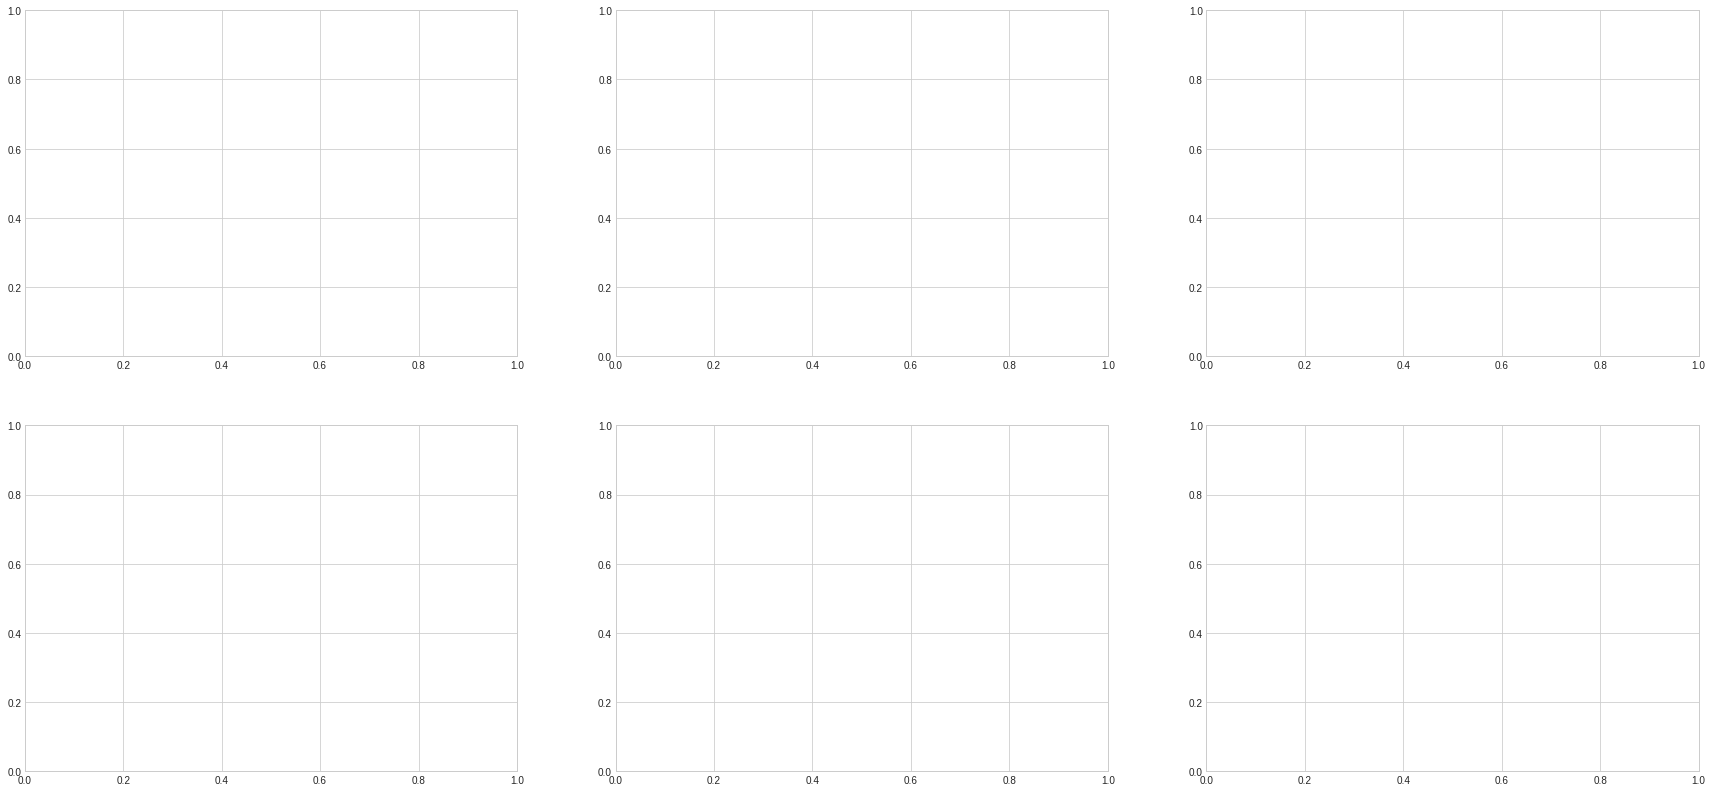

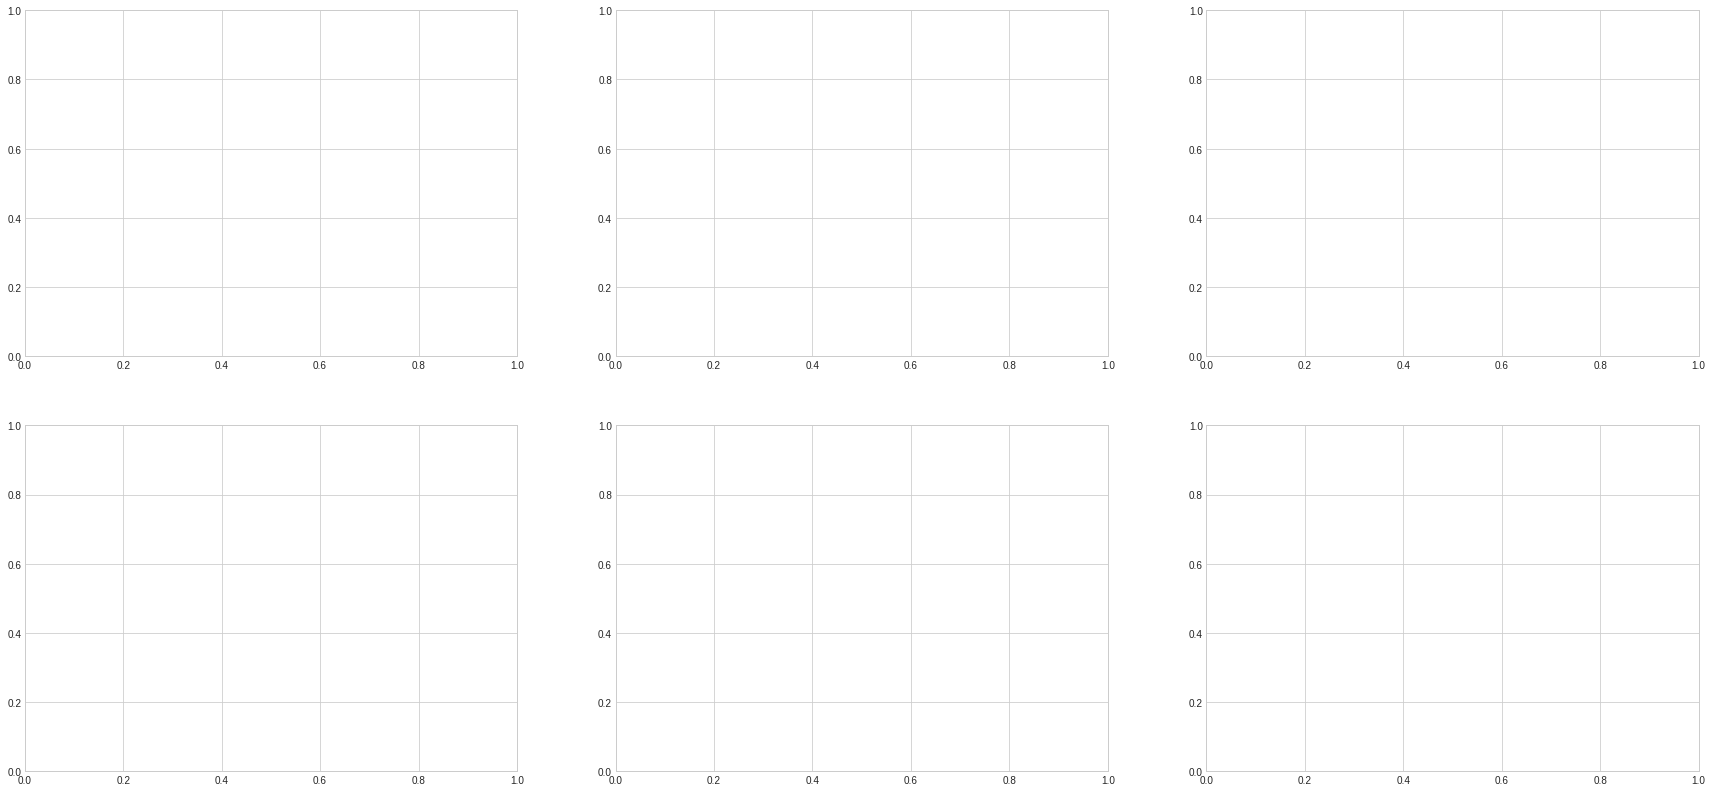

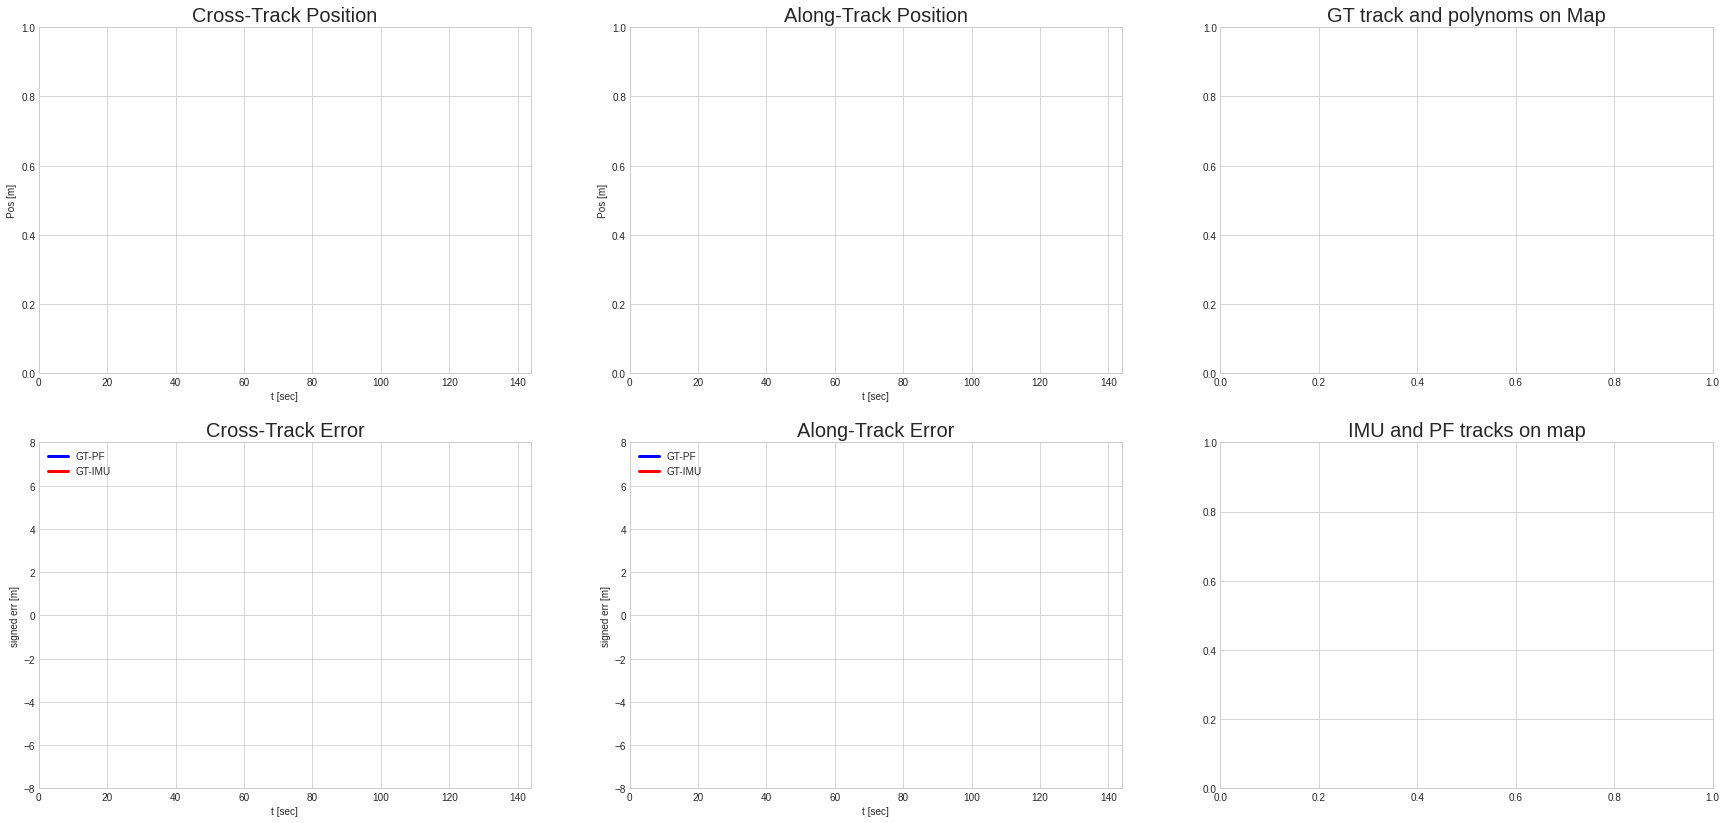

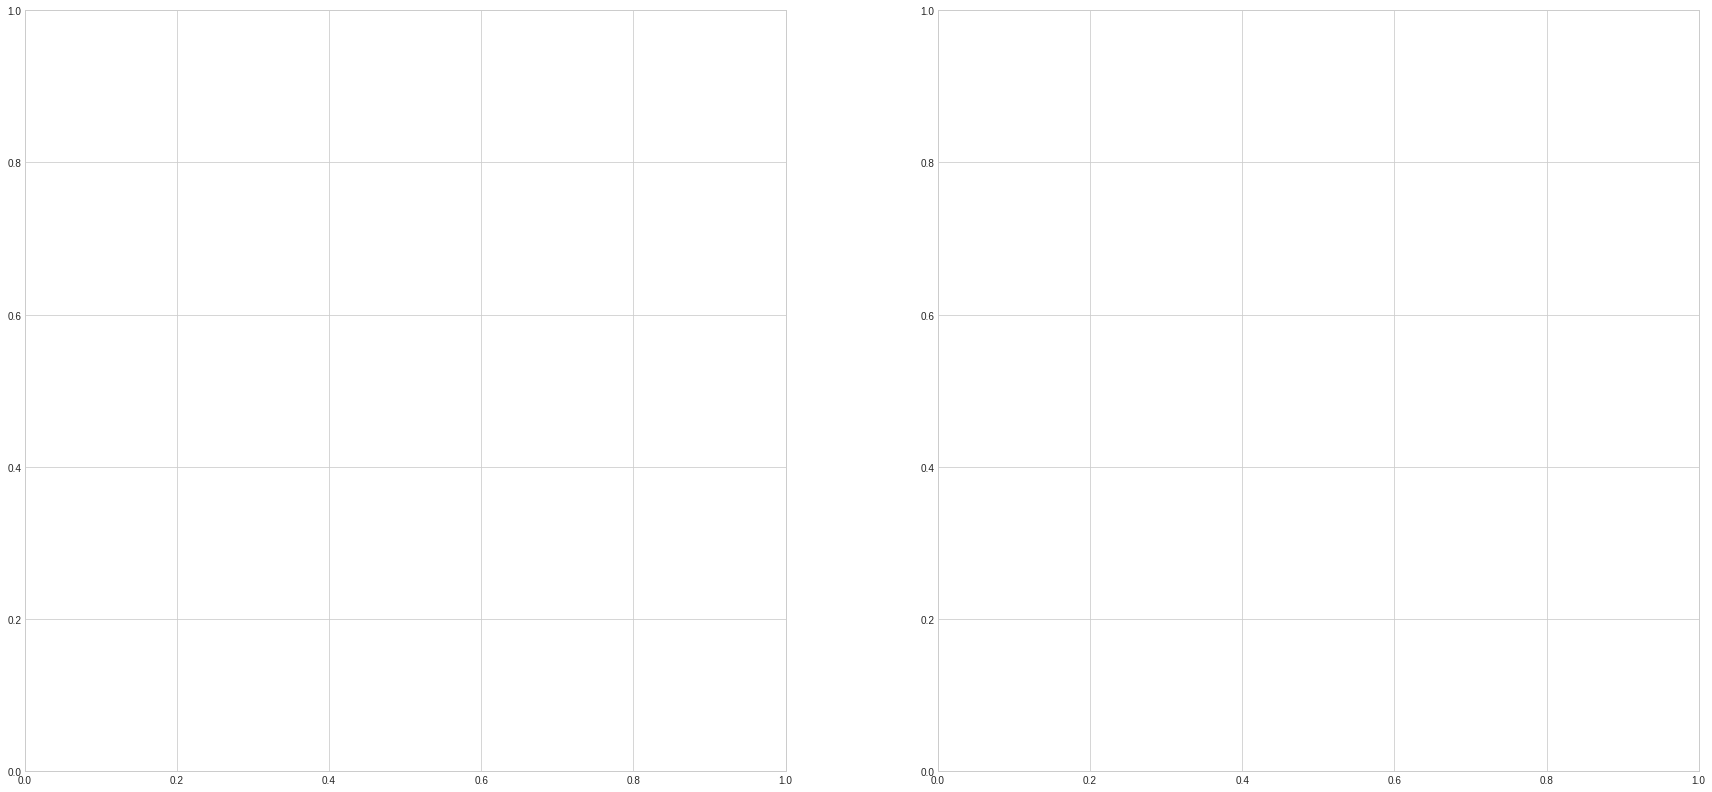

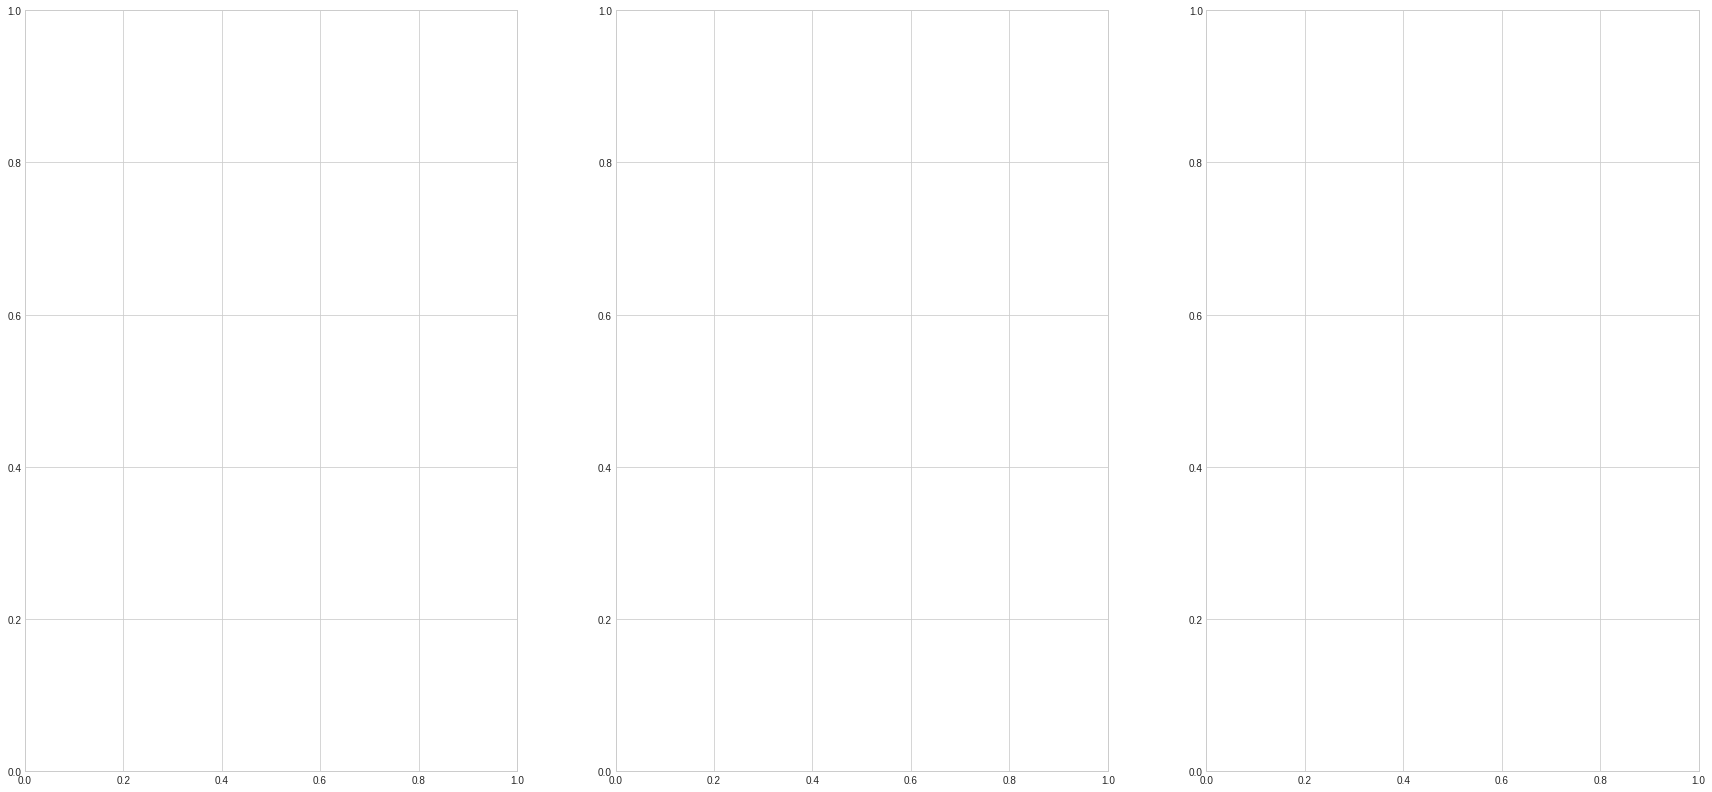

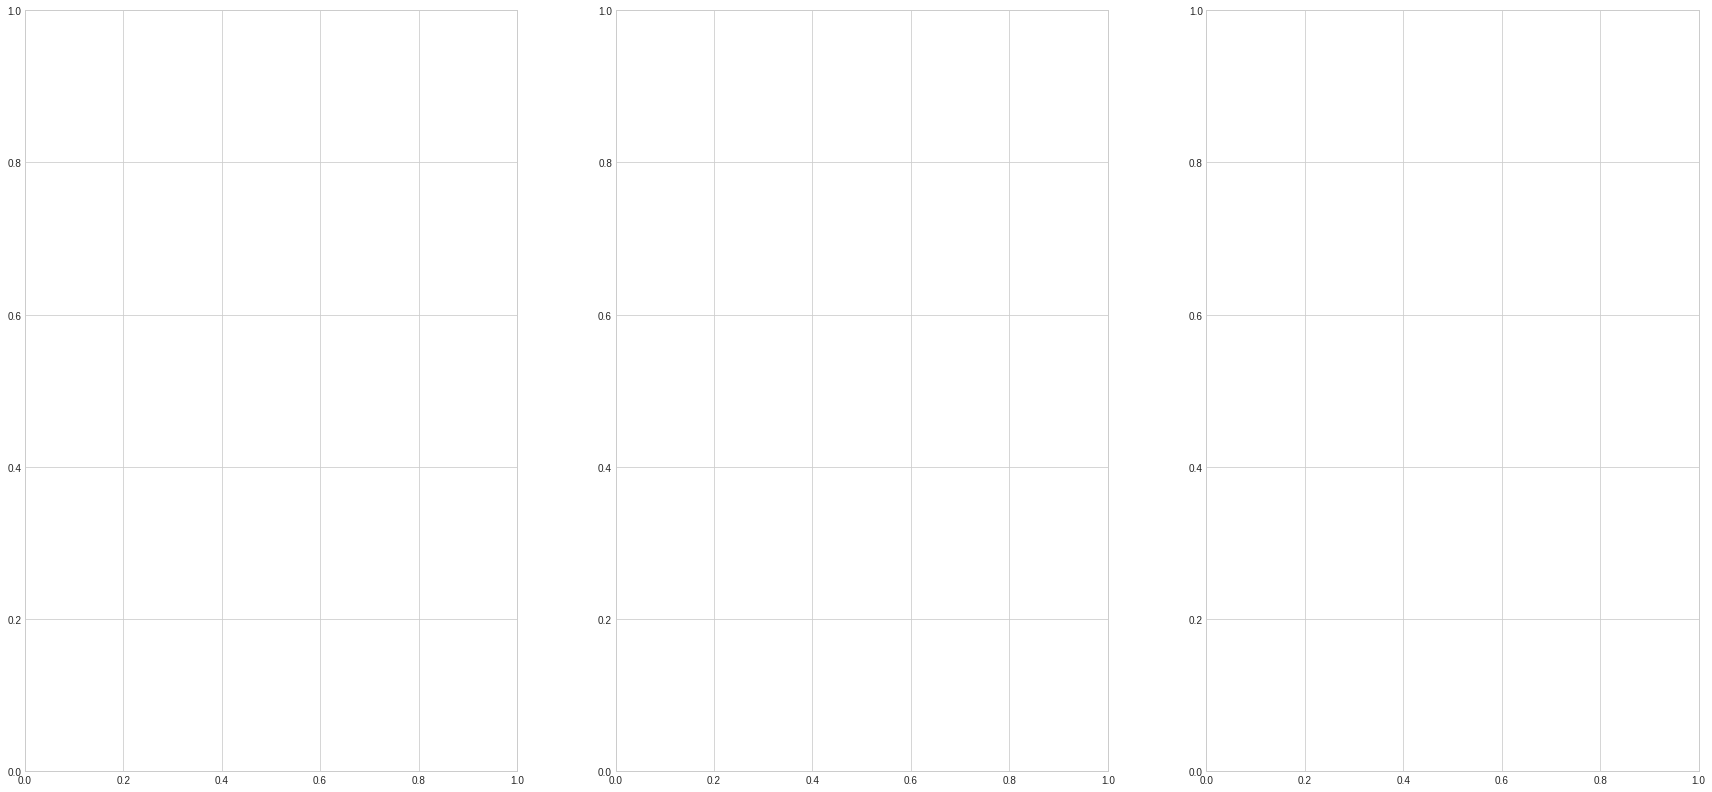

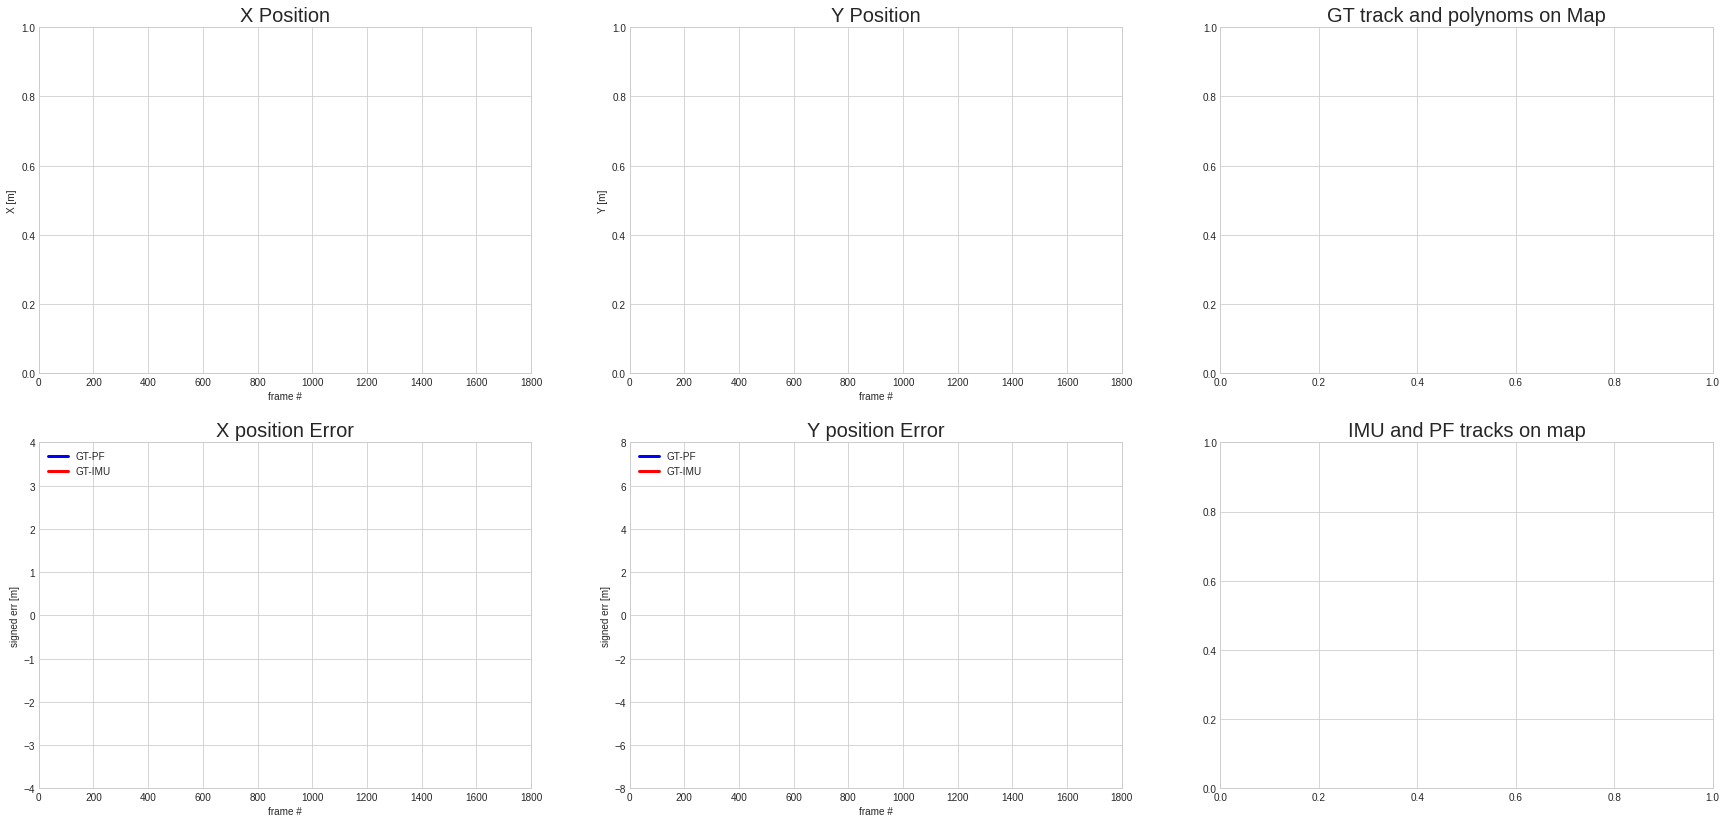

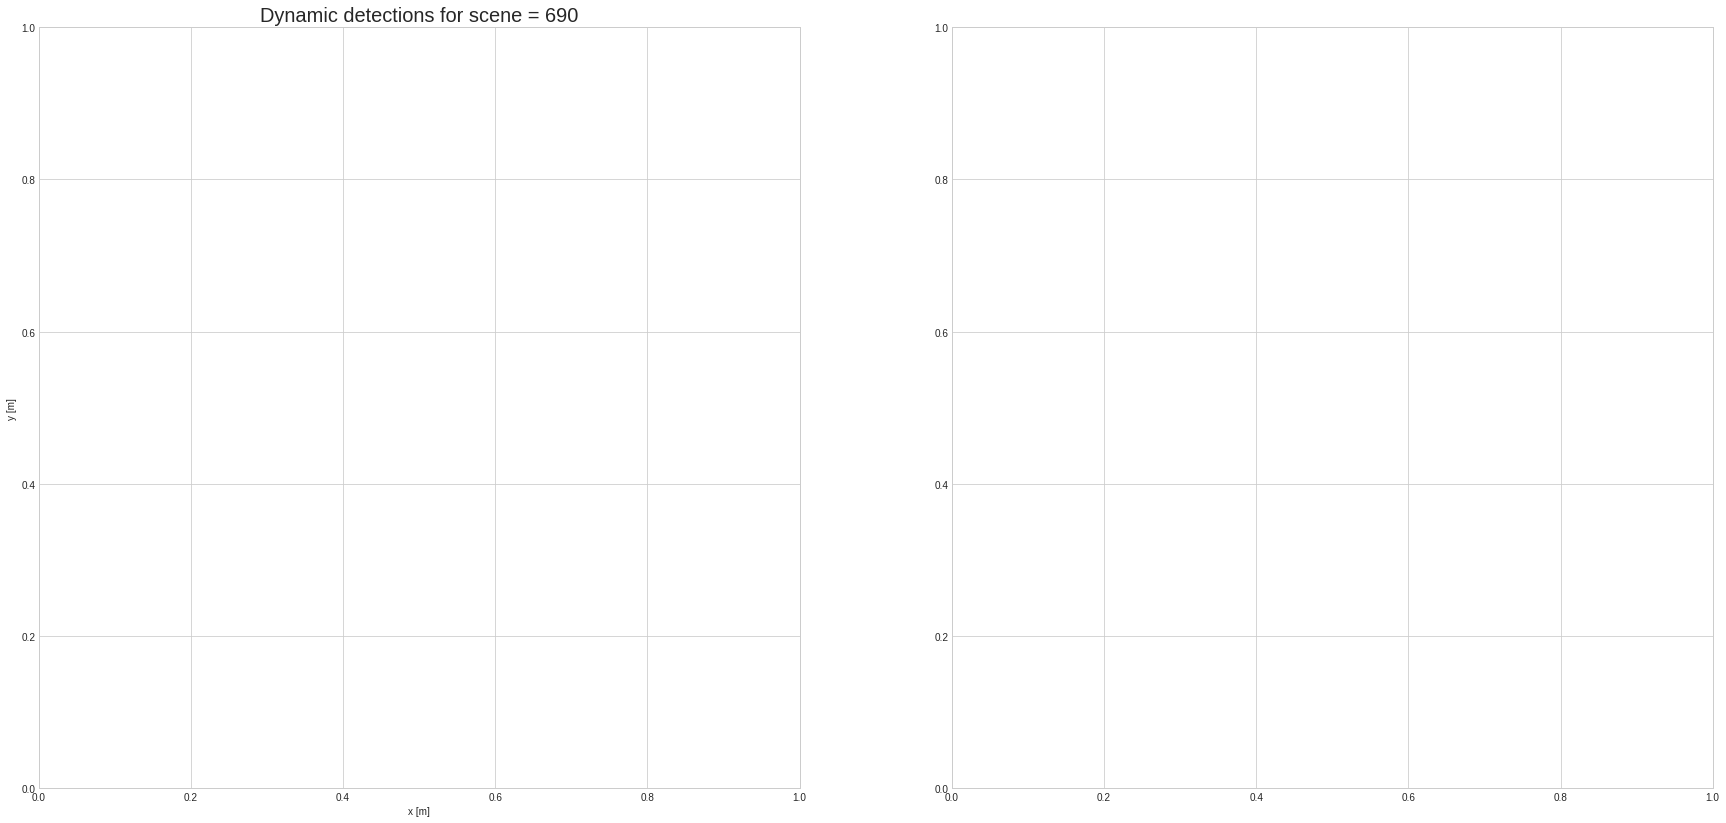

In [4]:
scene = 690 #365
model = RadarLocalizer(scene_id=scene, mm=True)
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1800, video_list=video_list, save_processed=True)
sim.run(start=0, N=1600, generate_video=False, video_with_priors=True, debug=False)

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

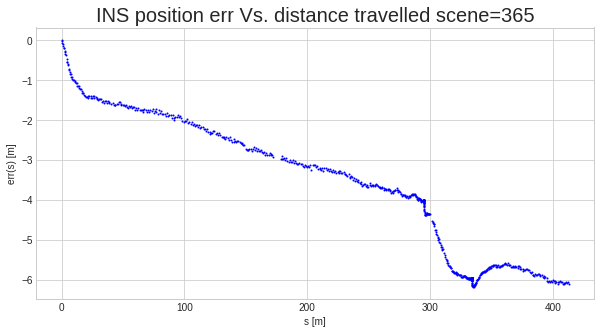

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


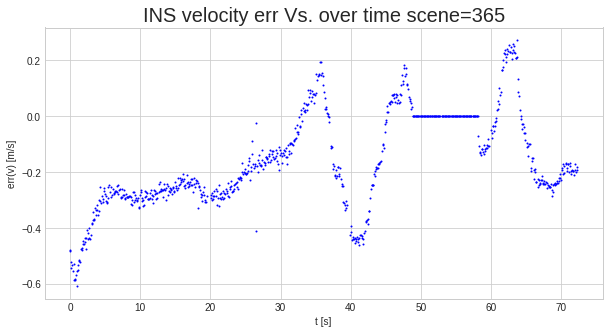

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [144]:
mapa = sim.dataset.getMap()


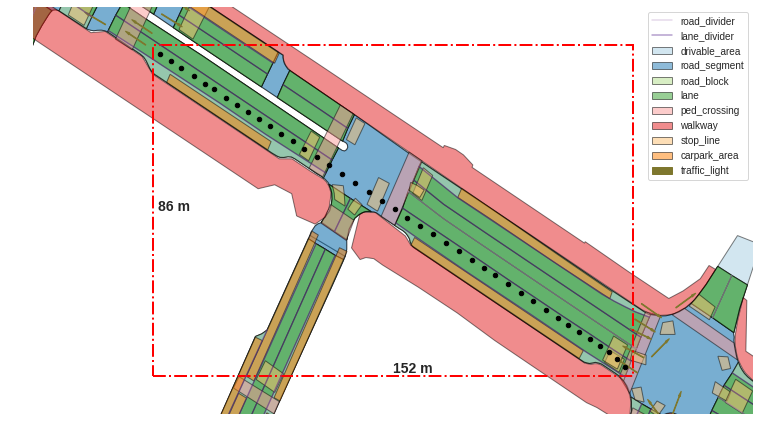

In [148]:
ego_poses = mapa.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[692]['token']], verbose=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:310: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.first_imu_rot = Quaternion(rot_imu[ridx,1])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


history []


/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

/home/kfir/workspace/RadarLocalization/dataset.py:260: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.odometry['speed'] = np.array(veh_speed[pidx,1])
/home/kfir/workspace/RadarLocalization/dataset.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.imu[ridx]['q'])


lane 064b40fb-8cac-41fe-8da0-64d7efae466c
lane_record [{'start_pose': [1219.5383474792059, 1530.8844174831108, 2.5092875341011887], 'end_pose': [1155.7730018783566, 1576.6301493198748, 2.5135564033435958], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [11.066198584683017, 60.61403042380957, 6.797333611145599]}]
lane 16439dab-3aca-44e0-b71c-27f3a4101cc6
lane_record [{'start_pose': [1154.860391933472, 1596.8158891333114, 1.0919707909459124], 'end_pose': [1184.724541736912, 1655.908110135504, 1.0985381798555793], 'shape': 'LSR', 'radius': 999.999, 'segment_length': [12.261802872002722, 48.254005699130694, 5.694420529724948]}]
lane 19793eeb-57ca-4441-8d4a-b0ca5774c70f
lane_record [{'start_pose': [1098.6431201434573, 1602.5386642023557, -0.5701644816266564], 'end_pose': [1123.58579214211, 1587.293912612687, -0.5551498821794157], 'shape': 'LSR', 'radius': 487.58633906279675, 'segment_length': [18.262388382157795, 0.030135263906064115, 10.941474805183244]}]
lane 204d4dd1-cb01-44e5-acc0

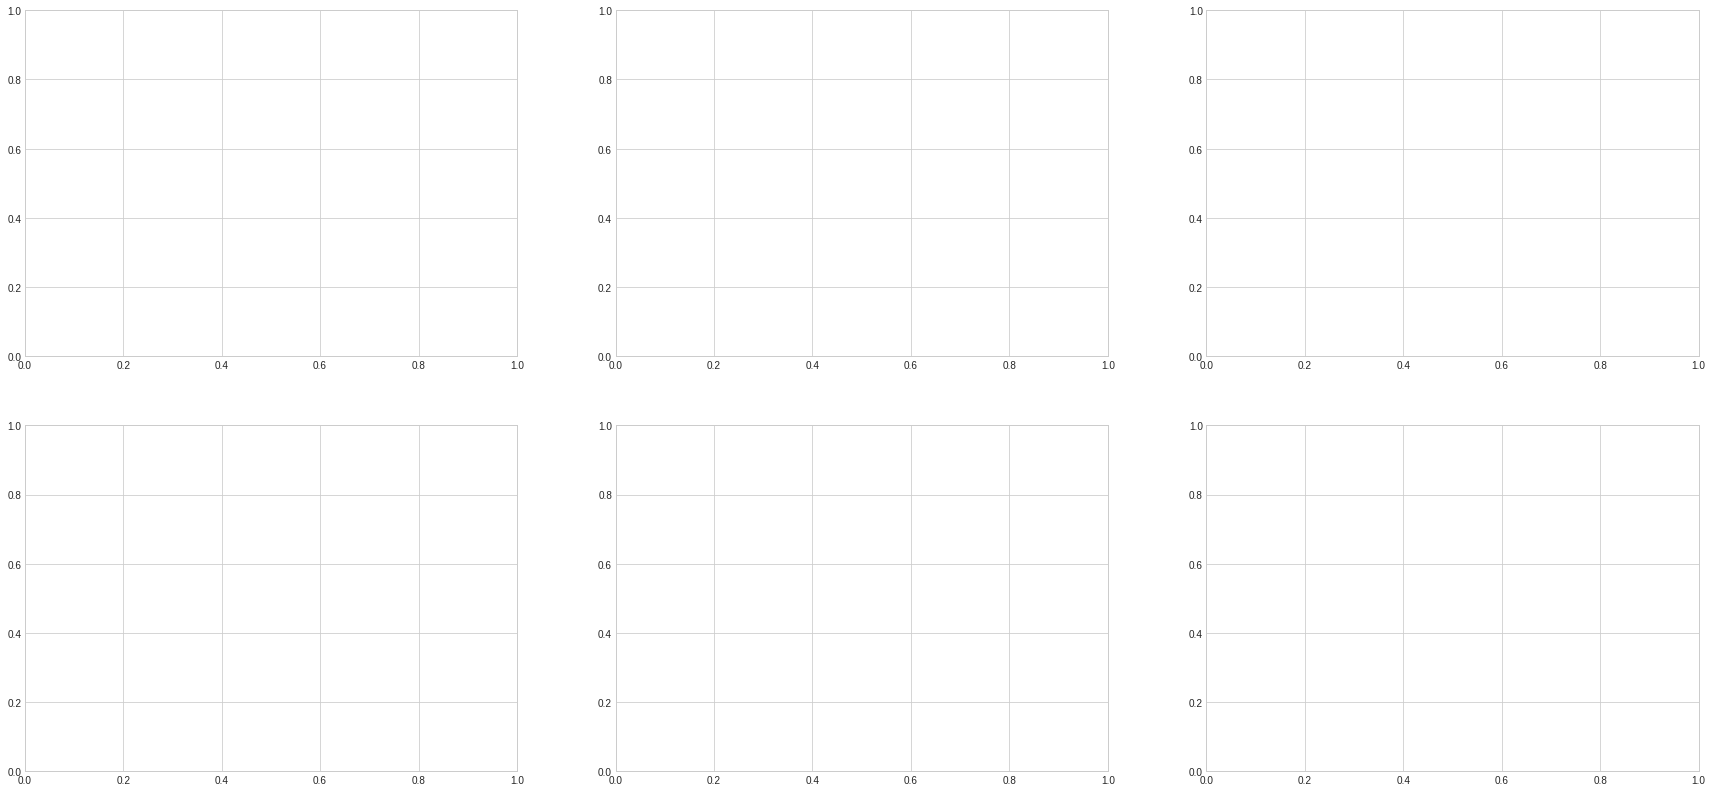

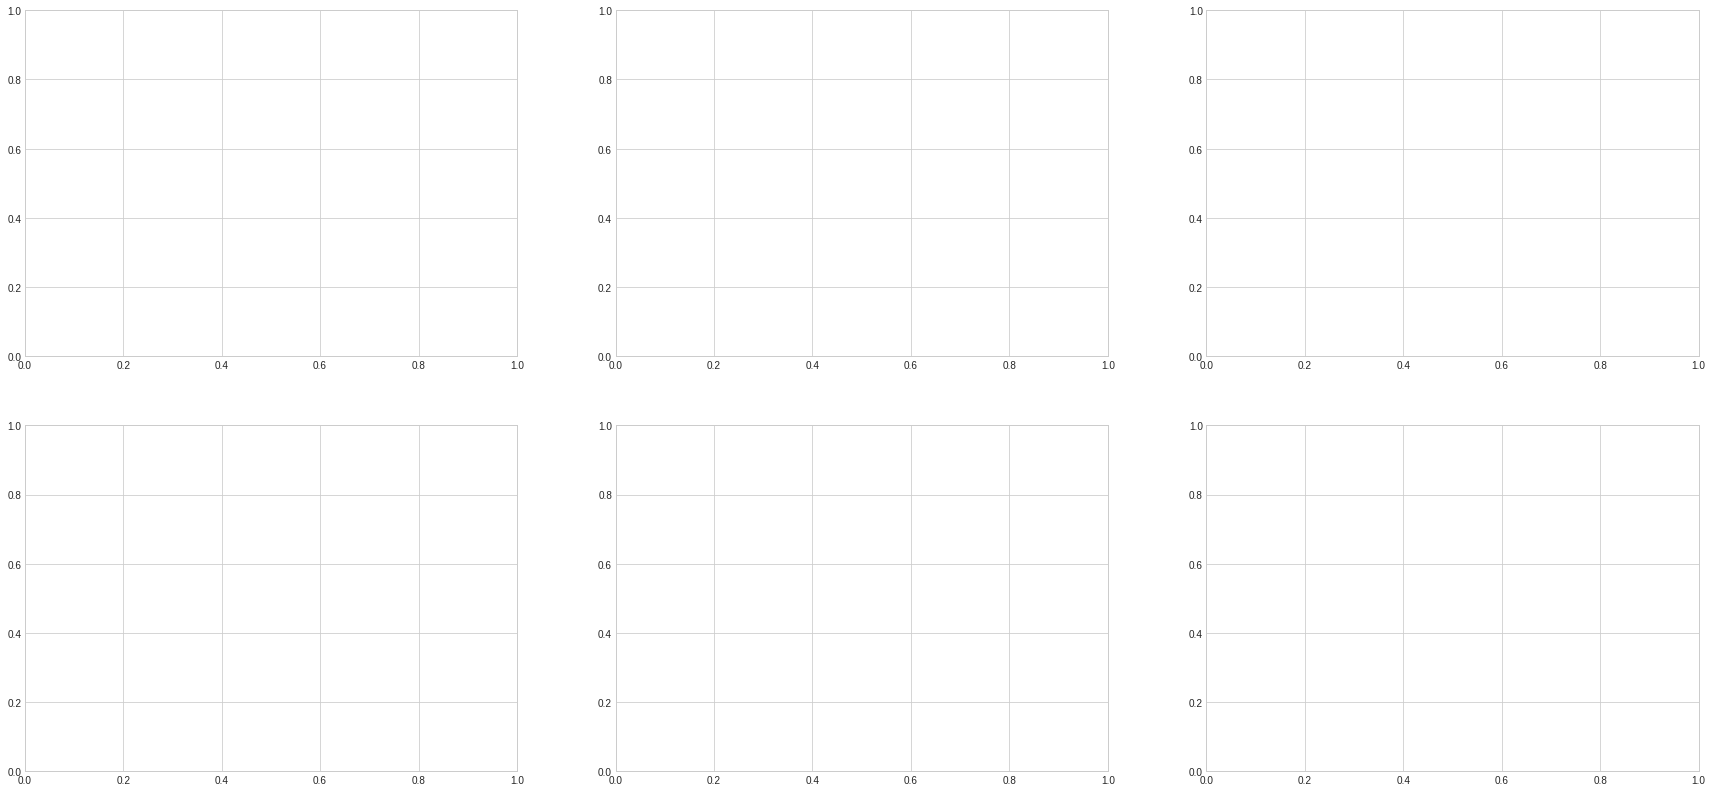

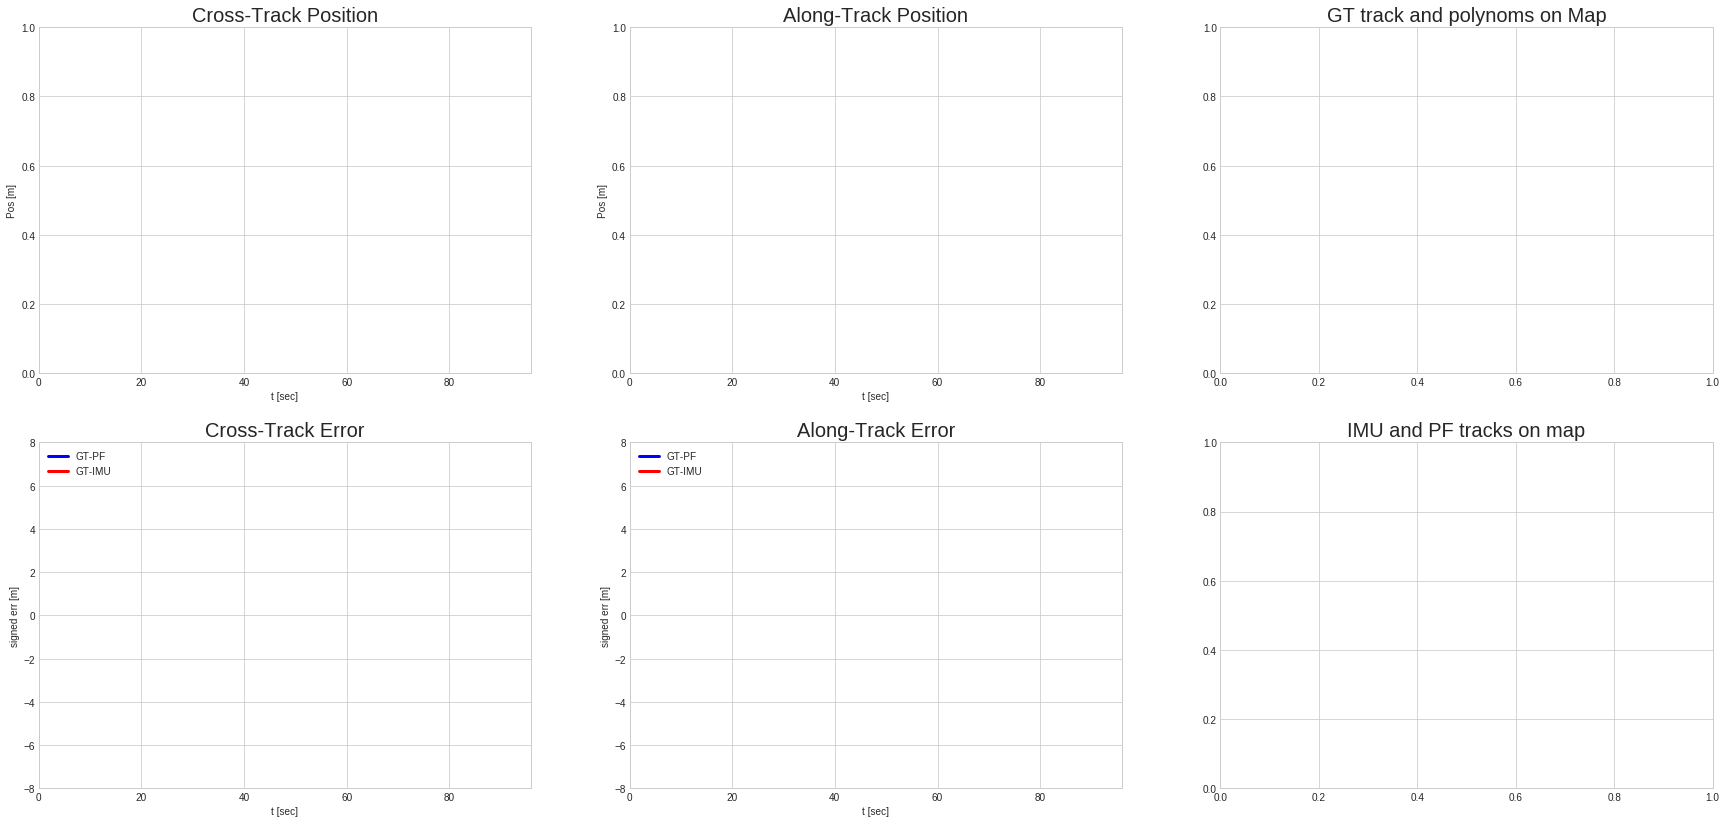

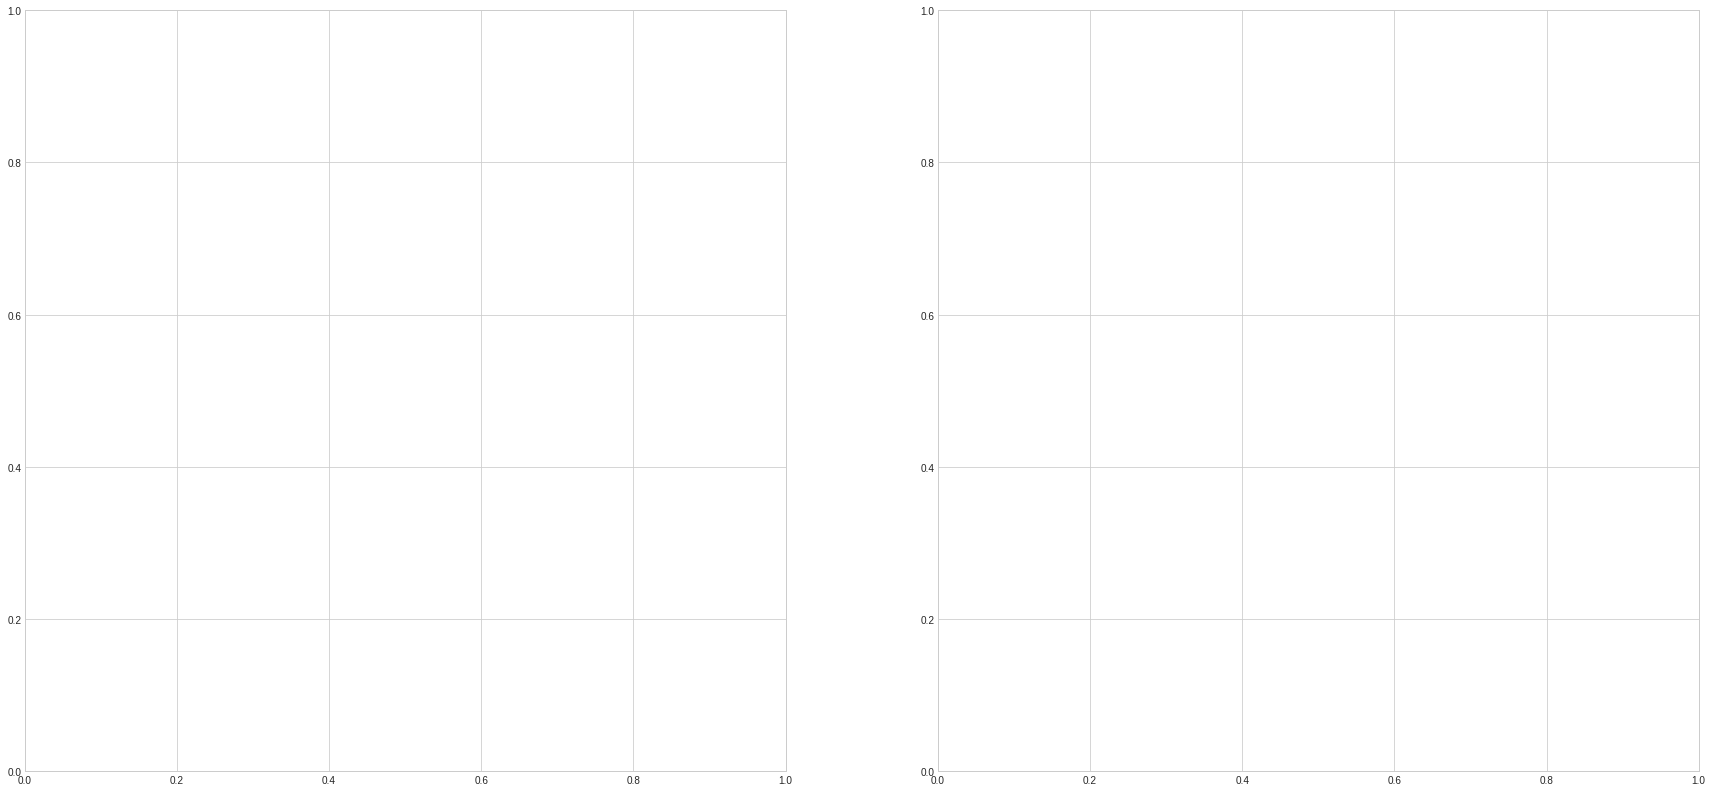

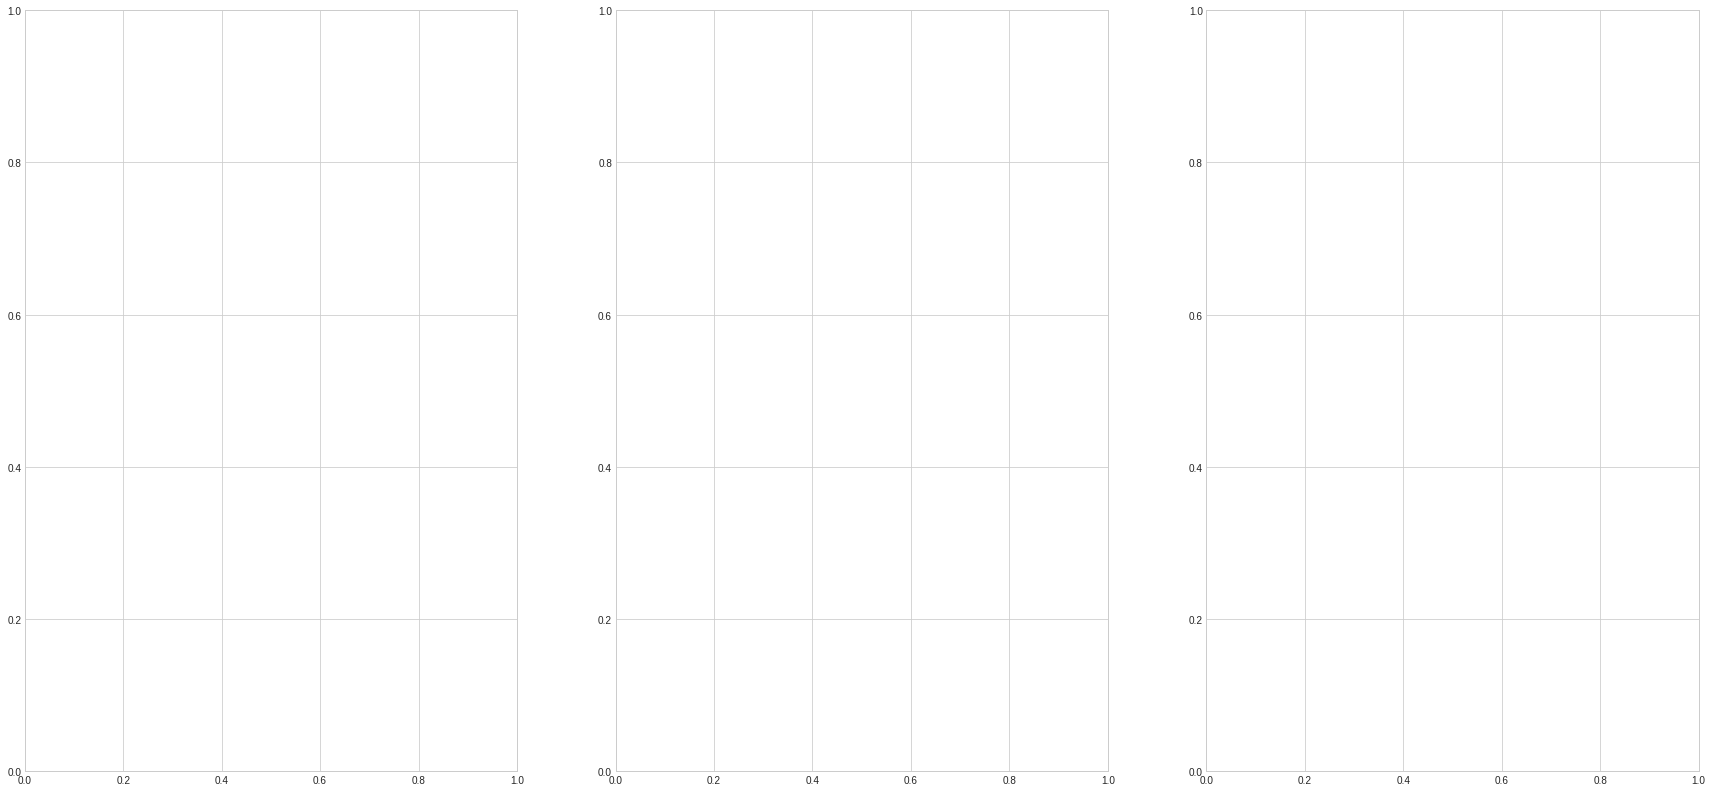

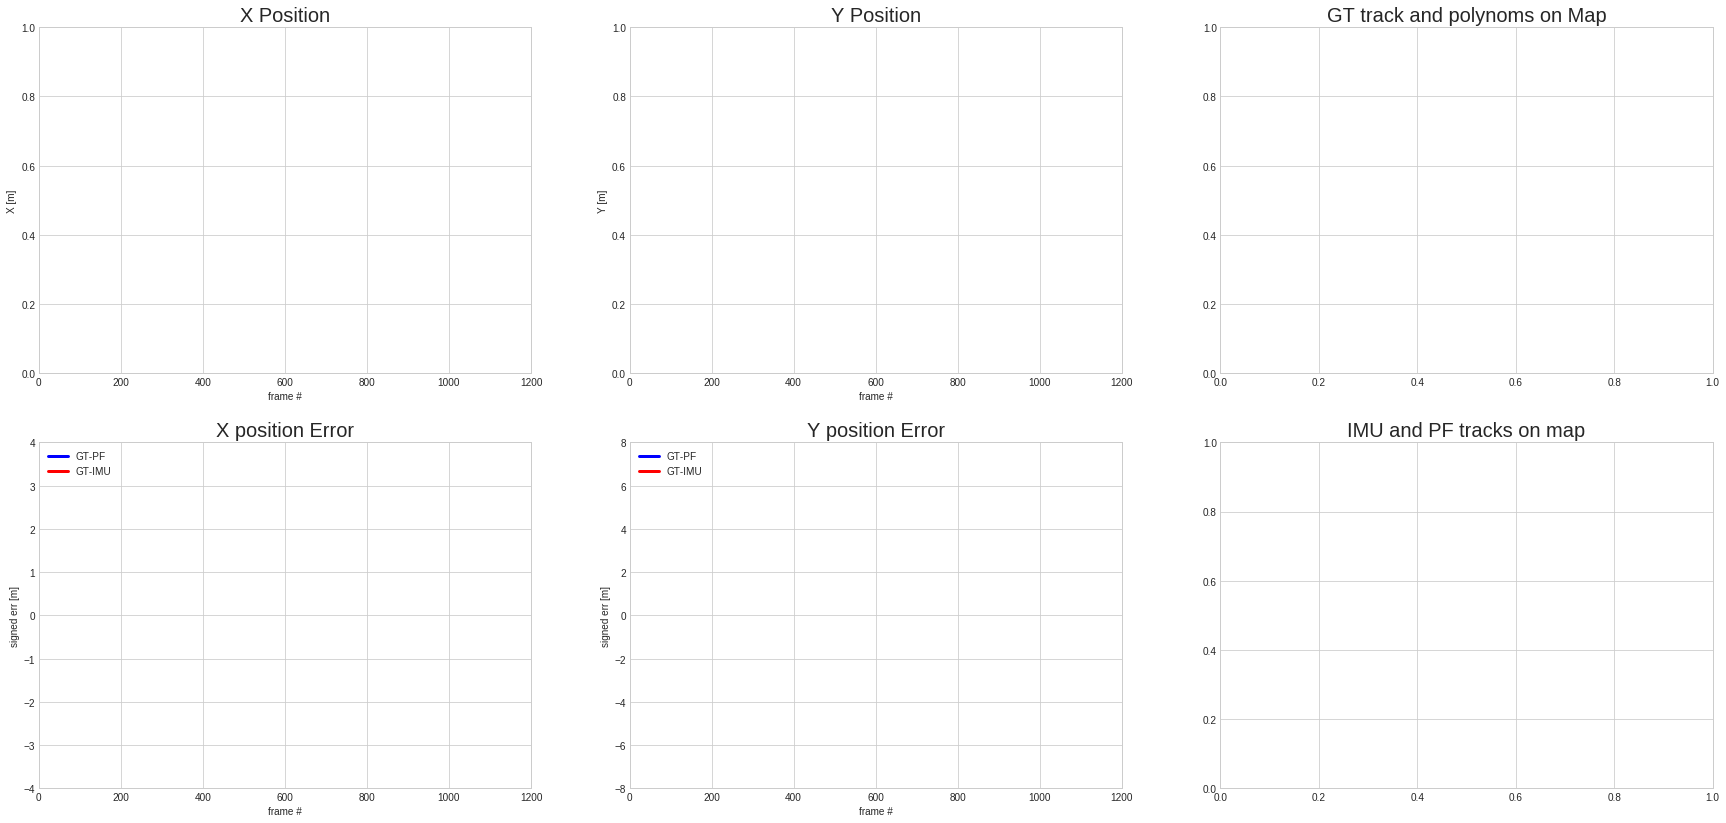

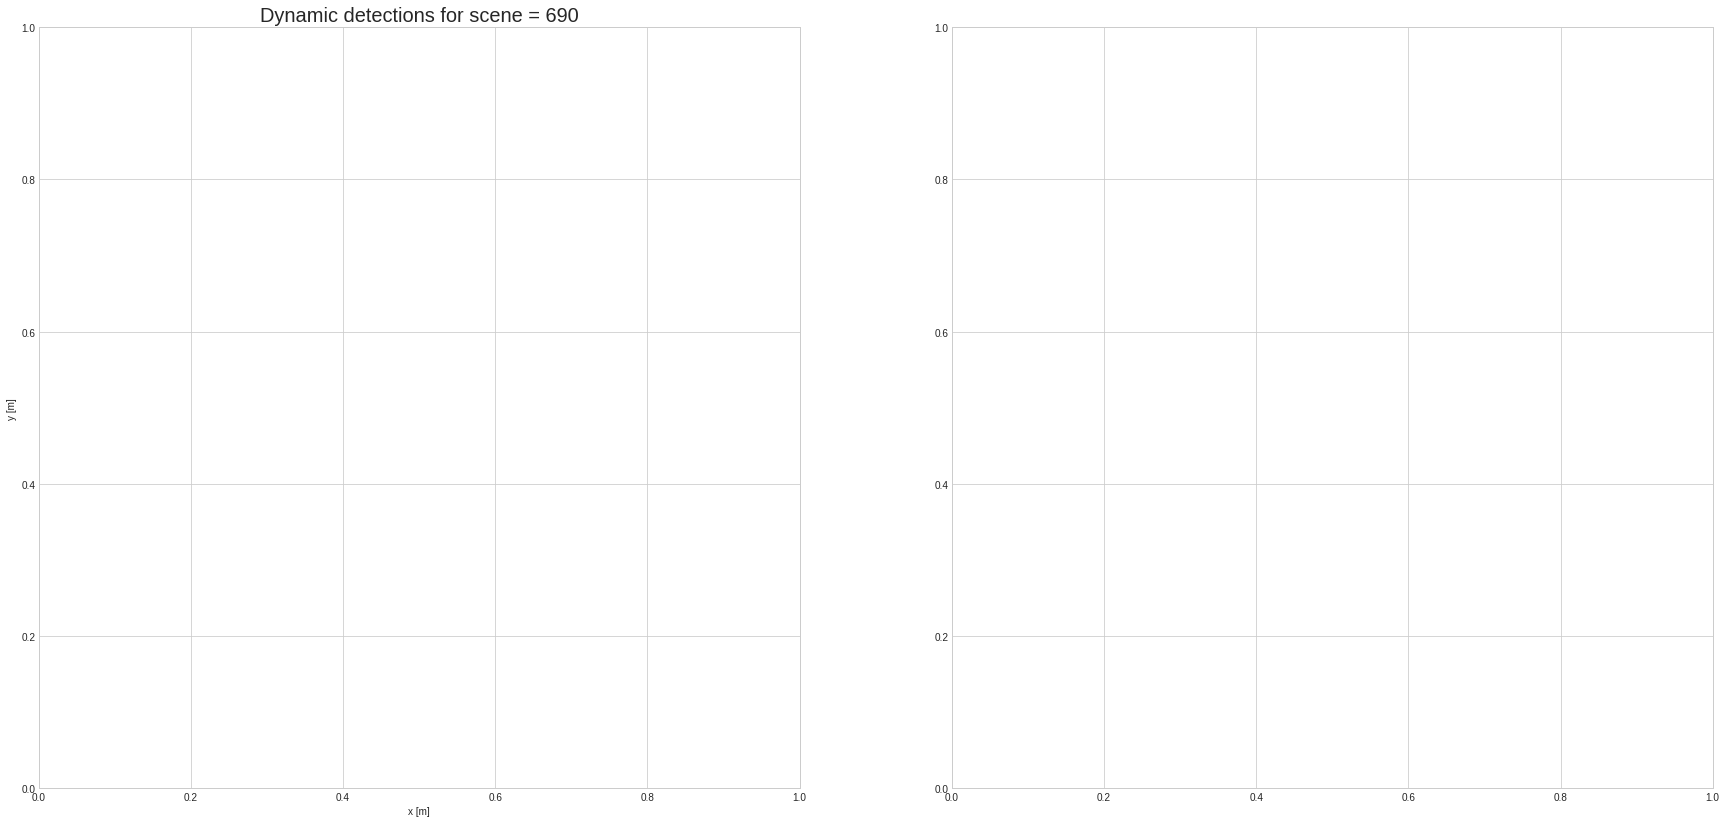

In [274]:
start_frame=0
n_frames = 15
ego_path = sim.dataset.getEgoPath()[:n_frames]
tracker = DynamicTracker()
dbscan_clustering = ClassicDBSCAN()
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list)

print("history",history)
for t in range(start_frame,n_frames):
    _, _, _, pc, video_data, _ = sim.dataset.getData(t,GT=False)
    ts, heading, ego_speed = video_data["timestamp"], np.deg2rad(video_data["heading"]-90), video_data["veh_speed"]
    print("t", t)
    Z, C = dbscan_clustering.run(pc=pc, ego=ego_path[t], heading=np.deg2rad(heading))
    print("C",C)
    tracker.run(Z, ts, {"heading": np.deg2rad(heading), "T": ego_path[t]}, ego_speed)

In [275]:
def drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2):
    if 1:#trk.confirmed:
        hstate, hego, hspeed = trk.getHistory()
        history_len = hstate.shape[0]
        if trk.hits > 5:
        #rotate translate each state according to hego
            tstate = np.zeros((hstate.shape[0], 2, 1))
            tspeed = np.zeros((hstate.shape[0], 2, 1))
            for i, (state, ego, speed) in enumerate(zip(hstate, hego, hspeed)):
                R = np.array([[np.cos(ego["heading"]), -np.sin(ego["heading"])], [np.sin(ego["heading"]), np.cos(ego["heading"])]])
                tstate[i, :, :] = np.dot(R, state[0:2]) + ego["T"][0:2].reshape(-1,1)
                tspeed[i, :, :] = np.dot(R, state[2:4]) + np.dot(R, speed[0:2].reshape(-1,1))
            abs_vel = np.mean(np.linalg.norm(tspeed,axis=1), axis=0)
            print(f"abs_vel ={abs_vel}")
            if abs_vel < velThr:
                return
            
            ax.plot(tstate[:,0]+x_offset, tstate[:,1]+y_offset, color='red',label='track')
            dx = tstate[int(history_len / 2) + 1,0]-tstate[int(history_len / 2) - 1,0]
            dy = tstate[int(history_len / 2) + 1,1]-tstate[int(history_len / 2) - 1,1]
            ax.arrow(np.mean(tstate[:,0]+x_offset), np.mean(tstate[:,1]+y_offset), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)
            
def drawClusters(ax, cluster, x_offset=0, y_offset=0):
        for c in C:
            print(c)
            x_com = c[0]
            y_com = c[1]
            print("scatter x_com", x_com, y_com)
            ax.scatter(x_com, y_com, s=100, color='green')

lane_record [{'start_pose': [1177.7862727154206, 1672.4999821898566, -0.5482126305436211], 'end_pose': [1198.753070199328, 1659.288089910761, -0.5478653376415797], 'shape': 'RSL', 'radius': 434.9672740042469, 'segment_length': [12.303630098631363, 0.024782725978953556, 12.454691145513522]}]
min_dist = 104.47598166395187
abs_vel =[5.90431763]
[1138.92071731 1576.08262102    2.75          0.        ]
scatter x_com 1138.9207173121658 1576.082621016088


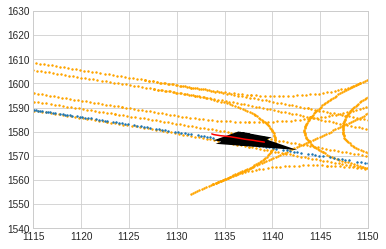

In [276]:
from nuscenes.map_expansion.map_api import NuScenesMap
import nuscenes.map_expansion.arcline_path_utils as path_utils
import numpy as np
import matplotlib.pyplot as plt

ax = plt.gca()
ax.clear()

n = 0
ego_path = sim.dataset.getEgoPath()
lane_ids = mapa.get_records_in_radius(ego_path[n,0], ego_path[n,1], 80, ['lane', 'lane_connector'])
nearby_lanes = lane_ids['lane'] + lane_ids['lane_connector']
for lane_token in nearby_lanes:
    lane_record = mapa.get_arcline_path(lane_token)
    poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
    poses = np.array(poses)
    ax.scatter(poses[:,0], poses[:,1],color='orange',s=2)
#lane_token = mapa.get_closest_lane(ego_path[n,0], ego_path[n,1], radius=2)
#fig, ax = mapa.render_layers(['lane'],tokens=lane_token)
    #lane_path = mapa.arcline_path_3.get(lane_token, [])

    #resolution_meters = 0.5
    #discretized = np.array(path_utils.discretize_lane(lane_path, resolution_meters))
#fig, ax = mapa.render_layers(['lane'])


#ax.plot(discretized[:,0], discretized[:,1], 's', color='orange')
ax.scatter(ego_path[:,0], ego_path[:,1],s=2)

ax.set_xlim([1115, 1150])
ax.set_ylim([1540, 1630])

np.min(np.linalg.norm(ego_path[n,:]-poses))
#lane_record = mapa.get_arcline_path(lane_token)
print("lane_record", lane_record)
#poses = path_utils.discretize_lane(lane_record, resolution_meters=0.5)
#poses = np.array(poses)

min_dist = np.min(np.linalg.norm(ego_path[n,:2]-poses[:,0:2],axis=1))
print(f"min_dist = {min_dist}")
#print("poses",poses)
ax.scatter(poses[:,0], poses[:,1],s=2)

tracks = tracker.getHistory()
for idx,trk in enumerate(tracks):
    drawTrack(ax, trk, x_offset=0, y_offset=0, velThr=2)
    
drawClusters(ax, C)
#ax.axis('equal')
#plt.show()

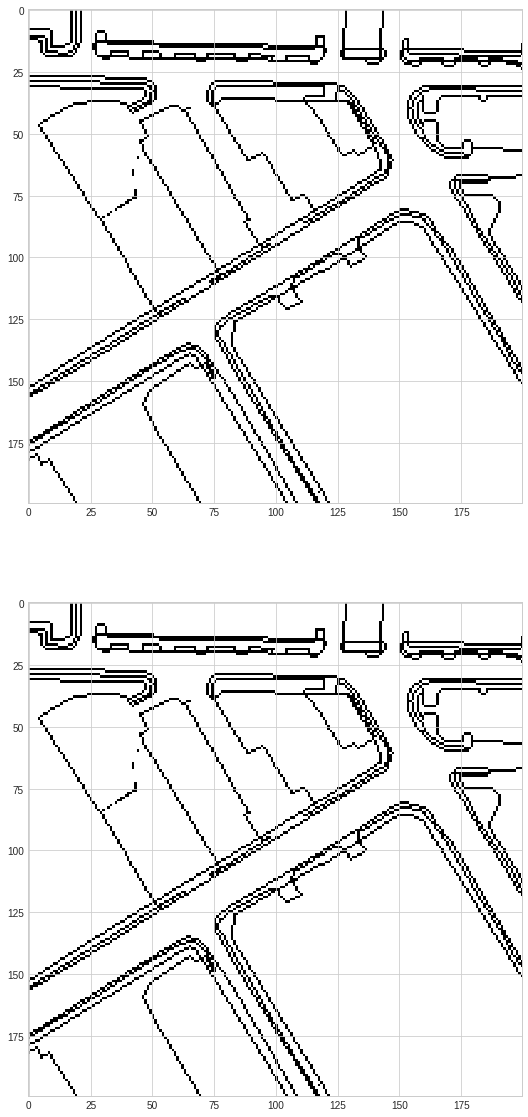

In [71]:
from map_utils import *

#sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=690, Nmax=1200, video_list=video_list)


fig, ax = plt.subplots(2,figsize=(10,20))
mapa = sim.dataset.getMap()
ego_path = sim.dataset.getEgoPath()
orig = getCombinedMap(mapa,ego_path[300,:],smooth=False)#[80:120,100:150]
smoothed = getCombinedMap(mapa,ego_path[300,:],smooth=True)#[80:120,100:150]
ax[0].imshow(orig)
ax[1].imshow(smoothed)
#plt.imsave('690.png', binary_map)

In [705]:
from scipy.interpolate import splrep, splev

def getLineIndication(pos, N=50, thr=0.05):
        x = pos[-N:,0]
        y = pos[-N:,1]

        fit, cov = np.polyfit(x, y, 1, cov=True)
        print("cov",cov,"fit",fit)
        if np.sqrt(cov[0,0]) < thr:
            return True

        return False

def computeIMUAngleBias(imuPos, pfPose, N=50):
    if imuPos.shape[0] >= 5 and getLineIndication(imuPos, N=N):
        ax = imuPos[-N:,0] - imuPos[0,0]
        ay = imuPos[-N:,1] - imuPos[0,1]
        bx = pfPose[-N:,0] - pfPose[0,0]
        by = pfPose[-N:,1] - pfPose[0,1]
        angle_bias = np.arctan2(ax*by - ay*bx, ax*bx + ay*by)
        return angle_bias

    return None

In [709]:
pf_pos = np.array([[0,0],[100,-50],[200,-100],[300,-150],[400,-200]])
imu_pos = np.array([[0,0],[100,-51],[200,-10],[300,-13],[400,-204]])
print(imu_pos.shape)
print(computeIMUAngleBias(imu_pos, pf_pos)[-1])

(5, 2)
[  0 100 200 300 400] [   0  -51  -10  -13 -204]
cov [[ 5.11306667e-02 -1.02261333e+01]
 [-1.02261333e+01  3.06784000e+03]] fit [-0.37 18.4 ]


TypeError: 'NoneType' object is not subscriptable

In [665]:
math.atan2(4,4)

0.7853981633974483

In [ ]:
-0.37 * 400